In [1]:
options(warns = -1)
suppressMessages(library(dplyr))
suppressMessages(library(Seurat))
suppressMessages(library(GSVA))
suppressMessages(library(ggplot2))
suppressMessages(library(metafor))
suppressMessages(library(readxl))
suppressMessages(library(ConsensusClusterPlus))
suppressMessages(library(glmnet))
suppressMessages(library(limma))
suppressMessages(library(survivalROC))
suppressMessages(library(forestplot))
suppressMessages(library(ggpubr))
suppressMessages(library(topGO))
suppressMessages(library(enrichplot))
suppressMessages(library(clusterProfiler))
suppressMessages(library(e1071))
suppressMessages(library(gridExtra))
suppressMessages(library(grid))
suppressMessages(library(org.Hs.eg.db))

In [2]:
source('modules/OS.R')
source('modules/global_vars.R')

In [3]:
out.data.dir <- file.path('../2.results', '1.immune.genes/data')
out.figs.dir <- file.path('../2.results', '1.immune.genes/figs')

dir.create(file.path('../2.results', '1.immune.genes'), showWarnings = FALSE)
dir.create(out.data.dir, showWarnings = FALSE)
dir.create(out.figs.dir, showWarnings = FALSE)

### Import 782 marker genes

In [4]:
markers <- read_excel('../0.data/marker_genes.xlsx', skip = 2) %>% as.data.frame
pathways <- read_excel('../0.data/Tumor_Pathway_Geneset.xlsx') %>% apply(., 2, function(x) x[!is.na(x)] )

In [5]:
head(markers)
message(sprintf('Number of genes: %g', dim(markers)[1]))

Metagene Cell type        Immunity
1 ADAM28   Activated B cell Adaptive
2 CD180    Activated B cell Adaptive
3 CD79B    Activated B cell Adaptive
4 BLK      Activated B cell Adaptive
5 CD19     Activated B cell Adaptive
6 MS4A1    Activated B cell Adaptive

Number of genes: 782



### Immune inflitration using ssGSEA method

In [6]:
marker.lst <- split(markers$Metagene, markers$`Cell type`)

In [7]:
obj.file <- list.files(path = '../0.data', pattern = 'Obj.rds', full.names = T)
obj.lst <- lapply(obj.file, function(x) { obj <- readRDS(x) })
names(obj.lst) <- gsub('.*/|Obj.rds', '', obj.file)

In [8]:
tcga.obj <- obj.lst[['tcga']]
nes.score <- gsva(GetAssayData(tcga.obj) %>% as.matrix %>% { log2 (.+1) }, pathways, method = 'ssgsea', kcdf = 'Gaussian') %>% t

Warning message in .filterFeatures(expr, method):
"1300 genes with constant expression values throuhgout the samples."


Estimating ssGSEA scores for 10 gene sets.
  |======================================================================| 100%



In [9]:
nes.score %>% head()

RTK_RAS  NOTCH    HIPPO    WNT      PI3K    
TCGA-E2-A15G-01A-11R-A12D-07 1.336675 1.240839 1.192835 1.186799 1.521849
TCGA-E2-A1B5-01A-21R-A12P-07 1.313803 1.267868 1.189044 1.260562 1.453758
TCGA-EW-A2FS-01A-11R-A17B-07 1.352823 1.248907 1.171422 1.205154 1.420731
TCGA-EW-A1P7-01A-21R-A144-07 1.396801 1.311661 1.327573 1.349573 1.428941
TCGA-LL-A5YO-01A-21R-A28M-07 1.260467 1.279847 1.182847 1.218694 1.414804
TCGA-BH-A1FN-01A-11R-A13Q-07 1.343863 1.314693 1.287907 1.161825 1.474510
                             CELL_CYCLE TGF_Beta MYC      TP53     NRF2    
TCGA-E2-A15G-01A-11R-A12D-07 1.356145   1.478386 1.417893 1.419021 1.737924
TCGA-E2-A1B5-01A-21R-A12P-07 1.475970   1.470507 1.449694 1.460431 1.694040
TCGA-EW-A2FS-01A-11R-A17B-07 1.500784   1.443278 1.347984 1.438744 1.662352
TCGA-EW-A1P7-01A-21R-A144-07 1.588284   1.447075 1.425700 1.467098 1.670157
TCGA-LL-A5YO-01A-21R-A28M-07 1.546093   1.354670 1.407807 1.400502 1.674053
TCGA-BH-A1FN-01A-11R-A13Q-07 1.539289   1.512237 1.495506 1.476215 1.692673

In [10]:
sub.clinical <- tcga.obj@meta.data[, c('patient', 'vital_status', 'days_to_death', 'days_to_last_follow_up')]
sub.clinical$Sur <- sub.clinical$vital_status == "Dead"
sub.clinical$Time = ifelse(sub.clinical$Sur, sub.clinical$days_to_death, sub.clinical$days_to_last_follow_up)

In [11]:
cox.pvals <- sapply(colnames(nes.score), function(pth) {
    sub.clinical$Groups <- nes.score[, pth]
    res.cox <- OS.analysis(sub.clinical, c('#8A0E1A', '#3574CE'), T, cutoff = T)
    fmt <- as.formula(paste('Surv(Time, Sur)~', 'Groups'))
    sub.clinical$Groups <- sub.clinical$Groups > res.cox$cut.off
    coefs <- summary(coxph(fmt, data = sub.clinical))$coefficients[c(2, 5)] 
}) %>% as.data.frame
rownames(cox.pvals) <- c('HR', 'Pval')
cox.pvals

RTK_RAS    NOTCH        HIPPO       WNT          PI3K       CELL_CYCLE 
HR   1.58157436 2.098550e+00 1.733758199 1.7687960315 1.36027482 0.448851237
Pval 0.01225081 1.867376e-05 0.001630176 0.0007110813 0.05392389 0.005554534
     TGF_Beta     MYC          TP53       NRF2     
HR   2.077437e+00 1.790873e+00 1.40582128 1.2779880
Pval 3.474881e-05 3.972189e-05 0.02190491 0.1478204

### Network visualization

In [12]:
cols <- ifelse(cox.pvals[1, ] > 1, 'chocolate3', 'darkgreen')
mat <- cor(nes.score)
pdf(file.path(out.figs.dir, 'Cor_networks.pdf'), width = 7, height = 7)
Graph_pcor <- qgraph::qgraph(
    mat,
    layout = "circle",
    labels = colnames(mat),
    borders = T,
    vsize = -log10(cox.pvals[2, ]) * 2,
    graph = 'cor',
    color = cols,
    alpha = 0.0001,
    border.color = cols,
    border.width = 2,
    posCol= 'darkred', 
    negCol = 'darkblue',
    esize = 5 * exp(-15 / 90) + 1,
    label.cex = 1.5,
    label.scale = F
)
legend('bottom',legend=c('0.1', '0.01', '0.001', '0.0001'),pt.cex = -log10(c(0.1, 0.01, 0.001, 0.0001)) * 2, col='black',pch = 21, pt.bg='chocolate3', title = 'Log-rank test, P-value', ncol = 4)
legend('top',legend=c('Positive correlation with P < 0.0001', 'Negative correlation with P < 0.0001'), col=c("darkred", "darkblue"), lty=1:2, lwd = 2)
dev.off()

Warning message in xtfrm.data.frame(x):
"cannot xtfrm data frames"


png 
  2

In [13]:
mat

RTK_RAS    NOTCH      HIPPO     WNT       PI3K        CELL_CYCLE 
RTK_RAS     1.0000000  0.5416134 0.6719890 0.5714008  0.59829965 -0.10518729
NOTCH       0.5416134  1.0000000 0.6126745 0.6302701  0.28451209  0.12566922
HIPPO       0.6719890  0.6126745 1.0000000 0.7396464  0.41436318  0.12240206
WNT         0.5714008  0.6302701 0.7396464 1.0000000  0.16492358  0.18203138
PI3K        0.5982996  0.2845121 0.4143632 0.1649236  1.00000000 -0.27664732
CELL_CYCLE -0.1051873  0.1256692 0.1224021 0.1820314 -0.27664732  1.00000000
TGF_Beta    0.6691979  0.3940292 0.6221913 0.4263248  0.56569959 -0.14475540
MYC         0.2528204  0.3120040 0.3345550 0.3526787  0.03515346  0.21655767
TP53        0.2669558 -0.0148798 0.3364079 0.1058599  0.19609353  0.06330194
NRF2        0.4409344  0.2015549 0.2598452 0.1540826  0.50584080 -0.10183557
           TGF_Beta   MYC        TP53        NRF2      
RTK_RAS     0.6691979 0.25282043  0.26695579  0.4409344
NOTCH       0.3940292 0.31200395 -0.01487980  0.2015549
HIPPO       0.6221913 0.33455495  0.33640794  0.2598452
WNT         0.4263248 0.35267868  0.10585988  0.1540826
PI3K        0.5656996 0.03515346  0.19609353  0.5058408
CELL_CYCLE -0.1447554 0.21655767  0.06330194 -0.1018356
TGF_Beta    1.0000000 0.22540907  0.39023036  0.3527683
MYC         0.2254091 1.00000000  0.17347418  0.1213137
TP53        0.3902304 0.17347418  1.00000000  0.1477754
NRF2        0.3527683 0.12131365  0.14777535  1.0000000

### Pathway activity  of PAM50 in BC patients

In [14]:
nes.score.df <- cbind.data.frame(nes.score, PAM50 = tcga.obj@meta.data$paper_BRCA_Subtype_PAM50)

In [15]:
plot.df <- tidyr::gather(nes.score.df, 'Pathway', 'ssGSEA', -PAM50) %>% .[!is.na(.$PAM50), ]
plot.df$PAM50 <- factor(plot.df$PAM50, levels = names(PAM50_COLOR))
plot.df$Pathway <- factor(plot.df$Pathway, levels = names(pathways))

In [16]:
head(plot.df)

PAM50  Pathway ssGSEA  
1 LumA   RTK_RAS 1.336675
2 LumA   RTK_RAS 1.313803
3 LumA   RTK_RAS 1.352823
4 Normal RTK_RAS 1.396801
5 Her2   RTK_RAS 1.260467
6 LumB   RTK_RAS 1.343863

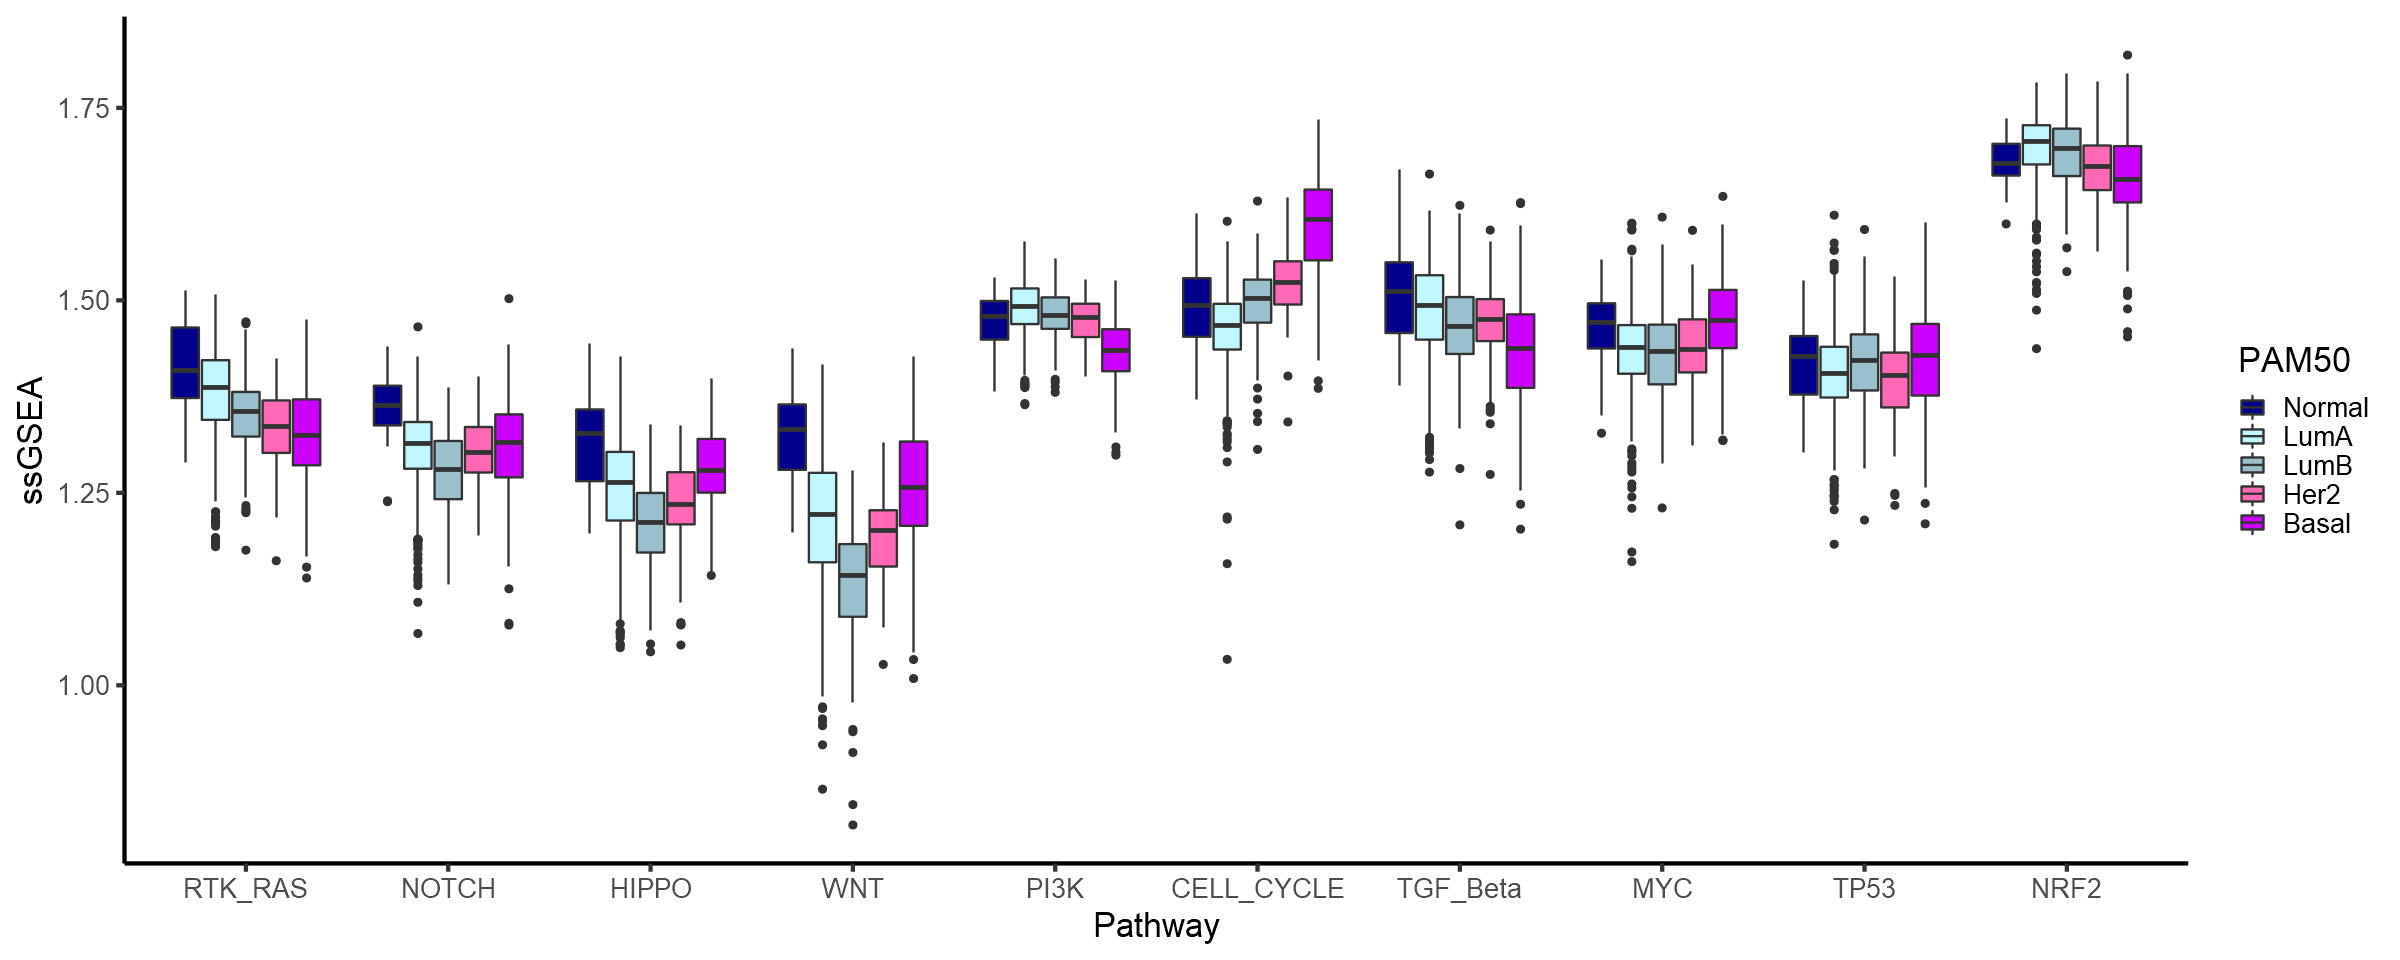

In [17]:
options(repr.plot.width = 20, repr.plot.height = 8)
ggplot(data = plot.df, aes(x = Pathway, y = ssGSEA, fill = PAM50)) + geom_boxplot() + theme_classic(base_size = 20) + scale_fill_manual(values = unlist(PAM50_COLOR)) 

In [18]:
ggsave(file.path(out.figs.dir, 'pam50_pathways_boxplot.pdf'), width = 16, height = 6)

### Association with long non-coding RNA

In [19]:
nes.score.sub <- nes.score[, cox.pvals[2, ] < 0.05]
dim(nes.score.sub)

[1] 1222    8

In [20]:
lincrna <- read.table('../0.data/gencode.gene.info.v22.tsv', sep = '\t', header = T) %>% subset(., gene_type == 'lincRNA') 
dim(lincrna)
head(lincrna)

[1] 7656   12

gene_id           gene_name    seqname start    end      strand gene_type
2  ENSG00000238009.5 RP11-34P13.7 chr1       89295   133723 -      lincRNA  
3  ENSG00000230415.1 RP5-902P8.10 chr1     1275223  1280420 +      lincRNA  
4  ENSG00000236335.1 RP4-591L5.1  chr1    30409560 30411638 -      lincRNA  
15 ENSG00000231949.1 RP4-591L5.2  chr1    30415825 30421108 +      lincRNA  
28 ENSG00000271324.1 RP11-10C24.2 chr3    33793644 33794145 -      lincRNA  
29 ENSG00000271643.1 RP11-10C24.3 chr3    33795688 33796950 -      lincRNA  
   gene_status havana_gene          full_length exon_length exon_num
2  NOVEL       OTTHUMG00000001096.2 44429       3726        17      
3  NOVEL       OTTHUMG00000002234.2  5198        513         5      
4  NOVEL       OTTHUMG00000003682.1  2079        507         3      
15 NOVEL       OTTHUMG00000037511.1  5284        481         3      
28 NOVEL       OTTHUMG00000184931.1   502        502         1      
29 NOVEL       OTTHUMG00000185053.1  1263       1263         1

In [21]:
lincrna.ovp <- intersect(lincrna$gene_name, rownames(tcga.obj))
lincrna.ovp <- lincrna.ovp[-grep('^RP', lincrna.ovp)]
lincrna.ovp <- lincrna.ovp[-grep('^MT', lincrna.ovp)]
length(lincrna.ovp)

[1] 3006

In [22]:
options(warn = -1)
expr <- FetchData(tcga.obj, vars = lincrna.ovp) %>% as.matrix %>% { log2(1 + .) }
path2lincrnas <- lapply(colnames(nes.score.sub), function(pth) {
    score.tmp <- nes.score.sub[, pth]   
    cors <- sapply(lincrna.ovp, function(gene) { cor(expr[, gene], score.tmp)})   
    cors <- cors[!is.na(cors)]
    cors[cors > quantile(cors, 0.95)]
})

In [23]:
names(path2lincrnas) <- colnames(nes.score.sub)
saveRDS(path2lincrnas, file = file.path(out.data.dir, 'path2lincrnas.rds'))

In [24]:
pdf(file.path(out.figs.dir, 'Corr_pathways2LincRNA.pdf'), width = 12, height = 6)
boxplot(path2lincrnas, col = gg_color_hue(length(path2lincrnas)), lwd = 1.2, ylab = 'Correlation (r)') 
dev.off()

png 
  2

In [25]:
ovp.mat <- lapply(path2lincrnas, function(x) {
    ovp <- lapply(path2lincrnas, function(y) {
        length(intersect(names(x), names(y)))
    }) %>% unlist(.)
}) %>% as.data.frame

In [26]:
ovp.mat

RTK_RAS NOTCH HIPPO WNT CELL_CYCLE TGF_Beta MYC TP53
RTK_RAS    149      92   102    90   1        117       44  39 
NOTCH       92     149   107   122  12         83       63  15 
HIPPO      102     107   149   114  15         93       72  36 
WNT         90     122   114   149  18         78       74  18 
CELL_CYCLE   1      12    15    18 149          0       55   9 
TGF_Beta   117      83    93    78   0        149       35  52 
MYC         44      63    72    74  55         35      149  18 
TP53        39      15    36    18   9         52       18 149

In [27]:
text.labels <- ovp.mat
pheatmap::pheatmap(
    ovp.mat,
    display_numbers = text.labels,
    fontsize_number = 12,
    width = 8,
    height = 6,
    filename = sprintf('%s/Heatmap.selected.lincgenes.pdf', out.figs.dir)
)

In [28]:
uniq.linc.genes <- lapply(path2lincrnas, function(x) names(x)) %>% unlist(.) %>% unique 

In [29]:
length(uniq.linc.genes)

[1] 498

### Select prognosis-related lincRNAs using Lasso-cox regression method

In [30]:
label <- ifelse(tcga.obj@meta.data$sample_type %in% c('Primary Tumor', 'Metastatic'), 'Tumor', 'Normal')
uniq.linc.genes.sub <- uniq.linc.genes

In [31]:
tcga.obj.sub <- subset(tcga.obj, sample_type == 'Primary Tumor' | sample_type == 'Metastatic')
exprs <- FetchData(tcga.obj.sub, vars = uniq.linc.genes.sub) %>% as.matrix %>% {log2(1 + .)}
colnames(exprs) <- gsub('-', '_', colnames(exprs))
sub.clinical <- tcga.obj.sub@misc[['Clin']][colnames(tcga.obj.sub), ]

select.sets.sub <- sapply(colnames(exprs), function(x) {
    sub.clinical$Groups <- exprs[, x]
    tryCatch({
        res.cox <- OS.analysis(sub.clinical, NULL, T, cutoff = T, prefix = NULL)
    }, warning = function(w) { print('Warning...')}, error = function(e) { return(NA)})
}) %>% do.call(cbind, .)
gsets.sig <- select.sets.sub[, select.sets.sub[1, ] < 0.01] %>% colnames
gsets.sig <- gsets.sig[!is.na(gsets.sig)]
idxes <- which(sub.clinical[, 'Time'] > 0)
fit <- glmnet(exprs[idxes, gsets.sig], Surv(sub.clinical[idxes, 'Time'], sub.clinical[idxes, 'Sur']), family = 'cox', type.measure = 'deviance')
fitcv <- cv.glmnet(exprs[idxes, gsets.sig], Surv(sub.clinical[idxes, 'Time'], sub.clinical[idxes, 'Sur']), family = 'cox', alpha=1, nfolds=10, type.measure = 'deviance')

In [32]:
pdf(file.path(out.figs.dir, 'Lasso_fitCV_threshold_using_celltypes.pdf'), width = 6, height = 6)
plot(fitcv)
dev.off()

pdf(file.path(out.figs.dir, 'Lasso_coefficients_threshold_using_celltypes.pdf'), width = 8, height = 6)
plot(fit, xvar = "lambda",label = T, lwd = 2, cex = 3, col = gg_color_hue(length(path2lincrnas)))
abline(v = log(fitcv$lambda.min), col = "purple", lty = 2, lwd = 2)
dev.off()

png 
  2

png 
  2

In [33]:
coefs <- coef(fitcv, s = fitcv$lambda.min)
hub.genes <- rownames(coefs)[which(as.numeric(coefs) != 0)]
hub.genes
hub.genes %>% length

[1] "CTB_33O18.1"      "AF131215.8"       "LINC01235"        "LINC00987"       
 [5] "LINC00398"        "SLC25A30_AS1"     "FGF14_AS2"        "LINC00667"       
 [9] "CTD_2554C21.2"    "ZNF888"           "LL0XNC01_237H1.2" "AC016995.3"      
[13] "SFTA1P"           "AL022344.7"       "LINC00958"        "LINC00327"       
[17] "LINC00346"        "LINC00519"        "AC016735.1"       "AC009495.2"      
[21] "LINC00900"        "AC092431.3"       "CTC_498J12.1"     "LINC01508"       
[25] "LINC00707"        "GATA6_AS1"        "AC092580.4"       "CTA_384D8.35"    
[29] "CTA_384D8.34"     "MIR4435_1HG"      "CTC_490E21.10"    "MLLT4_AS1"       
[33] "EDNRB_AS1"        "CTC_459F4.1"      "MIAT"

[1] 35

In [34]:
formula.fmt <- as.formula(paste0('Surv(Time, Sur)~', paste(hub.genes, sep = ' ', collapse = '+')))
dat <- cbind(sub.clinical[, c('Time', 'Sur')], exprs[, hub.genes])
mult.var.cox <- coxph(formula.fmt, data = dat)
ph.res <- cox.zph(mult.var.cox) 
ph.res <- ph.res$table[-nrow(ph.res$table), ]
hub.genes.sub <- rownames(ph.res)[ph.res[, 3] > 0.05]

In [35]:
#hub.genes.sub <- setdiff(hub.genes.sub, c('LINC01508', 'AL022344.7', 'AF131215.8', 'GATA6_AS1'))
hub.genes.sub

[1] "AF131215.8"       "LINC01235"        "LINC00987"        "LINC00398"       
 [5] "LINC00667"        "CTD_2554C21.2"    "ZNF888"           "LL0XNC01_237H1.2"
 [9] "AC016995.3"       "SFTA1P"           "AL022344.7"       "LINC00958"       
[13] "LINC00327"        "LINC00346"        "AC016735.1"       "AC009495.2"      
[17] "AC092431.3"       "CTC_498J12.1"     "LINC01508"        "LINC00707"       
[21] "GATA6_AS1"        "AC092580.4"       "CTA_384D8.35"     "CTA_384D8.34"    
[25] "MIR4435_1HG"      "MLLT4_AS1"        "EDNRB_AS1"        "CTC_459F4.1"     
[29] "MIAT"

In [36]:
formula.fmt <- as.formula(paste0('Surv(Time, Sur)~', paste(hub.genes.sub, sep = ' ', collapse = '+')))
dat <- cbind(sub.clinical[, c('Time', 'Sur')], exprs[, hub.genes.sub])

In [37]:
expr.hubs <- FetchData(tcga.obj.sub, vars = gsub('_', '-', hub.genes.sub))

In [38]:
cor(expr.hubs)

AF131215.8   LINC01235    LINC00987     LINC00398   
AF131215.8        1.000000000  0.030659689  0.1371626736 -0.013242921
LINC01235         0.030659689  1.000000000  0.0915942269 -0.011515421
LINC00987         0.137162674  0.091594227  1.0000000000 -0.074309506
LINC00398        -0.013242921 -0.011515421 -0.0743095059  1.000000000
LINC00667         0.150809294 -0.003045315  0.0979408837  0.093656760
CTD-2554C21.2     0.049047174  0.046283384  0.0443288574 -0.021327132
ZNF888           -0.097654919 -0.077298709 -0.0941268508  0.081987641
LL0XNC01-237H1.2 -0.027416548 -0.041479452 -0.0443218400  0.119517487
AC016995.3        0.082528913  0.102774596  0.2186185636 -0.123998204
SFTA1P            0.094769667  0.041808008  0.0158501648 -0.080589020
AL022344.7        0.085190202  0.059140926  0.1174687286 -0.094147454
LINC00958         0.074305193  0.019058317  0.0436509466 -0.019911175
LINC00327         0.080142312 -0.003821150  0.1239426641  0.025434389
LINC00346         0.017100965  0.066416370 -0.0212464900 -0.030859135
AC016735.1        0.127956374  0.119526424  0.1252801664 -0.060805651
AC009495.2        0.124675687  0.132015050  0.1880802184 -0.080076652
AC092431.3        0.005557637  0.058429413  0.0006159652  0.109173352
CTC-498J12.1      0.094514567  0.124407850  0.1009323676 -0.058878769
LINC01508        -0.011758458  0.063040269  0.0122435072 -0.173830945
LINC00707        -0.002307675  0.088567057 -0.0104162093 -0.081163895
GATA6-AS1         0.088617190  0.060178355  0.1348154625 -0.115815606
AC092580.4        0.018273618  0.059067864  0.0993917259 -0.140560758
CTA-384D8.35     -0.029310773  0.086884017  0.0073327720 -0.138503417
CTA-384D8.34     -0.019550151 -0.002025324 -0.0173414457 -0.067258529
MIR4435-1HG       0.001052183  0.080979979  0.0115412057 -0.114778852
MLLT4-AS1         0.134996091  0.083613576  0.1556676436 -0.112701076
EDNRB-AS1         0.021394497  0.004968754  0.0110084579  0.009975971
CTC-459F4.1       0.063829757  0.001034400 -0.0023567588  0.034727277
MIAT             -0.012640405 -0.018838296  0.0050720069  0.020864362
                 LINC00667    CTD-2554C21.2 ZNF888      LL0XNC01-237H1.2
AF131215.8        0.150809294  0.049047174  -0.09765492 -0.02741655     
LINC01235        -0.003045315  0.046283384  -0.07729871 -0.04147945     
LINC00987         0.097940884  0.044328857  -0.09412685 -0.04432184     
LINC00398         0.093656760 -0.021327132   0.08198764  0.11951749     
LINC00667         1.000000000  0.127383635  -0.01361608  0.17713089     
CTD-2554C21.2     0.127383635  1.000000000   0.14494188  0.18280806     
ZNF888           -0.013616077  0.144941877   1.00000000  0.39804720     
LL0XNC01-237H1.2  0.177130890  0.182808061   0.39804720  1.00000000     
AC016995.3        0.157541011  0.126616334  -0.10461249 -0.05945059     
SFTA1P            0.005790952 -0.049427372  -0.13985926 -0.07404195     
AL022344.7        0.043046581  0.125390015  -0.10635482 -0.03568416     
LINC00958         0.047694920  0.043943029  -0.02182726 -0.04554834     
LINC00327         0.060255428  0.076179169  -0.04918807  0.10601622     
LINC00346        -0.052472110  0.128915988  -0.02363447 -0.02673769     
AC016735.1        0.082424379  0.181613670   0.01391167  0.13849789     
AC009495.2        0.134810422  0.185259174  -0.01637652  0.05597678     
AC092431.3        0.112044256  0.112851325   0.07851498  0.38180396     
CTC-498J12.1     -0.001234742 -0.020110936  -0.01379975  0.05373264     
LINC01508        -0.025202972  0.151803948  -0.07878093 -0.07093124     
LINC00707        -0.057500213  0.119826844  -0.04821954 -0.03412503     
GATA6-AS1         0.065810820  0.125377049  -0.11295835 -0.08326446     
AC092580.4        0.017676528 -0.031323489  -0.10552149 -0.10585142     
CTA-384D8.35     -0.053395897  0.033761487  -0.14302569 -0.12597143     
CTA-384D8.34     -0.059758620 -0.011324523  -0.08308459 -0.08095055     
MIR4435-1HG      -0.067186224 -0.047498428  -0.09219590  0.09099007     
MLLT4-AS1         0

In [39]:
require(corrplot)
M <- cor(expr.hubs)
p.mat <- cor.mtest(expr.hubs)$p
col <- colorRampPalette((c("dodgerblue4", "dodgerblue", "darkorange", "firebrick1")))

outfile <- sprintf('%s/lincrna_expr_corr.pdf', out.figs.dir)
pdf(outfile, width = 8, height = 8)
corrplot(M, 
         col = col(200),
         order = "hclust", 
         tl.col = "black", insig = 'blank',
         p.mat = p.mat, sig.level = 0.01, addrect = 2, cl.cex = 1.5)
dev.off()


载入需要的程辑包：corrplot

corrplot 0.90 loaded



png 
  2

In [40]:
set.seed(123456)
train.SN <- sample(rownames(dat), as.integer(dim(dat)[1] / 2), replace = FALSE)
test.SN <- setdiff(rownames(dat), train.SN)

In [41]:
mult.var.cox <- coxph(formula.fmt, data = dat[train.SN, ])
mult.var.cox
saveRDS(mult.var.cox, file = file.path(out.data.dir, 'mult.var.cox.rds'))

Call:
coxph(formula = formula.fmt, data = dat[train.SN, ])

                      coef exp(coef)  se(coef)      z       p
AF131215.8        1.306598  3.693586  0.493032  2.650 0.00805
LINC01235         0.303676  1.354830  0.166620  1.823 0.06837
LINC00987        -1.247201  0.287308  0.465950 -2.677 0.00744
LINC00398         0.443267  1.557788  0.505438  0.877 0.38049
LINC00667        -0.216508  0.805326  0.264472 -0.819 0.41299
CTD_2554C21.2    -0.345267  0.708032  0.216716 -1.593 0.11112
ZNF888            0.468164  1.597060  0.295095  1.586 0.11263
LL0XNC01_237H1.2  0.684621  1.983021  0.412142  1.661 0.09669
AC016995.3       -0.313227  0.731084  0.206437 -1.517 0.12919
SFTA1P            0.474085  1.606543  0.365544  1.297 0.19466
AL022344.7        0.872667  2.393285  0.592120  1.474 0.14054
LINC00958         0.308412  1.361261  0.218652  1.411 0.15839
LINC00327        -0.702556  0.495318  1.390018 -0.505 0.61326
LINC00346         0.453466  1.573758  0.166330  2.726 0.00640
AC016735.1

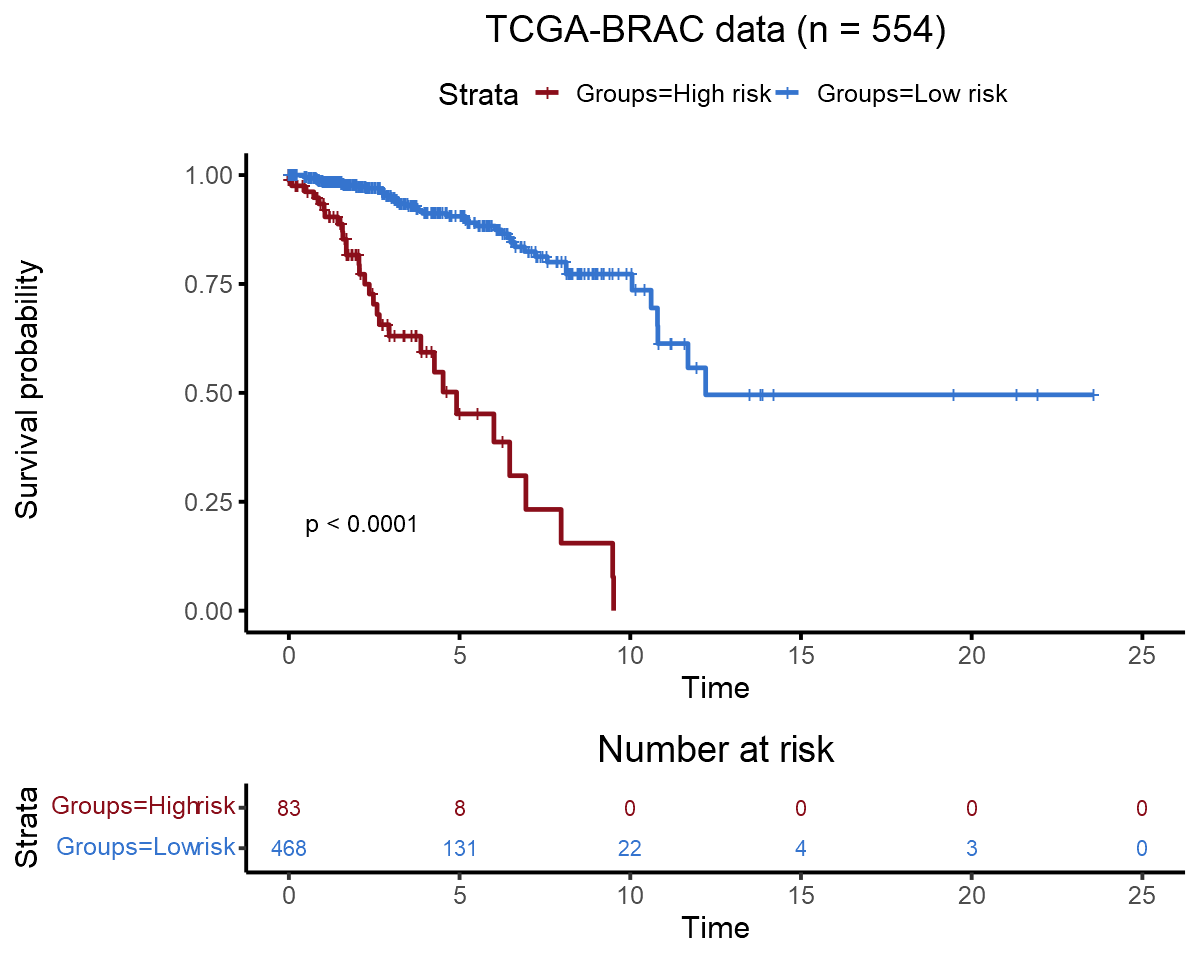

In [42]:
options(repr.plot.width = 10, repr.plot.height = 8)
coefs <- mult.var.cox$coefficients[!is.na(mult.var.cox$coefficients)]
select.sets <- names(coefs)
risk.socres <- coefs %*% t(as.matrix(exprs[train.SN, select.sets]))
sub.clinical.train <- sub.clinical[train.SN, ]
sub.clinical.train$Groups <- as.vector(risk.socres) #> median(risk.socres)
res.cox <- OS.analysis(
    sub.clinical.train, 
    c('#8A0E1A', '#3574CE'), 
    F, 
    cutoff = T, 
    prefix = 'TCGA_selected_genesets_OS_train.pdf',
    out.figs.dir = out.figs.dir,
    title = sprintf('TCGA-BRAC data (n = %g)', dim(sub.clinical.train)[1])
)

In [43]:
fmt <- as.formula('Surv(Time, Sur)~Groups')
sub.clinical.train$Groups <- sub.clinical.train$Groups > res.cox$cutoff
coxph(fmt, data = sub.clinical.train) %>% summary

Call:
coxph(formula = fmt, data = sub.clinical.train)

  n= 552, number of events= 73 
   (因为不存在，2个观察量被删除了)

             coef exp(coef) se(coef)     z Pr(>|z|)    
GroupsTRUE 2.0548    7.8056   0.2519 8.157 3.44e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

           exp(coef) exp(-coef) lower .95 upper .95
GroupsTRUE     7.806     0.1281     4.764     12.79

Concordance= 0.686  (se = 0.034 )
Likelihood ratio test= 55.38  on 1 df,   p=1e-13
Wald test            = 66.53  on 1 df,   p=3e-16
Score (logrank) test = 91.71  on 1 df,   p=<2e-16


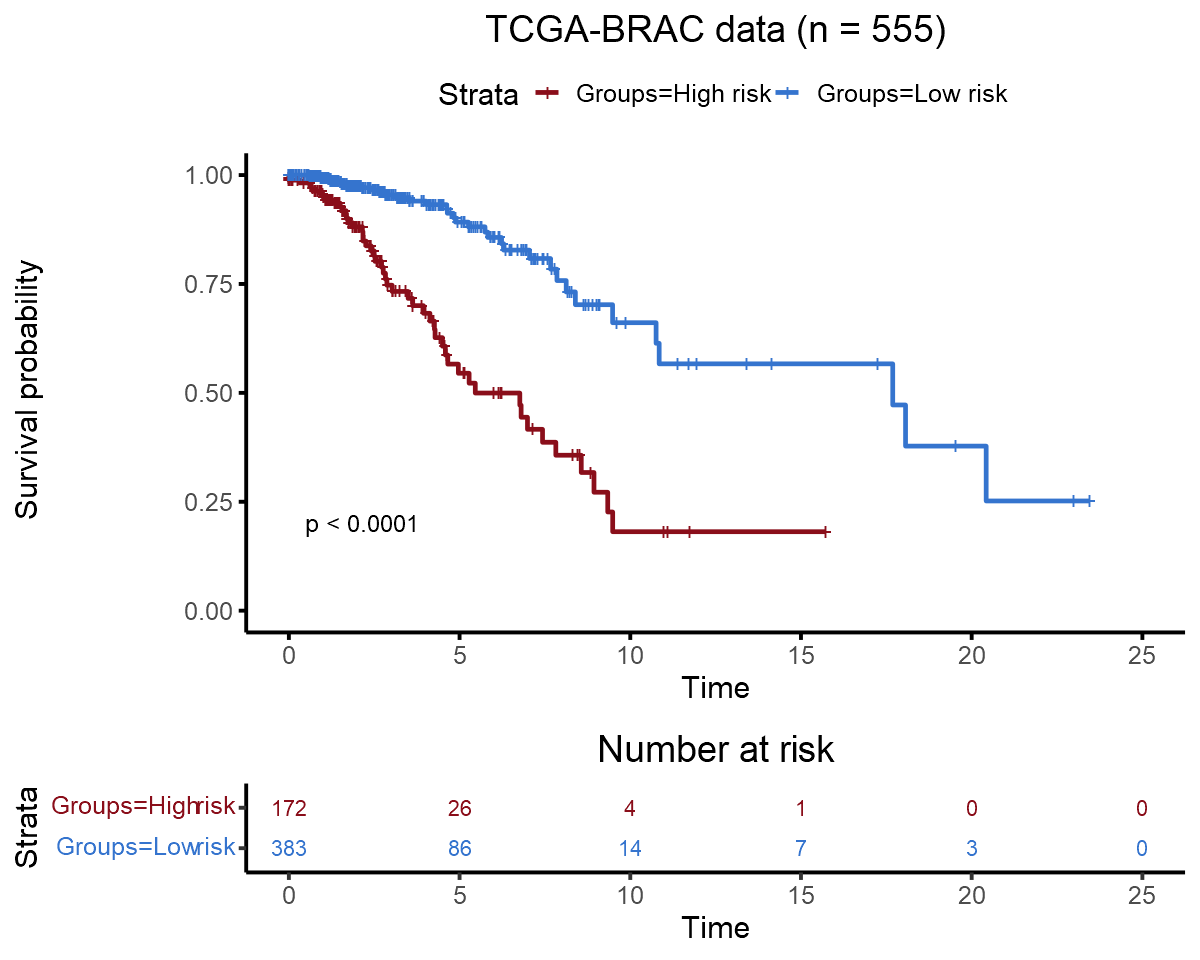

In [44]:
coefs <- mult.var.cox$coefficients[!is.na(mult.var.cox$coefficients)]
select.sets <- names(coefs)
risk.socres <- coefs %*% t(as.matrix(exprs[test.SN, select.sets]))
sub.clinical.test <- sub.clinical[test.SN, ]
sub.clinical.test$Groups <- as.vector(risk.socres) #> median(risk.socres)
res.cox <- OS.analysis(
    sub.clinical.test, 
    c('#8A0E1A', '#3574CE'), 
    F, 
    cutoff = T, 
    prefix = 'TCGA_selected_genesets_OS_test.pdf',
    out.figs.dir = out.figs.dir,
    title = sprintf('TCGA-BRAC data (n = %g)', dim(sub.clinical.test)[1])
)

In [45]:
fmt <- as.formula('Surv(Time, Sur)~Groups')
sub.clinical.test$Groups <- sub.clinical.test$Groups > res.cox$cutoff
coxph(fmt, data = sub.clinical.test) %>% summary

Call:
coxph(formula = fmt, data = sub.clinical.test)

  n= 555, number of events= 83 

            coef exp(coef) se(coef)     z Pr(>|z|)    
GroupsTRUE 1.456     4.288    0.230 6.329 2.47e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

           exp(coef) exp(-coef) lower .95 upper .95
GroupsTRUE     4.288     0.2332     2.732      6.73

Concordance= 0.698  (se = 0.031 )
Likelihood ratio test= 41  on 1 df,   p=2e-10
Wald test            = 40.05  on 1 df,   p=2e-10
Score (logrank) test = 47.53  on 1 df,   p=5e-12


### Adjust coefficients using all data

In [46]:
mult.var.cox <- coxph(formula.fmt, data = dat)
mult.var.cox
saveRDS(mult.var.cox, file = file.path(out.data.dir, 'mult.var.cox.adjusted..rds'))

Call:
coxph(formula = formula.fmt, data = dat)

                     coef exp(coef) se(coef)      z        p
AF131215.8        0.84749   2.33379  0.24526  3.455 0.000549
LINC01235         0.41106   1.50841  0.08869  4.635 3.58e-06
LINC00987        -0.58175   0.55892  0.26067 -2.232 0.025632
LINC00398        -0.30935   0.73392  0.37175 -0.832 0.405323
LINC00667        -0.31513   0.72969  0.16600 -1.898 0.057641
CTD_2554C21.2    -0.40370   0.66784  0.14182 -2.847 0.004419
ZNF888            0.41437   1.51341  0.19110  2.168 0.030137
LL0XNC01_237H1.2  0.75157   2.12034  0.27459  2.737 0.006199
AC016995.3       -0.20816   0.81208  0.13269 -1.569 0.116696
SFTA1P            0.43960   1.55209  0.21394  2.055 0.039904
AL022344.7        1.06178   2.89153  0.37784  2.810 0.004952
LINC00958         0.16076   1.17440  0.13235  1.215 0.224491
LINC00327        -1.26541   0.28212  0.93046 -1.360 0.173835
LINC00346         0.41871   1.52001  0.11903  3.518 0.000435
AC016735.1       -0.22637   0.79742  

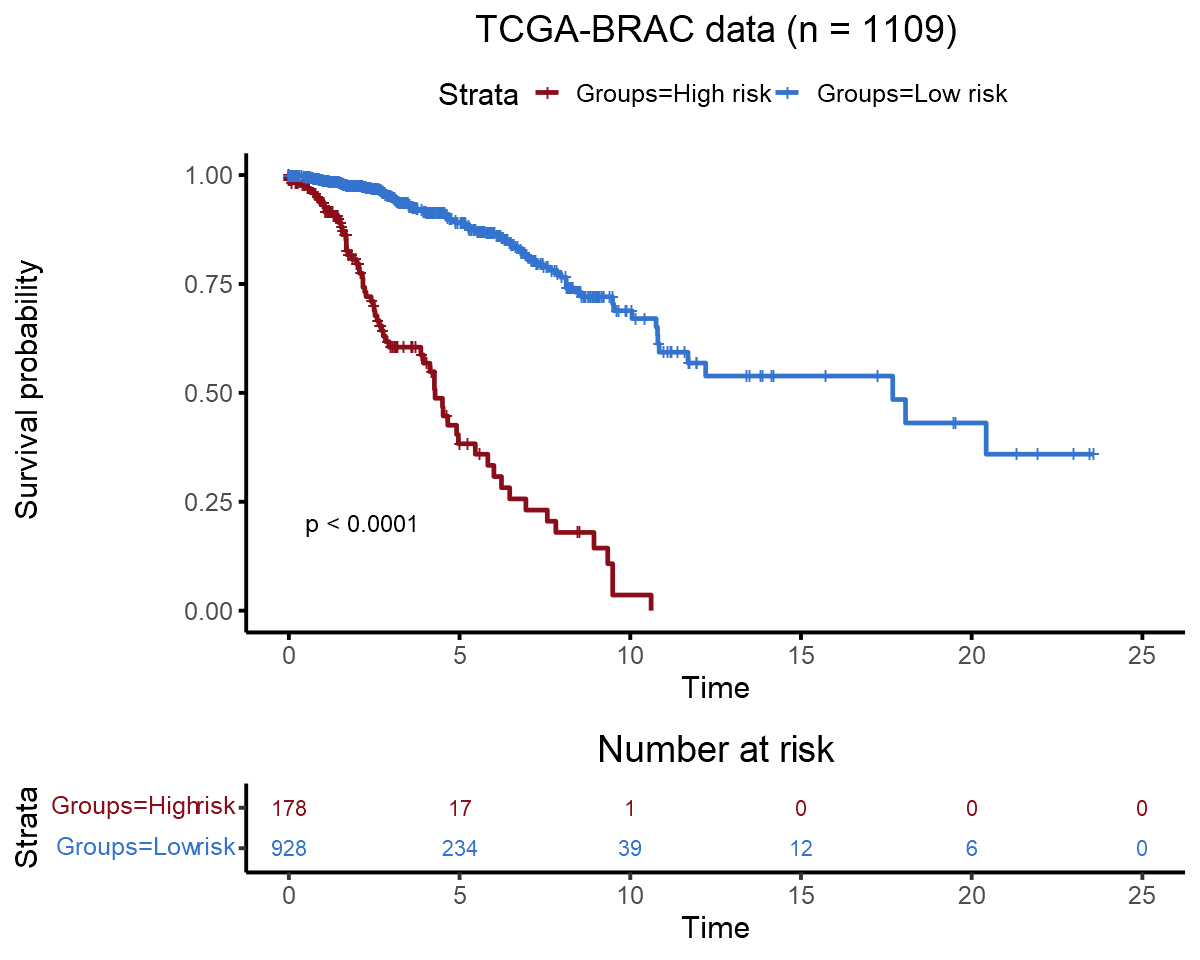

In [47]:
coefs <- mult.var.cox$coefficients[!is.na(mult.var.cox$coefficients)]
select.sets <- names(coefs)
risk.socres <- coefs %*% t(as.matrix(exprs[, select.sets]))
sub.clinical$Groups <- as.vector(risk.socres) #> median(risk.socres)
res.cox <- OS.analysis(
    sub.clinical, 
    c('#8A0E1A', '#3574CE'), 
    F, 
    cutoff = T, 
    prefix = 'TCGA_selected_genesets_OS_all.pdf',
    out.figs.dir = out.figs.dir,
    title = sprintf('TCGA-BRAC data (n = %g)', dim(sub.clinical)[1])
)
#res.cox$group <- ifelse(res.cox$group == FALSE, 'High risk', 'Low risk')
#res.cox$cut.off <- median(risk.socres)

In [48]:
fmt <- as.formula('Surv(Time, Sur)~Groups')
sub.clinical$Groups <- sub.clinical$Groups > res.cox$cutoff
coxph(fmt, data = sub.clinical) %>% summary

Call:
coxph(formula = fmt, data = sub.clinical)

  n= 1107, number of events= 156 
   (因为不存在，2个观察量被删除了)

             coef exp(coef) se(coef)     z Pr(>|z|)    
GroupsTRUE 2.0175    7.5194   0.1686 11.97   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

           exp(coef) exp(-coef) lower .95 upper .95
GroupsTRUE     7.519      0.133     5.404     10.46

Concordance= 0.694  (se = 0.023 )
Likelihood ratio test= 120  on 1 df,   p=<2e-16
Wald test            = 143.3  on 1 df,   p=<2e-16
Score (logrank) test = 196  on 1 df,   p=<2e-16


In [49]:
head(sub.clinical)

patient      vital_status days_to_death
TCGA-E2-A15G-01A-11R-A12D-07 TCGA-E2-A15G Alive          NA         
TCGA-E2-A1B5-01A-21R-A12P-07 TCGA-E2-A1B5 Alive          NA         
TCGA-EW-A2FS-01A-11R-A17B-07 TCGA-EW-A2FS Alive          NA         
TCGA-EW-A1P7-01A-21R-A144-07 TCGA-EW-A1P7 Alive          NA         
TCGA-LL-A5YO-01A-21R-A28M-07 TCGA-LL-A5YO Alive          NA         
TCGA-BH-A1FN-01A-11R-A13Q-07 TCGA-BH-A1FN Dead         2192         
                             days_to_last_follow_up Sur   Time     Groups
TCGA-E2-A15G-01A-11R-A12D-07  554                   FALSE 1.517808 FALSE 
TCGA-E2-A1B5-01A-21R-A12P-07  984                   FALSE 2.695890 FALSE 
TCGA-EW-A2FS-01A-11R-A17B-07 1604                   FALSE 4.394521 FALSE 
TCGA-EW-A1P7-01A-21R-A144-07  915                   FALSE 2.506849 FALSE 
TCGA-LL-A5YO-01A-21R-A28M-07  440                   FALSE 1.205479 FALSE 
TCGA-BH-A1FN-01A-11R-A13Q-07   NA                    TRUE 6.005479  TRUE

In [50]:
dim(subset(sub.clinical, Groups == T & Time > 3 & vital_status == 'Dead'))[1] / dim(subset(sub.clinical, Groups == T & vital_status == 'Dead'))[1]

[1] 0.358209

In [51]:
dim(subset(sub.clinical, Groups == F & Time > 3 & vital_status == 'Dead'))[1] / dim(subset(sub.clinical, Groups == F & vital_status == 'Dead'))[1]

[1] 0.6444444

In [52]:
roc.res.5 <- survivalROC(Stime = sub.clinical$Time, status = sub.clinical$Sur, marker = risk.socres, predict.time = 5, method = 'KM')
roc.res.3 <- survivalROC(Stime = sub.clinical$Time, status = sub.clinical$Sur, marker = risk.socres, predict.time = 3, method = 'KM')
roc.res.10 <- survivalROC(Stime = sub.clinical$Time, status = sub.clinical$Sur, marker = risk.socres, predict.time = 10, method = 'KM')


 2 records with missing values dropped. 

 2 records with missing values dropped. 

 2 records with missing values dropped. 


In [53]:
pdf(file.path(out.figs.dir, 'roc.5vs3.years.pdf'), width = 8, height = 8)
plot(roc.res.5$FP, roc.res.5$TP, type = 'l', xlim = c(0, 1), ylim = c(0, 1), xlab = paste('1 - specificity'), ylab = 'Sensitivity', col = 'yellow', lwd = 2, cex.lab = 1.5, cex.axis = 1.5)
abline(0, 1, lwd = 2, lty = 'dashed')
box(lwd = 2)

par(new = TRUE)
plot(roc.res.3$FP, roc.res.3$TP, type = 'l', xlim = c(0, 1), ylim = c(0, 1), xlab = '', ylab = '', col = 'darkgreen', lwd = 2, xaxt = 'n', yaxt = 'n')
legend(0.35, 0.2, legend = c(sprintf('5-year ROC (AUC = %g)', round(roc.res.5$AUC, 3)), sprintf('3-year ROC (AUC = %g)', round(roc.res.3$AUC, 3))), col = c("yellow", "darkgreen"), lty = 1, cex = 1.5, lwd = 3, bty = 'n')
dev.off()

png 
  2

### Univariate cox regression of 13 genes

In [54]:
exprs.sub <- exprs[, hub.genes.sub]
head(exprs.sub)[, 1 : 10]

AF131215.8 LINC01235 LINC00987 LINC00398 LINC00667
TCGA-E2-A15G-01A-11R-A12D-07 0.1270039  0.3151554 0.6017985 0.6327797 2.527675 
TCGA-E2-A1B5-01A-21R-A12P-07 0.3063988  0.9220029 1.5484011 0.1935985 1.779815 
TCGA-EW-A2FS-01A-11R-A17B-07 0.1862594  0.5951290 1.1854779 0.2378498 2.098742 
TCGA-EW-A1P7-01A-21R-A144-07 0.3759908  3.0392353 1.8106939 0.1448384 2.960917 
TCGA-LL-A5YO-01A-21R-A28M-07 0.2013102  2.2819006 0.4478722 0.1594376 2.788373 
TCGA-BH-A1FN-01A-11R-A13Q-07 0.2523297  1.2883921 0.3277982 0.1367585 2.211886 
                             CTD_2554C21.2 ZNF888    LL0XNC01_237H1.2
TCGA-E2-A15G-01A-11R-A12D-07 1.9468146     1.2731744 1.0773688       
TCGA-E2-A1B5-01A-21R-A12P-07 0.2372294     0.3825106 0.2789045       
TCGA-EW-A2FS-01A-11R-A17B-07 0.6233850     0.8206887 0.4867726       
TCGA-EW-A1P7-01A-21R-A144-07 2.6732052     0.9016777 0.4734871       
TCGA-LL-A5YO-01A-21R-A28M-07 0.5363022     1.2295638 0.2471743       
TCGA-BH-A1FN-01A-11R-A13Q-07 1.5844518     2.0234407 0.7448843       
                             AC016995.3 SFTA1P   
TCGA-E2-A15G-01A-11R-A12D-07 0.2732504  0.3535274
TCGA-E2-A1B5-01A-21R-A12P-07 0.9050483  0.5616873
TCGA-EW-A2FS-01A-11R-A17B-07 0.5810859  0.4586515
TCGA-EW-A1P7-01A-21R-A144-07 2.4051563  0.6672513
TCGA-LL-A5YO-01A-21R-A28M-07 0.4428419  0.2670334
TCGA-BH-A1FN-01A-11R-A13Q-07 0.1062545  0.1943177

In [55]:
sub.clinical.expr <- cbind.data.frame(sub.clinical, exprs.sub)

In [56]:
fmt <- as.formula('Surv(Time, Sur)~Groups')
univ.models <- lapply(hub.genes.sub, function(x){ 
    sub.clinical.expr$Groups <- sub.clinical.expr[, x]
    res.cox <- OS.analysis(sub.clinical.expr, NULL, T, cutoff = T, prefix = NULL)
    sub.clinical.expr$Groups <- sub.clinical.expr$Groups <= res.cox$cut.off
    coxph(fmt, data = sub.clinical.expr)
})                        

In [57]:
names(univ.models) <- hub.genes.sub

In [58]:
univ.results <- lapply(univ.models, function(x){
    x <- summary(x)
    p.value <- signif(x$wald["pvalue"], digits = 2)
    HR <-signif(x$coef[2], digits = 2)
    lower.95 <- signif(x$conf.int[,"lower .95"], 2)
    upper.95 <- signif(x$conf.int[,"upper .95"], 2)
    conf <- paste0(HR, " (", lower.95, "-", upper.95, ")")
    res <- c(HR, lower.95, upper.95, conf, p.value)
    return(res)
}) %>% as.data.frame %>% t

rownames(univ.results) <- hub.genes.sub

colnames(univ.results) <- c('HR', 'lower.95', 'upper.95', 'conf', 'p.value')
plot.res <- cbind.data.frame(charac = rownames(univ.results), univ.results)

plot.res[, 2] <- as.numeric(plot.res[, 2]) %>% { log2(1 + .) }
plot.res[, 3] <- as.numeric(plot.res[, 3]) %>% { log2(1 + .) }
plot.res[, 4] <- as.numeric(plot.res[, 4]) %>% { log2(1 + .) }
plot.res[, 6] <- as.numeric(plot.res[, 6])
plot.res <- plot.res[order(plot.res$p.value), ]
plot.res['TGCT', 'upper.95'] <- 1

pdf(file.path(out.figs.dir, 'traning.hub.genes.forestplot.pdf'), width = 8, height = 10)
forestplot(
    plot.res[, c(1, 5, 6)],
    mean = plot.res[, 2],
    lower = plot.res[, 3],
    upper = plot.res[, 4],
    zero = 1,
    col=fpColors(box="darkblue", lines="black", zero = "gray50"),
    boxsize = 0.3,
    graph.pos = 2
)
dev.off()

png 
  2

### Compare with other clinical features

In [1328]:
select.lab <- c('age_at_index', 'paper_BRCA_Subtype_PAM50', 'paper_pathologic_stage')
dat <- tcga.obj.sub@meta.data[ , select.lab]
dat <- cbind.data.frame(Group = ifelse(res.cox$group == 'High risk', 1, 0), dat)
dat$age_at_index <- as.numeric(dat$age_at_index)
dat$age_at_index <- ifelse(dat$age_at_index > 60, 1, 0)

dat <- subset(dat, !is.na(paper_BRCA_Subtype_PAM50))
dat$paper_BRCA_Subtype_PAM50 <- factor(dat$paper_BRCA_Subtype_PAM50, levels = c('Basal', 'LumA', 'LumB', 'Her2', 'Normal'))

dat <- subset(dat, paper_pathologic_stage != 'NA')
dat$paper_pathologic_stage  <- factor( dat$paper_pathologic_stage, levels = c("Stage_I", "Stage_II", "Stage_III", "Stage_IV"))

head(dat)

Group age_at_index paper_BRCA_Subtype_PAM50
TCGA-E2-A15G-01A-11R-A12D-07 0     1            LumA                    
TCGA-E2-A1B5-01A-21R-A12P-07 0     0            LumA                    
TCGA-EW-A2FS-01A-11R-A17B-07 0     0            LumA                    
TCGA-EW-A1P7-01A-21R-A144-07 0     0            Normal                  
TCGA-LL-A5YO-01A-21R-A28M-07 0     0            Her2                    
TCGA-BH-A1FN-01A-11R-A13Q-07 1     0            LumB                    
                             paper_pathologic_stage
TCGA-E2-A15G-01A-11R-A12D-07 Stage_II              
TCGA-E2-A1B5-01A-21R-A12P-07 Stage_II              
TCGA-EW-A2FS-01A-11R-A17B-07 Stage_II              
TCGA-EW-A1P7-01A-21R-A144-07 Stage_II              
TCGA-LL-A5YO-01A-21R-A28M-07 Stage_I               
TCGA-BH-A1FN-01A-11R-A13Q-07 Stage_II

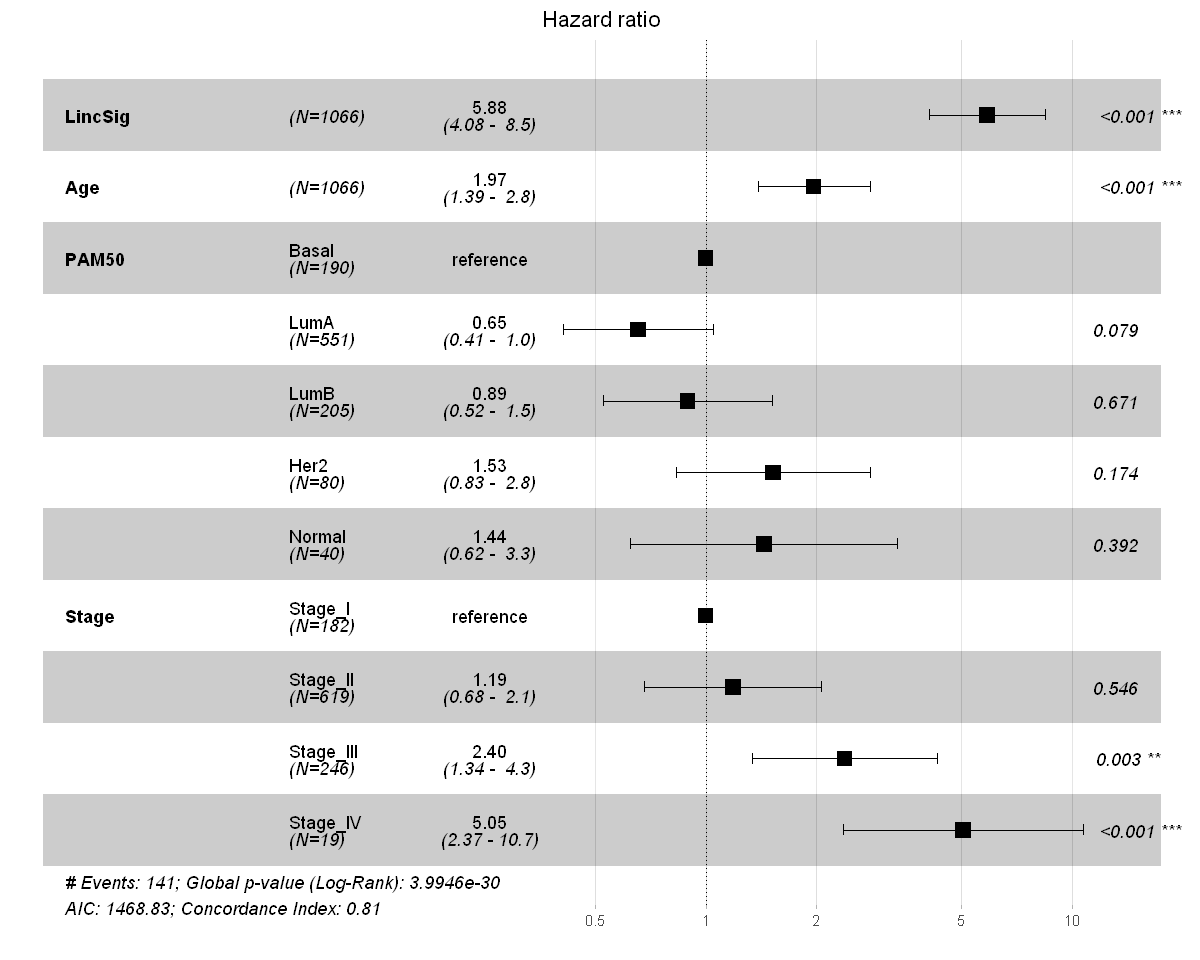

In [1329]:
select.lab <- c('age_at_index', 'paper_BRCA_Subtype_PAM50', 'paper_pathologic_stage')
dat <- tcga.obj.sub@meta.data[ , select.lab]
dat <- cbind.data.frame(Group = ifelse(res.cox$group == 'High risk', 1, 0), dat)
dat$age_at_index <- as.numeric(dat$age_at_index)
dat$age_at_index <- ifelse(dat$age_at_index > 60, 1, 0)

dat <- subset(dat, !is.na(paper_BRCA_Subtype_PAM50))
dat$paper_BRCA_Subtype_PAM50 <- factor(dat$paper_BRCA_Subtype_PAM50, levels = c('Basal', 'LumA', 'LumB', 'Her2', 'Normal'))

dat <- subset(dat, paper_pathologic_stage != 'NA')
dat$paper_pathologic_stage  <- factor( dat$paper_pathologic_stage, levels = c("Stage_I", "Stage_II", "Stage_III", "Stage_IV"))

colnames(dat) <- c('LincSig', 'Age', 'PAM50', 'Stage')

dat.new <- cbind.data.frame(sub.clinical[rownames(dat), ], dat)
formula.fmt <- as.formula(paste0('Surv(Time, Sur)~', paste(colnames(dat), sep = ' ', collapse = '+')))

mult.var.cox <- coxph(formula.fmt, data = dat.new)
ggforest(mult.var.cox, data = dat.new, fontsize = 1)

ggsave(file.path(out.figs.dir, 'ggforest_riskscore_vs_others.pdf'), width = 8, height = 8)
saveRDS(mult.var.cox, file = file.path(out.data.dir, 'mult.var.cox.clini.charac.rds'))

In [1330]:
head(dat.new)

patient      vital_status days_to_death
TCGA-E2-A15G-01A-11R-A12D-07 TCGA-E2-A15G Alive          NA         
TCGA-E2-A1B5-01A-21R-A12P-07 TCGA-E2-A1B5 Alive          NA         
TCGA-EW-A2FS-01A-11R-A17B-07 TCGA-EW-A2FS Alive          NA         
TCGA-EW-A1P7-01A-21R-A144-07 TCGA-EW-A1P7 Alive          NA         
TCGA-LL-A5YO-01A-21R-A28M-07 TCGA-LL-A5YO Alive          NA         
TCGA-BH-A1FN-01A-11R-A13Q-07 TCGA-BH-A1FN Dead         2192         
                             days_to_last_follow_up Sur   Time     Groups    
TCGA-E2-A15G-01A-11R-A12D-07  554                   FALSE 1.517808  0.2203707
TCGA-E2-A1B5-01A-21R-A12P-07  984                   FALSE 2.695890 -1.1014146
TCGA-EW-A2FS-01A-11R-A17B-07 1604                   FALSE 4.394521 -0.3787754
TCGA-EW-A1P7-01A-21R-A144-07  915                   FALSE 2.506849 -0.8431213
TCGA-LL-A5YO-01A-21R-A28M-07  440                   FALSE 1.205479  0.6170595
TCGA-BH-A1FN-01A-11R-A13Q-07   NA                    TRUE 6.005479  1.7747969
                             LincSig Age PAM50  Stage   
TCGA-E2-A15G-01A-11R-A12D-07 0       1   LumA   Stage_II
TCGA-E2-A1B5-01A-21R-A12P-07 0       0   LumA   Stage_II
TCGA-EW-A2FS-01A-11R-A17B-07 0       0   LumA   Stage_II
TCGA-EW-A1P7-01A-21R-A144-07 0       0   Normal Stage_II
TCGA-LL-A5YO-01A-21R-A28M-07 0       0   Her2   Stage_I 
TCGA-BH-A1FN-01A-11R-A13Q-07 1       0   LumB   Stage_II

In [1331]:
univ.models <- lapply(c('LincSig', 'Age', 'PAM50', 'Stage'), function(x){ 
    fmt <- as.formula(paste0('Surv(Time, Sur)~', x))
    coxph(fmt, data = dat.new) %>% summary
})      
names(univ.models) <- c('LincSig', 'Age', 'PAM50', 'Stage')
saveRDS(univ.models, file = file.path(out.data.dir, 'univ.clinical.models.rds'))

In [1332]:
univ.models

$LincSig
Call:
coxph(formula = fmt, data = dat.new)

  n= 1065, number of events= 141 
   (因为不存在，1个观察量被删除了)

          coef exp(coef) se(coef)     z Pr(>|z|)    
LincSig 2.0585    7.8341   0.1781 11.56   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

        exp(coef) exp(-coef) lower .95 upper .95
LincSig     7.834     0.1276     5.526     11.11

Concordance= 0.694  (se = 0.024 )
Likelihood ratio test= 111.2  on 1 df,   p=<2e-16
Wald test            = 133.6  on 1 df,   p=<2e-16
Score (logrank) test = 184.6  on 1 df,   p=<2e-16


$Age
Call:
coxph(formula = fmt, data = dat.new)

  n= 1065, number of events= 141 
   (因为不存在，1个观察量被删除了)

      coef exp(coef) se(coef)     z Pr(>|z|)    
Age 0.8197    2.2699   0.1720 4.766 1.88e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

    exp(coef) exp(-coef) lower .95 upper .95
Age      2.27     0.4405      1.62      3.18

Concordance= 0.62  (se = 0.023 )
Likelihood ratio test= 22.94  on 1 df

### Rank score from low to high, and visualized by bar and scatter plots

In [1333]:
sub.clinical.scores <- cbind.data.frame(sub.clinical, Score = t(risk.socres), Class = res.cox$group)
sub.clinical.scores.ordered <- sub.clinical.scores[order(sub.clinical.scores$Score), ]
head(sub.clinical.scores.ordered)

patient      vital_status days_to_death
TCGA-A7-A13D-01B-04R-A277-07 TCGA-A7-A13D Alive        NA           
TCGA-A7-A26J-01B-02R-A277-07 TCGA-A7-A26J Alive        NA           
TCGA-E9-A22G-01A-11R-A157-07 TCGA-E9-A22G Alive        NA           
TCGA-A2-A04U-01A-11R-A115-07 TCGA-A2-A04U Alive        NA           
TCGA-B6-A0I2-01A-11R-A034-07 TCGA-B6-A0I2 Alive        NA           
TCGA-AR-A0U4-01A-11R-A109-07 TCGA-AR-A0U4 Alive        NA           
                             days_to_last_follow_up Sur   Time      Groups   
TCGA-A7-A13D-01B-04R-A277-07  965                   FALSE  2.643836 -4.041655
TCGA-A7-A26J-01B-02R-A277-07  627                   FALSE  1.717808 -4.013849
TCGA-E9-A22G-01A-11R-A157-07 1239                   FALSE  3.394521 -3.502837
TCGA-A2-A04U-01A-11R-A115-07 2654                   FALSE  7.271233 -3.295690
TCGA-B6-A0I2-01A-11R-A034-07 4361                   FALSE 11.947945 -3.145192
TCGA-AR-A0U4-01A-11R-A109-07 3261                   FALSE  8.934247 -2.790738
                             Score     Class   
TCGA-A7-A13D-01B-04R-A277-07 -4.041655 Low risk
TCGA-A7-A26J-01B-02R-A277-07 -4.013849 Low risk
TCGA-E9-A22G-01A-11R-A157-07 -3.502837 Low risk
TCGA-A2-A04U-01A-11R-A115-07 -3.295690 Low risk
TCGA-B6-A0I2-01A-11R-A034-07 -3.145192 Low risk
TCGA-AR-A0U4-01A-11R-A109-07 -2.790738 Low risk

In [1334]:
sub.clinical.scores.ordered$patient <- rownames(sub.clinical.scores.ordered)
sub.clinical.scores.ordered$patient <- factor(sub.clinical.scores.ordered$patient, level = sub.clinical.scores.ordered$patient)
sub.clinical.scores.ordered <- sub.clinical.scores.ordered[!is.na(sub.clinical.scores.ordered$Sur), ]

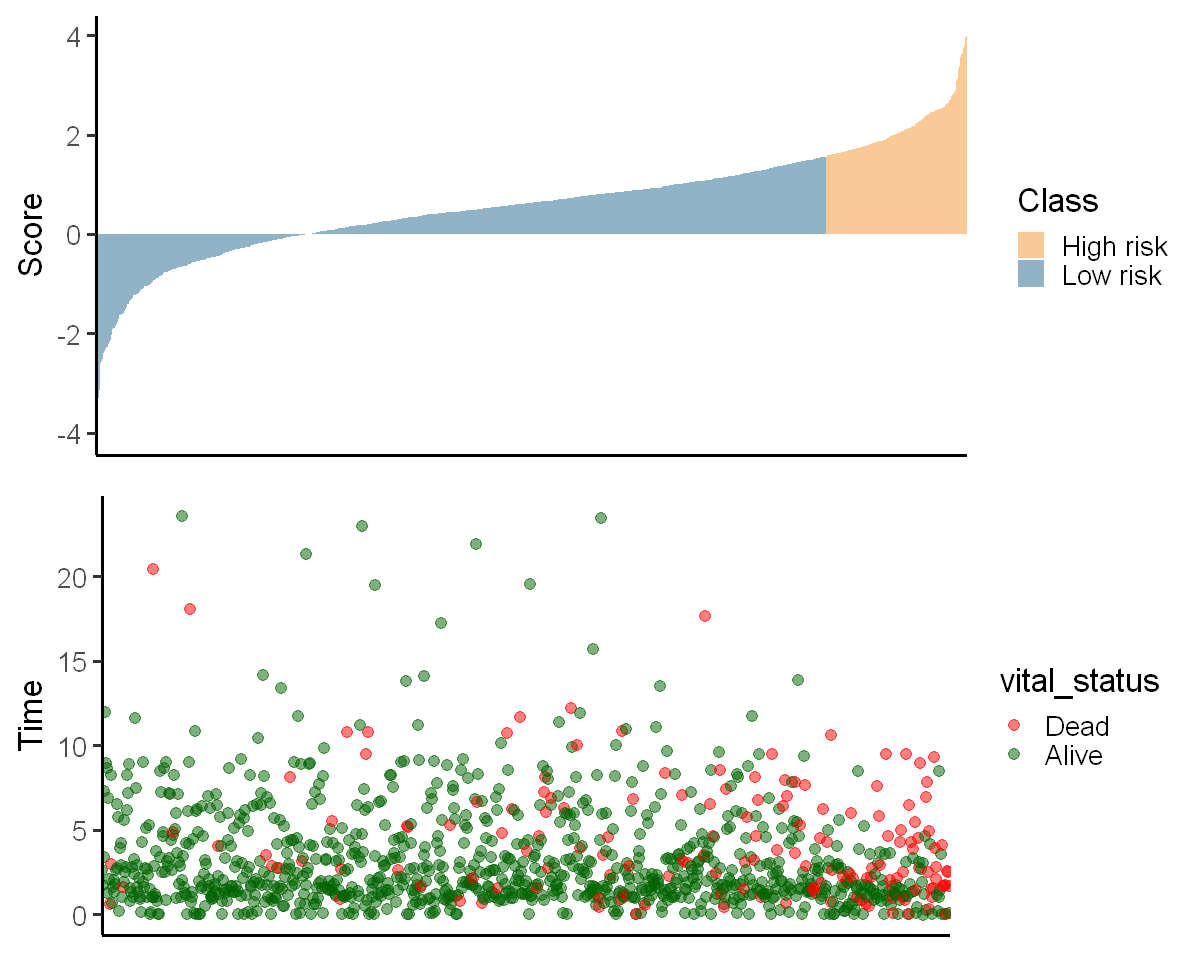

In [1335]:
sub.clinical.scores.ordered$patient <- factor(sub.clinical.scores.ordered$patient, level = sub.clinical.scores.ordered$patient)
cols <- PAIRWISE_COLORS %>% unlist
names(cols) <- c('High risk', 'Low risk')
gp1 <- ggplot(
    data = sub.clinical.scores.ordered, 
    aes(x = patient, y = Score, fill = Class)) + 
    geom_bar(stat = 'identity') + 
    theme_bw(base_size = 20) + 
    theme(
        panel.border = element_blank(),  
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.text.x = element_blank(), 
        axis.line.x = element_line(),
        axis.title.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.line.y = element_line(colour = 'black')
    ) + scale_fill_manual(values = cols)

cols <- c('red', 'darkgreen')
names(cols) <- c('Dead', 'Alive')
gp2 <- ggplot(
    data = sub.clinical.scores.ordered, 
    aes(x = patient, y = Time, color = vital_status)) + 
    geom_point(size = 3, alpha = 0.5) + 
    theme_bw(base_size = 20) + 
    theme(
        panel.border = element_blank(),  
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.text.x = element_blank(), 
        axis.line.x = element_line(),
        axis.ticks.x=element_blank(),
        axis.title.x = element_blank(),
        axis.line.y = element_line(colour = 'black')
    ) + scale_color_manual(values = cols)
ggarrange(gp1, gp2, nrow = 2) 
ggsave(file.path(out.figs.dir, 'risk.score.ordered.pdf'), height = 6, width = 8)

### Expression analysis of LincSigs

In [875]:
expr.pf <- FetchData(tcga.obj.sub, vars = gsub('_', '-', hub.genes.sub)) %>% { log2(1 + .) }
expr.pf <- cbind.data.frame(expr.pf, Group = tcga.obj.sub@meta.data$sample_type)
expr.pf[rownames(sub.clinical), 'Group'] <- res.cox$group
dim(expr.pf)

[1] 1109   30

In [876]:
table(expr.pf$Group)
expr.pf <- tidyr::gather(expr.pf, 'Gene', 'Expr', -Group)


High risk  Low risk 
      179       930 

In [877]:
head(expr.pf)
expr.pf$Gene <- factor(expr.pf$Gene, levels = gsub('_', '-', hub.genes.sub))

Group     Gene       Expr     
1 Low risk  AF131215.8 0.1270039
2 Low risk  AF131215.8 0.3063988
3 Low risk  AF131215.8 0.1862594
4 Low risk  AF131215.8 0.3759908
5 Low risk  AF131215.8 0.2013102
6 High risk AF131215.8 0.2523297

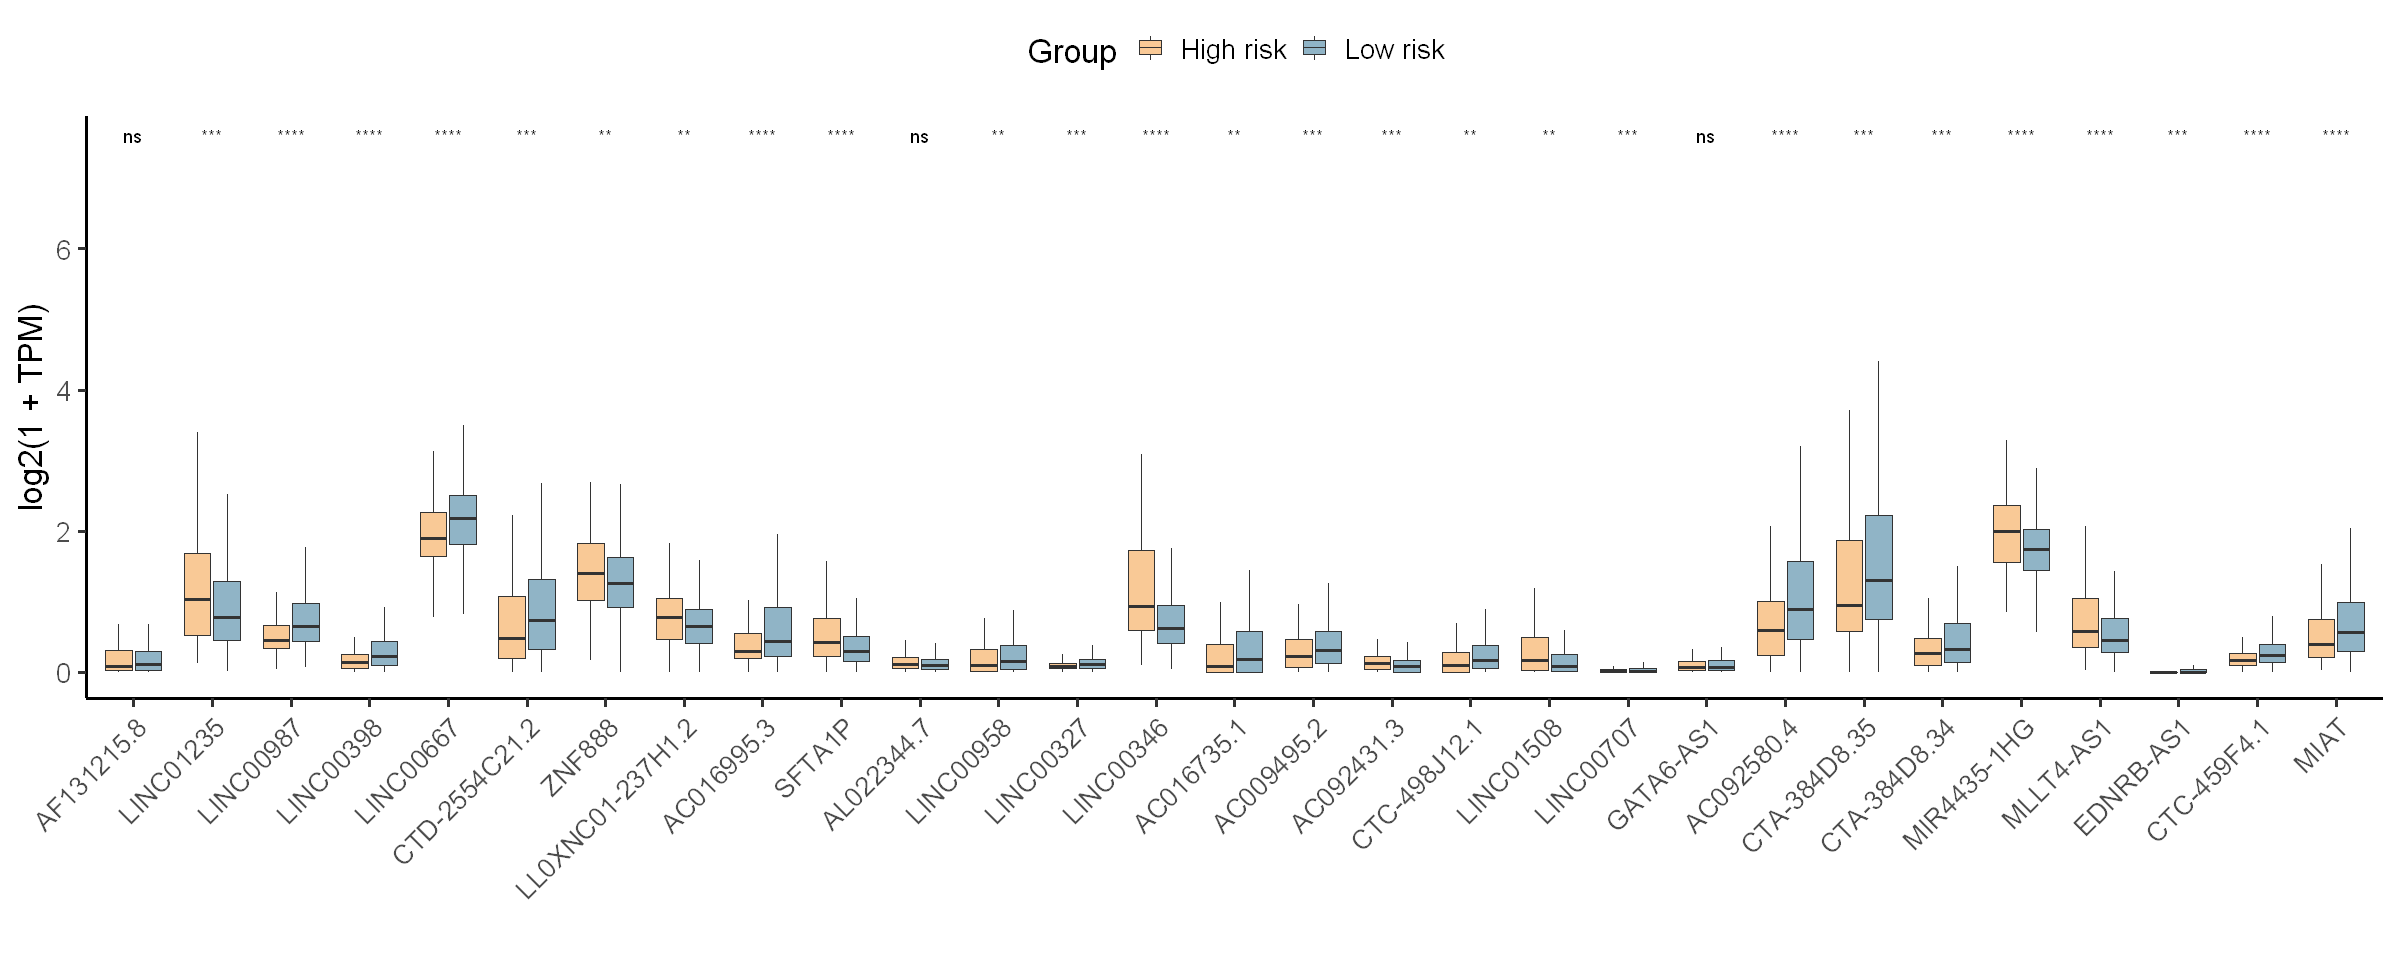

In [879]:
options(repr.plot.width = 20, repr.plot.height = 8)
cols <- unlist(PAIRWISE_COLORS)
names(cols) <- c('High risk', 'Low risk')
ggplot(data = expr.pf, aes(x = Gene, y = Expr, fill = Group)) + 
    geom_boxplot(outlier.shape = NA) + 
    theme_classic(base_size = 20) + 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),legend.position="top") + 
    scale_fill_manual(values = cols) + ylab('log2(1 + TPM)') + xlab('') +
    stat_compare_means(aes(group = Group), label = "p.signif")
ggsave(file.path(out.figs.dir, 'expr.lincgenes.boxplot.pdf'), width = 12, height = 6)

In [1340]:
tcga.obj@meta.data$sample_type %>% unique

[1] "Primary Tumor"       "Metastatic"          "Solid Tissue Normal"

In [1341]:
expr.pf <- FetchData(tcga.obj, vars = gsub('_', '-', hub.genes.sub)) %>% { log2(1 + .) }
expr.pf <- cbind.data.frame(expr.pf, Group = ifelse(tcga.obj@meta.data$sample_type == 'Solid Tissue Normal', 'Normal', 'Tumor'))

dim(expr.pf)
table(expr.pf$Group)
expr.pf <- tidyr::gather(expr.pf, 'Gene', 'Expr', -Group)

head(expr.pf)
expr.pf$Gene <- factor(expr.pf$Gene, levels = gsub('_', '-', hub.genes.sub))   

[1] 1222   26


Normal  Tumor 
   113   1109 

Group Gene      Expr     
1 Tumor LINC01235 0.3151554
2 Tumor LINC01235 0.9220029
3 Tumor LINC01235 0.5951290
4 Tumor LINC01235 3.0392353
5 Tumor LINC01235 2.2819006
6 Tumor LINC01235 1.2883921

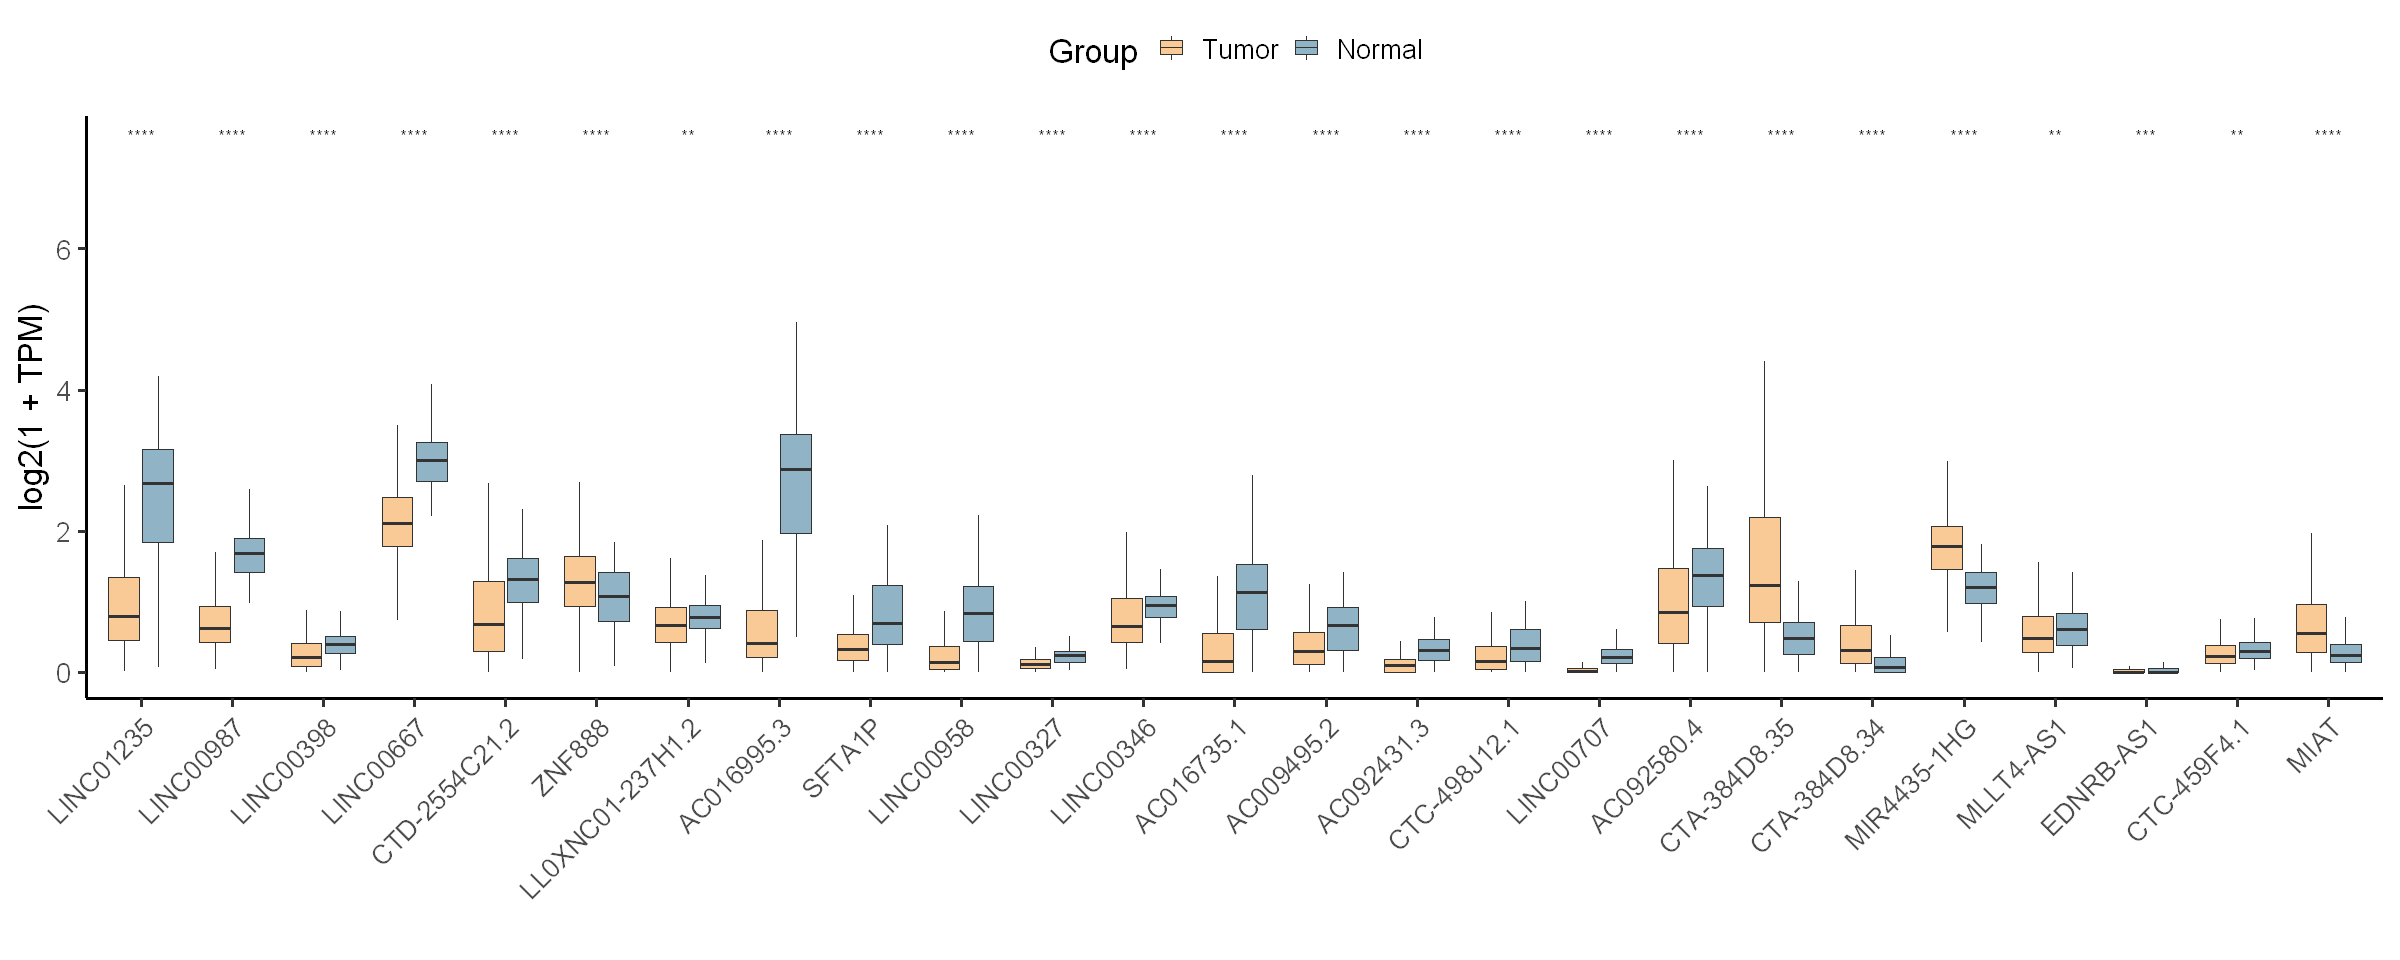

In [1342]:
expr.pf$Group <- factor(expr.pf$Group, levels = c('Tumor', 'Normal'))
options(repr.plot.width = 20, repr.plot.height = 8)
cols <- unlist(PAIRWISE_COLORS)
names(cols) <- c('Tumor', 'Normal')
ggplot(data = expr.pf, aes(x = Gene, y = Expr, fill = Group)) + 
    geom_boxplot(outlier.shape = NA) + 
    theme_classic(base_size = 20) + 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),legend.position="top") + 
    scale_fill_manual(values = cols) + ylab('log2(1 + TPM)') + xlab('') +
    stat_compare_means(aes(group = Group), label = "p.signif")
ggsave(file.path(out.figs.dir, 'expr.lincgenes.normal.vs.tumor.boxplot.pdf'), width = 10, height = 6)

In [1343]:
exhau.expr <- FetchData(tcga.obj.sub, vars = c('CD247', 'PDCD1', 'CTLA4', 'HAVCR2', 'LAG3'))
head(exhau.expr)

CD247      PDCD1      CTLA4      HAVCR2   
TCGA-E2-A15G-01A-11R-A12D-07  0.2688011  0.0923282 0.04091862  3.392136
TCGA-E2-A1B5-01A-21R-A12P-07 14.4774895  3.0686221 3.68244612  5.819615
TCGA-EW-A2FS-01A-11R-A17B-07  1.3766969  1.4287495 1.34810875  2.480183
TCGA-EW-A1P7-01A-21R-A144-07  8.0310264  2.7789670 2.72597001  4.844353
TCGA-LL-A5YO-01A-21R-A28M-07 10.7730938 10.7545282 7.52808707 10.144256
TCGA-BH-A1FN-01A-11R-A13Q-07  0.2679786  0.1917619 0.44617809  5.050139
                             LAG3     
TCGA-E2-A15G-01A-11R-A12D-07 0.2341841
TCGA-E2-A1B5-01A-21R-A12P-07 3.2236322
TCGA-EW-A2FS-01A-11R-A17B-07 1.4346915
TCGA-EW-A1P7-01A-21R-A144-07 2.4295641
TCGA-LL-A5YO-01A-21R-A28M-07 9.1889358
TCGA-BH-A1FN-01A-11R-A13Q-07 1.1791293

In [1344]:
exh.pf <- cbind.data.frame(exhau.expr, Score = as.vector(risk.socres))
exh.pf <- tidyr::gather(exh.pf, 'Gene', 'Expr', -Score)
exh.pf$Gene <- factor(exh.pf$Gene, levels = c('CD247', 'PDCD1', 'CTLA4', 'HAVCR2', 'LAG3'))
head(exh.pf)

Score      Gene  Expr      
1  0.2203707 CD247  0.2688011
2 -1.1014146 CD247 14.4774895
3 -0.3787754 CD247  1.3766969
4 -0.8431213 CD247  8.0310264
5  0.6170595 CD247 10.7730938
6  1.7747969 CD247  0.2679786

`geom_smooth()` using formula 'y ~ x'



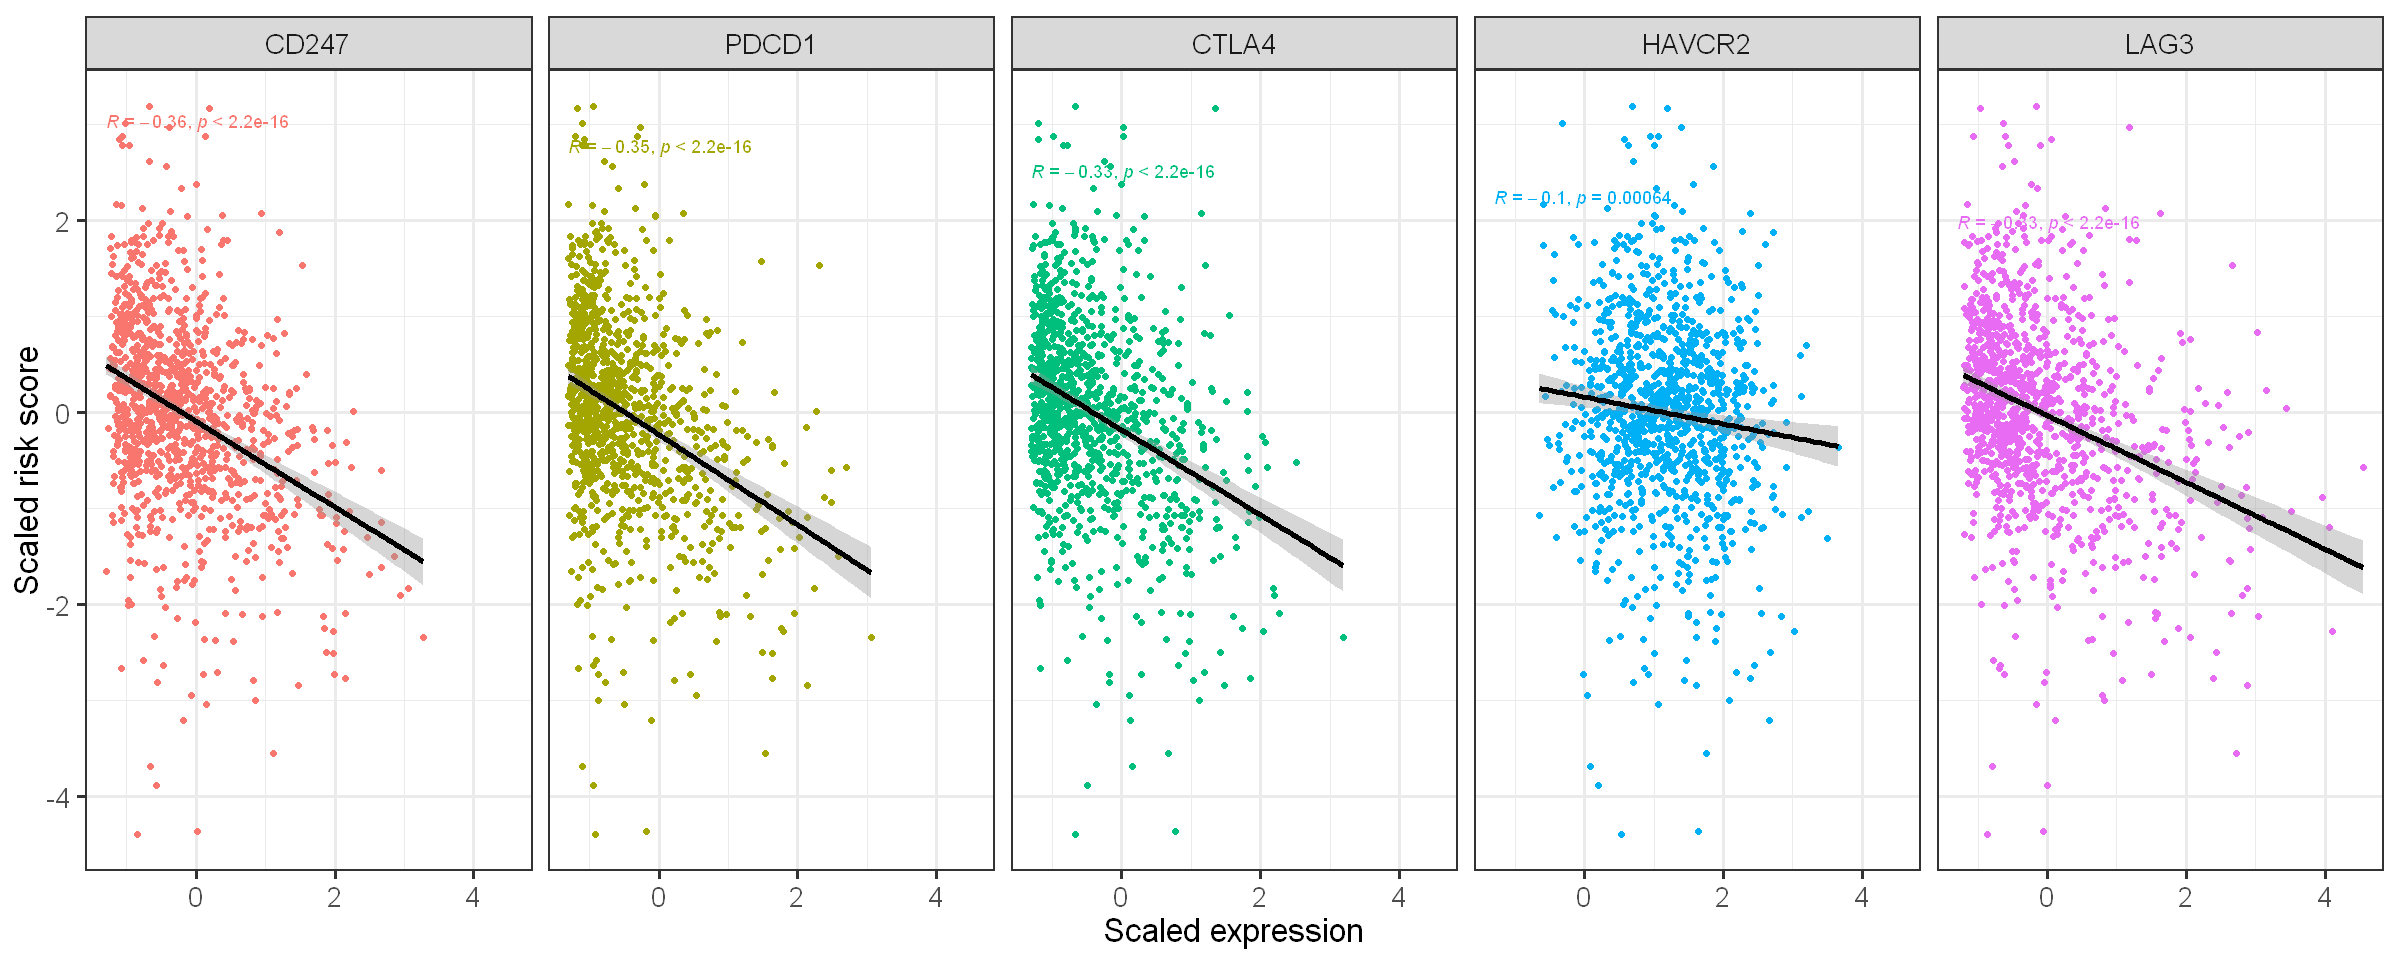

In [1345]:
gpp <- ggplot(exh.pf, aes(x = scale(log2(1 + Expr)), y = scale(Score), color = Gene)) + geom_point() + facet_wrap(~Gene, ncol = 5) + geom_smooth(method = "lm", se = T, color = 'black', lwd = 1.5) + stat_cor(method="pearson")  + theme_bw(base_size = 20) + theme(legend.position = 'none') +
xlab('Scaled expression') + ylab('Scaled risk score')
gpp

In [1346]:
exh.pf <- cbind.data.frame(exhau.expr, Class = res.cox$group)
exh.pf <- tidyr::gather(exh.pf, 'Gene', 'Expr', -Class)
exh.pf$Gene <- factor(exh.pf$Gene, levels = c('CD247', 'PDCD1', 'CTLA4', 'HAVCR2', 'LAG3'))
head(exh.pf)

Class     Gene  Expr      
1 Low risk  CD247  0.2688011
2 Low risk  CD247 14.4774895
3 Low risk  CD247  1.3766969
4 Low risk  CD247  8.0310264
5 Low risk  CD247 10.7730938
6 High risk CD247  0.2679786

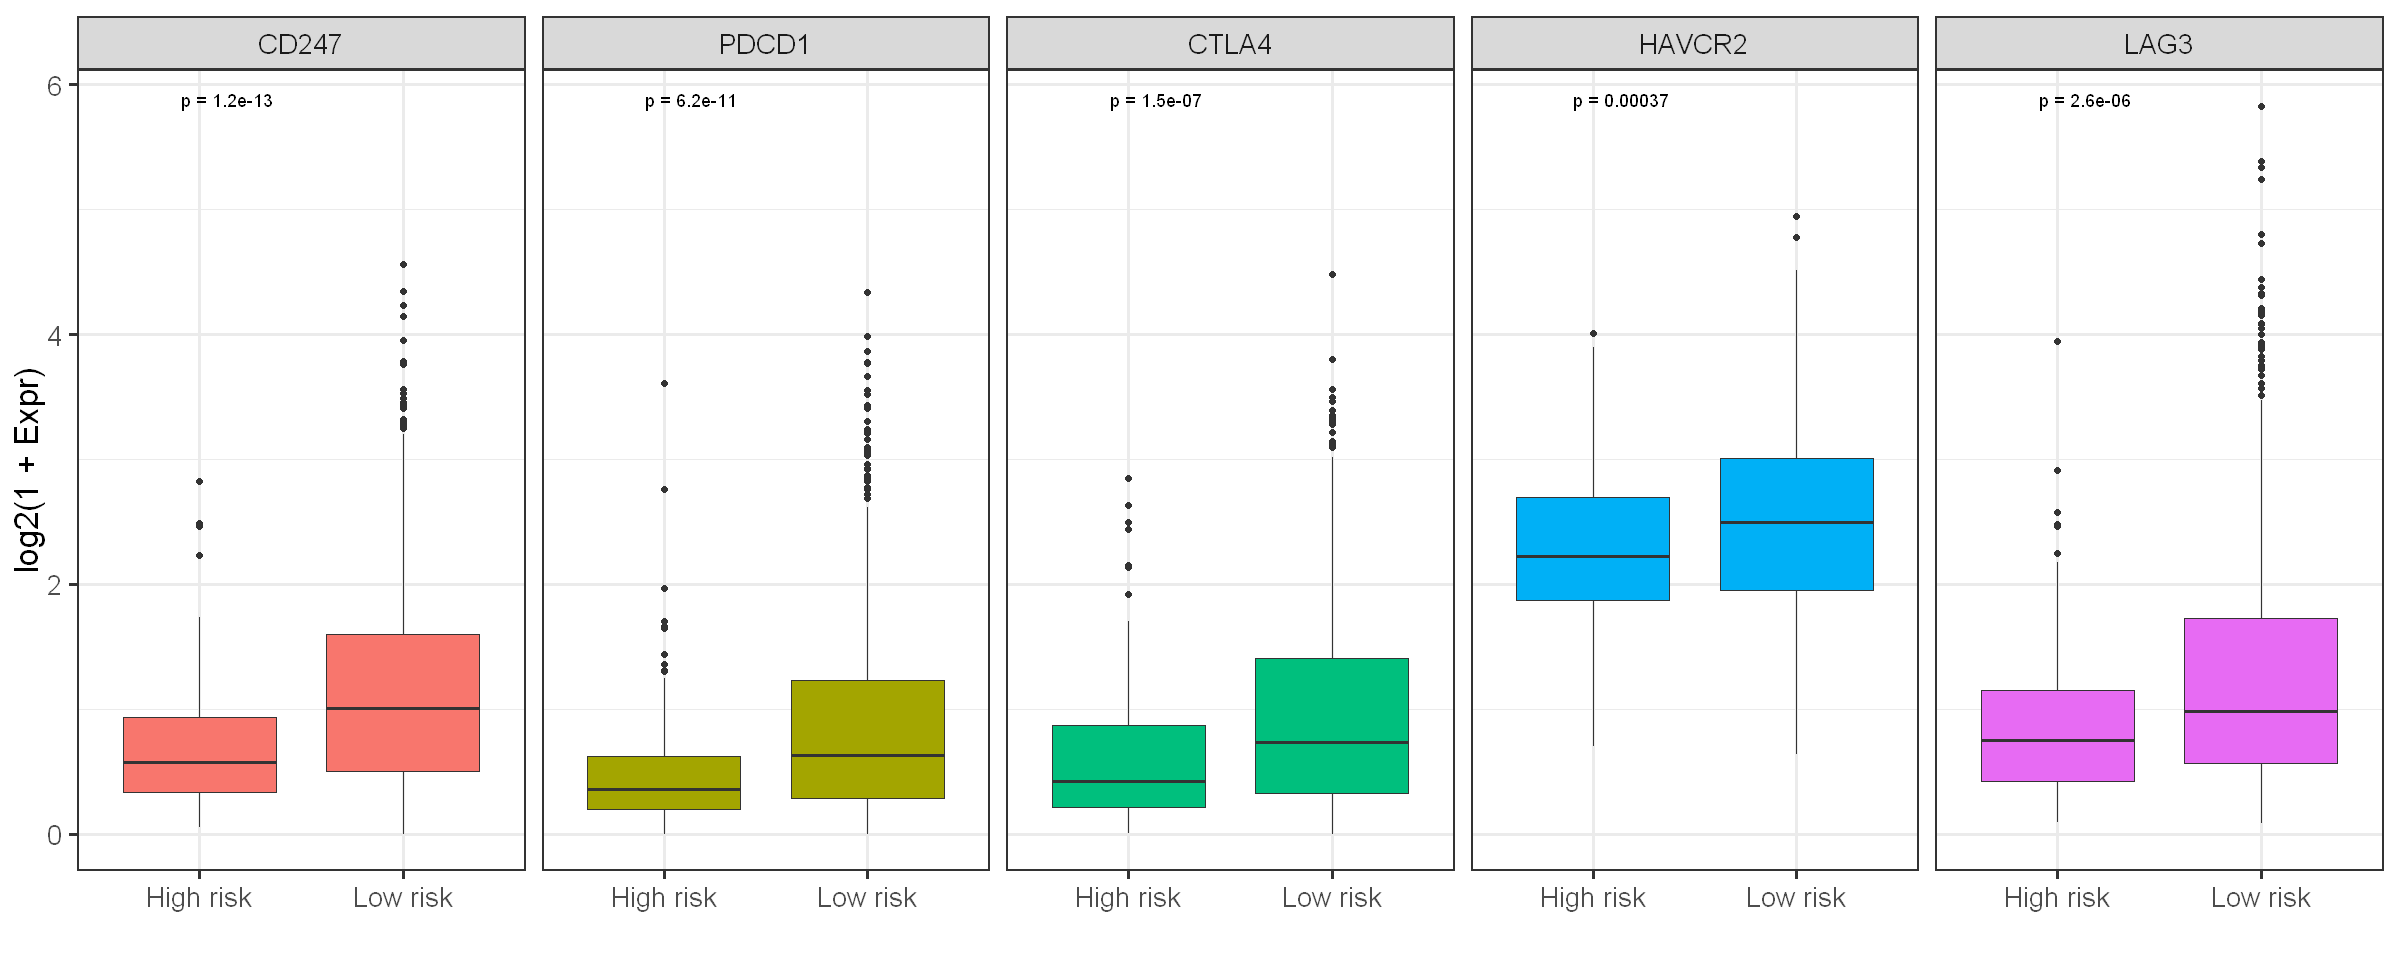

In [1347]:
gpp2 <- ggplot(exh.pf, aes(x = Class, y = log2(1 + Expr), fill = Gene)) + geom_boxplot() + facet_wrap(~Gene, ncol = 5) + stat_compare_means(aes(group = Class), label = "p.format") + theme_bw(base_size = 20) + theme(legend.position = 'none') + xlab('')
gpp2

`geom_smooth()` using formula 'y ~ x'



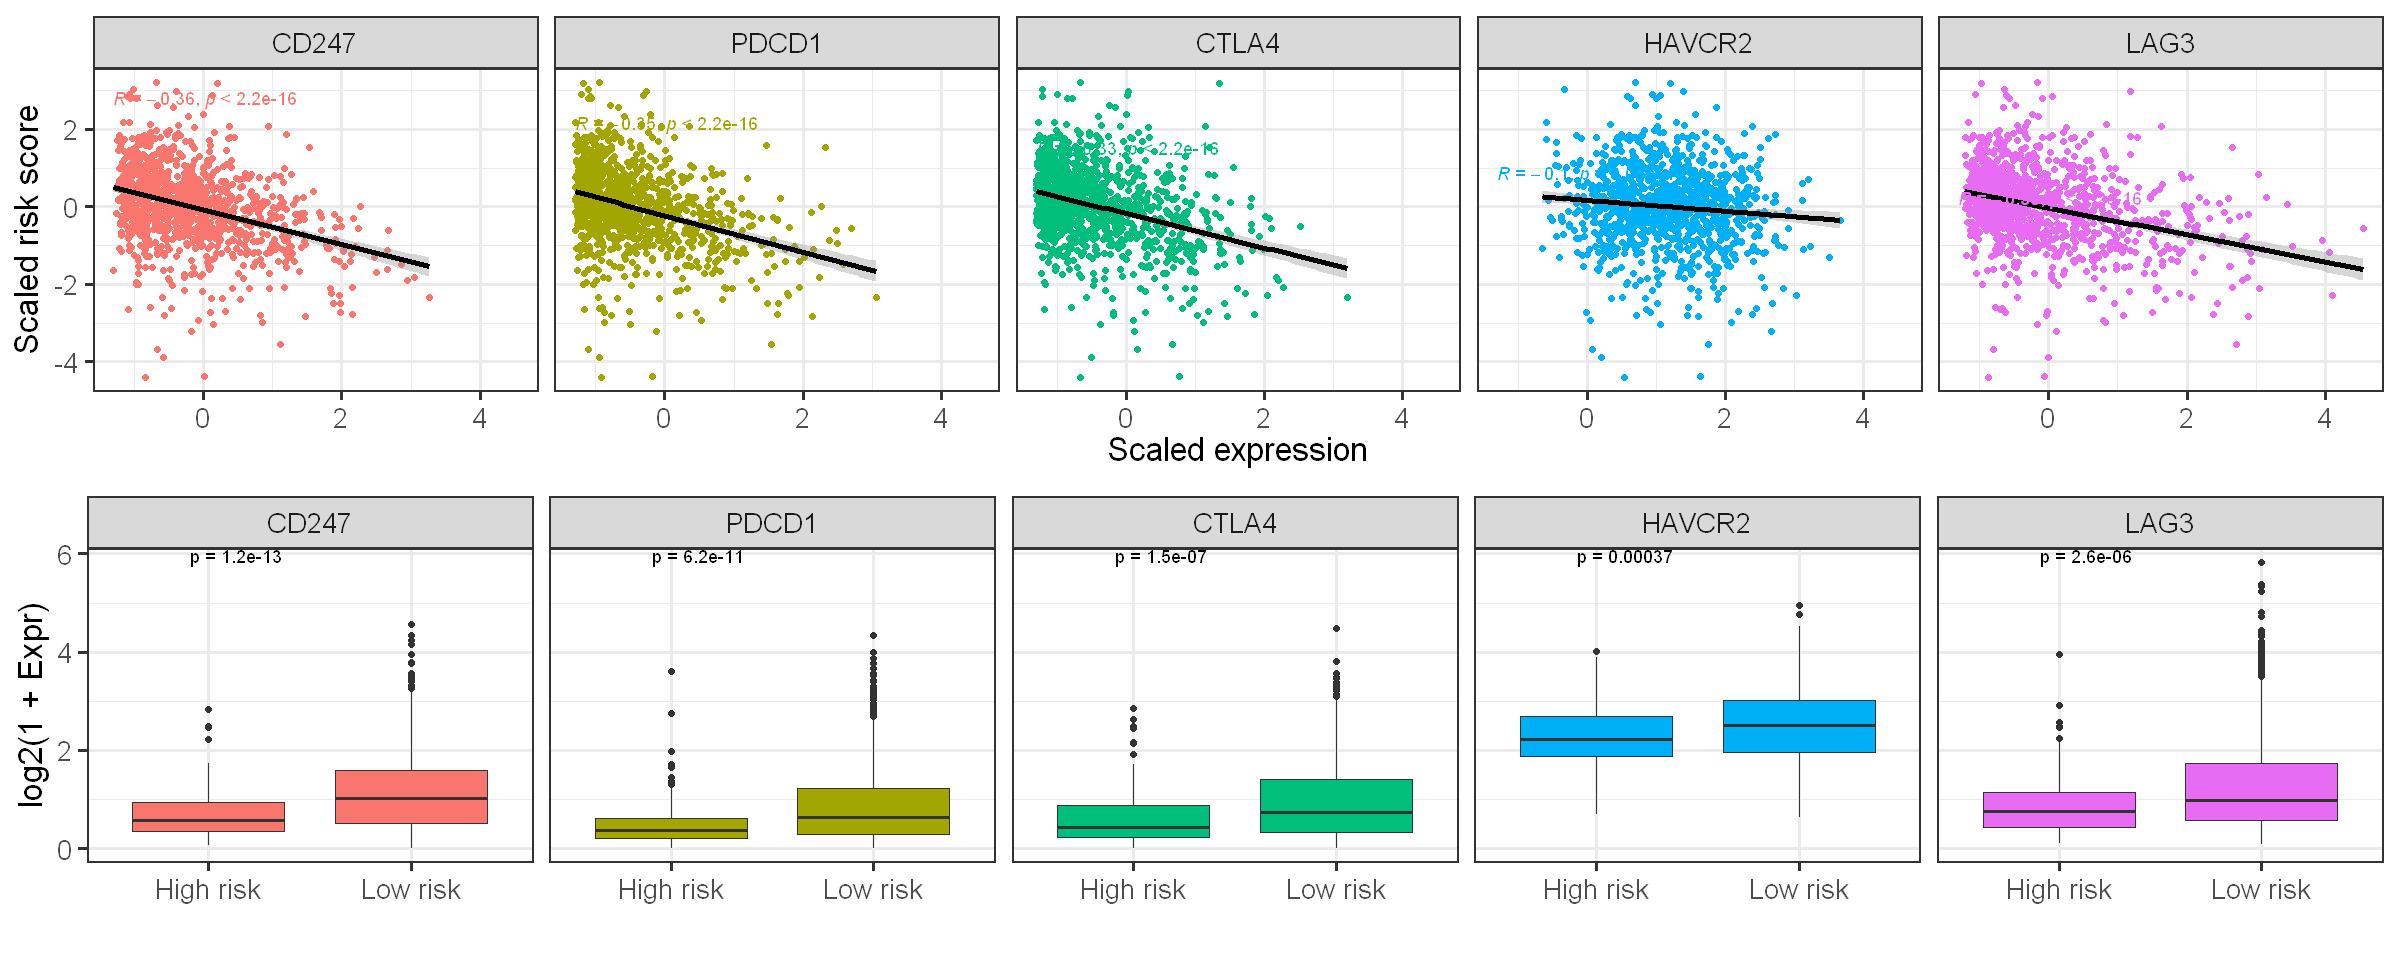

In [1348]:
ggarrange(gpp, gpp2, nrow = 2) 

In [1349]:
ggsave(file.path(out.figs.dir, 'exhuas.risk.groups.pdf'), width = 14, height = 7)

### Classified by immune patterns

In [1440]:
sub.clinical$Class <- res.cox$group
sub.clinical.df <- cbind.data.frame(sub.clinical, exhau.expr)

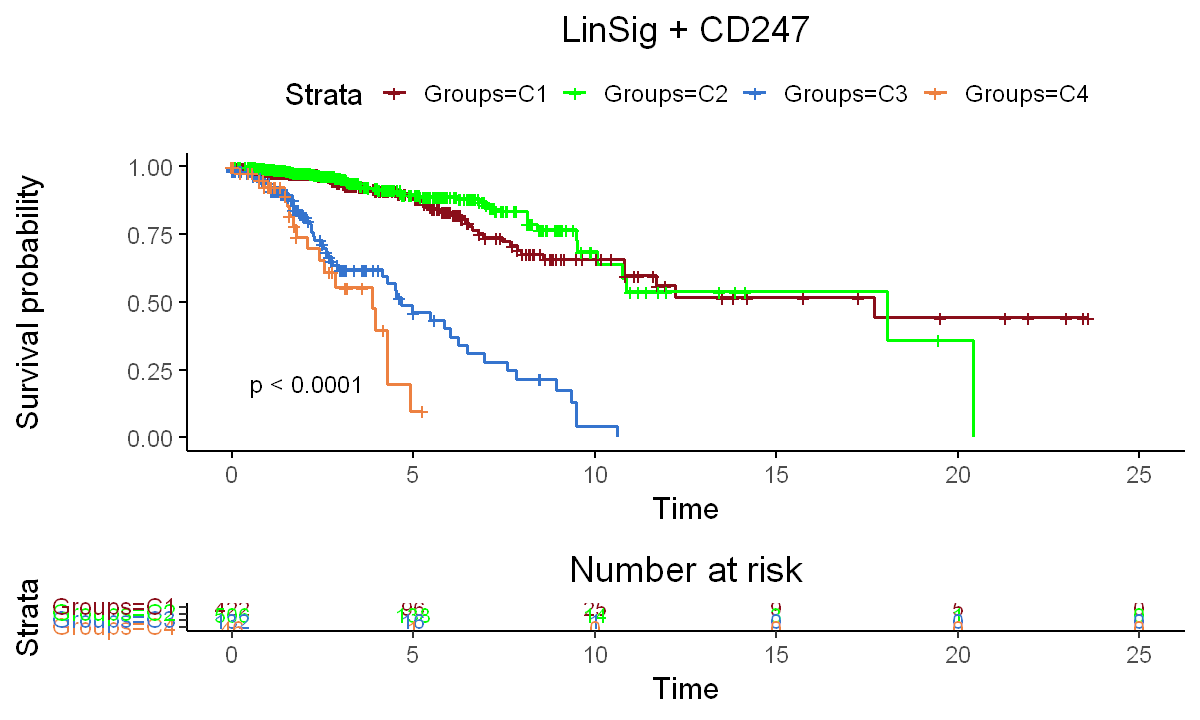

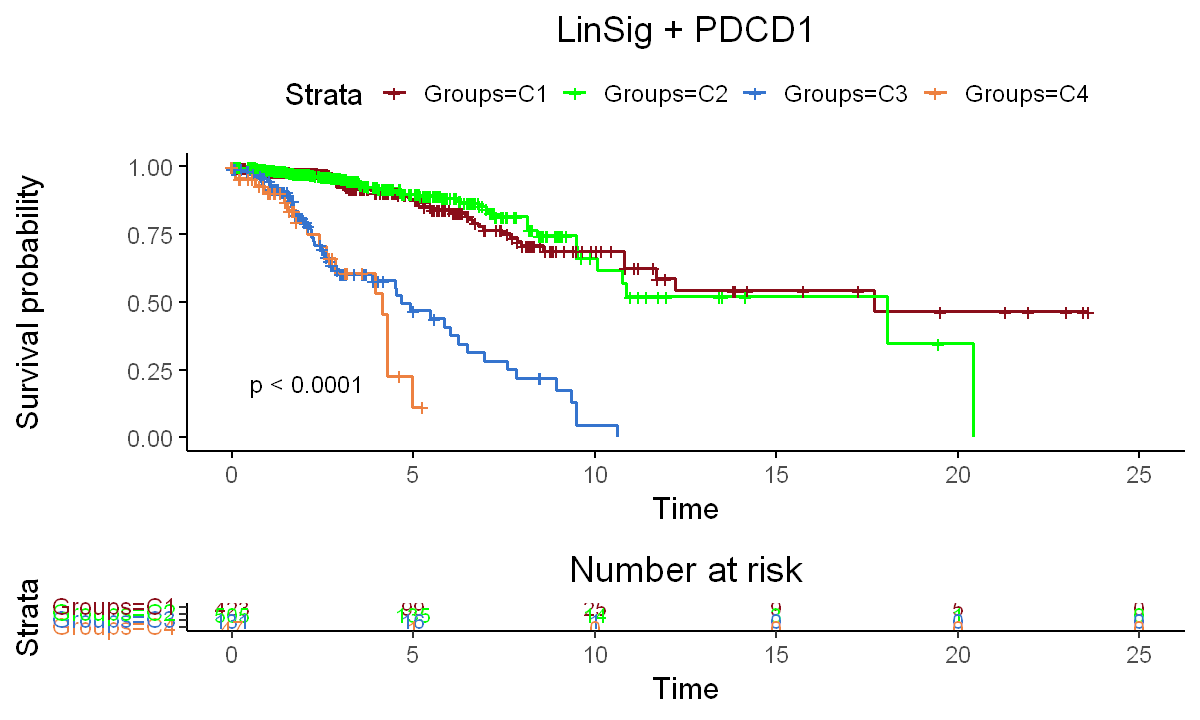

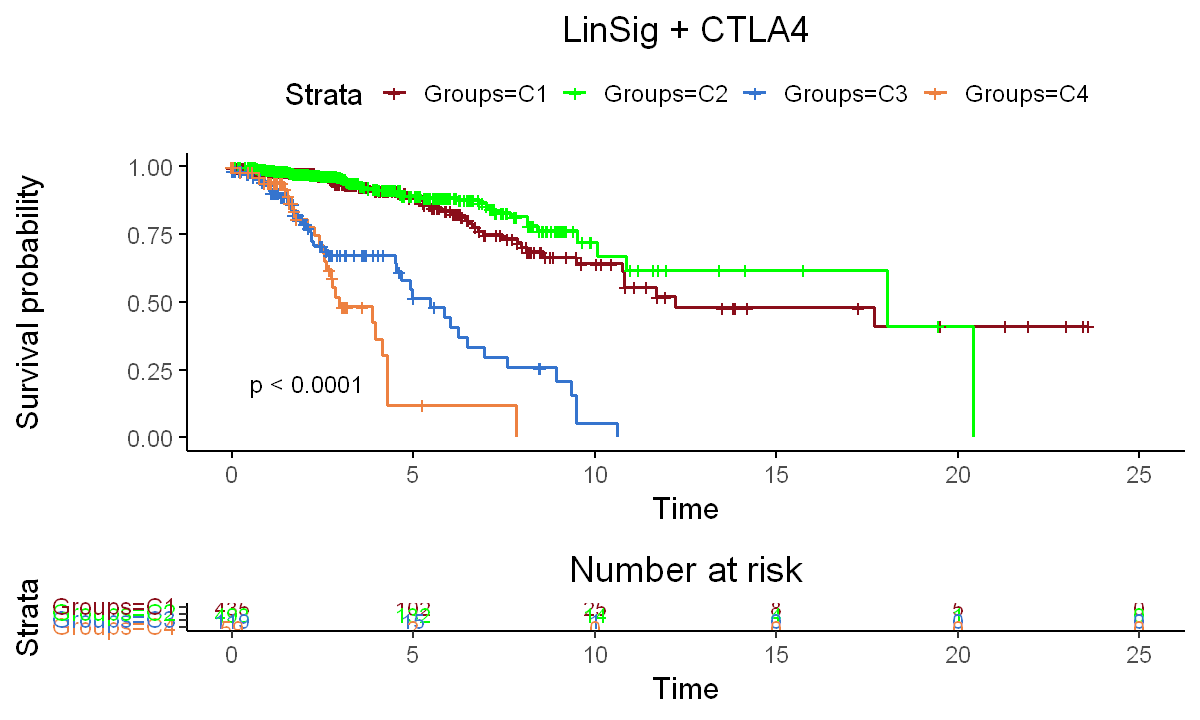

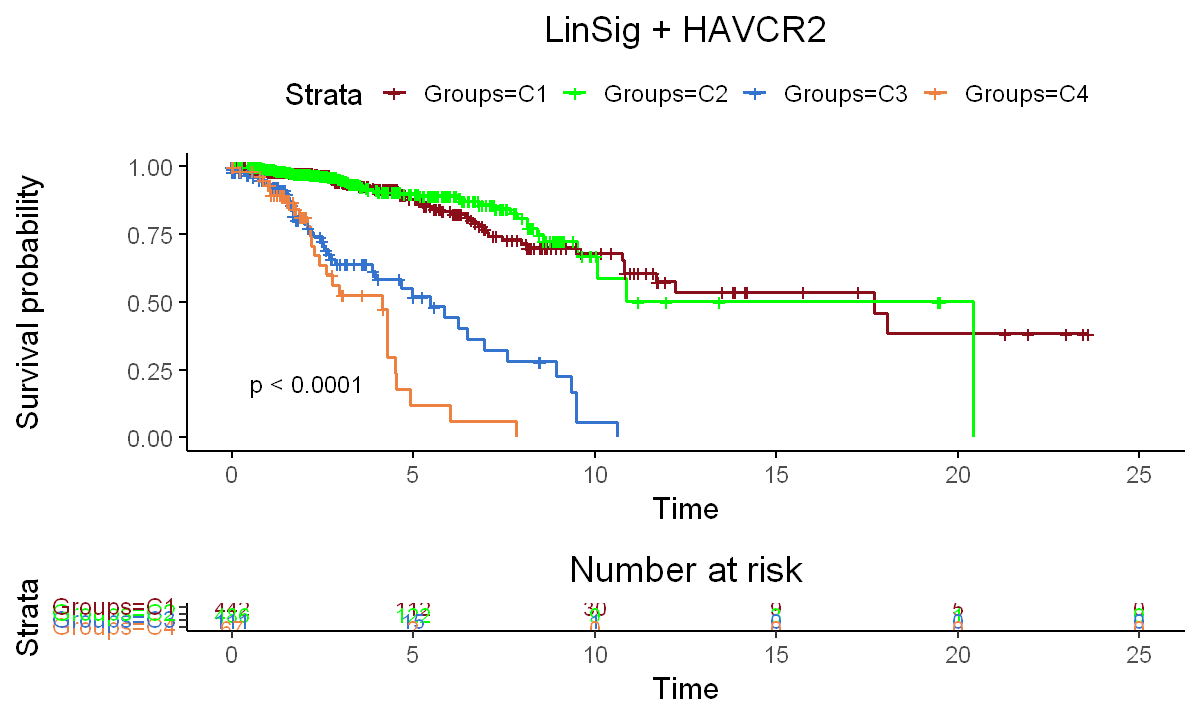

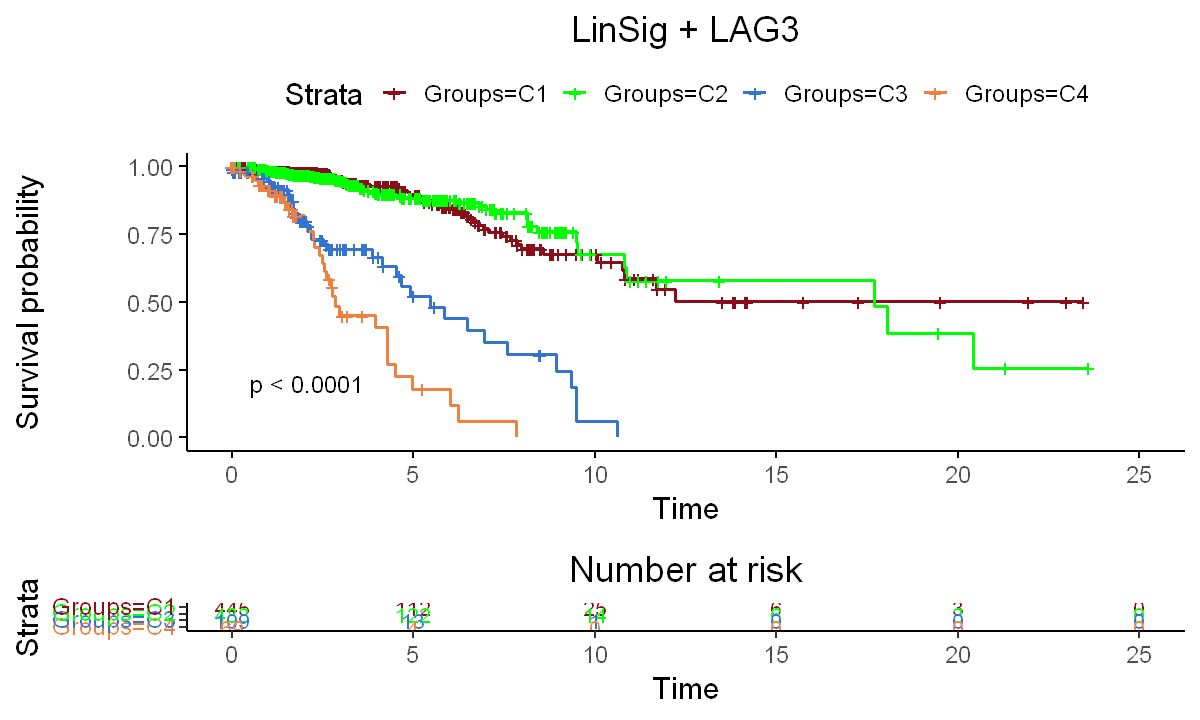

In [1441]:
for (gene in colnames(exhau.expr)) {
    tmp.set.1 <- subset(sub.clinical.df, Class == 'Low risk')
    tmp.set.1[tmp.set.1[, gene] <= median(sub.clinical.df[, gene]), 'Groups'] <- 'C1'
    tmp.set.1[tmp.set.1[, gene] > median(sub.clinical.df[, gene]), 'Groups'] <- 'C2'
    
    tmp.set.2 <- subset(sub.clinical.df, Class == 'High risk')
    tmp.set.2[tmp.set.2[, gene] <= median(sub.clinical.df[, gene]), 'Groups'] <- 'C3'
    tmp.set.2[tmp.set.2[, gene] > median(sub.clinical.df[, gene]), 'Groups'] <- 'C4'
    
    clin.tmp <- rbind.data.frame(tmp.set.1, tmp.set.2)
    options(repr.plot.width = 10, repr.plot.height = 6)
    res.cox.1 <- OS.analysis(
        clin.tmp, 
        c('#8A0E1A','green', '#3574CE', '#ED8141'), 
        F, 
        cutoff = F, 
        prefix = sprintf('TCGA_%s_OS_all.pdf', gene),
        out.figs.dir = out.figs.dir,
        title = sprintf('LinSig + %s', gene)
    )
}

In [51]:
tcga.obj.sub@meta.data$riskScore <- as.vector(risk.socres)
tcga.obj.sub@meta.data$Group <- res.cox$group

Class   p.value     
1 Age     8.459279e-04
2 Stage   5.047830e-05
3 PAM50   3.090810e-11
4 Pan.Gyn 8.151925e-04

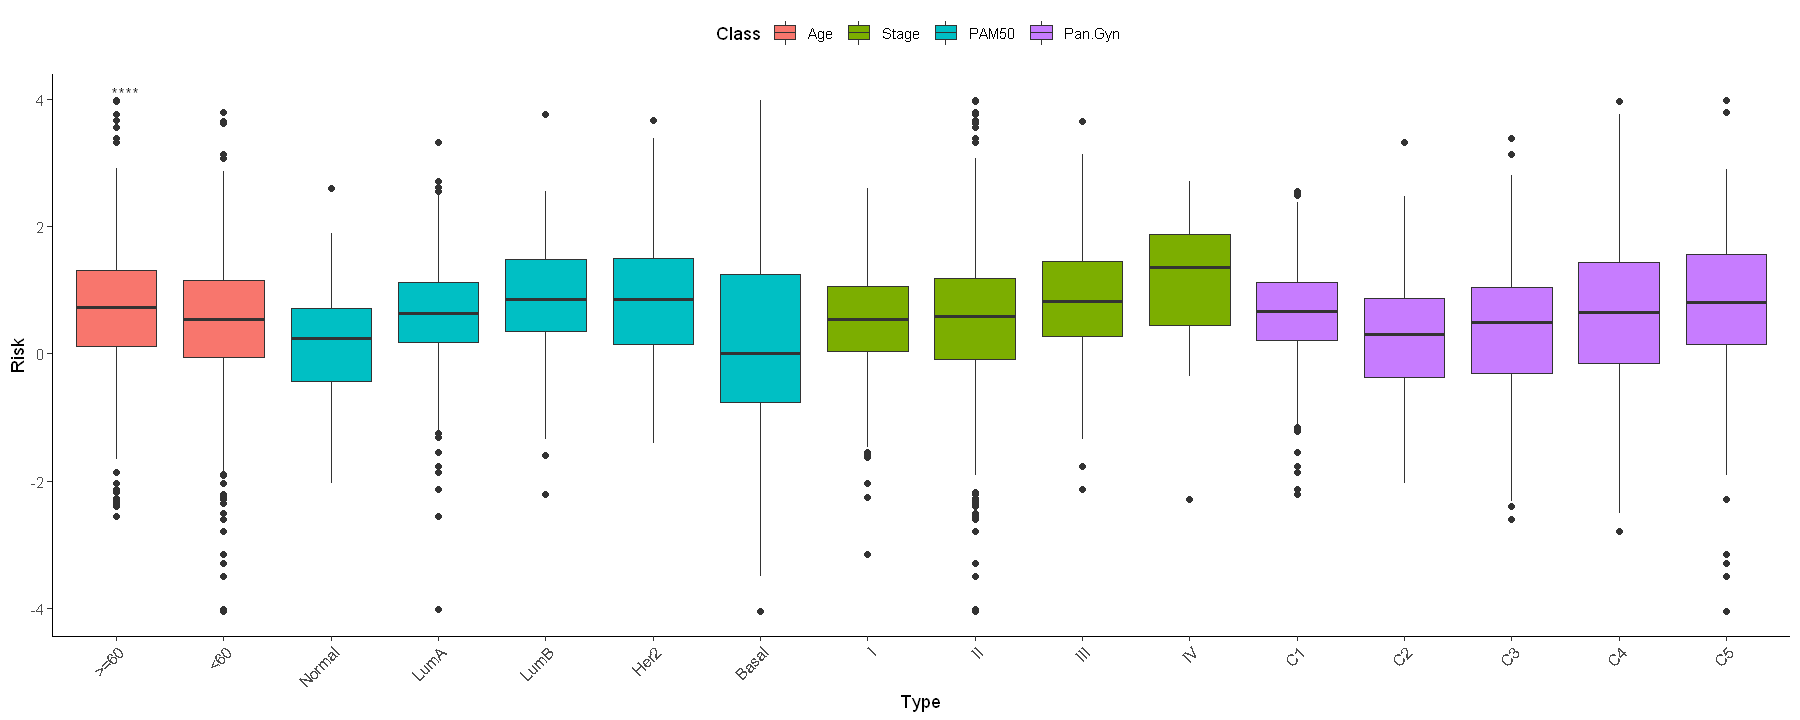

In [1437]:
options(repr.plot.width = 15, repr.plot.height = 6)
plot.df <- c()
Age.df <- rbind(
    cbind(tcga.obj.sub@meta.data[, c('riskScore', 'age_at_index')] %>% as.matrix, Sample = rep('TCGA', dim(tcga.obj.sub)[2]))
) %>% as.data.frame

Age.df$Class <- 'Age'
colnames(Age.df) <- c('Risk', 'Type', 'Sample', 'Class')
Age.df$Type <- ifelse(as.numeric(Age.df$Type) >= 60, '>=60', '<60')
Age.df$Risk <- as.numeric(Age.df$Risk)
Age.df <- subset(Age.df, !is.na(Type))
plot.df <- rbind.data.frame(plot.df, Age.df)

pam50.df <- rbind(
    cbind(tcga.obj.sub@meta.data[, c('riskScore', 'paper_BRCA_Subtype_PAM50')] %>% as.matrix, Sample = rep('TCGA', dim(tcga.obj.sub)[2]))
) %>% as.data.frame

pam50.df$Class <- 'PAM50'
colnames(pam50.df) <- c('Risk', 'Type', 'Sample', 'Class')
pam50.df$Risk <- as.numeric(pam50.df$Risk)
pam50.df <- subset(pam50.df, Type %in% c('LumA', 'LumB', 'Her2', 'Basal', 'Normal'))
plot.df <- rbind.data.frame(plot.df, pam50.df)

tcga.obj.sub@meta.data$stage_novel <- tcga.obj.sub@meta.data$tumor_stage
tcga.obj.sub@meta.data$stage_novel[tcga.obj.sub@meta.data$stage_novel %in% c('stage ia', 'stage i', 'stage ib')] <- '1'
tcga.obj.sub@meta.data$stage_novel[tcga.obj.sub@meta.data$stage_novel %in% c('stage ii', 'stage iib', 'stage iia')] <- '2'
tcga.obj.sub@meta.data$stage_novel[tcga.obj.sub@meta.data$stage_novel %in% c('stage iii', 'stage iiib', 'stage iiia', 'stage iiic')] <- '3'
tcga.obj.sub@meta.data$stage_novel[tcga.obj.sub@meta.data$stage_novel %in% c('stage iv')] <- '4'
tcga.obj.sub@meta.data$stage_novel[tcga.obj.sub@meta.data$stage_novel %in% c('stage x')] <- '5'

stage.df <- rbind(
    cbind(tcga.obj.sub@meta.data[, c('riskScore', 'stage_novel')] %>% as.matrix, Sample = rep('TCGA', dim(tcga.obj.sub)[2]))
) %>% as.data.frame

stage.df$Class <- 'Stage'
colnames(stage.df) <- c('Risk', 'Type', 'Sample', 'Class')
stage.df$Risk <- as.numeric(stage.df$Risk)
stage.df <- subset(stage.df, !(Type %in% c('not reported', '5')))
stage.df$Type[stage.df$Type == '1'] <- 'I'
stage.df$Type[stage.df$Type == '2'] <- 'II'
stage.df$Type[stage.df$Type == '3'] <- 'III'
stage.df$Type[stage.df$Type == '4'] <- 'IV'
stage.df <- subset(stage.df, !is.na(Type))

plot.df <- rbind.data.frame(plot.df, stage.df)
Pan.Gyn.df <- rbind(
    cbind(tcga.obj.sub@meta.data[, c('riskScore', 'paper_Pan.Gyn.Clusters')] %>% as.matrix, Sample = rep('TCGA', dim(tcga.obj.sub)[2]))
) %>% as.data.frame

Pan.Gyn.df$Class <- 'Pan.Gyn'
colnames(Pan.Gyn.df) <- c('Risk', 'Type', 'Sample', 'Class')
Pan.Gyn.df$Risk <- as.numeric(Pan.Gyn.df$Risk)
Pan.Gyn.df <- subset(Pan.Gyn.df, Type %in% c('C1', 'C2', 'C3', 'C4', 'C5'))
plot.df <- rbind.data.frame(plot.df, Pan.Gyn.df)

plot.df$Class <- factor(plot.df$Class, levels = c('Age', "Stage", "PAM50", "Pan.Gyn"))
plot.df$Type <- factor(plot.df$Type, levels = c(">=60", "<60", "Normal", "LumA", "LumB", "Her2", "Basal", "I","II","III","IV", "C1", "C2", "C3", "C4", "C5"))

my.comparisons <- list(
    c(">=60", "<60"),    
    c("I","II","III","IV"),
    c("Normal", "LumA", "LumB", "Her2", "Basal"),
    c("C1", "C2", "C3", "C4", "C5")
)
ptest <- plot.df %>% group_by(Class) %>% summarize(p.value = kruskal.test(Risk ~Type)$p.value)
ggplot(data = plot.df, aes(x = Type, y = Risk, fill = Class)) +
    geom_boxplot() +
    theme_bw(base_size = 20) +
    theme_classic()+
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1), legend.position="top") + stat_compare_means(aes(group = Type), label = "p.signif") + guides(fill = guide_legend(ncol=4))
ptest
ggsave(file.path(out.figs.dir, 'risk_score_groups_boxplot.pdf'), width = 10, height = 4)

png 
  2

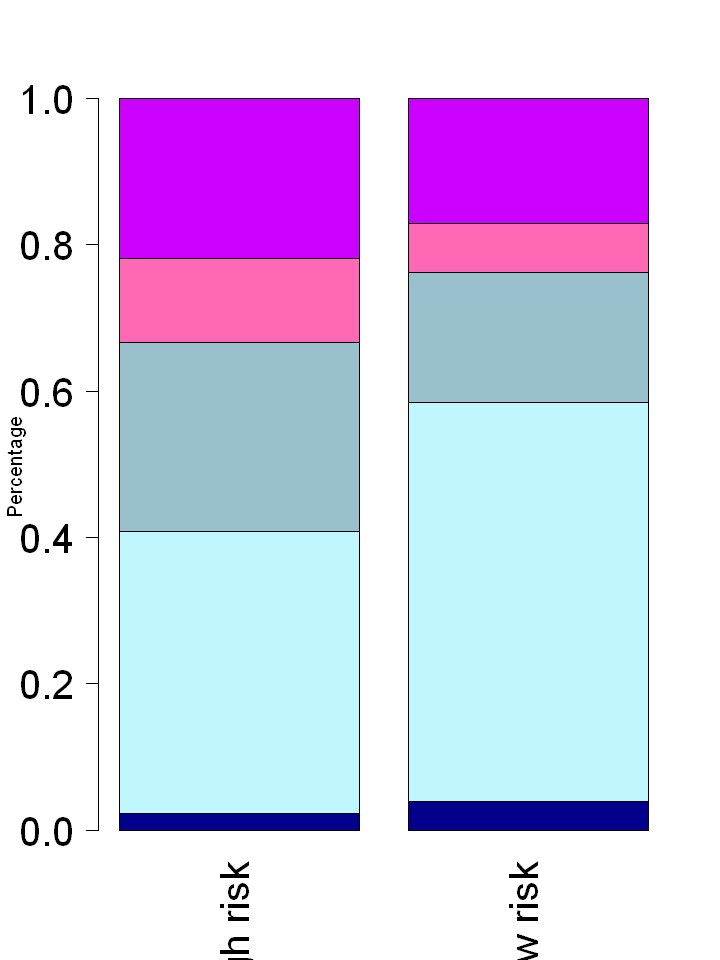

In [1354]:
group.order <- rbind(
    cbind(tcga.obj.sub@meta.data[, c('Group', 'paper_BRCA_Subtype_PAM50')] %>% as.matrix, Sample = rep('TCGA', dim(tcga.obj.sub)[2]))
) %>% as.data.frame

group.order$Class <- 'PAM50'
colnames(group.order) <- c('Risk', 'Type', 'Sample', 'Class')
pam50.group <- subset(group.order, Type %in% c('LumA', 'LumB', 'Her2', 'Basal', 'Normal'))

aa <- table(pam50.group[, 1], pam50.group[, 2]) %>% t
bb <- sweep(aa, 2, colSums(aa), '/')[names(PAM50_COLOR), ]

options(repr.plot.width = 6, repr.plot.height = 8)
pdf(file.path(out.figs.dir, 'Risk_pam50_percent.bar.pdf'), width = 3, height = 5)
tmp <- barplot(bb, col = PAM50_COLOR %>% unlist, ylab = 'Percentage', cex.axis = 2, cex.names = 2, las = 2)
legend(1,1, legend = names(PAM50_COLOR), col=PAM50_COLOR %>% unlist, lwd=3, cex=1, lty = 1, ncol = 2)
dev.off()

barplot(bb, col = PAM50_COLOR %>% unlist, ylab = 'Percentage', cex.axis = 2, cex.names = 2, las = 2)

In [1442]:
source('IPS.R')
ips.score <- IPSCore(GetAssayData(tcga.obj.sub) %>% as.data.frame %>% { log2(1 + .) })


载入程辑包：'gridExtra'


The following object is masked from 'package:dplyr':

    combine




differently named or missing genes:  CCL3L1 


In [1469]:
head(ips.score)

SAMPLE                       MHC      EC        SC        CP         
1 TCGA-E2-A15G-01A-11R-A12D-07 3.076520 0.7745970 -0.894677  0.12401948
2 TCGA-E2-A1B5-01A-21R-A12P-07 4.584694 1.5202322 -1.592181 -0.50256740
3 TCGA-EW-A2FS-01A-11R-A17B-07 3.510237 1.0770778 -1.011054 -0.01773302
4 TCGA-EW-A1P7-01A-21R-A144-07 4.803366 1.5052308 -1.781104 -0.47121319
5 TCGA-LL-A5YO-01A-21R-A28M-07 4.734896 1.5658861 -1.977480 -0.82551720
6 TCGA-BH-A1FN-01A-11R-A13Q-07 3.693526 0.9706054 -1.209145 -0.24538344
  AZ      
1 3.080459
2 4.010178
3 3.558528
4 4.056279
5 3.497785
6 3.209602

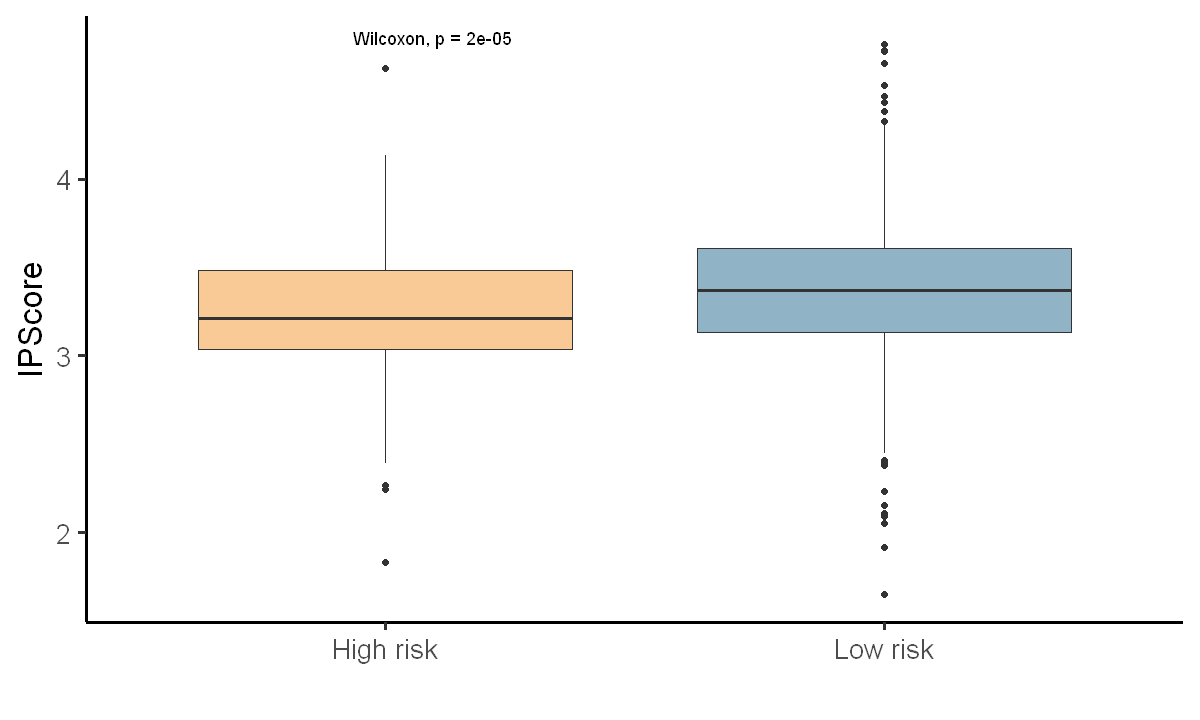

In [1505]:
plot.df.ips <- cbind.data.frame(IPScore = ips.score[, 6], riskScore = res.cox$group)
cols <- unlist(PAIRWISE_COLORS)
names(cols) <- c('High risk', 'Low risk')
gp.1 <- ggplot(plot.df.ips, aes(x = riskScore, y = IPScore, fill = riskScore)) + geom_boxplot() + stat_compare_means(label = "p.signif") + theme_classic(base_size = 20) + scale_fill_manual(values = cols) +  theme(legend.position = 'none') + xlab('')
gp.1

`geom_smooth()` using formula 'y ~ x'



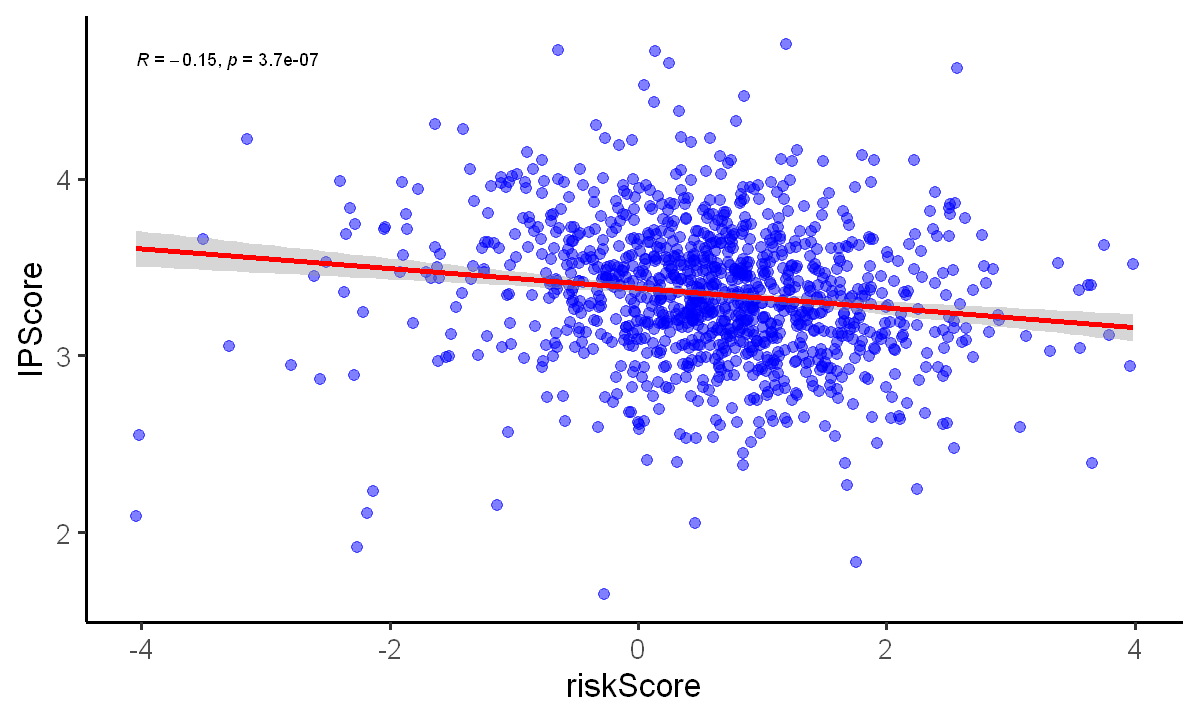

In [1503]:
plot.df.ips <- cbind.data.frame(IPScore = ips.score[, 6], riskScore = as.vector(risk.socres))
gp.2 <- ggplot(plot.df.ips, aes(x = riskScore, y = IPScore)) + geom_point(size = 3, alpha = 0.5, color = 'blue')+ geom_smooth(method = "lm", se = T, color = 'red', lwd = 1.5) + stat_cor(method="pearson") + theme_classic(base_size = 20) + theme(legend.position = 'none')
gp.2

`geom_smooth()` using formula 'y ~ x'



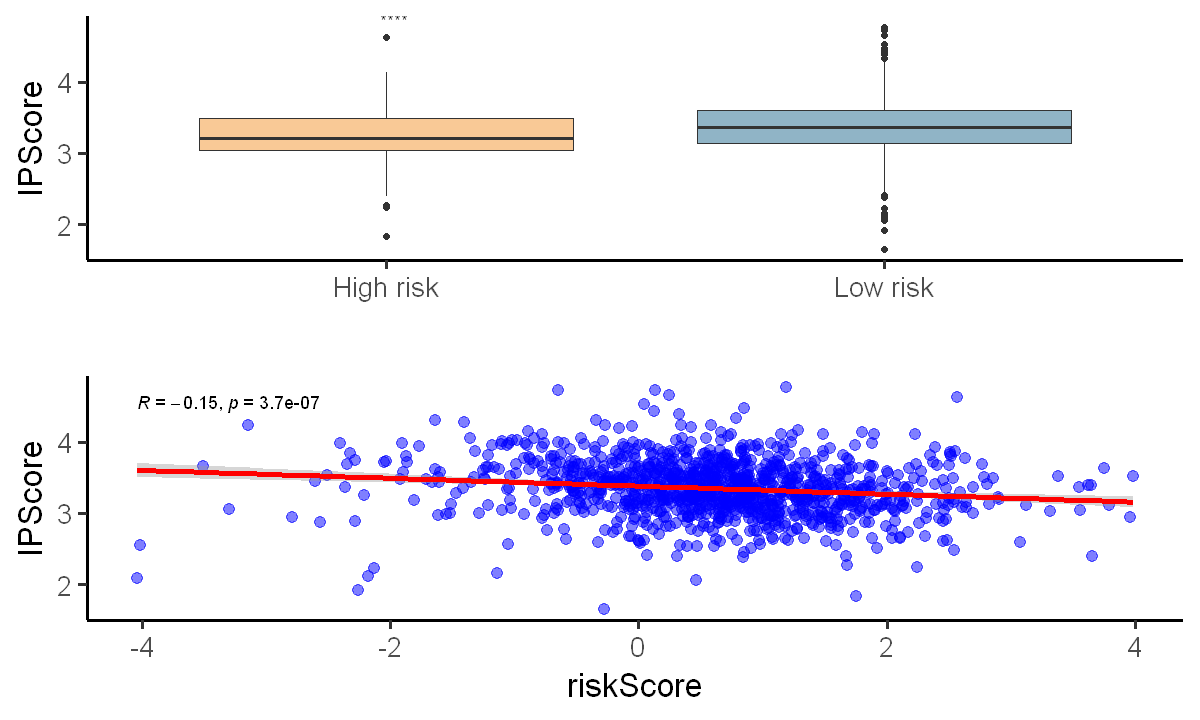

In [1504]:
ggarrange(gp.1, gp.2, nrow = 2) 
ggsave(file.path(out.figs.dir, 'IPS.risk.score.pdf'), height = 6, width = 4)

In [1508]:
### NES score of cancer pathways

In [462]:
nes.score.sub <- nes.score[colnames(tcga.obj.sub), ]

In [463]:
dim(nes.score.sub)
head(nes.score.sub)

[1] 1109   10

RTK_RAS  NOTCH    HIPPO    WNT      PI3K    
TCGA-E2-A15G-01A-11R-A12D-07 1.336675 1.240839 1.192835 1.186799 1.521849
TCGA-E2-A1B5-01A-21R-A12P-07 1.313803 1.267868 1.189044 1.260562 1.453758
TCGA-EW-A2FS-01A-11R-A17B-07 1.352823 1.248907 1.171422 1.205154 1.420731
TCGA-EW-A1P7-01A-21R-A144-07 1.396801 1.311661 1.327573 1.349573 1.428941
TCGA-LL-A5YO-01A-21R-A28M-07 1.260467 1.279847 1.182847 1.218694 1.414804
TCGA-BH-A1FN-01A-11R-A13Q-07 1.343863 1.314693 1.287907 1.161825 1.474510
                             CELL_CYCLE TGF_Beta MYC      TP53     NRF2    
TCGA-E2-A15G-01A-11R-A12D-07 1.356145   1.478386 1.417893 1.419021 1.737924
TCGA-E2-A1B5-01A-21R-A12P-07 1.475970   1.470507 1.449694 1.460431 1.694040
TCGA-EW-A2FS-01A-11R-A17B-07 1.500784   1.443278 1.347984 1.438744 1.662352
TCGA-EW-A1P7-01A-21R-A144-07 1.588284   1.447075 1.425700 1.467098 1.670157
TCGA-LL-A5YO-01A-21R-A28M-07 1.546093   1.354670 1.407807 1.400502 1.674053
TCGA-BH-A1FN-01A-11R-A13Q-07 1.539289   1.512237 1.495506 1.476215 1.692673

In [464]:
nes.score.sub.plot <- cbind.data.frame(nes.score.sub %>% scale, Group = ifelse(res.cox$group == 'High risk', 'High', 'Low'))
nes.score.sub.plot <- tidyr::gather(nes.score.sub.plot, 'Pathway', 'NES',  -Group)
nes.score.sub.plot$Pathway <- factor(nes.score.sub.plot$Pathway, levels = colnames(nes.score.sub))
nes.score.sub.plot$Group <- factor(nes.score.sub.plot$Group, levels = c('High', 'Low'))
head(nes.score.sub.plot)

Group Pathway NES       
1 Low   RTK_RAS -0.4137421
2 Low   RTK_RAS -0.7883398
3 Low   RTK_RAS -0.1492681
4 Low   RTK_RAS  0.5710126
5 Low   RTK_RAS -1.6618908
6 High  RTK_RAS -0.2960191

In [465]:
cols

High       Low 
"#F9C996" "#90B4C6"

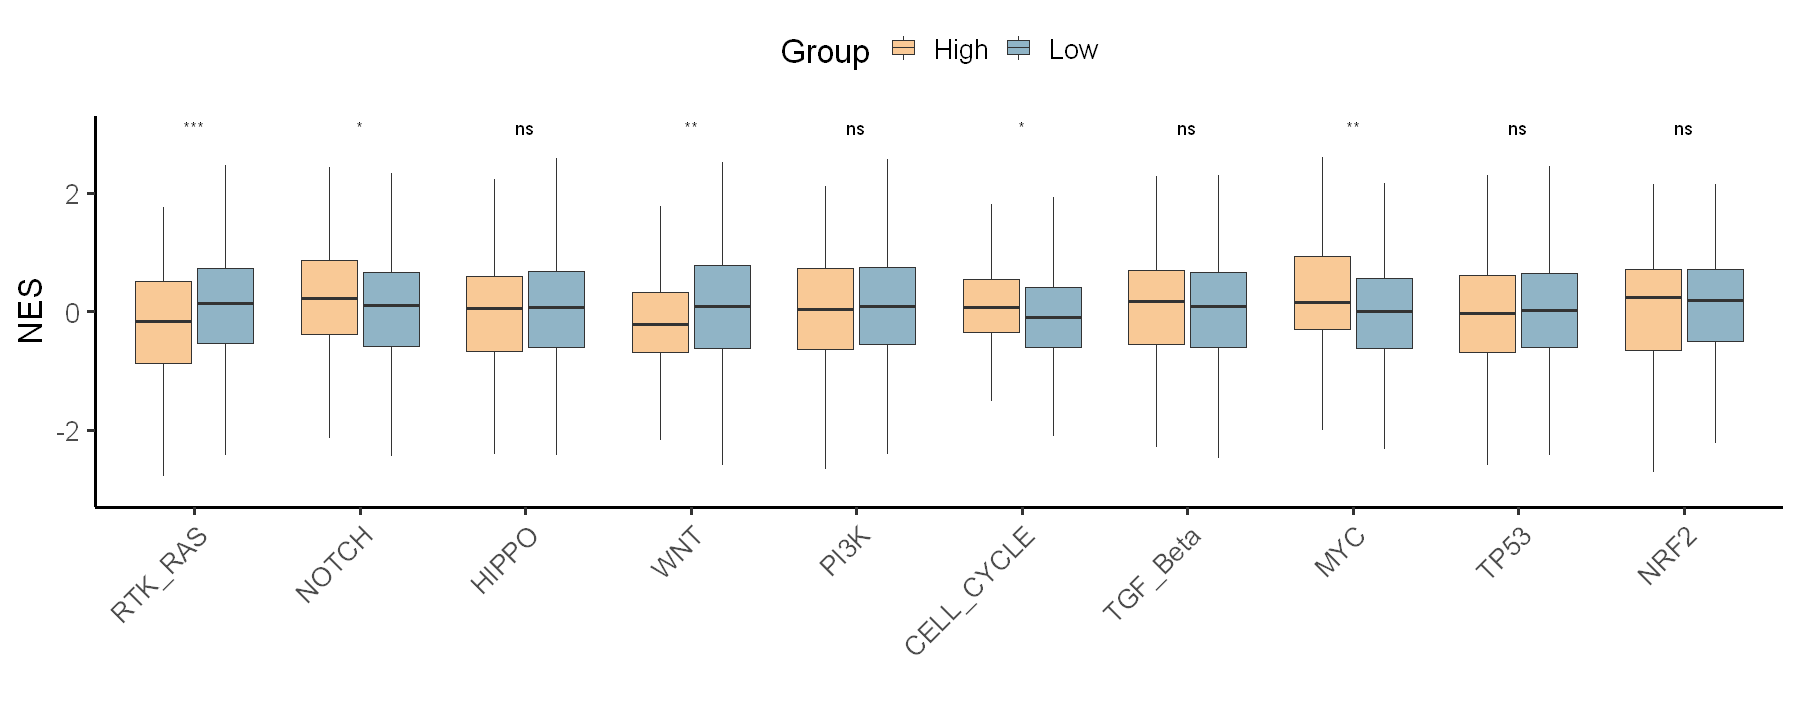

In [466]:
options(repr.plot.width = 15, repr.plot.height = 6)
names(cols) <- c('High', 'Low')
ggplot(nes.score.sub.plot, aes(x = Pathway, y = NES, fill = Group)) + geom_boxplot(outlier.shape = NA) + stat_compare_means(label = "p.signif") + theme_classic(base_size = 20) + scale_fill_manual(values = cols) + ylim(-3, 3) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1), legend.position="top") + xlab('')
ggsave(file.path(out.figs.dir, 'nes.high.vs.low.groups.pathways.pdf'), height = 6, width = 10)

In [469]:
head(nes.score.sub)

RTK_RAS  NOTCH    HIPPO    WNT      PI3K    
TCGA-E2-A15G-01A-11R-A12D-07 1.336675 1.240839 1.192835 1.186799 1.521849
TCGA-E2-A1B5-01A-21R-A12P-07 1.313803 1.267868 1.189044 1.260562 1.453758
TCGA-EW-A2FS-01A-11R-A17B-07 1.352823 1.248907 1.171422 1.205154 1.420731
TCGA-EW-A1P7-01A-21R-A144-07 1.396801 1.311661 1.327573 1.349573 1.428941
TCGA-LL-A5YO-01A-21R-A28M-07 1.260467 1.279847 1.182847 1.218694 1.414804
TCGA-BH-A1FN-01A-11R-A13Q-07 1.343863 1.314693 1.287907 1.161825 1.474510
                             CELL_CYCLE TGF_Beta MYC      TP53     NRF2    
TCGA-E2-A15G-01A-11R-A12D-07 1.356145   1.478386 1.417893 1.419021 1.737924
TCGA-E2-A1B5-01A-21R-A12P-07 1.475970   1.470507 1.449694 1.460431 1.694040
TCGA-EW-A2FS-01A-11R-A17B-07 1.500784   1.443278 1.347984 1.438744 1.662352
TCGA-EW-A1P7-01A-21R-A144-07 1.588284   1.447075 1.425700 1.467098 1.670157
TCGA-LL-A5YO-01A-21R-A28M-07 1.546093   1.354670 1.407807 1.400502 1.674053
TCGA-BH-A1FN-01A-11R-A13Q-07 1.539289   1.512237 1.495506 1.476215 1.692673

In [478]:
head(nes.score.sub.plot)

Group      Pathway NES       
1  0.2203707 RTK_RAS -0.4137421
2 -1.1014146 RTK_RAS -0.7883398
3 -0.3787754 RTK_RAS -0.1492681
4 -0.8431213 RTK_RAS  0.5710126
5  0.6170595 RTK_RAS -1.6618908
6  1.7747969 RTK_RAS -0.2960191

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



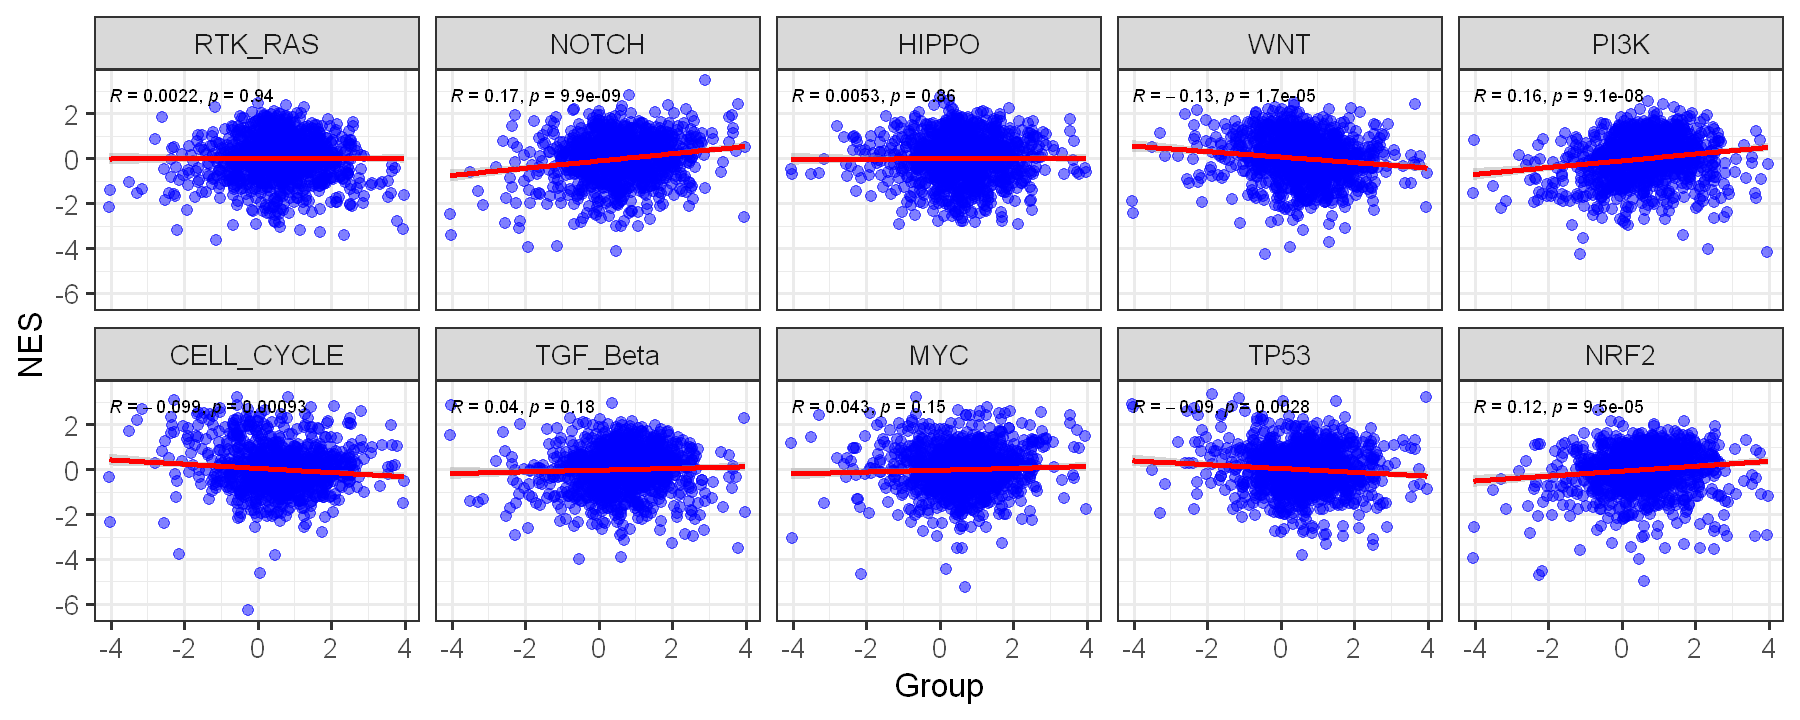

In [485]:
options(repr.plot.width = 15, repr.plot.height = 6)
names(cols) <- c('High', 'Low')

nes.score.sub.plot <- cbind.data.frame(nes.score.sub %>% scale, Group = as.vector(risk.socres))
nes.score.sub.plot <- tidyr::gather(nes.score.sub.plot, 'Pathway', 'NES',  -Group)
nes.score.sub.plot$Pathway <- factor(nes.score.sub.plot$Pathway, levels = colnames(nes.score.sub))

ggplot(nes.score.sub.plot, aes(x = Group, y = NES)) +  facet_wrap(~Pathway, ncol = 5) + geom_point(size = 3, alpha = 0.5, color = 'blue')+ geom_smooth(method = "lm", se = T, color = 'red', lwd = 1.5) + stat_cor(method="pearson") + theme_bw(base_size = 20) 
#stat_compare_means(label = "p.signif") + theme_classic(base_size = 20) + scale_fill_manual(values = cols) + ylim(-3, 3) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1), legend.position="top") + xlab('')
ggsave(file.path(out.figs.dir, 'nes.high.vs.low.scatter.pdf'), height = 6, width = 10)

### DEGs analyssi

In [53]:
label <- ifelse(res.cox$group == 'High risk', 'High', 'Low')
names(label) <- colnames(tcga.obj.sub)
group.list <- factor(label)

design <- model.matrix(~0 + group.list)
colnames(design) <- levels(group.list)
rownames(design) <- colnames(tcga.obj.sub)
contrast.matrix <- makeContrasts('High-Low',levels = design)
fit.lm <- lmFit(GetAssayData(tcga.obj.sub) %>% as.matrix, design)
fit2 <- contrasts.fit(fit.lm, contrast.matrix)
fit2 <- eBayes(fit2)
DEgeneSets <- topTable(fit2, coef=1, number=Inf, p.value=1e-2, adjust="BH")

In [54]:
table(label)

label
High  Low 
 179  930 

In [55]:
head(DEgeneSets)

logFC      AveExpr   t         P.Value      adj.P.Val    B       
LINC00346  0.9279150  1.004204  7.804087 1.380583e-14 7.533153e-10 21.93668
MOB3C     -0.6611918  3.269817 -6.808866 1.609559e-11 4.391279e-07 15.01021
GIMAP2    -2.0170385  5.254155 -6.711314 3.072753e-11 5.588825e-07 14.37773
UBA7      -3.4827201 10.869262 -6.597015 6.486447e-11 8.848325e-07 13.64737
APOBEC3G  -1.2880137  2.731514 -6.482253 1.357821e-10 1.481790e-06 12.92573
CCDC97    -2.2995720 14.719584 -6.349482 3.146348e-10 2.861341e-06 12.10551

In [78]:
deg.up.high <- subset(DEgeneSets, logFC > 1)
dim(deg.up.high)
deg.up.high.genes <- deg.up.high[order(deg.up.high$logFC) %>% rev, ] %>% rownames(.)
deg.up.high.anno <- bitr(deg.up.high.genes, fromType = 'SYMBOL', toType = 'ENTREZID', OrgDb = 'org.Hs.eg.db', drop = T)
gene.lst <- deg.up.high[deg.up.high.anno$SYMBOL, 'logFC']
names(gene.lst) <- deg.up.high.anno[, 'ENTREZID']
gsea.high.up <-gseGO(geneList = gene.lst, nPerm = 1000, ont = 'BP', pvalueCutoff = 0.05, OrgDb = org.Hs.eg.db)
as.data.frame(gsea.high.up) %>% head

[1] 186   6

'select()' returned 1:1 mapping between keys and columns

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



ID         Description                               setSize
GO:0007275 GO:0007275 multicellular organism development        56     
GO:0030154 GO:0030154 cell differentiation                      48     
GO:0032501 GO:0032501 multicellular organismal process          69     
GO:0048518 GO:0048518 positive regulation of biological process 68     
GO:0048869 GO:0048869 cellular developmental process            49     
GO:0009653 GO:0009653 anatomical structure morphogenesis        33     
           enrichmentScore NES      pvalue      p.adjust   qvalues   rank
GO:0007275 0.7926693       1.373971 0.000999001 0.02284473 0.0202762 19  
GO:0030154 0.8328021       1.449795 0.000999001 0.02284473 0.0202762 19  
GO:0032501 0.7771564       1.338691 0.000999001 0.02284473 0.0202762 19  
GO:0048518 0.7627155       1.313571 0.000999001 0.02284473 0.0202762 30  
GO:0048869 0.8296615       1.443184 0.000999001 0.02284473 0.0202762 19  
GO:0009653 0.8584428       1.501807 0.001000000 0.02284473 0.0202762 14  
           leading_edge                  
GO:0007275 tags=23%, list=11%, signal=31%
GO:0030154 tags=27%, list=11%, signal=34%
GO:0032501 tags=20%, list=11%, signal=31%
GO:0048518 tags=29%, list=18%, signal=41%
GO:0048869 tags=27%, list=11%, signal=33%
GO:0009653 tags=24%, list=8%, signal=28% 
           core_enrichment                                                                                    
GO:0007275 6277/1382/3326/3320/6382/114569/999/6271/5230/4320/5885/10397/3304                                 
GO:0030154 6277/1382/3326/3320/8407/6382/6281/999/5230/1672/4320/10397/3304                                   
GO:0032501 6277/1382/3326/3320/6382/114569/999/6271/5230/1672/4320/5885/10397/3304                            
GO:0048518 6277/1382/3326/3320/1917/6382/3312/6281/999/6271/1672/5885/3304/10276/794/7879/6836/10575/7532/3799
GO:0048869 6277/1382/3326/3320/8407/6382/6281/999/5230/1672/4320/10397/3304                                   
GO:0009653 6277/1382/3326/3320/6382/6281/6271/5230

In [94]:
deg.up.low <- subset(DEgeneSets, logFC < -1)
dim(deg.up.low)
deg.up.low.genes <- deg.up.low[order(deg.up.low$logFC) %>% rev, ] %>% rownames(.)
deg.up.low.anno <- bitr(deg.up.low.genes, fromType = 'SYMBOL', toType = 'ENTREZID', OrgDb = 'org.Hs.eg.db', drop = T)
gene.lst <- deg.up.low[deg.up.low.anno$SYMBOL, 'logFC']
names(gene.lst) <- deg.up.low.anno[, 'ENTREZID']
gsea.low.up <-gseGO(geneList = gene.lst, nPerm = 1000, ont = 'BP', pvalueCutoff = 0.05, OrgDb = org.Hs.eg.db)
as.data.frame(gsea.low.up) %>% head

[1] 370   6

'select()' returned 1:1 mapping between keys and columns

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



ID         Description                                  setSize
GO:0001775 GO:0001775 cell activation                              100    
GO:0002250 GO:0002250 adaptive immune response                      70    
GO:0002443 GO:0002443 leukocyte mediated immunity                   57    
GO:0002684 GO:0002684 positive regulation of immune system process  85    
GO:0002694 GO:0002694 regulation of leukocyte activation            58    
GO:0006950 GO:0006950 response to stress                           146    
           enrichmentScore NES       pvalue      p.adjust   qvalues    rank
GO:0001775 -0.8091069      -1.390921 0.000999001 0.02784266 0.02150298 26  
GO:0002250 -0.8438824      -1.484318 0.000999001 0.02784266 0.02150298 18  
GO:0002443 -0.8776227      -1.557557 0.000999001 0.02784266 0.02150298  7  
GO:0002684 -0.8233067      -1.431402 0.000999001 0.02784266 0.02150298 39  
GO:0002694 -0.8656032      -1.532774 0.000999001 0.02784266 0.02150298 26  
GO:0006950 -0.8061566      -1.371842 0.000999001 0.02784266 0.02150298 38  
           leading_edge                  
GO:0001775 tags=15%, list=7%, signal=19% 
GO:0002250 tags=14%, list=5%, signal=17% 
GO:0002443 tags=11%, list=2%, signal=12% 
GO:0002684 tags=25%, list=11%, signal=29%
GO:0002694 tags=22%, list=7%, signal=25% 
GO:0006950 tags=21%, list=11%, signal=33%
           core_enrichment                                                                                                                                       
GO:0001775 7305/3936/677/7805/678/6352/3113/6363/3115/3133/3123/567/3122/972/3493                                                                                
GO:0002250 3113/6363/3115/3127/3133/3123/567/3122/972/3493                                                                                                       
GO:0002443 3133/3123/567/3122/972/3493                                                                                                                           
GO:0002684 28755/5721/3119/5696/3118/4239/7305/677/7805/6352/3113/6363/5720/3115/3127/3133/3123/567/3122/972/3493                                                
GO:0002694 7305/677/7805/678/6352/3113/6363/3115/3133/3123/3122/972/3493                                                                                         
GO:0006950 5721/3119/1153/5696/4792/3118/6890/3178/9246/358/4239/7305/677/7805/27250/678/6352/3113/6772/6363/4283/5720/3115/7832/3127/3133/3123/567/3122/972/3493

In [112]:
gsea.high.up.sorted <- gsea.high.up[order(gsea.high.up$enrichmentScore,decreasing=T)]
gsea.low.up.sorted <- gsea.low.up[order(gsea.low.up$enrichmentScore,decreasing = T)]

In [115]:
row.names(gsea.high.up.sorted)[1 : 5]

[1] "GO:0048812" "GO:0048858" "GO:0120039" "GO:0061564" "GO:0032989"

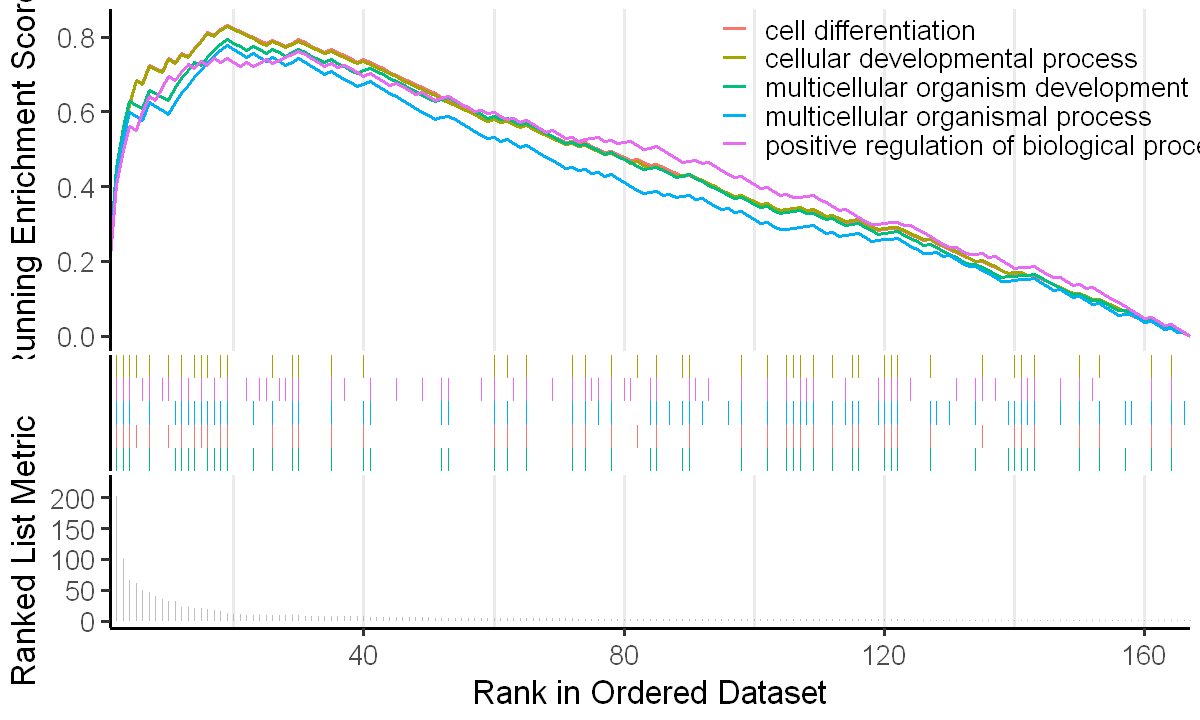

In [146]:
options(repr.plot.width = 10, repr.plot.height = 6)
gsea.1 <- gseaplot2(gsea.high.up, row.names(gsea.high.up %>% as.data.frame)[1 : 5], base_size = 20)
gsea.1

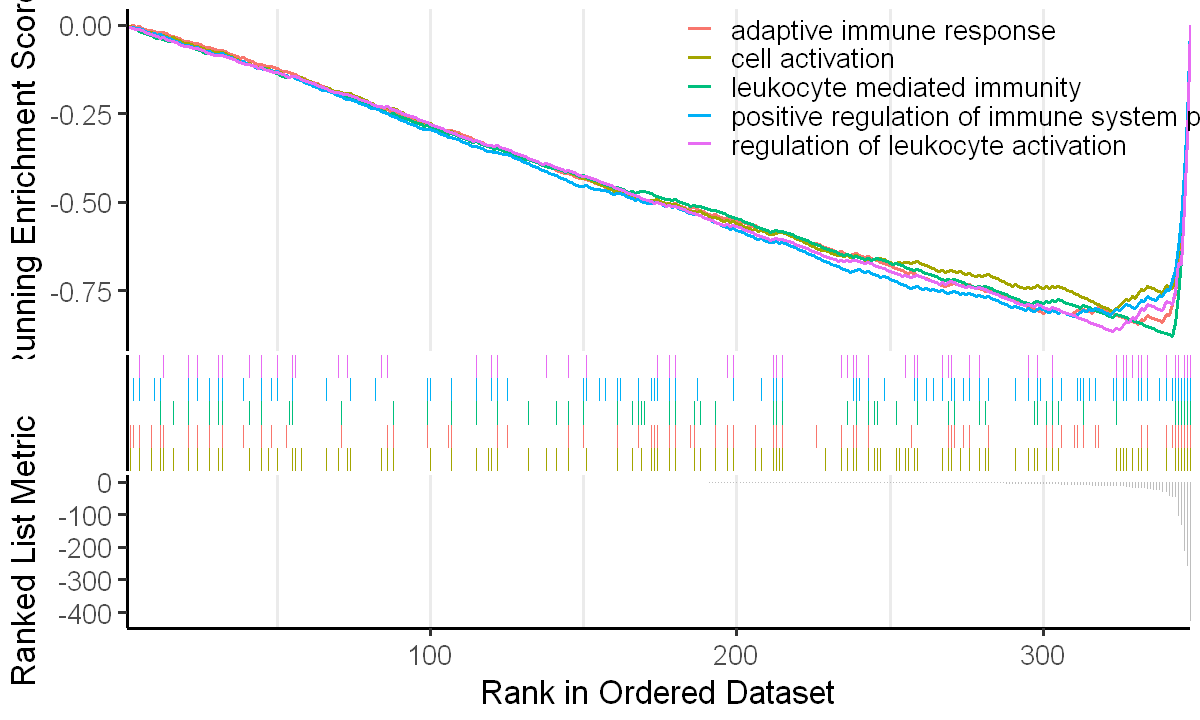

In [147]:
gsea.2 <- gseaplot2(gsea.low.up, row.names(gsea.low.up %>% as.data.frame)[1:5], base_size = 20) 
gsea.2

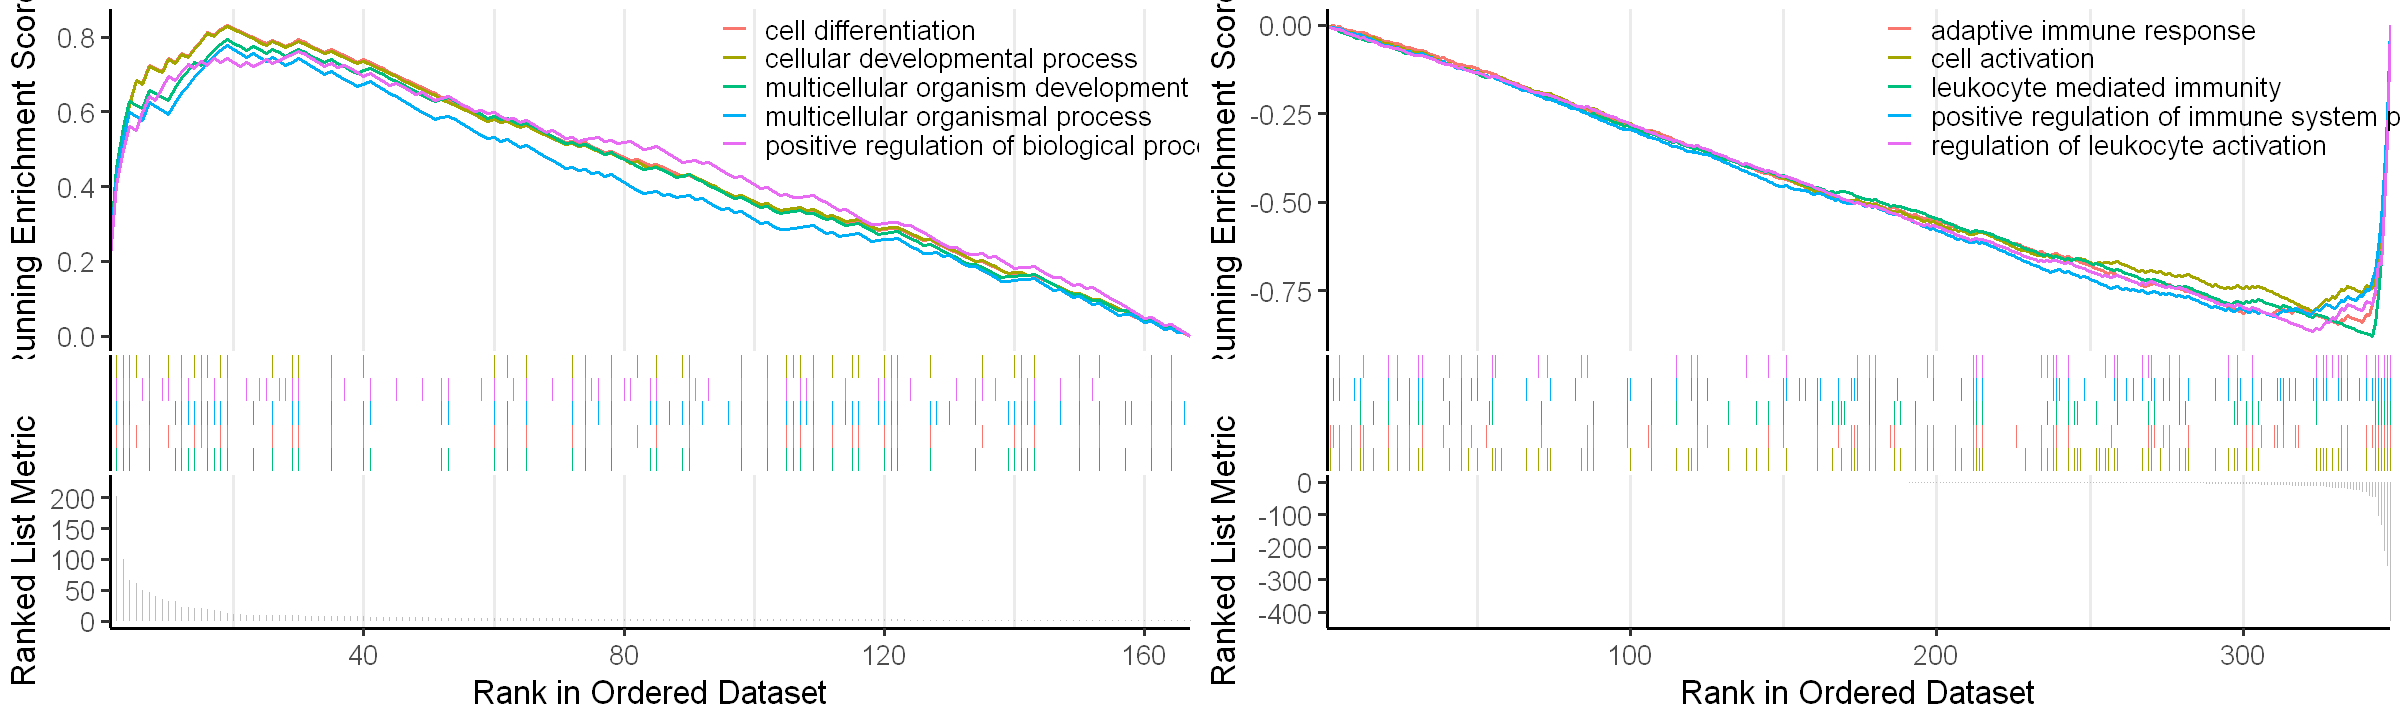

In [150]:
options(repr.plot.width = 20, repr.plot.height = 6)
ggarrange(gsea.1, gsea.2, nrow = 1)
ggsave(file.path(out.figs.dir, 'gsea.anno.pdf'), width = 18, height = 7)

### Mutation analysis

In [ ]:
library(maftools)
library(TCGAbiolinks)
BRACmut <- GDCquery_Maf(tumor = "BRCA", pipelines = "mutect2")

In [164]:
mut.barcode <- substr(BRACmut$Tumor_Sample_Barcode, 1, 12)
idx.high <- which(mut.barcode %in% (subset(tcga.obj.sub, Group == 'High risk') %>% Cells %>% substr(., 1, 12)))
idx.low <- which(mut.barcode %in% (subset(tcga.obj.sub, Group == 'Low risk') %>% Cells %>% substr(., 1, 12)))
primary.brac <- read.maf(maf = BRACmut[idx.high, ])
relapse.brac <- read.maf(maf = BRACmut[idx.low, ])

-Validating
-Silent variants: 9552 
-Summarizing
--Possible FLAGS among top ten genes:
  TTN
  MUC16
  FLG
-Processing clinical data
--Missing clinical data
-Finished in 3.380s elapsed (1.540s cpu) 
-Validating
-Silent variants: 35495 
-Summarizing
--Possible FLAGS among top ten genes:
  TTN
  MUC16
  HMCN1
  USH2A
-Processing clinical data
--Missing clinical data
-Finished in 9.970s elapsed (9.630s cpu) 


png 
  2

Hugo_Symbol High risk Low risk pval         or        ci.up      ci.low   
1 ERBB3       11          8      3.866713e-05 7.4193866 21.6264536 2.6677619
2 FMN2        12         15      4.708113e-04 4.3128773 10.0960972 1.8041102
3 CDH1        10        128      1.144698e-03 0.3583434  0.7022034 0.1638182
4 DNAH10      10         15      3.748031e-03 3.5476364  8.6263010 1.3972208
5 MIA3         8         11      6.625547e-03 3.8379871 10.6766250 1.3171137
6 FOXA1        9         14      7.074169e-03 3.4028960  8.6150640 1.2749707
  adjPval   
1 0.03248039
2 0.19774075
3 0.32051555
4 0.78708654
5 0.99038359
6 0.99038359

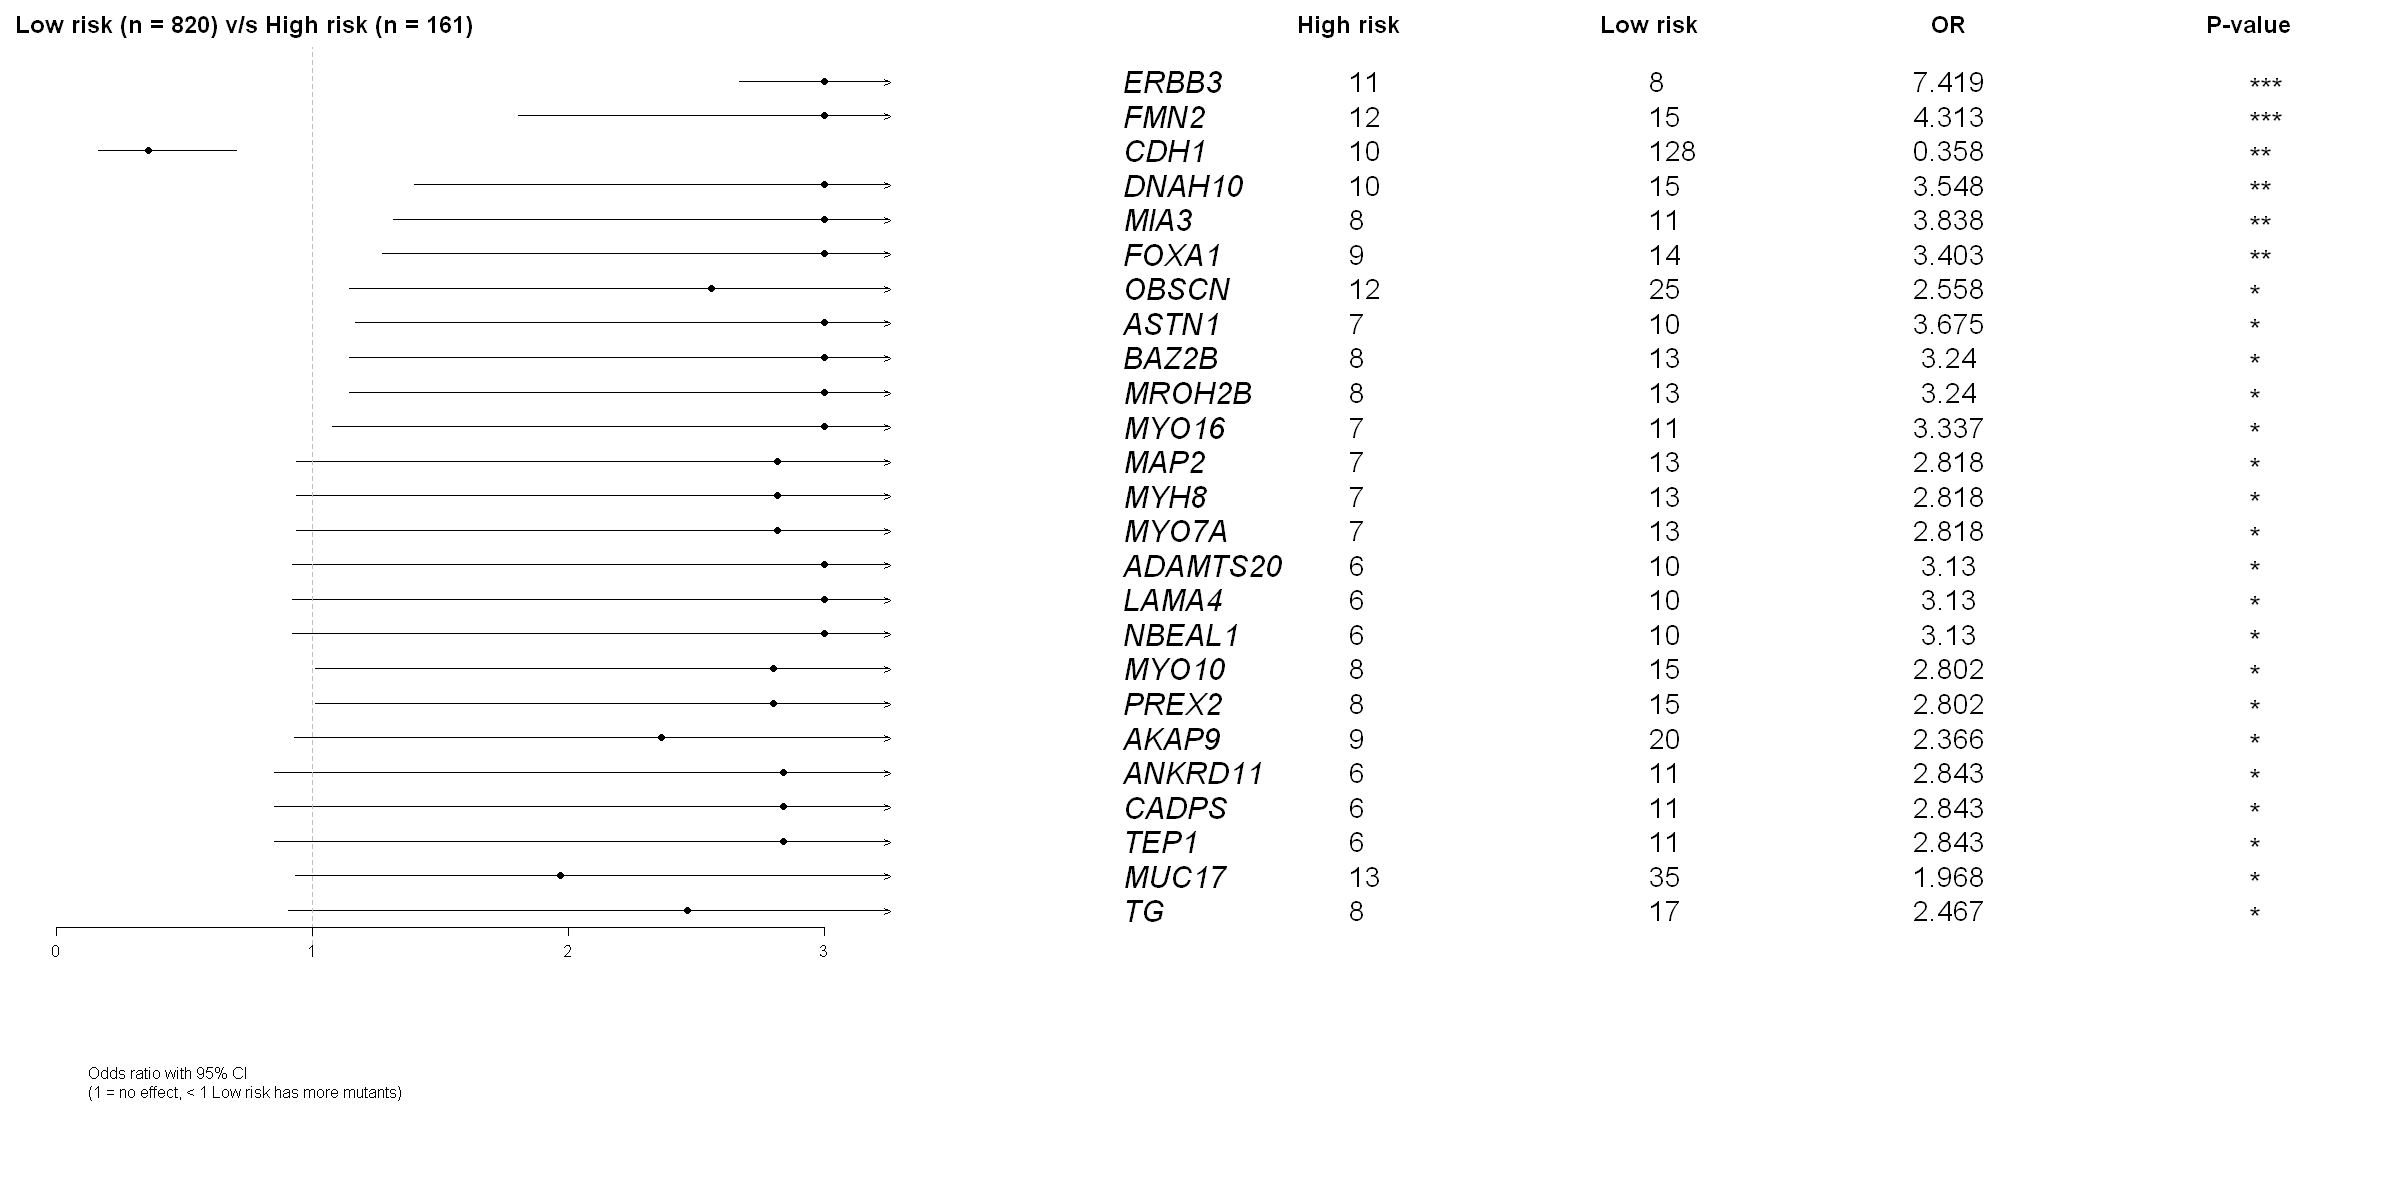

In [234]:
options(repr.plot.width = 20, repr.plot.height = 10)
cols <- unlist(PAIRWISE_COLORS)
names(cols) <- c('High risk', 'Low risk')
pdf(file.path(out.figs.dir, 'Mutation_high_vs_low.pdf'), height = 10, width = 8)
pt.vs.rt <- mafCompare(m1 = primary.brac, m2 = relapse.brac, m1Name = 'High risk', m2Name = 'Low risk', minMut = 10)
forestPlot(mafCompareRes = pt.vs.rt, pVal = 0.05, titleSize = 1.8, geneFontSize = 1.5)
dev.off()
pt.vs.rt$results %>% head
forestPlot(mafCompareRes = pt.vs.rt, pVal = 0.05, titleSize = 1.8, geneFontSize = 1.5) 

In [368]:
tab.plot <- subset(pt.vs.rt$results, pval < 0.01)[,1 : 7 ] %>% t

tab.plot[4, ] <- round(as.numeric(tab.plot[4, ]), 3)
tab.plot[5, ] <- round(as.numeric(tab.plot[5, ]), 3)
tab.plot[6, ] <- round(as.numeric(tab.plot[6, ]), 3)
tab.plot[7, ] <- round(as.numeric(tab.plot[7, ]), 3)
head(tab.plot)

[,1]   [,2]   [,3]  [,4]   [,5]   [,6] 
Hugo_Symbol ERBB3  FMN2   CDH1  DNAH10 MIA3   FOXA1
High risk   11     12     10    10      8      9   
Low risk      8     15    128    15     11     14  
pval        0      0      0.001 0.004  0.007  0.007
or          7.419  4.313  0.358 3.548  3.838  3.403
ci.up       21.626 10.096 0.702 8.626  10.677 8.615

In [369]:
tab.plot <- t(tab.plot)
colnames(tab.plot) <- c('Hugo_Symbol', 'High risk\n(count)', 'Low risk\n(count)', 'P-value', 'OR', 'CI.up', 'CI.low')

In [370]:
tab.plot <- tab.plot[, c('Hugo_Symbol', 'High risk\n(count)', 'Low risk\n(count)', 'OR', 'CI.up', 'CI.low', 'P-value')]

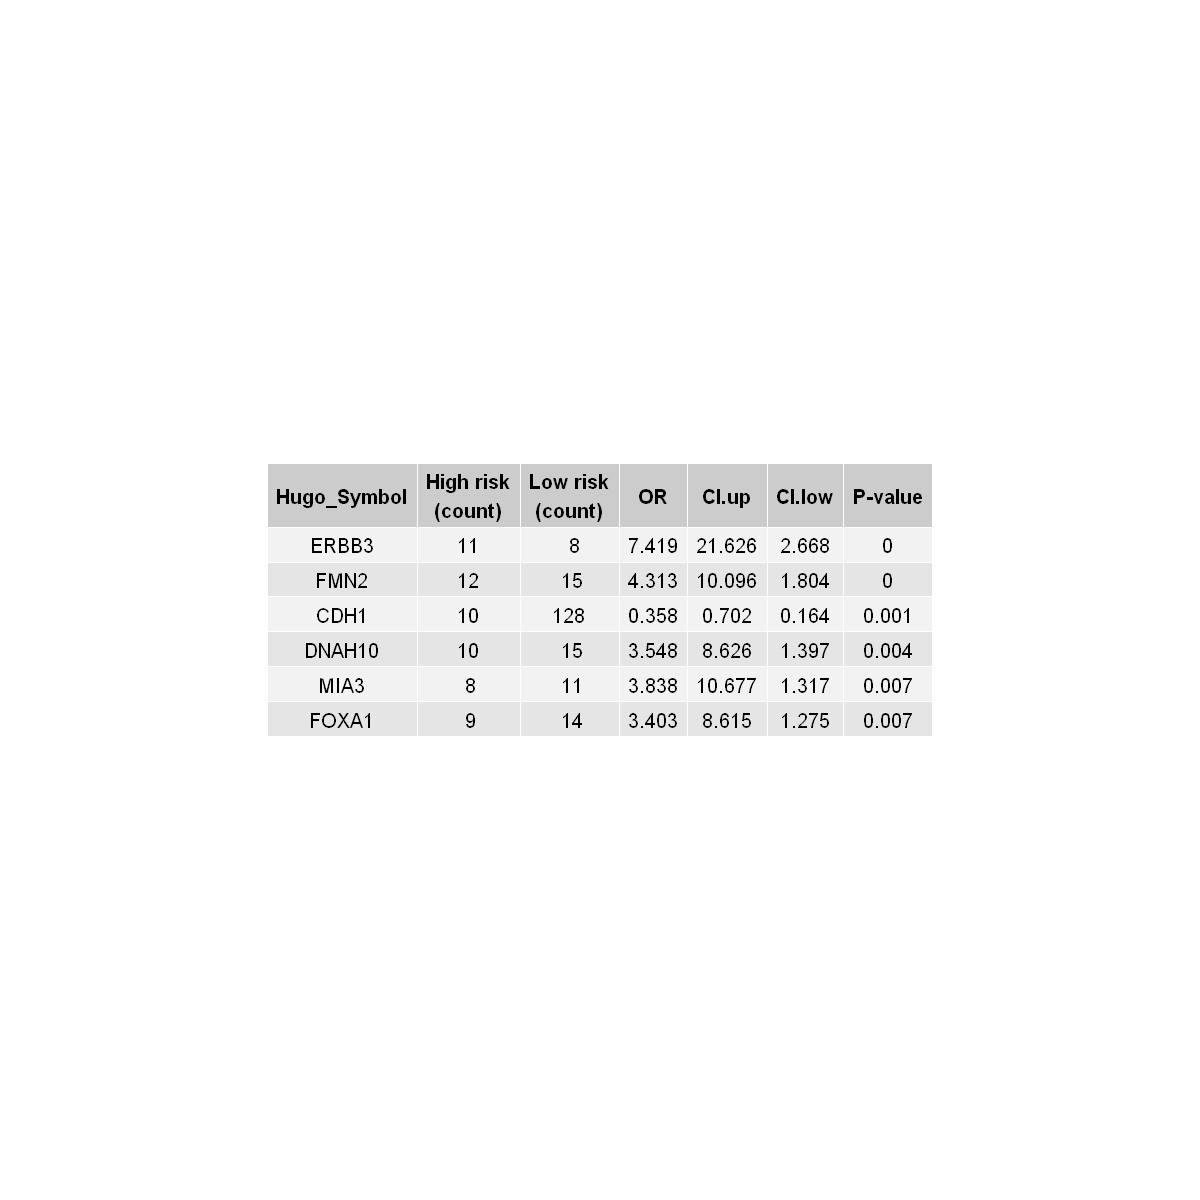

In [371]:
grid.table(tab.plot)

In [372]:
pdf(file.path(out.figs.dir, 'sig.mut.genes.pdf'), width = 6, height = 10)
grid.table(tab.plot)
dev.off()

png 
  2

png 
  2

png 
  2

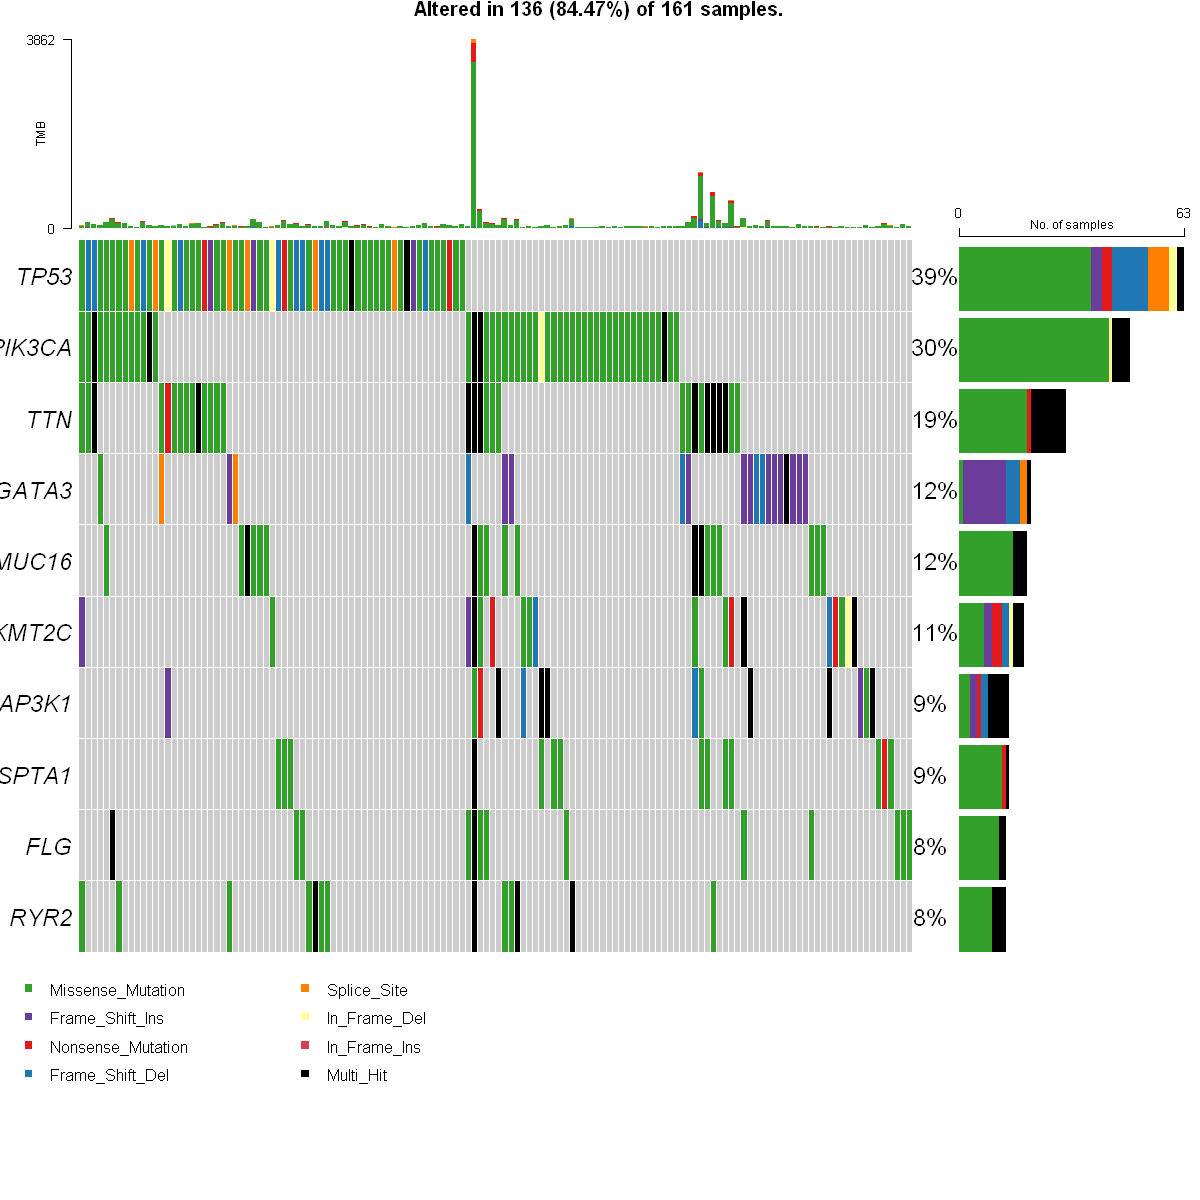

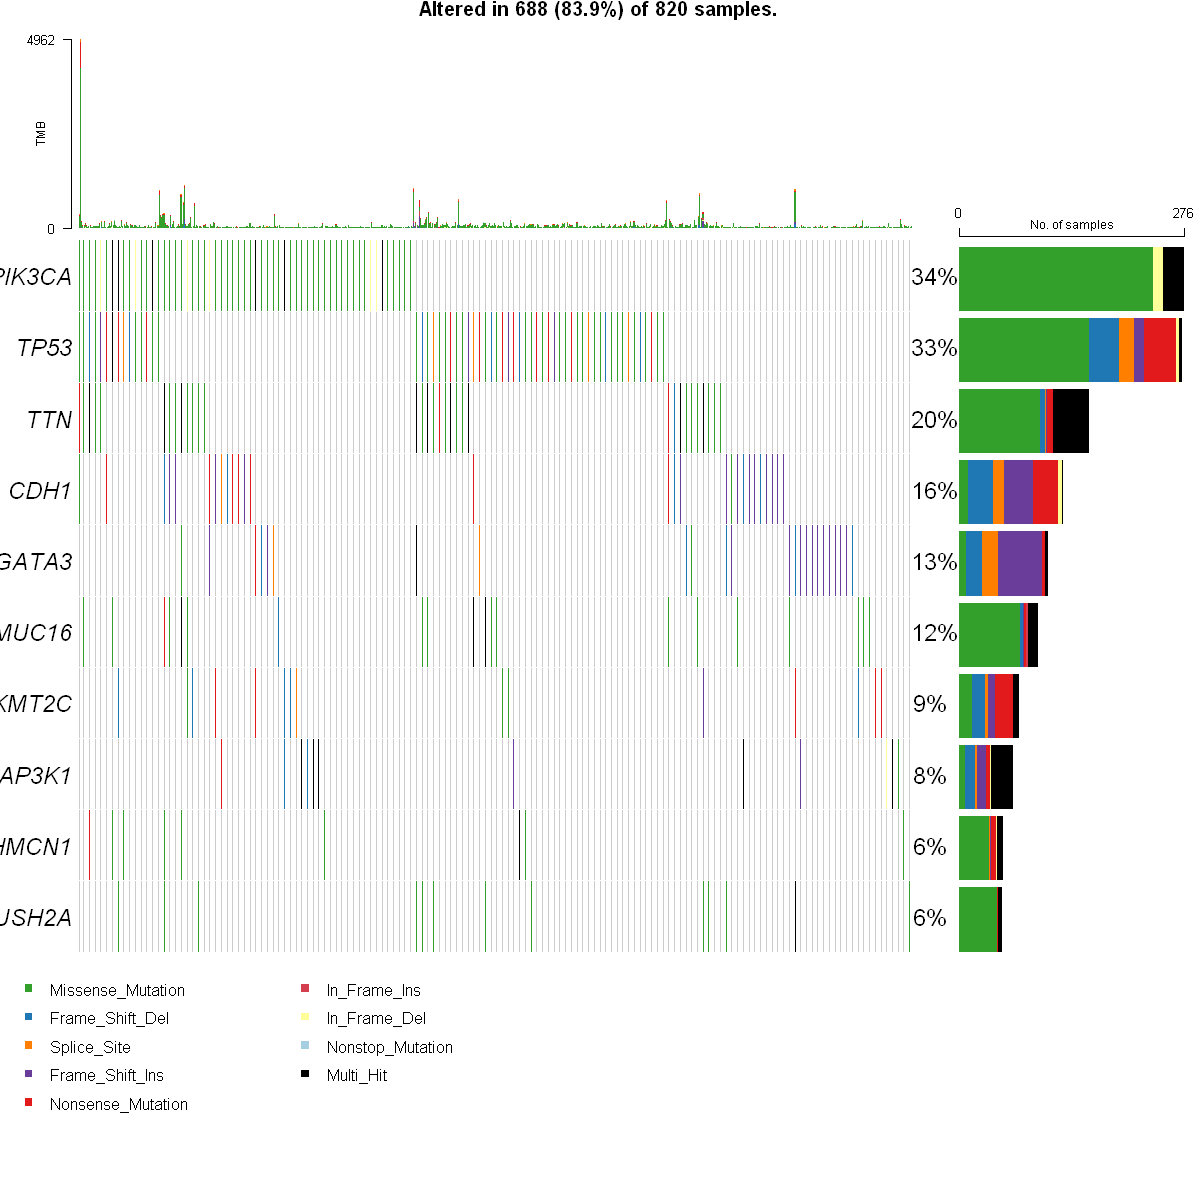

In [320]:
options(repr.plot.width = 10, repr.plot.height = 10)
pdf(file.path(out.figs.dir, 'oncoplot.high.risk.pdf'), height = 8, width = 8)
oncoplot(maf = primary.brac, top = 10, fontSize = 1.0, legendFontSize = 1.5, annotationFontSize = 1.5)
dev.off()
oncoplot(maf = primary.brac, top = 10, fontSize = 1.2)

pdf(file.path(out.figs.dir, 'oncoplot.low.risk.pdf'), height = 8, width = 8)
oncoplot(maf = relapse.brac, top = 10, fontSize = 1.0, legendFontSize = 1.5, annotationFontSize = 1.5)
dev.off()
oncoplot(maf = relapse.brac, top = 10, fontSize = 1.2)

-Validating
-Silent variants: 45177 
-Summarizing
--Possible FLAGS among top ten genes:
  TTN
  MUC16
  HMCN1
-Processing clinical data
--Missing clinical data
-Finished in 15.4s elapsed (13.6s cpu) 


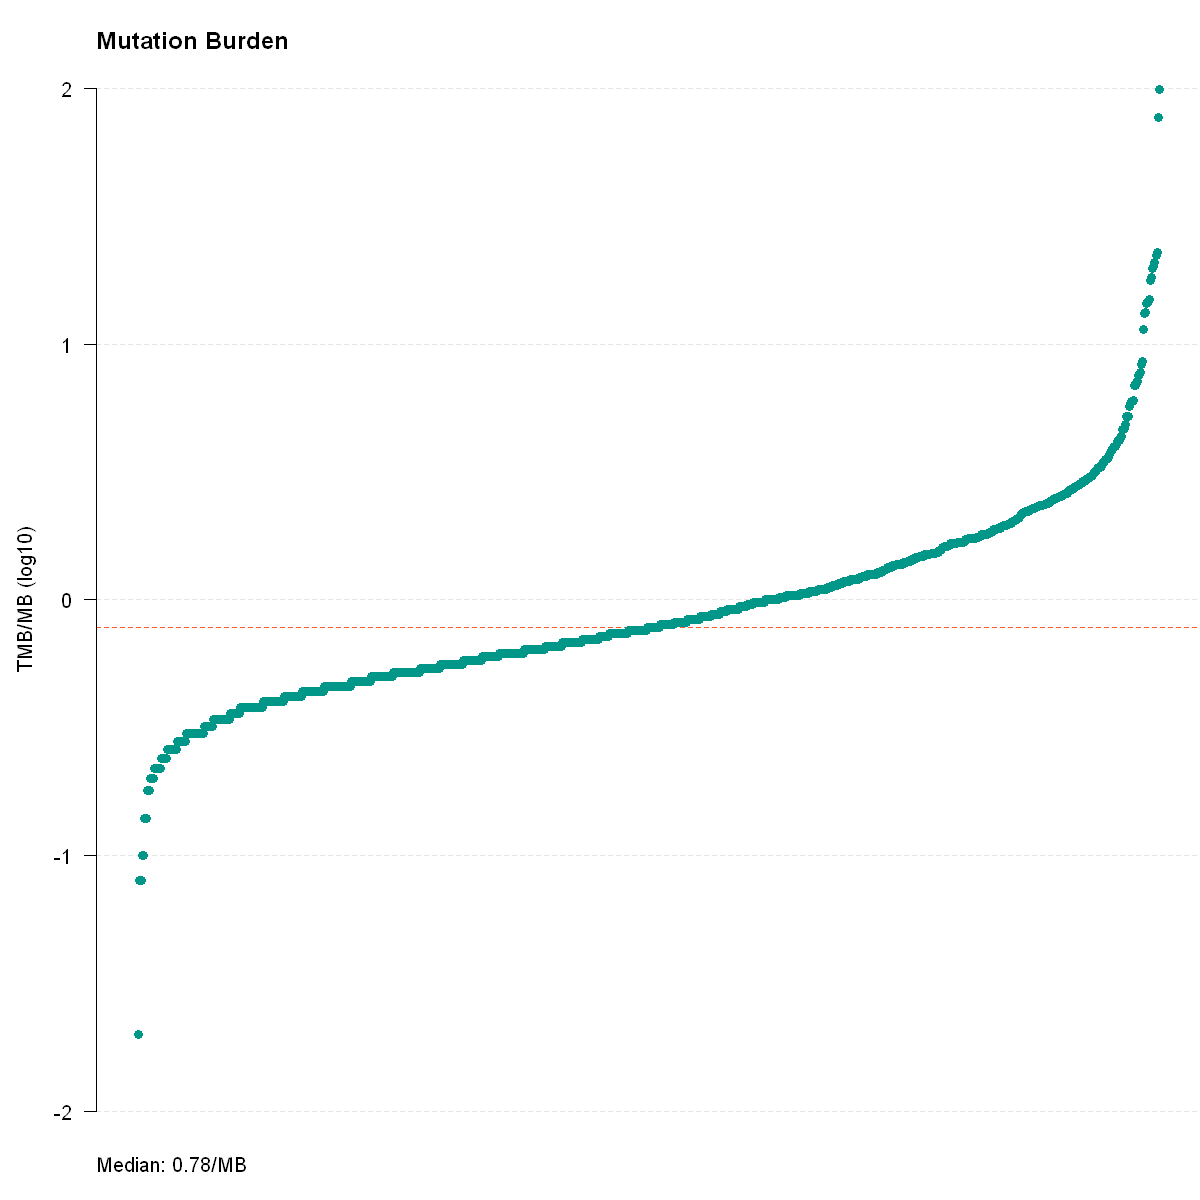

In [237]:
maf.brac <- read.maf(maf = BRACmut)
tmb.bc <- tmb(maf.brac, captureSize = 50, logScale = TRUE)

In [252]:
tmb.bc %>% head

Tumor_Sample_Barcode         total total_perMB total_perMB_log
1 TCGA-AC-A2FK-01A-12D-A17W-09 0     0.00            -Inf       
2 TCGA-A8-A08C-01A-11W-A019-09 1     0.02        -1.69897       
3 TCGA-AO-A1KO-01A-31D-A188-09 4     0.08        -1.09691       
4 TCGA-PL-A8LY-01A-11D-A41F-09 4     0.08        -1.09691       
5 TCGA-A2-A25F-01A-11D-A167-09 5     0.10        -1.00000       
6 TCGA-LL-A440-01A-11D-A243-09 5     0.10        -1.00000

In [284]:
risk.socres.sub <- risk.socres[, !duplicated(substr(colnames(risk.socres), 1, 12))]
length(risk.socres.sub)

[1] 1091

In [287]:
tmb.bc.sub <- tmb.bc[!duplicated(substr(tmb.bc$Tumor_Sample_Barcode, 1, 12)), ] %>% as.data.frame
dim(tmb.bc.sub)
rownames(tmb.bc.sub) <- substr(tmb.bc.sub$Tumor_Sample_Barcode, 1, 12)

[1] 986   4

In [288]:
head(tmb.bc.sub)

Tumor_Sample_Barcode         total total_perMB total_perMB_log
TCGA-AC-A2FK TCGA-AC-A2FK-01A-12D-A17W-09 0     0.00            -Inf       
TCGA-A8-A08C TCGA-A8-A08C-01A-11W-A019-09 1     0.02        -1.69897       
TCGA-AO-A1KO TCGA-AO-A1KO-01A-31D-A188-09 4     0.08        -1.09691       
TCGA-PL-A8LY TCGA-PL-A8LY-01A-11D-A41F-09 4     0.08        -1.09691       
TCGA-A2-A25F TCGA-A2-A25F-01A-11D-A167-09 5     0.10        -1.00000       
TCGA-LL-A440 TCGA-LL-A440-01A-11D-A243-09 5     0.10        -1.00000

In [289]:
names(risk.socres.sub) <- substr(names(risk.socres.sub), 1, 12)

In [290]:
tmb.bc.sub %>% dim

[1] 986   4

In [291]:
comm.SN <- intersect(names(risk.socres.sub), rownames(tmb.bc.sub))
risk.socres.sub <- risk.socres.sub[comm.SN]
tmb.bc.sub <- data.frame(tmb.bc.sub)[comm.SN, ]
head(tmb.bc.sub)

Tumor_Sample_Barcode         total total_perMB total_perMB_log
TCGA-E2-A15G TCGA-E2-A15G-01A-11D-A12B-09 50    1.00         0.0000000     
TCGA-E2-A1B5 TCGA-E2-A1B5-01A-21D-A12Q-09 27    0.54        -0.2676062     
TCGA-EW-A2FS TCGA-EW-A2FS-01A-11D-A17D-09 33    0.66        -0.1804561     
TCGA-EW-A1P7 TCGA-EW-A1P7-01A-21D-A142-09 19    0.38        -0.4202164     
TCGA-LL-A5YO TCGA-LL-A5YO-01A-21D-A28B-09 39    0.78        -0.1079054     
TCGA-BH-A1FN TCGA-BH-A1FN-01A-11D-A13L-09 92    1.84         0.2648178

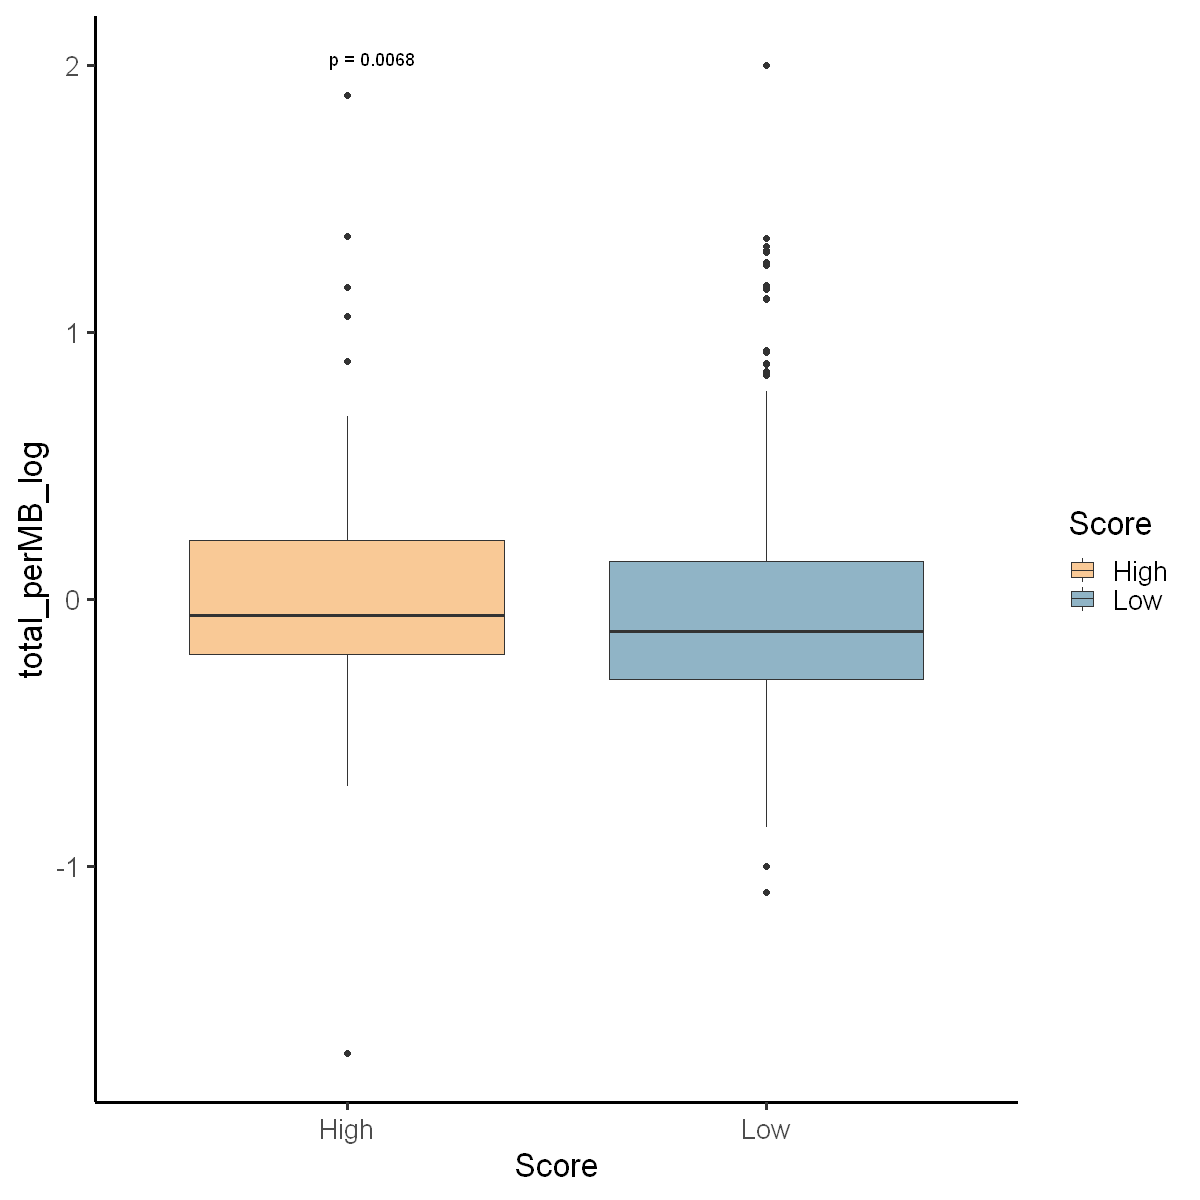

In [322]:
plot.df.tmp <- cbind.data.frame(tmb.bc.sub, Score = ifelse(risk.socres.sub > res.cox$cutoff, 'High', 'Low'))
names(cols) <- c('High', 'Low')
ggplot(plot.df.tmp, aes(x = Score, y = total_perMB_log, fill = Score)) + geom_boxplot() + theme_classic(base_size = 20) + stat_compare_means(label = "p.format") + scale_fill_manual(values = cols)
ggsave(file.path(out.figs.dir, 'tmp.high.vs.low.pdf'), height = 6, width = 6)

In [330]:
head(plot.df.tmp)

Tumor_Sample_Barcode         total total_perMB total_perMB_log
TCGA-E2-A15G TCGA-E2-A15G-01A-11D-A12B-09 50    1.00         0.0000000     
TCGA-E2-A1B5 TCGA-E2-A1B5-01A-21D-A12Q-09 27    0.54        -0.2676062     
TCGA-EW-A2FS TCGA-EW-A2FS-01A-11D-A17D-09 33    0.66        -0.1804561     
TCGA-EW-A1P7 TCGA-EW-A1P7-01A-21D-A142-09 19    0.38        -0.4202164     
TCGA-LL-A5YO TCGA-LL-A5YO-01A-21D-A28B-09 39    0.78        -0.1079054     
TCGA-BH-A1FN TCGA-BH-A1FN-01A-11D-A13L-09 92    1.84         0.2648178     
             Score     
TCGA-E2-A15G  0.2203707
TCGA-E2-A1B5 -1.1014146
TCGA-EW-A2FS -0.3787754
TCGA-EW-A1P7 -0.8431213
TCGA-LL-A5YO  0.6170595
TCGA-BH-A1FN  1.7747969

`geom_smooth()` using formula 'y ~ x'



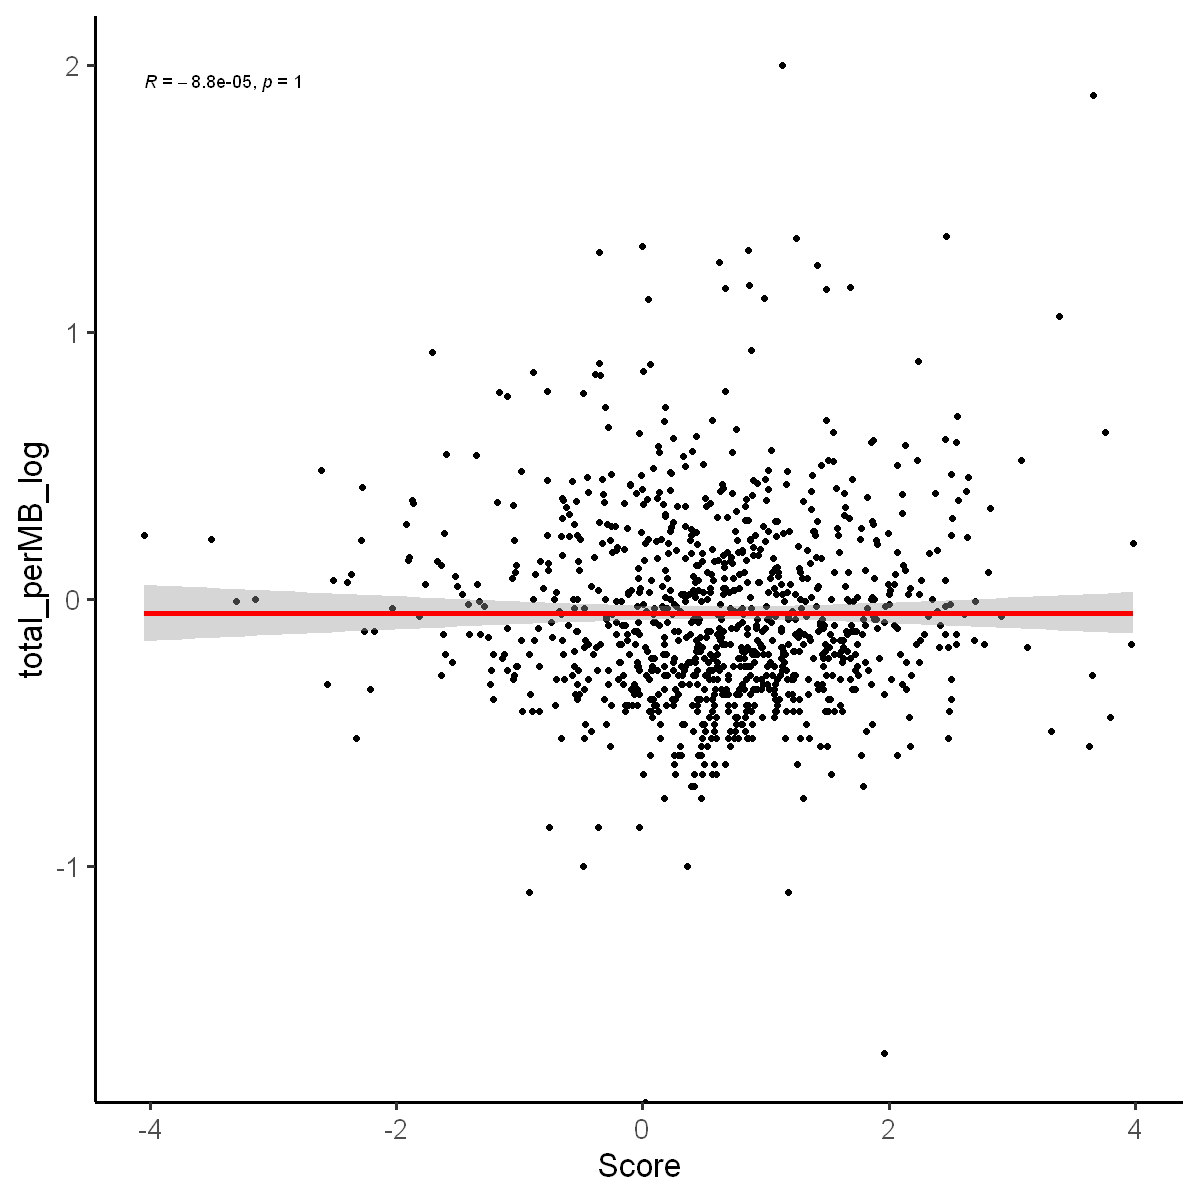

In [333]:
plot.df.tmp <- cbind.data.frame(tmb.bc.sub, Score = risk.socres.sub)
names(cols) <- c('High', 'Low')
ggplot(plot.df.tmp, aes(x = Score, y = total_perMB_log, fill = Score)) + geom_point() + geom_smooth(method = "lm", se = T, color = 'red', lwd = 1.5) + stat_cor(method="pearson") + theme_classic(base_size = 20) + theme(legend.position = 'none')
#ggsave(file.path(out.figs.dir, 'tmp.high.vs.low.pdf'), height = 6, width = 6)

###  Correlation with markers of Fiblasts cell

In [132]:
tmp.xls <- file.path(out.data.dir, 'tmp_training_data.xls')
tmp.gct <- file.path(out.data.dir, 'tmp_training_data.gct')
tmp.score <- file.path(out.data.dir, 'tmp_immune_scores.gct')

write.table(GetAssayData(tcga.obj.sub) %>% as.matrix %>% { log2(1 + .)}, tmp.xls, sep = '\t', row.names = TRUE, col.names = NA, quote = FALSE)

In [133]:
library(estimate)
filterCommonGenes(tmp.xls, output.f = tmp.gct, id = "GeneSymbol")
estimateScore(tmp.gct, tmp.score, platform  = 'affymetrix')
purity.score <- read.table(tmp.score, sep = '\t', header = TRUE, row.names = 1, skip = 2) %>% .[, -1] 

[1] "Merged dataset includes 10214 genes (198 mismatched)."
[1] "1 gene set: StromalSignature  overlap= 139"
[1] "2 gene set: ImmuneSignature  overlap= 141"


In [135]:
purity.score.t <- purity.score %>% t
head(purity.score.t)

StromalScore ImmuneScore ESTIMATEScore TumorPurity
TCGA.E2.A15G.01A.11R.A12D.07 -194.46335    -89.87435  -284.3377     0.8455244  
TCGA.E2.A1B5.01A.21R.A12P.07  829.19480   2673.47073  3502.6655     0.4364583  
TCGA.EW.A2FS.01A.11R.A17B.07   89.66423    806.83986   896.5041     0.7407679  
TCGA.EW.A1P7.01A.21R.A144.07 1154.16065   2669.38048  3823.5411     0.3936121  
TCGA.LL.A5YO.01A.21R.A28M.07  712.35812   2842.81553  3555.1736     0.4295107  
TCGA.BH.A1FN.01A.11R.A13Q.07  348.58867     75.83553   424.4242     0.7855030

In [136]:
fib.genes <- list('Fibroblasts' = c('COL1A1','COL3A1','COL6A1','COL6A2','DCN','GREM1','PAMR1','TAGLN'))
end.genes <- c('ACVRL1','APLN','BCL6B','BMP6','BMX','CDH5','CLEC14A','CXorf36','EDN1','ELTD1','EMCN','ESAM','ESM1','HECW2','HHIP','KDR','MMRN1','MMRN2','MYCT1','PALMD','PEAR1','PGF','PLXNA2','PTPRB','ROBO4','SDPR','SHANK3','SHE','TEK','TIE1','VEPH1','VWF')

In [146]:
head(plot.data.fib)

Fibroblasts Risk       Group    
1  -89.87435   0.2203707 Low risk 
2 2673.47073  -1.1014146 Low risk 
3  806.83986  -0.3787754 Low risk 
4 2669.38048  -0.8431213 Low risk 
5 2842.81553   0.6170595 Low risk 
6   75.83553   1.7747969 High risk

`geom_smooth()` using formula 'y ~ x'



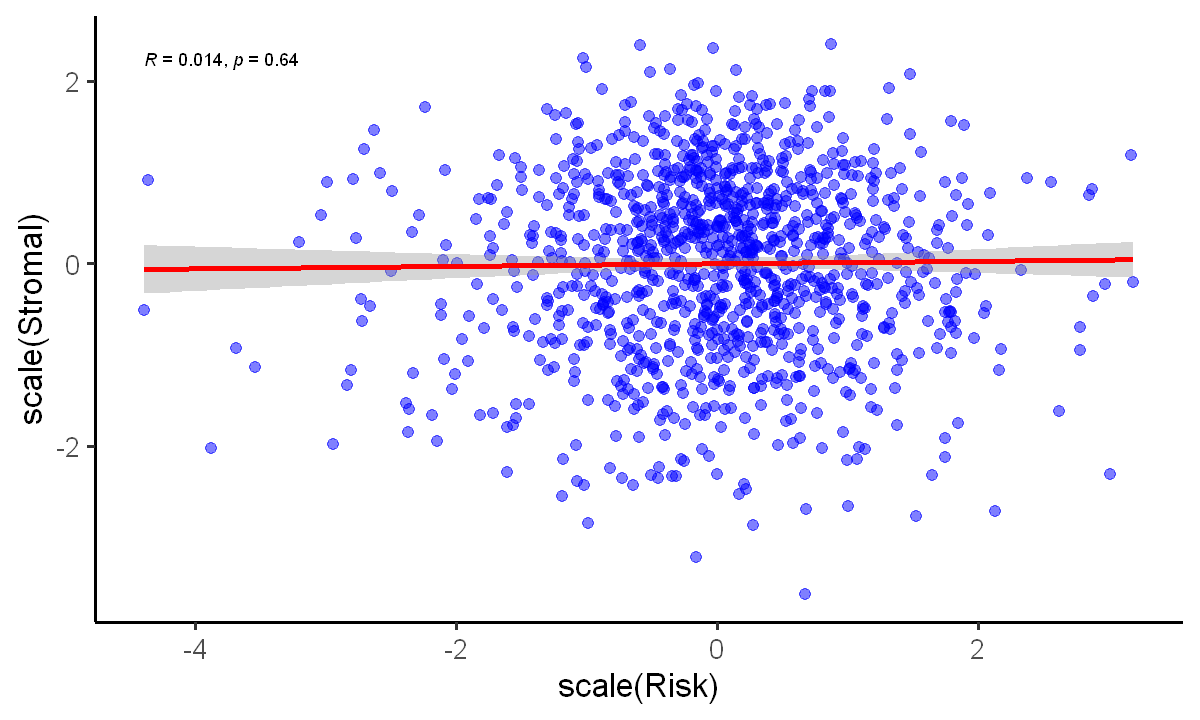

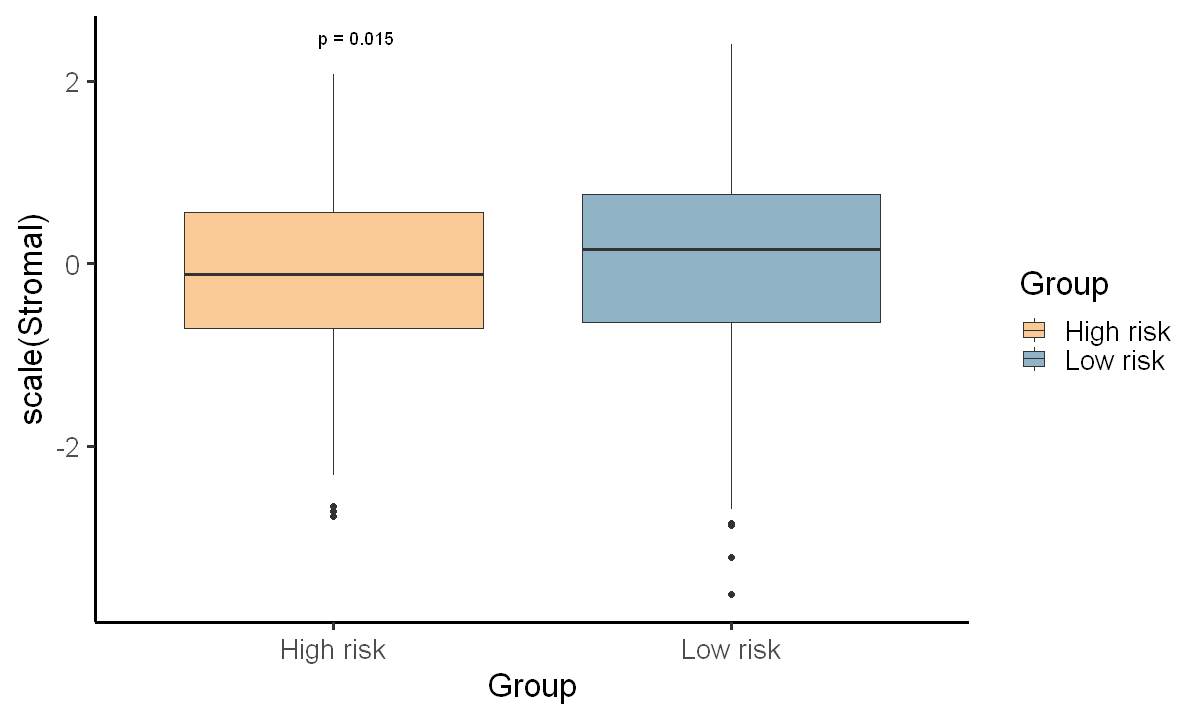

In [170]:
options(repr.plot.width = 10, repr.plot.height = 6)
cols <- unlist(PAIRWISE_COLORS)
names(cols) <- c('High risk', 'Low risk')
plot.data.fib <- cbind.data.frame(Stromal =  as.vector(purity.score.t[, 1]), Risk = as.vector(risk.socres), Group = res.cox$group)
ggplot(plot.data.fib, aes(x = scale(Risk), y = scale(Stromal))) + geom_point(size = 3, alpha = 0.5, color = 'blue')+ geom_smooth(method = "lm", se = T, color = 'red', lwd = 1.5) + stat_cor(method="pearson") + theme_classic(base_size = 20) + theme(legend.position = 'none')
gp.1 <- ggplot(plot.data.fib, aes(x = Group, y = scale(Stromal), fill = Group)) + geom_boxplot() + theme_classic(base_size = 20) + stat_compare_means(label = "p.format") + scale_fill_manual(values = cols)
gp.1

`geom_smooth()` using formula 'y ~ x'



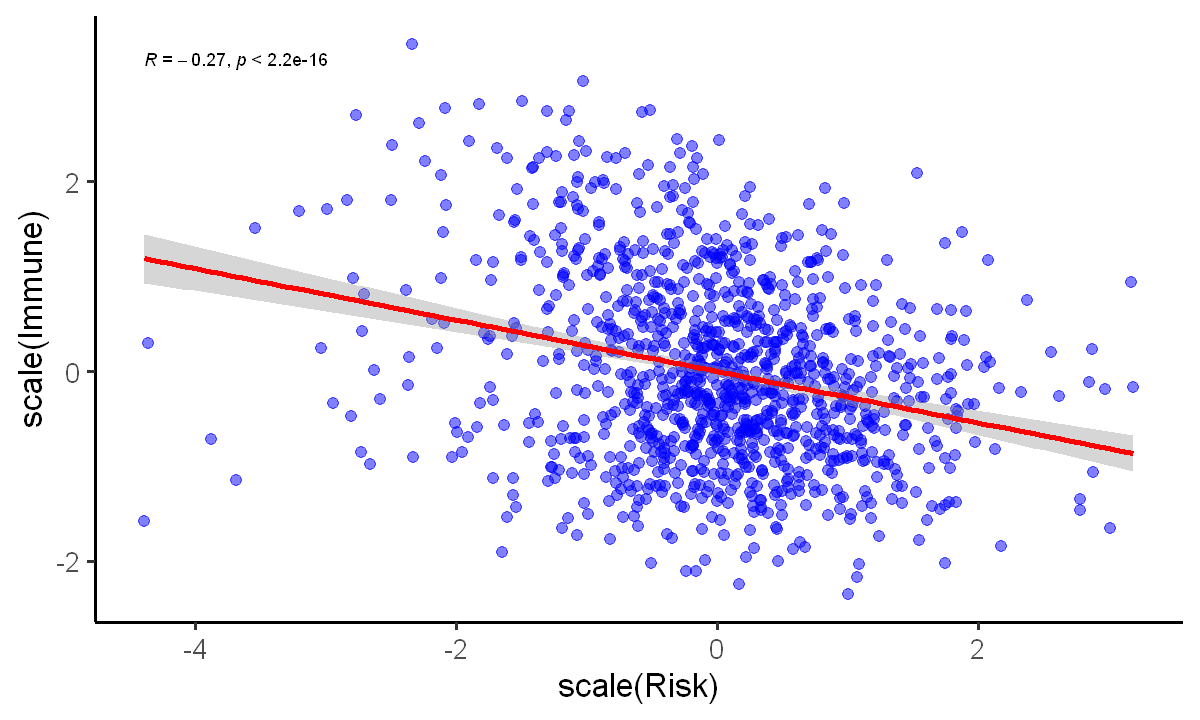

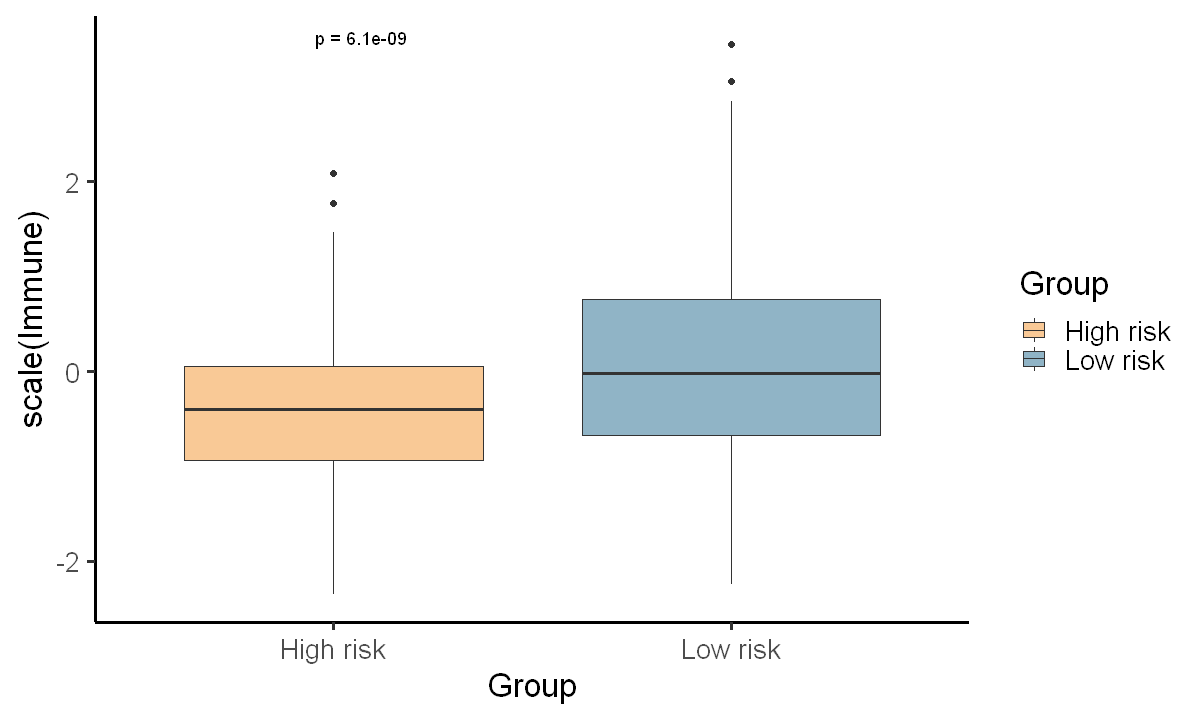

In [171]:
plot.data.fib <- cbind.data.frame(Immune =  as.vector(purity.score.t[, 2]), Risk = as.vector(risk.socres), Group = res.cox$group)
ggplot(plot.data.fib, aes(x = scale(Risk), y = scale(Immune))) + geom_point(size = 3, alpha = 0.5, color = 'blue')+ geom_smooth(method = "lm", se = T, color = 'red', lwd = 1.5) + stat_cor(method="pearson") + theme_classic(base_size = 20) + theme(legend.position = 'none')
gp.2 <- ggplot(plot.data.fib, aes(x = Group, y = scale(Immune), fill = Group)) + geom_boxplot() + theme_classic(base_size = 20) + stat_compare_means(label = "p.format") + scale_fill_manual(values = cols)
gp.2

`geom_smooth()` using formula 'y ~ x'



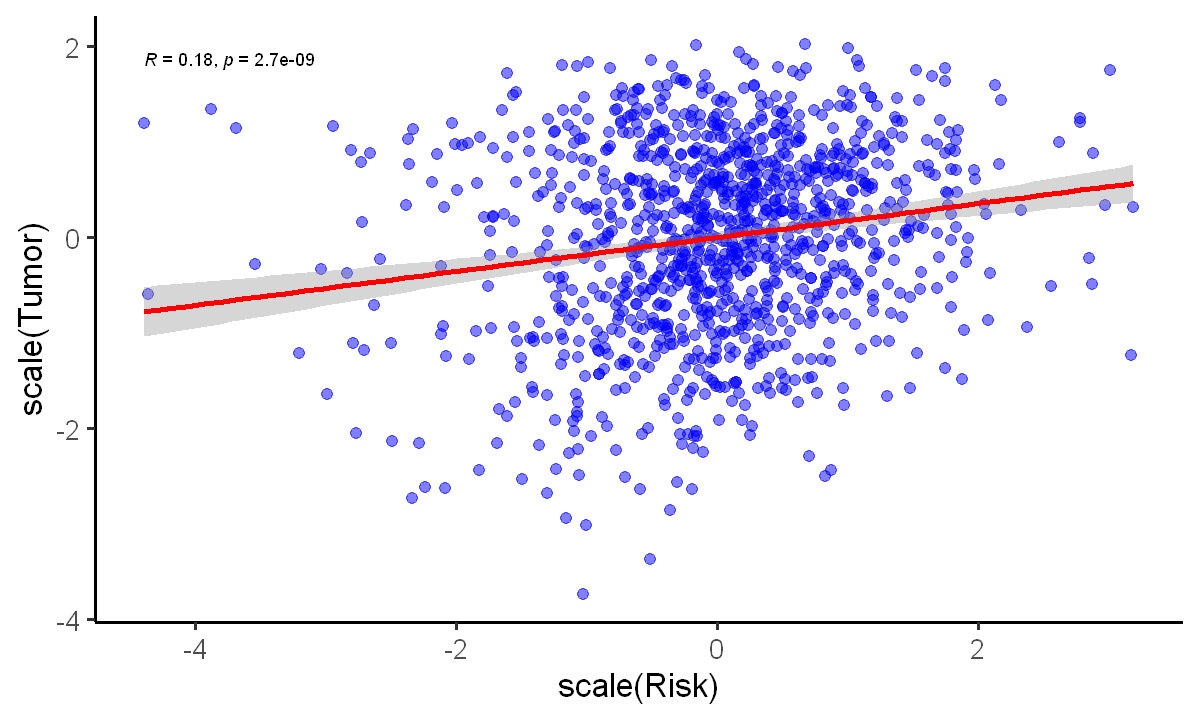

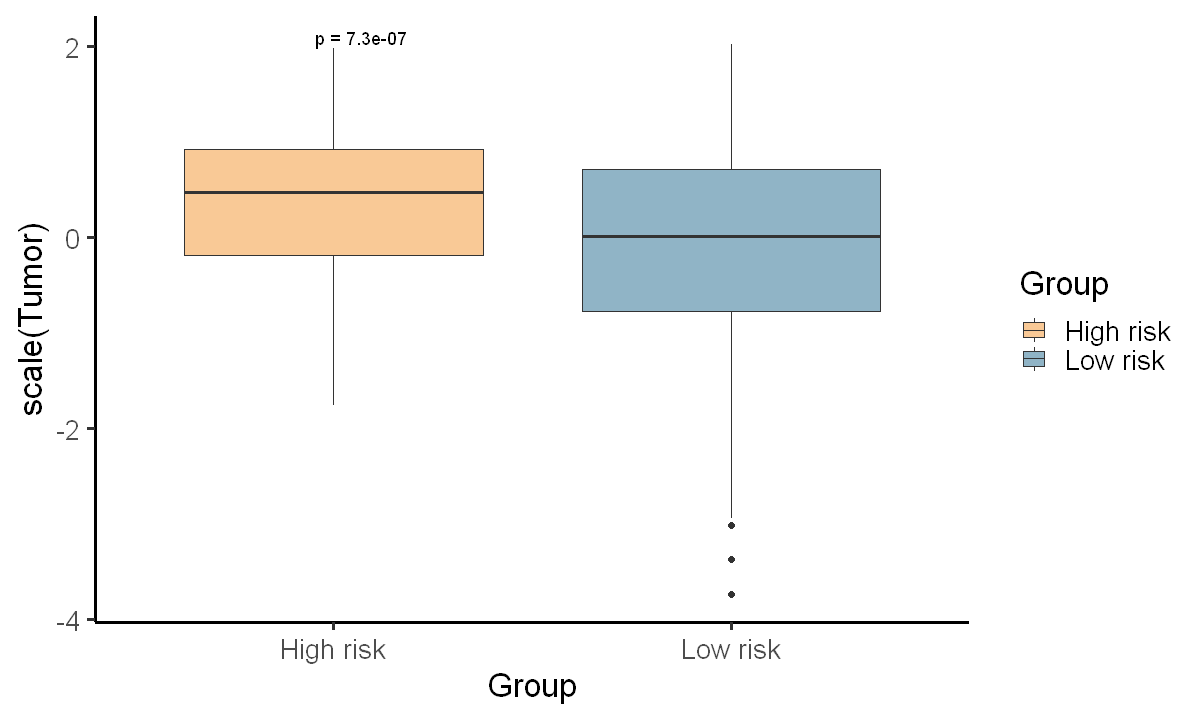

In [172]:
plot.data.fib <- cbind.data.frame(Tumor =  as.vector(purity.score.t[, 4]), Risk = as.vector(risk.socres), Group = res.cox$group)
ggplot(plot.data.fib, aes(x = scale(Risk), y = scale(Tumor))) + geom_point(size = 3, alpha = 0.5, color = 'blue')+ geom_smooth(method = "lm", se = T, color = 'red', lwd = 1.5) + stat_cor(method="pearson") + theme_classic(base_size = 20) + theme(legend.position = 'none')
gp.3 <- ggplot(plot.data.fib, aes(x = Group, y = scale(Tumor), fill = Group)) + geom_boxplot() + theme_classic(base_size = 20) + stat_compare_means(label = "p.format") + scale_fill_manual(values = cols)
gp.3

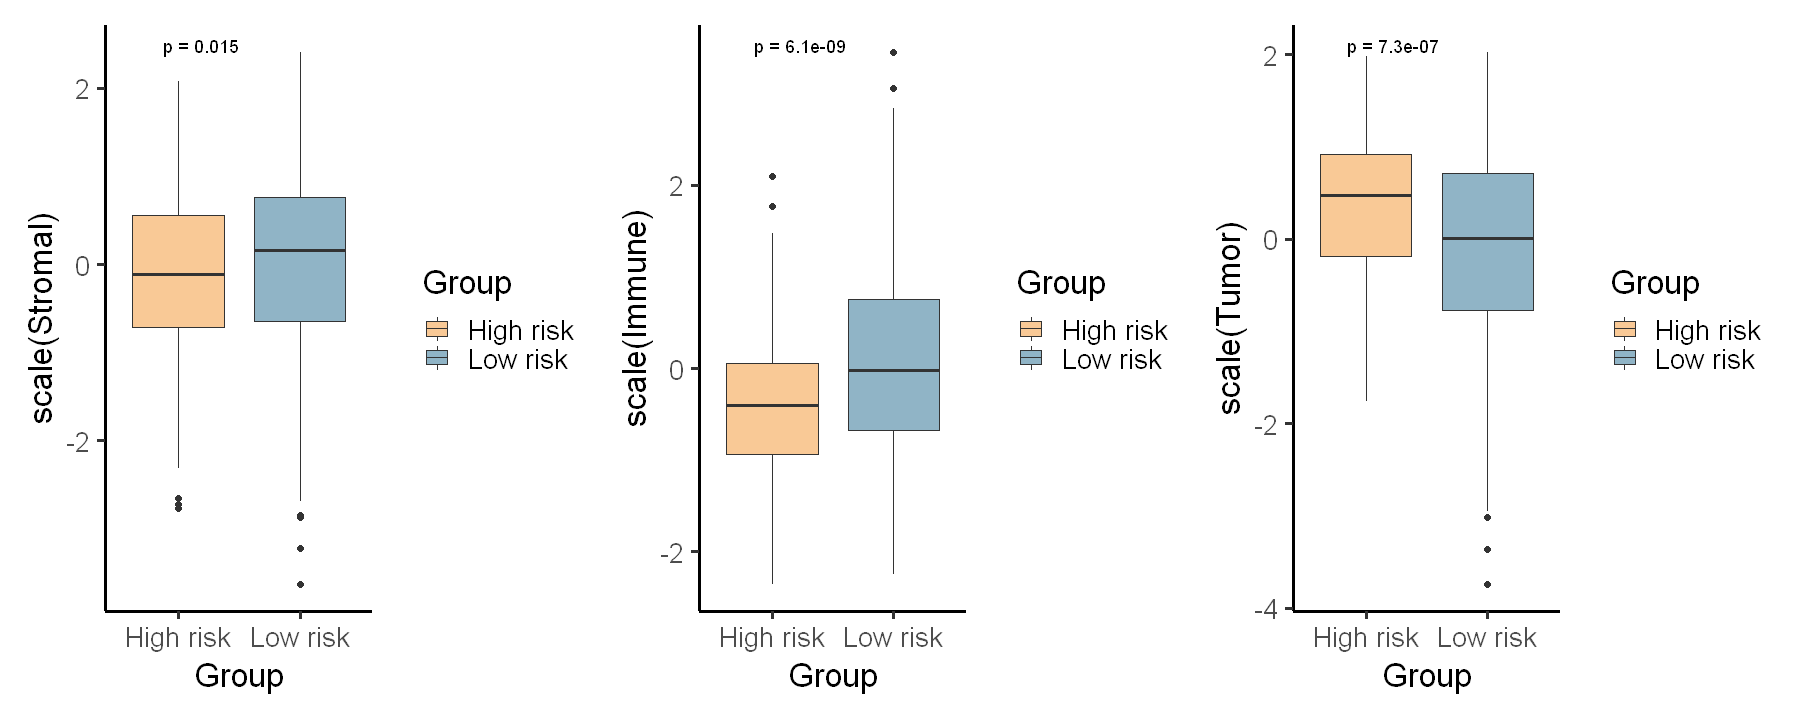

In [176]:
options(repr.plot.width = 15, repr.plot.height = 6)
gp.1 + gp.2 + gp.3
ggsave(file.path(out.figs.dir, 'estimate.brca.pdf'), width = 15, height = 6)

### lincRNA-mRNA networrk

In [59]:
anno <- read.table('../0.data/gencode.gene.info.v22.tsv', sep = '\t', header = T) %>% subset(., gene_type == 'protein_coding')
head(anno)
com.genes <- intersect(rownames(tcga.obj.sub),anno$gene_name)
length(com.genes)
#tcga.obj.sub.sub <- subset(tcga.obj.sub, features = com.genes)

gene_id            gene_name seqname start    end      strand gene_type     
7  ENSG00000206557.5  TRIM71    chr3    32818018 32897826 +      protein_coding
8  ENSG00000183813.6  CCR4      chr3    32951574 32956349 +      protein_coding
9  ENSG00000170266.14 GLB1      chr3    32996608 33097230 -      protein_coding
12 ENSG00000188167.7  TMPPE     chr3    33090421 33096801 -      protein_coding
14 ENSG00000170275.13 CRTAP     chr3    33113979 33147773 +      protein_coding
17 ENSG00000173705.7  SUSD5     chr3    33150042 33219215 -      protein_coding
   gene_status havana_gene          full_length exon_length exon_num
7  KNOWN       OTTHUMG00000155778.3  79809      8685          4     
8  KNOWN       OTTHUMG00000130752.2   4776      3095          2     
9  KNOWN       OTTHUMG00000155781.6 100623      4364        123     
12 KNOWN       OTTHUMG00000155779.1   6381      3966          4     
14 KNOWN       OTTHUMG00000130746.3  33795      6695         18     
17 KNOWN       OTTHUMG00000155829.2  69174      5008          9

[1] 19459

In [60]:
expr <- GetAssayData(tcga.obj.sub) %>% as.matrix %>% .[com.genes, ]

In [61]:
linc.mrna <- lapply(gsub('_', '-', hub.genes.sub), function(gene) {
    lnc.expr <- FetchData(tcga.obj.sub, vars = gene)
    cor.res <- cor(lnc.expr, expr %>% t)
    cor.res <- cor.res[1, ][order(cor.res[1, ]) %>% rev]
    cor.res <- cor.res[!is.na(cor.res)] 
    cor.res[1:50] %>% names
})

In [62]:
names(linc.mrna) <- hub.genes.sub

In [63]:
genes.map <- clusterProfiler::bitr(unlist(linc.mrna, use.names = F) %>% unique, fromType = "SYMBOL", toType = c("ENTREZID", "SYMBOL"), OrgDb = org.Hs.eg.db)
ego <- clusterProfiler::enrichGO(
    gene          = genes.map$ENTREZID %>% unique,
    OrgDb         = org.Hs.eg.db,
    ont           = "BP",
    pAdjustMethod = "BH",
    pvalueCutoff  = 0.01,
    qvalueCutoff  = 0.01,
    readable      = TRUE
)

'select()' returned 1:many mapping between keys and columns



In [64]:
data.frame(ego)

ID         Description                                GeneRatio
GO:0042110 GO:0042110 T cell activation                          58/1038  
GO:0050863 GO:0050863 regulation of T cell activation            40/1038  
GO:0050852 GO:0050852 T cell receptor signaling pathway          29/1038  
GO:0045059 GO:0045059 positive thymic T cell selection           7/1038   
GO:0050870 GO:0050870 positive regulation of T cell activation   29/1038  
GO:1903037 GO:1903037 regulation of leukocyte cell-cell adhesion 39/1038  
GO:0031295 GO:0031295 T cell costimulation                       13/1038  
GO:0045061 GO:0045061 thymic T cell selection                    8/1038   
GO:0071346 GO:0071346 cellular response to interferon-gamma      25/1038  
GO:0031294 GO:0031294 lymphocyte costimulation                   13/1038  
           BgRatio   pvalue       p.adjust     qvalue      
GO:0042110 474/18862 9.283775e-09 4.515628e-05 4.408327e-05
GO:0050863 327/18862 1.876032e-06 4.147984e-03 4.049419e-03
GO:0050852 204/18862 2.558378e-06 4.147984e-03 4.049419e-03
GO:0045059 14/18862  3.654224e-06 4.443537e-03 4.337949e-03
GO:0050870 212/18862 5.556663e-06 4.703347e-03 4.591585e-03
GO:1903037 330/18862 5.801826e-06 4.703347e-03 4.591585e-03
GO:0031295 57/18862  1.002652e-05 6.967002e-03 6.801452e-03
GO:0045061 22/18862  1.309751e-05 7.277702e-03 7.104768e-03
GO:0071346 177/18862 1.381567e-05 7.277702e-03 7.104768e-03
GO:0031294 59/18862  1.496238e-05 7.277702e-03 7.104768e-03
           geneID                                                                                                                                                                                                                                                                                                                                 
GO:0042110 GNRH1/VNN1/TGFBR2/DPP4/PAK3/NCK2/FZD7/MR1/KIF13B/RORC/PELI1/THY1/HHLA2/PLA2G2F/LIG4/IFNK/IFNE/PIK3R1/IFNA1/PTPN2/CD70/CCND3/TBX21/PDCD1/CD7/CD3D/CCL5/SLA2/CD2/CD8A/IFNG/SIRPG/IL12RB1/HLA-DRA/HLA-DPB1/LCK/ZAP70/CD74/IRF1/CD3E/TIGIT/CEBPB/LYN/LAG3/LGALS1/NLRC3/KLRK1/DOCK2/LAT/JAK3/CARD11/ITK/EOMES/CTLA4/RASAL3/WDFY4/PTPRC/GRAP2
GO:0050863 GNRH1/VNN1/TGFBR2/DPP4/PAK3/NCK2/PELI1/THY1/HHLA2/PLA2G2F/PIK3R1/PTPN2/CD70/TBX21/PDCD1/CCL5/CD2/IFNG/SIRPG/IL12RB1/HLA-DRA/HLA-DPB1/LCK/ZAP70/CD74/IRF1/CD3E/TIGIT/CEBPB/LYN/LAG3/LGALS1/KLRK1/LAT/JAK3/CARD11/CTLA4/RASAL3/PTPRC/GRAP2                                                                                               
GO:0050852 BTN1A1/TXK/PAK3/KCNN4/PVRIG/THY1/HHLA2/PIK3R1/PTPN2/CD3D/SLA2/HLA-DRA/HLA-DPB1/CD247/PSMB9/LCK/ZAP70/UBASH3A/CD3E/GBP1/PSMB8/PSME2/LAT/CARD11/ITK/CTLA4/LCP2/PTPRC/GRAP2                                                                                                                                                               
GO:0045059 PTPN2/CD3D/ZAP70/CD74/CD3E/DOCK2/PTPRC                                                                                                                                                                                                                                                                                                 
GO:0050870 VNN1/TGFBR2/DPP4/PAK3/NCK2/THY1/HHLA2/PIK3R1/CD70/PDCD1/CCL5/IFNG/SIRPG/IL12RB1/HLA-DRA/HLA-DPB1/LCK/ZAP70/CD74/CD3E/LYN/LGALS1/KLRK1/JAK3/CARD11/CTLA4/RASAL3/PTPRC/GRAP2                                                                                                                                                             
GO:1903037 GNRH1/VNN1/TGFBR2/DPP4/PAK3/NCK2/PELI1/THY1/HHLA2/PLA2G2F/PPARA/PIK3R1/PTPN2/CD70/TBX21/PDCD1/CCL5/IFNG/SIRPG/IL12RB1/HLA-DRA/HLA-DPB1/LCK/ZAP70/CD74/IRF1/CD3E/TIGIT/CEBPB/LYN/LAG3/LGALS1/KLRK1/JAK3/CARD11/CTLA4/RASAL3/PTPRC/GRAP2                                                                                                 
GO:0031295 DPP4/PAK3/HHLA2/PIK3R1/PDCD1/LCK/CD3E/LYN/LGALS1/KLRK1/CARD11/CTLA4/GRAP2                                                                     

In [65]:
edox <- setReadable(ego, 'org.Hs.eg.db', 'ENTREZID')

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



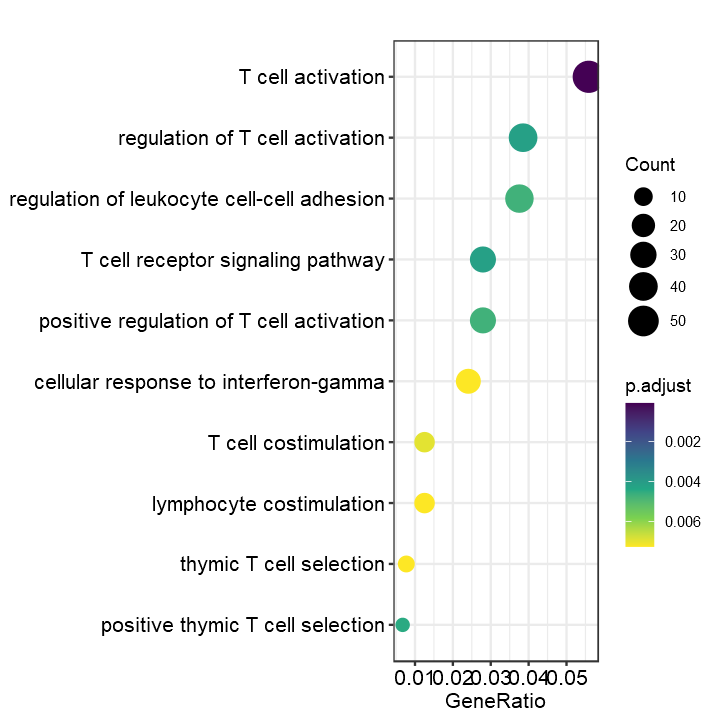

In [66]:
options(repr.plot.width = 6, repr.plot.height = 6)
dotplot(ego, showCategory=30) + scale_color_viridis_c(guide=guide_colorbar(reverse=TRUE))
ggsave(file.path(out.figs.dir, 'go.anno.linc.pdf'), width = 6, height = 6)

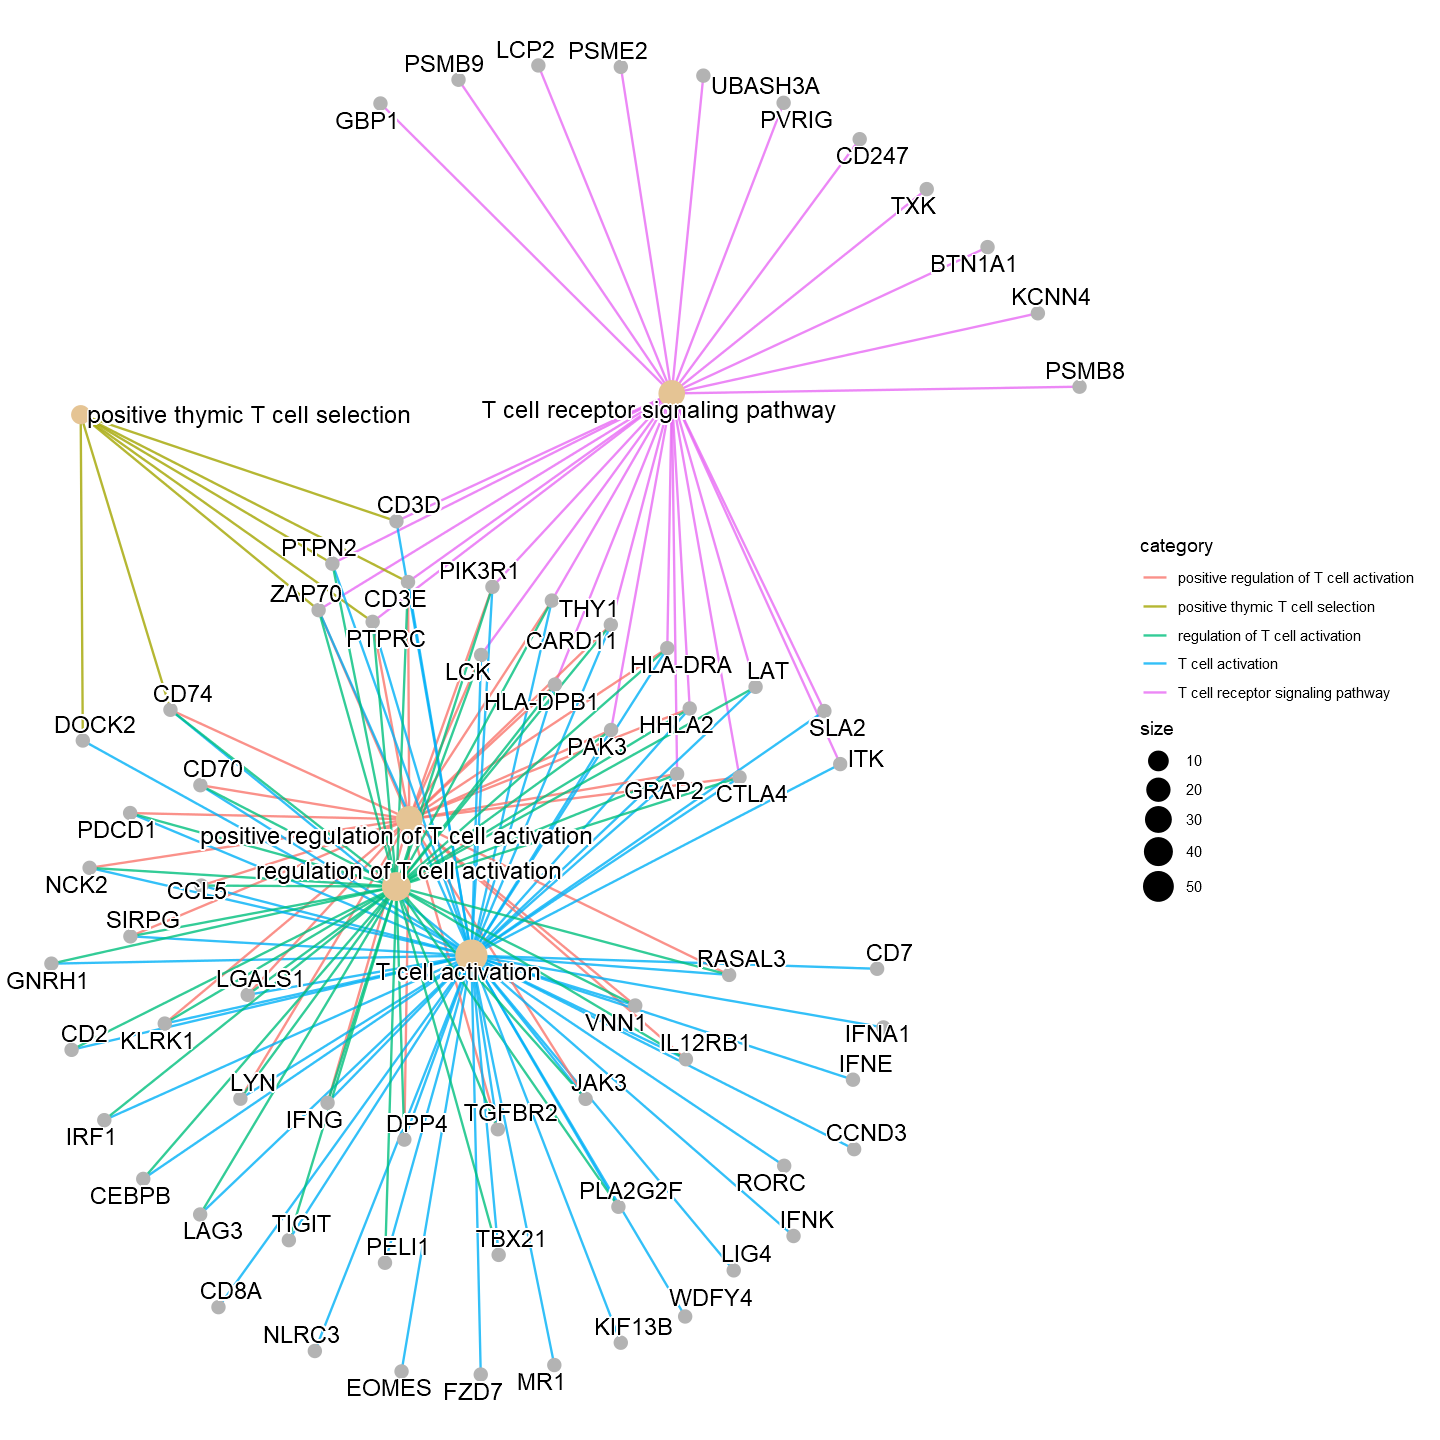

In [69]:
options(repr.plot.width = 12, repr.plot.height = 12)
cnetplot(edox, categorySize="pvalue", colorEdge = TRUE) 

In [71]:
pdf('cnetplot.pdf', width = 12, height = 10)
cnetplot(edox, categorySize="pvalue", colorEdge = TRUE) 
dev.off()

png 
  2

In [107]:
gene.lst <- lapply(split(data.frame(ego)$geneID, data.frame(ego)$Description), function(x) strsplit(x, '/')[[1]])

In [108]:
corre.score <- gsva(tcga.obj.sub %>% GetAssayData(.) %>% as.matrix, gene.lst, method = 'ssgsea')

Estimating ssGSEA scores for 10 gene sets.
  |======================================================================| 100%



In [109]:
linc.go.corr <- lapply(gsub('_', '-', hub.genes.sub), function(gene) {
    lnc.expr <- FetchData(tcga.obj.sub, vars = gene)
    cor.res <- cor(lnc.expr, corre.score %>% t)
}) %>% do.call(rbind, .)

In [111]:
(linc.go.corr)

cellular response to interferon-gamma lymphocyte costimulation
AF131215.8       -0.002570809                           0.024897976            
LINC01235         0.122673282                           0.131967622            
LINC00987         0.051208062                           0.115890938            
LINC00398        -0.151207151                          -0.126840292            
LINC00667        -0.078316964                          -0.062622471            
CTD-2554C21.2    -0.011531288                          -0.026592150            
ZNF888           -0.077502463                          -0.069116864            
LL0XNC01-237H1.2 -0.249311191                          -0.259236805            
AC016995.3        0.136823120                           0.117129634            
SFTA1P            0.019319121                          -0.010157858            
AL022344.7        0.095989007                           0.082231248            
LINC00958         0.001371099                           0.012051565            
LINC00327        -0.023812613                           0.001885152            
LINC00346         0.049899773                          -0.005328880            
AC016735.1        0.062060509                           0.048205764            
AC009495.2        0.222869594                           0.177649874            
AC092431.3       -0.066384346                          -0.082611529            
CTC-498J12.1      0.136448128                           0.114406547            
LINC01508         0.151301210                           0.065497352            
LINC00707         0.089636592                           0.044399709            
GATA6-AS1         0.094087552                           0.069479269            
AC092580.4        0.486535578                           0.446829143            
CTA-384D8.35      0.367392733                           0.239890132            
CTA-384D8.34      0.282570541                           0.213574739            
MIR4435-1HG       0.089861243                           0.022403556            
MLLT4-AS1        -0.068362721                          -0.106506300            
EDNRB-AS1        -0.041258339                          -0.081815235            
CTC-459F4.1      -0.145507791                          -0.192609831            
MIAT              0.359573660                           0.383989883            
                 positive regulation of T cell activation
AF131215.8        0.006964023                            
LINC01235         0.113081846                            
LINC00987         0.086429971                            
LINC00398        -0.127825425                            
LINC00667        -0.073060132                            
CTD-2554C21.2    -0.038015701                            
ZNF888           -0.084409219                            
LL0XNC01-237H1.2 -0.284164866                            
AC016995.3        0.093054902                            
SFTA1P            0.018844278                            
AL022344.7        0.078116042                            
LINC00958        -0.009860696                            
LINC00327        -0.015380563                            
LINC00346         0.012020581                            
AC016735.1        0.032065069                            
AC009495.2        0.160996503                            
AC092431.3       -0.083032040                            
CTC-498J12.1      0.103697621                            
LINC01508         0.064645641                            
LINC00707         0.056379336                            
GATA6-AS1         0.062373485                            
AC092580.4        0.453205167                            
CTA-384D8.35      0.254585411                            
CTA-384D8.34      0.230136538                            
MIR4435-1HG       0.051692297                            
MLLT4-AS1        -0.097794343                            
EDNRB-AS1        -0.089010152                      

In [50]:
C5.set <- cogena::gmt2list('../0.data/c5.all.v7.4.symbols.gmt')
cd.score <- gsva(tcga.obj.sub %>% GetAssayData(.) %>% as.matrix, C5.set, method = 'plage')

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom



Estimating PLAGE scores for 7480 gene sets.
  |======================================================================| 100%



In [51]:
saveRDS(cd.score, file = file.path(out.data.dir, 'c5.score.rds'))

In [57]:
linc.func <- lapply(gsub('_', '-', hub.genes.sub), function(gene) {
    lnc.expr <- FetchData(tcga.obj.sub, vars = gene)
    cor.res <- cor(lnc.expr, cd.score %>% t)
    cor.res <- cor.res[1, ][order(cor.res[1, ]) %>% rev]
    cor.res <- cor.res[!is.na(cor.res)]
    cor.res[1]
})

In [58]:
linc.func

[[1]]
GOBP_NEGATIVE_REGULATION_OF_IMMATURE_T_CELL_PROLIFERATION 
                                                0.2069488 

[[2]]
GOBP_CELLULAR_RESPONSE_TO_VITAMIN_D 
                          0.4162237 

[[3]]
GOBP_CELLULAR_HYPEROSMOTIC_RESPONSE 
                          0.4025466 

[[4]]
GOBP_GROOMING_BEHAVIOR 
             0.4164261 

[[5]]
GOBP_FOLLICLE_STIMULATING_HORMONE_SECRETION 
                                  0.3019914 

[[6]]
GOBP_PHOTORECEPTOR_CELL_DIFFERENTIATION 
                              0.3209484 

[[7]]
GOBP_PEPTIDYL_LYSINE_METHYLATION 
                        0.480898 

[[8]]
GOBP_NEGATIVE_REGULATION_OF_GENE_EXPRESSION 
                                  0.8451435 

[[9]]
GOBP_NEURAL_TUBE_PATTERNING 
                   0.478259 

[[10]]
GOBP_POSITIVE_REGULATION_OF_MAST_CELL_CHEMOTAXIS 
                                       0.3274491 

[[11]]
GOBP_CARDIOBLAST_PROLIFERATION 
                     0.4413127 

[[12]]
GOBP_TERPENOID_CATABOLIC_PROCESS 
                        0.230181 

[[13]]
GOBP_EMBRYONIC_SKELETAL_SYSTEM_DEVELOPMENT 
                                  0.305302 

[[14]]
GOBP_AZOLE_TRANSMEMBRANE_TRANSPORT 
                         0.2509341 

[[15]]
GOBP_PEPTIDOGLYCAN_METABOLIC_PROCESS 
                           0.4018735 

[[16]]
GOBP_O_GLYCAN_PROCESSING 
               0.4965183 

[[17]]
GOBP_NEGATIVE_REGULATION_OF_ENDOTHELIAL_CELL_PROLIFERATION 
                                                 0.5074804 

[[18]]
GOBP_RETINAL_METABOLIC_PROCESS 
                     0.4160128 

[[19]]
GOBP_REGULATION_OF_MICROVILLUS_ASSEMBLY 
                              0.4855726 

[[20]]
GOBP_KERATAN_SULFATE_BIOSYNTHETIC_PROCESS 
                                0.2869038 

[[21]]
GOBP_TYPE_II_PNEUMOCYTE_DIFFERENTIATION 
                              0.6074007 

[[22]]
GOBP_GRANZYME_MEDIATED_PROGRAMMED_CELL_DEATH_SIGNALING_PATHWAY 
                                                      0.646384 

[[23]]
GOBP_PROTEIN_HOMOTETRAMERIZATION 
                       0.4857599 

[[24]]
GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_EXOGENOUS_PEPTIDE_ANTIGEN_VIA_MHC_CLASS_I 
                                                                            0.3618338 

[[25]]
GOBP_NEGATIVE_REGULATION_OF_AUTOPHAGY_OF_MITOCHONDRION 
                                             0.4505638 

[[26]]
GOBP_EPITHELIAL_CELL_PROLIFERATION_INVOLVED_IN_PROSTATE_GLAND_DEVELOPMENT 
                                                                0.3966157 

[[27]]
GOBP_SENSORY_PERCEPTION_OF_TASTE 
                       0.7007261 

[[28]]
GOBP_SINGLE_FERTILIZATION 
                0.8510727 

[[29]]
GOBP_LYMPHOCYTE_COSTIMULATION 
                    0.6633327

In [60]:
linc.func.corr <- lapply(gsub('_', '-', hub.genes.sub), function(gene) {
    lnc.expr <- FetchData(tcga.obj.sub, vars = gene)
    cor.res <- cor(lnc.expr, cd.score[unlist(linc.func) %>% names, ] %>% t)
}) %>% do.call(rbind, .)

### Volcano plots for the enrichment of immune cell types for tumors with high TILSig and low TILSig calculated based on the NES score from the gene set enrichment analysis (GSEA)

In [1355]:
createGSEAinput <- function (prefix = "GSE1009", exprSet = example_exprSet, group_list,
    destdir = ".")
{
    gct_file = paste0(prefix, ".gct")
    sink(gct_file)
    cat("#1.2\n")
    cat(paste0(nrow(exprSet), "\t", length(group_list), "\n"))
    sink()
    gct_out <- cbind(NAME = rownames(exprSet), Description = "na",
        exprSet)
    write.table(gct_out, gct_file, append = T, quote = F, row.names = F,
        sep = "\t")
    cls_file = paste0(prefix, ".cls")
    sink(cls_file)
    cat(paste0(length(group_list), " ", length(unique(group_list)),
        " 1\n"))
    cat(paste0("# ", paste(levels(group_list), collapse = " "),
        "\n"))
    cat(paste(group_list, collapse = " "))
    sink()
}

In [1356]:
#tcga.obj.sub = readRDS(file.path(out.data.dir, 'tcga.obj.sub.rds'))

In [1357]:
tcga.obj.sub@meta.data$Class <- ifelse(res.cox$group == 'Low risk', 'Low', 'High')
tcga.obj.sub@meta.data$Class <- factor(tcga.obj.sub@meta.data$Class, levels = c('High', 'Low'))
#saveRDS(tcga.obj.sub, file = file.path(out.data.dir, 'tcga.obj.sub.rds'))

In [1358]:
anno <- read.table('../0.data/gencode.gene.info.v22.tsv', sep = '\t', header = T) %>% subset(., gene_type == 'protein_coding')
head(anno)
com.genes <- intersect(rownames(tcga.obj.sub),anno$gene_name)
length(com.genes)

gene_id            gene_name seqname start    end      strand gene_type     
7  ENSG00000206557.5  TRIM71    chr3    32818018 32897826 +      protein_coding
8  ENSG00000183813.6  CCR4      chr3    32951574 32956349 +      protein_coding
9  ENSG00000170266.14 GLB1      chr3    32996608 33097230 -      protein_coding
12 ENSG00000188167.7  TMPPE     chr3    33090421 33096801 -      protein_coding
14 ENSG00000170275.13 CRTAP     chr3    33113979 33147773 +      protein_coding
17 ENSG00000173705.7  SUSD5     chr3    33150042 33219215 -      protein_coding
   gene_status havana_gene          full_length exon_length exon_num
7  KNOWN       OTTHUMG00000155778.3  79809      8685          4     
8  KNOWN       OTTHUMG00000130752.2   4776      3095          2     
9  KNOWN       OTTHUMG00000155781.6 100623      4364        123     
12 KNOWN       OTTHUMG00000155779.1   6381      3966          4     
14 KNOWN       OTTHUMG00000130746.3  33795      6695         18     
17 KNOWN       OTTHUMG00000155829.2  69174      5008          9

[1] 19459

In [1359]:
cogena::gmtlist2file(marker.lst, filename = '../0.data/markers.gmt')

In [1360]:
exprs <- FetchData(tcga.obj.sub, vars = com.genes) %>% t
head(exprs)[, 1:10]

TCGA-E2-A15G-01A-11R-A12D-07 TCGA-E2-A1B5-01A-21R-A12P-07
TRIM71  0.004994098                  0.008560776                
CCR4    0.399402754                  4.750494303                
GLB1   19.763674937                 11.738630778                
TMPPE   0.935061668                  0.257770344                
CRTAP  27.760487837                 29.451397079                
SUSD5   0.775149665                  0.790566222                
       TCGA-EW-A2FS-01A-11R-A17B-07 TCGA-EW-A1P7-01A-21R-A144-07
TRIM71  0.01495782                   0.008813333                
CCR4    0.43547734                   6.244687523                
GLB1    6.94716634                  15.097403835                
TMPPE   0.30708364                   0.598299950                
CRTAP  14.64504293                  26.032892907                
SUSD5   0.28534251                   1.230386459                
       TCGA-LL-A5YO-01A-21R-A28M-07 TCGA-BH-A1FN-01A-11R-A13Q-07
TRIM71  0.01218971                   0.01815194                 
CCR4    4.78884252                   0.42932499                 
GLB1   25.52685822                  17.64965299                 
TMPPE   0.38038670                   0.64168301                 
CRTAP  27.26545987                  15.54798693                 
SUSD5   0.77159911                   3.58866879                 
       TCGA-A7-A3RF-01A-11R-A22K-07 TCGA-E9-A1NG-01A-21R-A14M-07
TRIM71  0.003377841                  0.00151496                 
CCR4    0.047393457                  0.38685806                 
GLB1   15.125397977                 17.07992986                 
TMPPE   0.380946119                  0.29526244                 
CRTAP  23.846079661                 37.24956500                 
SUSD5   0.038076592                  0.63580210                 
       TCGA-D8-A1XB-01A-11R-A14D-07 TCGA-A2-A0CX-01A-21R-A00Z-07
TRIM71  0.007488023                  0.08492265                 
CCR4    0.840497275                  1.16935589                 
GLB1   15.483451471                 39.49689988                 
TMPPE   0.934671752                  1.80779207                 
CRTAP  29.500622634                 40.64311861                 
SUSD5   0.904685611                  0.50690001

In [1361]:
es.scores <- gsva(exprs, marker.lst, method = 'ssgsea')

Estimating ssGSEA scores for 28 gene sets.
  |======================================================================| 100%



In [1362]:
label <- tcga.obj.sub@meta.data$Class
names(label) <- colnames(tcga.obj.sub)
group.list <- factor(label)

design <- model.matrix(~0 + group.list)
colnames(design) <- levels(group.list)
rownames(design) <- colnames(es.scores)
contrast.matrix <- makeContrasts('High-Low',levels = design)
fit.lm <- lmFit(es.scores, design)
fit2 <- contrasts.fit(fit.lm, contrast.matrix)
fit2 <- eBayes(fit2)

DEgeneSets <- topTable(fit2, coef=1, number=Inf, p.value=1e-2, adjust = "BH")

In [1364]:
createGSEAinput(prefix = ".expr", exprSet = exprs %>% quantileNorm(.), tcga.obj.sub@meta.data$Class, destdir = ".")

In [1365]:
gesa.res <- GSEA::GSEA('.expr.gct', '.expr.cls', gs.db = '../0.data/markers.gmt', output.directory = file.path(out.figs.dir, 'L_vs_H'), collapse.mode = 'max')

[1] " *** Running Gene Set Enrichment Analysis..."
[1] "Number of genes:" "19459"           
[1] "Number of Gene Sets:" "52"                  
[1] "Number of samples:" "1109"              
[1] "Original number of Gene Sets:" "56"                           
[1] "Maximum gene set size:" "77"                    
[1] "Minimum gene set size:" "14"                    
[1] "Number of gene annotation file entries: 19459"
[1] "Computing ranked list for actual and permuted phenotypes.......permutations:  1 -- 100"
[1] "Computing ranked list for actual and permuted phenotypes.......permutations:  101 -- 200"
[1] "Computing ranked list for actual and permuted phenotypes.......permutations:  201 -- 300"
[1] "Computing ranked list for actual and permuted phenotypes.......permutations:  301 -- 400"
[1] "Computing ranked list for actual and permuted phenotypes.......permutations:  401 -- 500"
[1] "Computing ranked list for actual and permuted phenotypes.......permutations:  501 -- 600"
[1] "Computing 

[1] -0.002782127  0.009273756  0.009273756  0.009273756  0.008699307


In [1366]:
gesa.res

$report1
                               GS SIZE SOURCE      ES     NES NOM p-val
1            Type 1 T helper cell   76     77 0.58389  1.9872  0.003591
2            Type 1 T helper cell   76     77 0.58389  1.9872  0.003591
3     Effector memeory CD8 T cell   25     25 0.76655  1.9722         0
4     Effector memeory CD8 T cell   25     25 0.76655  1.9722         0
5            Activated CD8 T cell   26     26 0.77928  1.9526         0
6            Activated CD8 T cell   26     26 0.77928  1.9526         0
7             Natural killer cell   33     35 0.56798  1.8672  0.005618
8             Natural killer cell   33     35 0.56798  1.8672  0.005618
9                Activated B cell   24     26 0.89044  1.8434         0
10               Activated B cell   24     26 0.89044  1.8434         0
11                      Mast cell   17     17 0.70573  1.8363  0.005291
12                      Mast cell   17     17 0.70573  1.8363  0.005291
13                           MDSC   20     20 0.78245  1.8288  0.007505
14                           MDSC   20     20 0.78245  1.8288  0.007505
15          Natural killer T cell   43     44 0.58031  1.8112  0.006897
16          Natural killer T cell   43     44 0.58031  1.8112  0.006897
17               Immature  B cell   18     19 0.83065  1.7708  0.001802
18               Immature  B cell   18     19 0.83065  1.7708  0.001802
19                     Macrophage   31     33 0.57574  1.6881   0.02541
20                     Macrophage   31     33 0.57574  1.6881   0.02541
21              Regulatory T cell   19     20 0.65171  1.6338    0.0411
22              Regulatory T cell   19     20 0.65171  1.6338    0.0411
23       T follicular helper cell   34     36 0.55154  1.6255   0.04945
24       T follicular helper cell   34     36 0.55154  1.6255   0.04945
25           Activated CD4 T cell   25     25 0.61481  1.5541   0.06818
26           Activated CD4 T cell   25     25 0.61481  1.5541   0.06818
27    Plasmacytoid dendritic cell   31     32 0.45291  1.4973   0.04182
28    Plasmacytoid dendritic cell   31     32 0.45291  1.4973   0.04182
29      Central memory CD8 T cell   21     21 0.46711  1.4713   0.05106
30      Central memory CD8 T cell   21     21 0.46711  1.4713   0.05106
31      Central memory CD4 T cell   26     28 0.46612   1.469   0.05243
32      Central memory CD4 T cell   26     28 0.46612   1.469   0.05243
33       Activated dendritic cell   35     35 0.47191  1.4671   0.08688
34       Activated dendritic cell   35     35 0.47191  1.4671   0.08688
35                     Eosinophil   16     17 0.50756   1.389    0.1089
36                     Eosinophil   16     17 0.50756   1.389    0.1089
37             Gamma delta T cell   30     31 0.40846  1.2839    0.2099
38             Gamma delta T cell   30     31 0.40846  1.2839    0.2099
39                       Monocyte   20     21 0.39912  1.2452     0.188
40                       Monocyte   20     21 0.39912  1.2452     0.188
41           Type 2 T helper cell   29     29 0.34808  1.1012    0.3416
42           Type 2 T helper cell   29     29 0.34808  1.1012    0.3416
43        Immature dendritic cell   23     23 0.31194  1.0215    0.4283
44        Immature dendritic cell   23     23 0.31194  1.0215    0.4283
45          Type 17 T helper cell   26     27 0.29708 0.92938    0.5649
46          Type 17 T helper cell   26     27 0.29708 0.92938    0.5649
47    Effector memeory CD4 T cell   27     27 0.26353 0.84077    0.6757
48    Effector memeory CD4 T cell   27     27 0.26353 0.84077    0.6757
49 CD56bright natural killer cell   34     40 0.22268 0.80326    0.7632
50 CD56bright natural killer cell   34     40 0.22268 0.80326    0.7632
51                     Neutrophil   17     18 0.23867 0.66298    0.8784
52                     Neutrophil   17     18 0.23867 0.66298    0.8784
   FDR q-val FWER p-val Tag %  Gene % Signal FDR (median) glob.p.val
1  0.0054323   0.003006 0.382   0.127  0.335            0      0.003
2  0.0054323   0.003006 0.382   0.127

In [1367]:
saveRDS(gesa.res, file = file.path(out.data.dir, 'gesa.res.rds'))

In [1368]:
plot.df <- rbind.data.frame(gesa.res$report1, gesa.res$report2)[, c('GS', 'NES', 'NOM p-val')]
plot.df <- cbind.data.frame(plot.df, Class = c(rep('Low', dim(gesa.res$report1)[1]), rep('High', dim(gesa.res$report2)[1])))
colnames(plot.df)[3] <- 'Pval'
plot.df[, 2] <- as.numeric(plot.df[, 2])
plot.df[, 3] <- as.numeric(plot.df[, 3])
head(plot.df)

GS                          NES    Pval     Class
1 Type 1 T helper cell        1.9872 0.003591 Low  
2 Type 1 T helper cell        1.9872 0.003591 Low  
3 Effector memeory CD8 T cell 1.9722 0.000000 Low  
4 Effector memeory CD8 T cell 1.9722 0.000000 Low  
5 Activated CD8 T cell        1.9526 0.000000 Low  
6 Activated CD8 T cell        1.9526 0.000000 Low

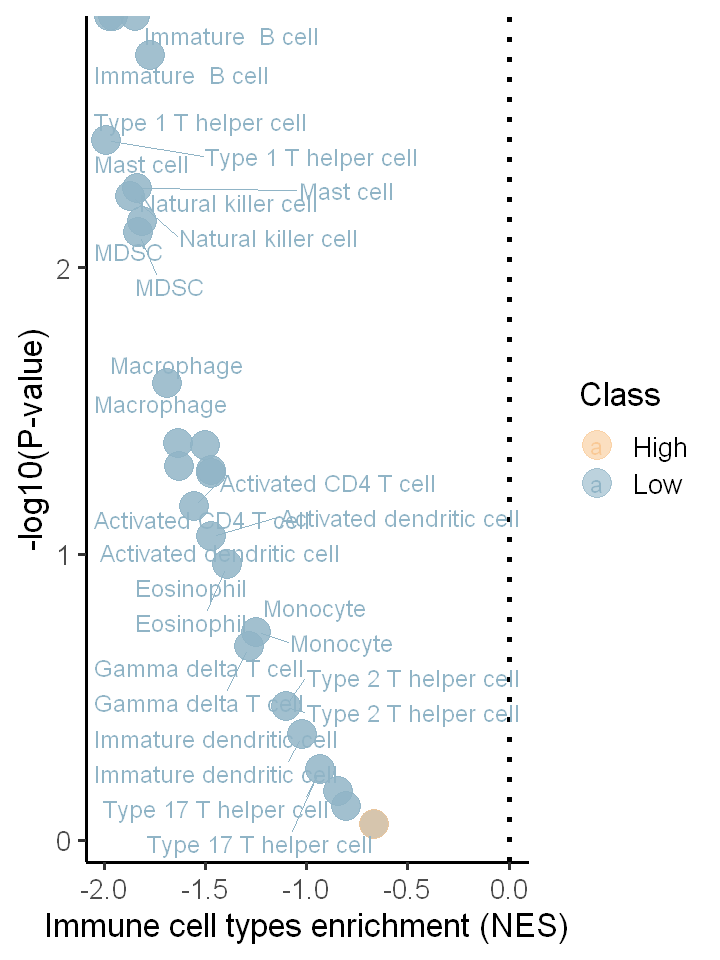

In [1369]:
cols <- PAIRWISE_COLORS %>% unlist
names(cols) <- c('High', 'Low')
ggplot(plot.df, aes(x = -NES, y = -log10(Pval), color = Class)) + 
    geom_point(size = 8, alpha = 0.6) +     
    theme_classic(base_size = 20) + 
    xlab('Immune cell types enrichment (NES)') + 
    geom_vline(xintercept = 0, lty = 'dotted', lwd = 1.5) + 
    scale_color_manual(values = cols) + 
    ggrepel::geom_text_repel(
        data = plot.df,
        aes(label = GS),
        size = 5,
        box.padding = unit(0.35, "lines"),
        point.padding = unit(0.3, "lines")
      ) + ylab('-log10(P-value)')
ggsave(file.path(out.figs.dir, 'valcon.plot.immmuneCells.pdf'), width = 12, height = 7)

### Classification using lincRNA genes

In [50]:
hub.genes.sub.sub <- setdiff(hub.genes.sub, c('LINC01508', 'AL022344.7', 'AF131215.8', 'GATA6_AS1'))
expr.linc <- FetchData(tcga.obj.sub, vars = hub.genes.sub.sub)
head(expr.linc)[, 1:10]

LINC01235 LINC00987 LINC00398 LINC00667 ZNF888   
TCGA-E2-A15G-01A-11R-A12D-07 0.2441457 0.5176073 0.5505497 4.766416  1.4169279
TCGA-E2-A1B5-01A-21R-A12P-07 0.8947440 1.9249279 0.1436127 2.433822  0.3036085
TCGA-EW-A2FS-01A-11R-A17B-07 0.5106076 1.2743872 0.1792338 3.283357  0.7662489
TCGA-EW-A1P7-01A-21R-A144-07 7.2205520 2.5081097 0.1056068 6.786185  0.8682372
TCGA-LL-A5YO-01A-21R-A28M-07 3.8631820 0.3640270 0.1168517 5.908502  1.3449608
TCGA-BH-A1FN-01A-11R-A13Q-07 1.4425567 0.2550964 0.0994321 3.632807  3.0655222
                             AC016995.3 SFTA1P    LINC00958  LINC00327  
TCGA-E2-A15G-01A-11R-A12D-07 0.20852759 0.2776808 0.81744329 0.026560770
TCGA-E2-A1B5-01A-21R-A12P-07 0.87260722 0.4759945 0.29544300 0.005691239
TCGA-EW-A2FS-01A-11R-A17B-07 0.49597481 0.3742567 0.19911069 0.079552150
TCGA-EW-A1P7-01A-21R-A144-07 4.29692959 0.5880445 0.39106162 0.099605365
TCGA-LL-A5YO-01A-21R-A28M-07 0.35927927 0.2033309 0.00000000 0.056726376
TCGA-BH-A1FN-01A-11R-A13Q-07 0.07642999 0.1441829 0.04091075 0.055165634
                             LINC00346
TCGA-E2-A15G-01A-11R-A12D-07 1.3050199
TCGA-E2-A1B5-01A-21R-A12P-07 0.7654584
TCGA-EW-A2FS-01A-11R-A17B-07 1.0549247
TCGA-EW-A1P7-01A-21R-A144-07 5.3635635
TCGA-LL-A5YO-01A-21R-A28M-07 0.2492494
TCGA-BH-A1FN-01A-11R-A13Q-07 2.2107969

In [51]:
results.clust <- ConsensusClusterPlus(t(log2(1 + expr.linc) %>% scale), maxK=6, reps=50, pItem=0.8, pFeature=1, title=file.path(out.figs.dir, 'Consens'), clusterAlg="pam", distance="pearson", seed=123456, plot="pdf")

end fraction

clustered

clustered

clustered

clustered

clustered



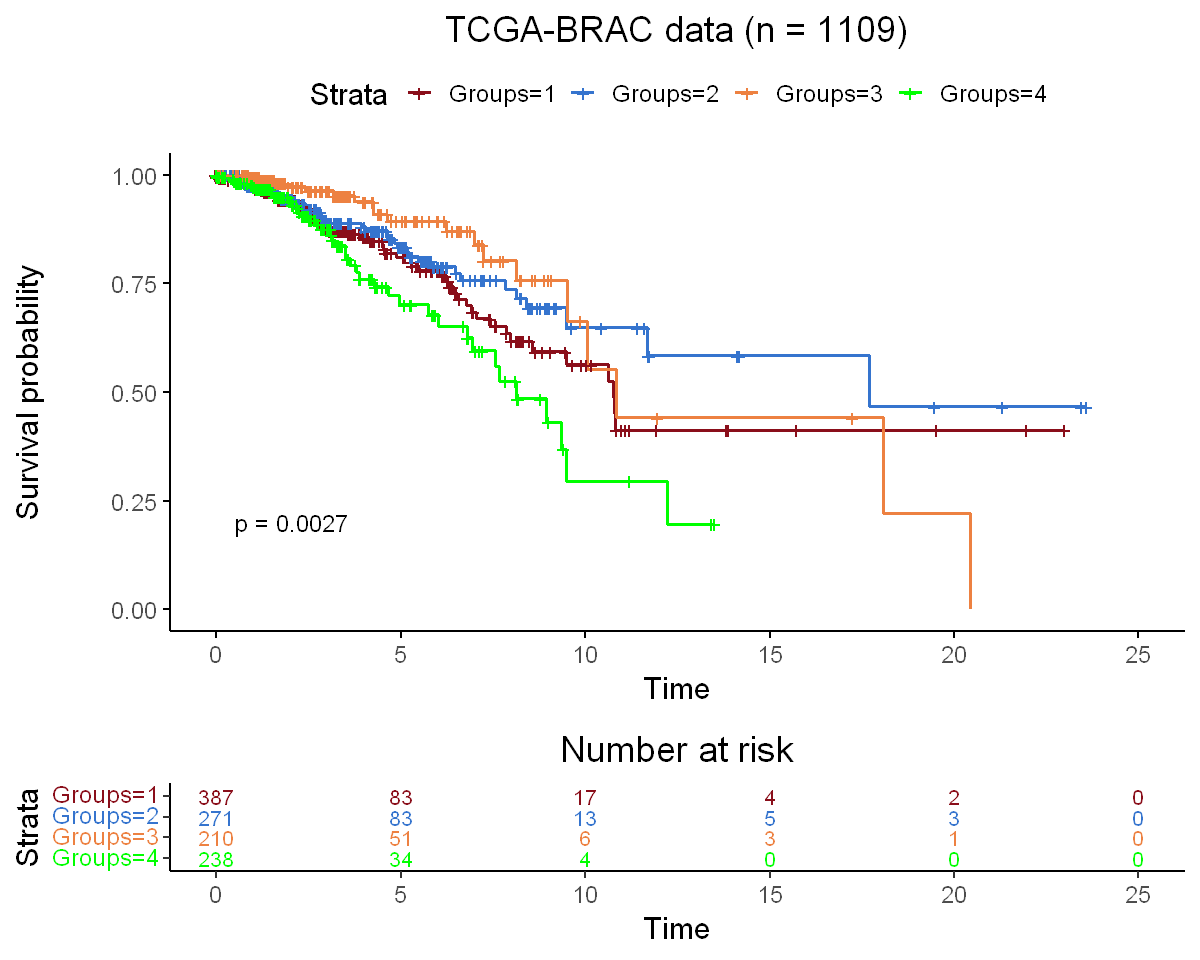

In [52]:
sub.clinical$Groups <- as.character(results.clust[[4]]$consensusClass)
res.cox.bak <- OS.analysis(
    sub.clinical, 
    c('#8A0E1A', '#3574CE', '#ED8141', 'green', 'red'), 
    F, 
    cutoff = F, 
    prefix = 'TCGA_selected_genesets_OS_Clusters.pdf',
    out.figs.dir = out.figs.dir,
    title = sprintf('TCGA-BRAC data (n = %g)', dim(sub.clinical)[1])
)

In [53]:
sub.clinical$Score <- as.vector(risk.socres)

Saving 6.67 x 6.67 in image



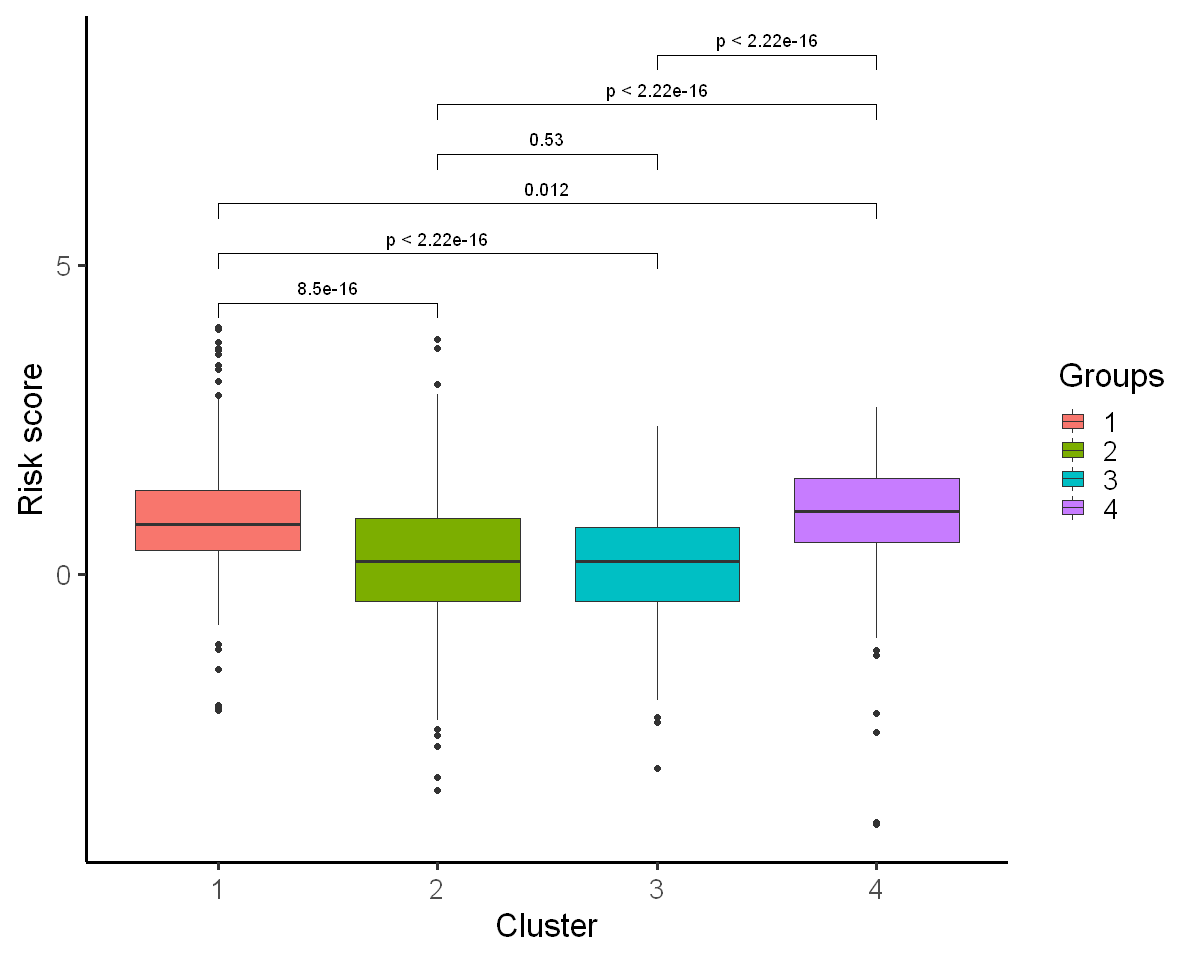

In [54]:
comparisons <- pairwiseComp(c('1', '2', '3', '4'))
ggplot(sub.clinical, aes(x = Groups, y = Score, fill = Groups)) + geom_boxplot() + theme_classic(base_size = 20) + geom_signif(comparisons = comparisons, step_increase = 0.1) + ylab('Risk score') + xlab('Cluster')
ggsave(file.path(out.figs.dir, 'clusters.parewise.sig.pdf'))

In [324]:
class.lab <- class.lab.tmp <- as.character(results.clust[[4]]$consensusClass)

In [325]:
class.lab.tmp[class.lab.tmp %in% c('2', '3')] <- '2_3'
table(class.lab.tmp)

class.lab.tmp
  1 2_3   4 
389 482 238 

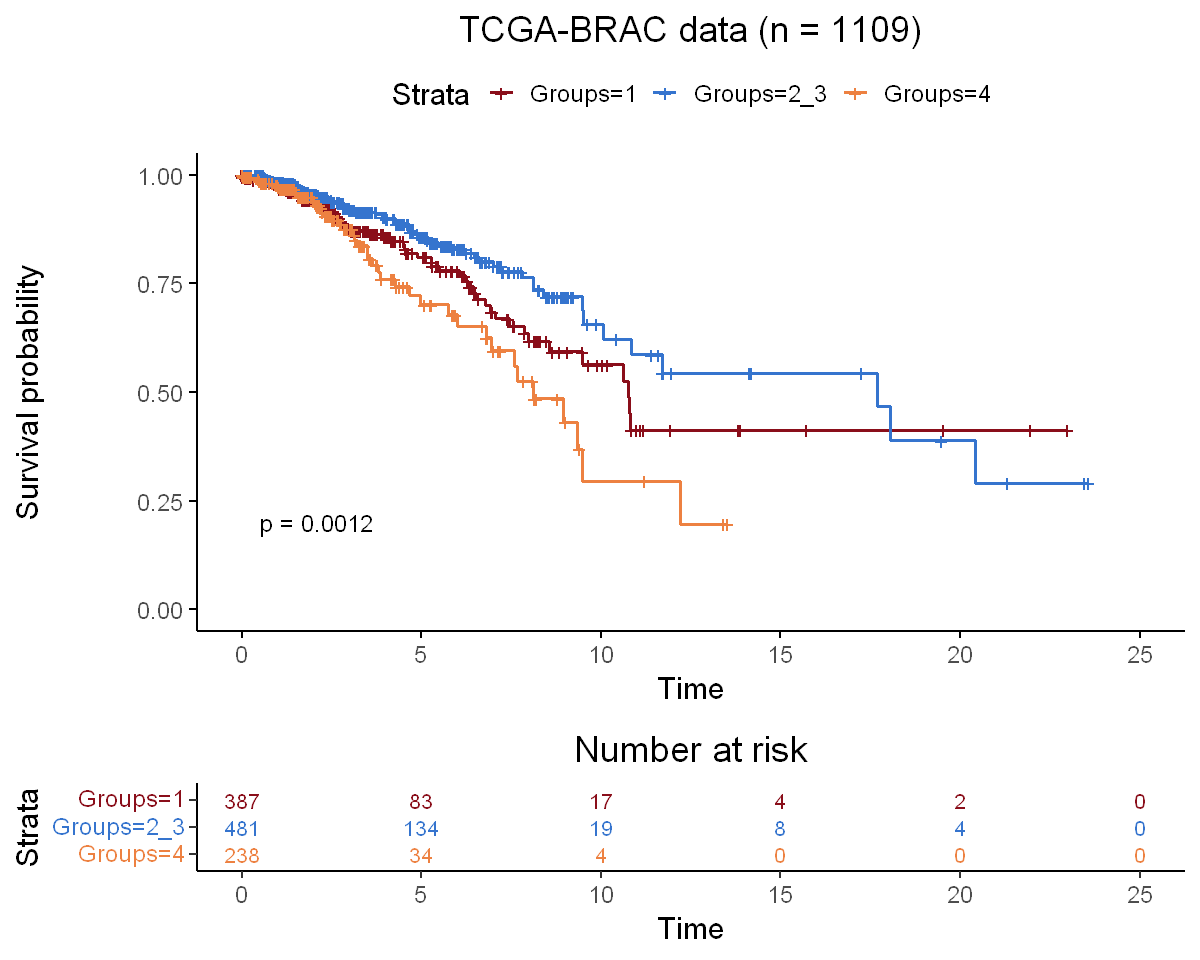

In [57]:
sub.clinical$Groups <- class.lab.tmp
res.cox.bak <- OS.analysis(
    sub.clinical, 
    c('#8A0E1A', '#3574CE', '#ED8141', 'green', 'red'), 
    F, 
    cutoff = F, 
    prefix = 'TCGA_selected_genesets_OS_Clusters_merged.pdf',
    out.figs.dir = out.figs.dir,
    title = sprintf('TCGA-BRAC data (n = %g)', dim(sub.clinical)[1])
)

In [326]:
Idents(tcga.obj.sub) <- class.lab.tmp

In [59]:
anno <- read.table('../0.data/gencode.gene.info.v22.tsv', sep = '\t', header = T) %>% subset(., gene_type == 'protein_coding')
head(anno)
com.genes <- intersect(rownames(tcga.obj.sub),anno$gene_name)
length(com.genes)

gene_id            gene_name seqname start    end      strand gene_type     
7  ENSG00000206557.5  TRIM71    chr3    32818018 32897826 +      protein_coding
8  ENSG00000183813.6  CCR4      chr3    32951574 32956349 +      protein_coding
9  ENSG00000170266.14 GLB1      chr3    32996608 33097230 -      protein_coding
12 ENSG00000188167.7  TMPPE     chr3    33090421 33096801 -      protein_coding
14 ENSG00000170275.13 CRTAP     chr3    33113979 33147773 +      protein_coding
17 ENSG00000173705.7  SUSD5     chr3    33150042 33219215 -      protein_coding
   gene_status havana_gene          full_length exon_length exon_num
7  KNOWN       OTTHUMG00000155778.3  79809      8685          4     
8  KNOWN       OTTHUMG00000130752.2   4776      3095          2     
9  KNOWN       OTTHUMG00000155781.6 100623      4364        123     
12 KNOWN       OTTHUMG00000155779.1   6381      3966          4     
14 KNOWN       OTTHUMG00000130746.3  33795      6695         18     
17 KNOWN       OTTHUMG00000155829.2  69174      5008          9

[1] 19459

In [61]:
tcga.obj.sub.sub <- subset(tcga.obj.sub, features = com.genes)
dim(tcga.obj.sub.sub)

[1] 19459  1109

In [490]:
label <- ifelse(res.cox$group == 'High risk', 'High', 'Low')
tcga.obj.sub.sub@meta.data$Group <- label
names(label) <- colnames(tcga.obj.sub.sub)
group.list <- factor(label)

design <- model.matrix(~0 + group.list)
colnames(design) <- levels(group.list)
rownames(design) <- colnames(tcga.obj.sub.sub)
contrast.matrix <- makeContrasts('High-Low',levels = design)
fit.lm <- lmFit(GetAssayData(tcga.obj.sub.sub) %>% as.matrix, design)
fit2 <- contrasts.fit(fit.lm, contrast.matrix)
fit2 <- eBayes(fit2)
DEgeneSets <- topTable(fit2, coef=1, number=Inf, p.value=1e-2, adjust="BH")

DEgeneSets.sub <- subset(DEgeneSets, logFC > 4 | logFC < -4)
head(DEgeneSets.sub)
dim(DEgeneSets.sub)

logFC       AveExpr   t         P.Value      adj.P.Val    B        
IMPAD1      5.930885  22.62325  6.282567 4.777469e-10 1.328068e-06 12.442014
TNFRSF1B   -4.525251  11.43782 -6.209707 7.495137e-10 1.745249e-06 12.018339
SDC1       46.049912 115.59689  6.197639 8.071966e-10 1.745249e-06 11.948607
CD74     -257.495588 644.58295 -6.037343 2.135010e-09 2.596572e-06 11.034386
CD2        -6.650829  10.72835 -5.865746 5.897856e-09 3.702141e-06 10.080531
FUCA1      -7.043216  29.62709 -5.767137 1.045114e-08 5.496450e-06  9.544063

[1] 195   6

In [491]:
x <- FetchData(tcga.obj.sub.sub, vars = rownames(DEgeneSets.sub)) %>% {log2(1 + .)} %>% as.matrix
y <- factor(label)

alpha1_fit <- glmnet(x, y, alpha = 1, family = 'binomial')
alpha1.fit <- cv.glmnet(x, y, type.measure = "class", alpha = 1, family = "binomial")
print(alpha1.fit)
c <- as.data.frame(coef(alpha1_fit, s=alpha1.fit$lambda.1se))
names(c) <-'coef'
lasso.cox.gene.list <- rownames(subset(c, abs(coef)>0))[-1]
length(lasso.cox.gene.list)


Call:  cv.glmnet(x = x, y = y, type.measure = "class", alpha = 1, family = "binomial") 

Measure: Misclassification Error 

     Lambda Index Measure       SE Nonzero
min 0.01126    23  0.1515 0.009405      52
1se 0.02369    15  0.1596 0.011735      37


[1] 37

Centering and scaling data matrix



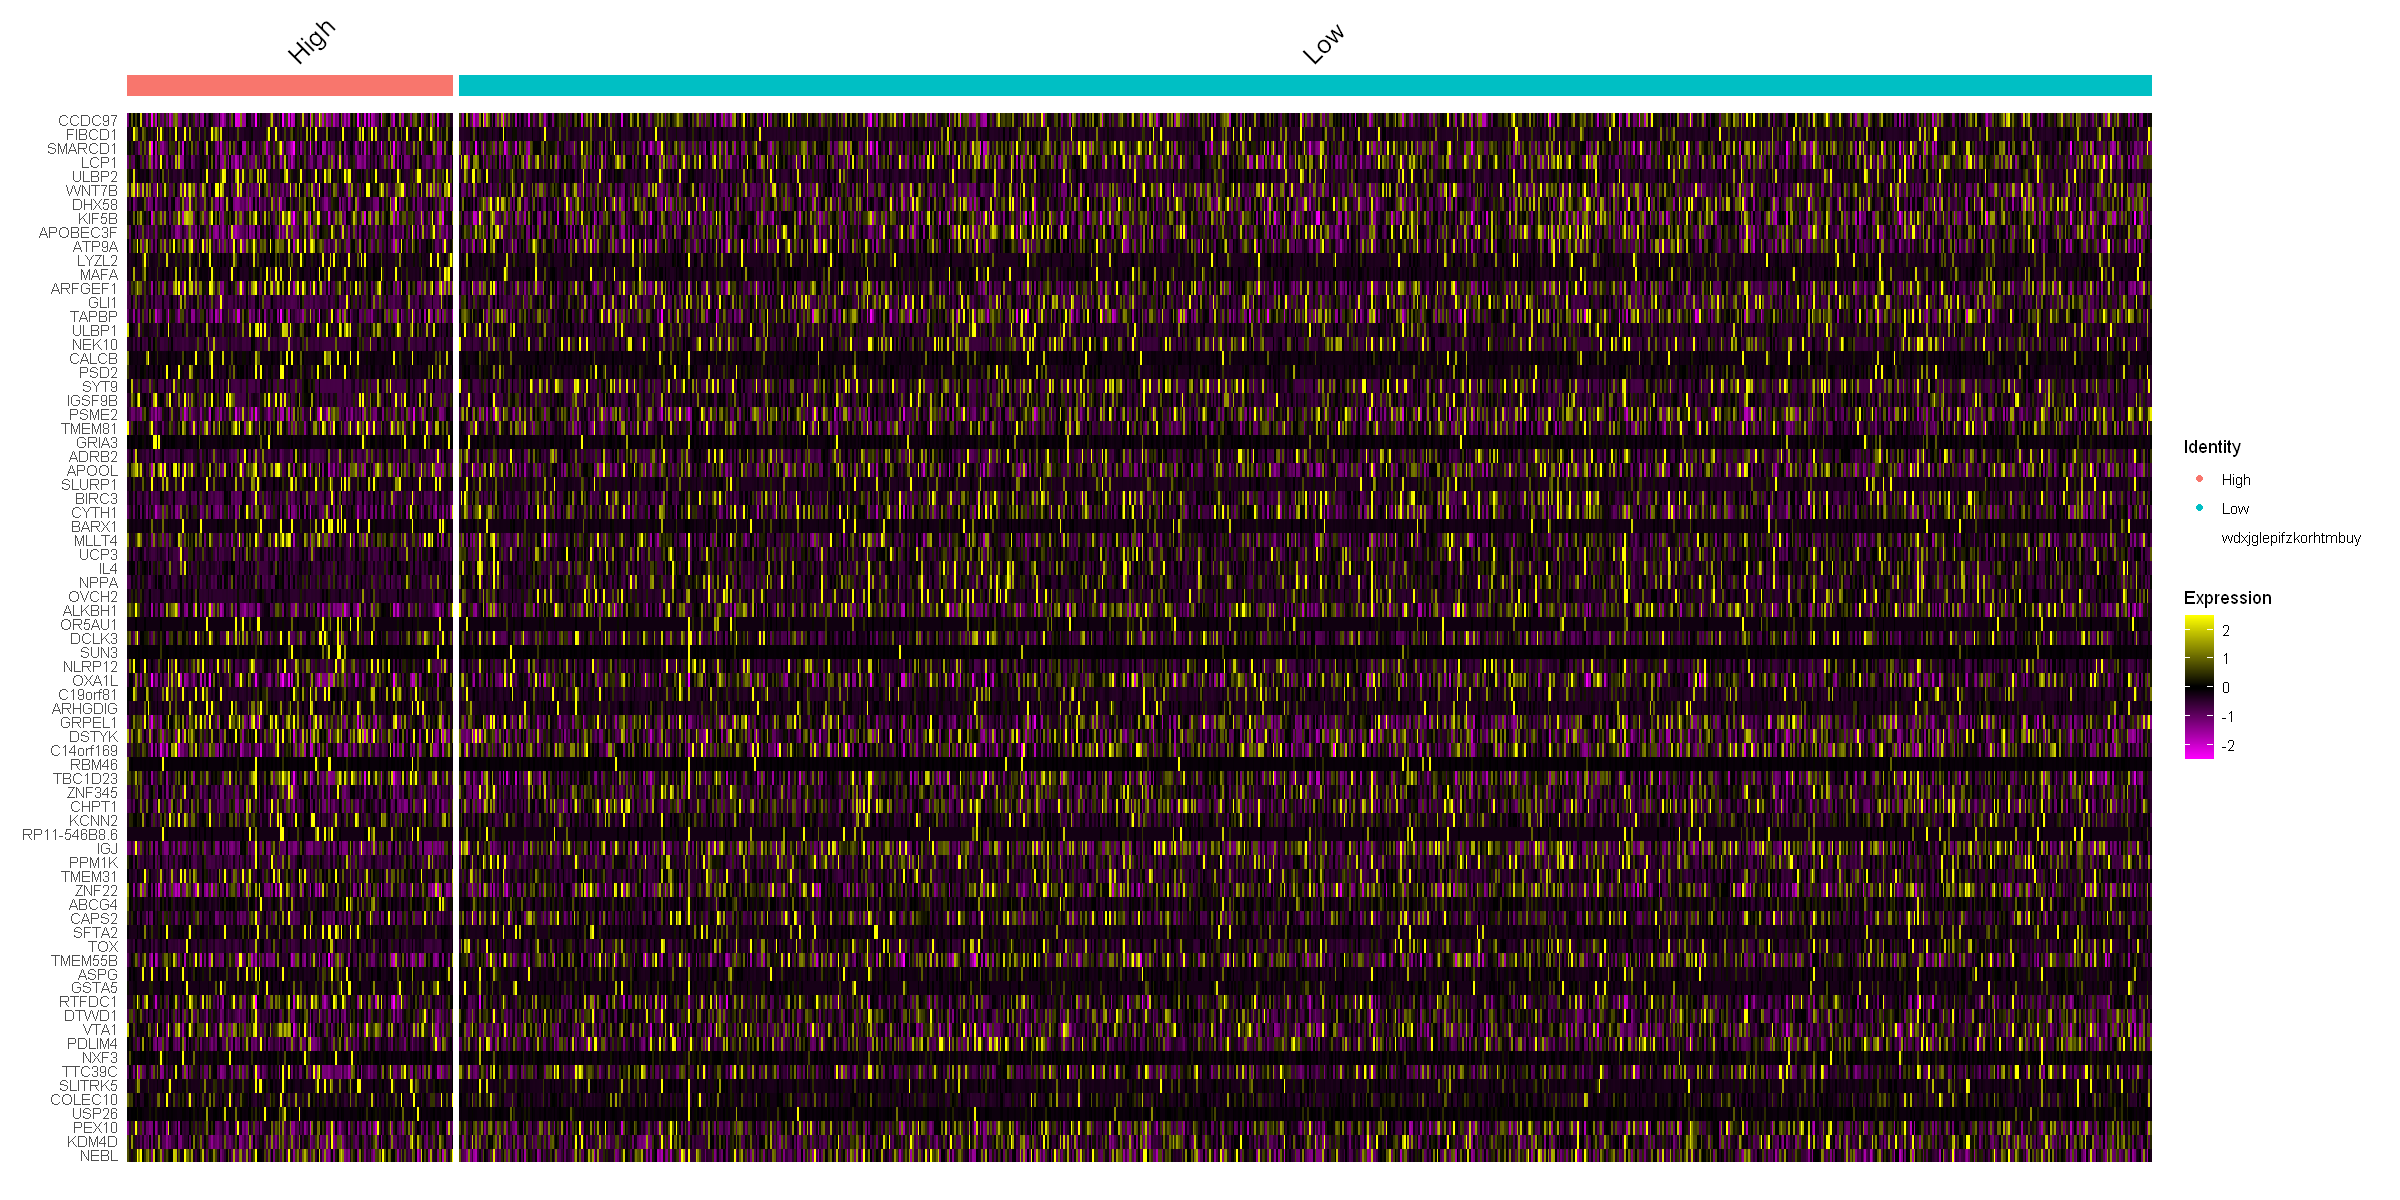

In [488]:
DoHeatmap(tcga.obj.sub.sub %>% NormalizeData %>% ScaleData, features = lasso.cox.gene.list, group.by = 'Group')

In [242]:
source('CIBERSORT.R')
load('../0.data/LM22.Rdata')

In [243]:
res.cib <- CIBERSORT(LM22, GetAssayData(tcga.obj.sub) %>% as.matrix)

In [247]:
colnames(res.cib)[1:22]

[1] "B cells naive"                "B cells memory"              
 [3] "Plasma cells"                 "T cells CD8"                 
 [5] "T cells CD4 naive"            "T cells CD4 memory resting"  
 [7] "T cells CD4 memory activated" "T cells follicular helper"   
 [9] "T cells regulatory (Tregs)"   "T cells gamma delta"         
[11] "NK cells resting"             "NK cells activated"          
[13] "Monocytes"                    "Macrophages M0"              
[15] "Macrophages M1"               "Macrophages M2"              
[17] "Dendritic cells resting"      "Dendritic cells activated"   
[19] "Mast cells resting"           "Mast cells activated"        
[21] "Eosinophils"                  "Neutrophils"

In [501]:
data <- res.cib[, 1:22] %>% as.data.frame
data$label <- label

In [502]:
kk = tidyr::gather(data, 'Label', 'Frac', -label)
head(kk)
kk$Label <- factor(kk$Label, levels = colnames(LM22))

label Label         Frac      
1 Low   B cells naive 0.07013699
2 Low   B cells naive 0.06243730
3 Low   B cells naive 0.13569893
4 Low   B cells naive 0.11419116
5 Low   B cells naive 0.08215979
6 High  B cells naive 0.06081735

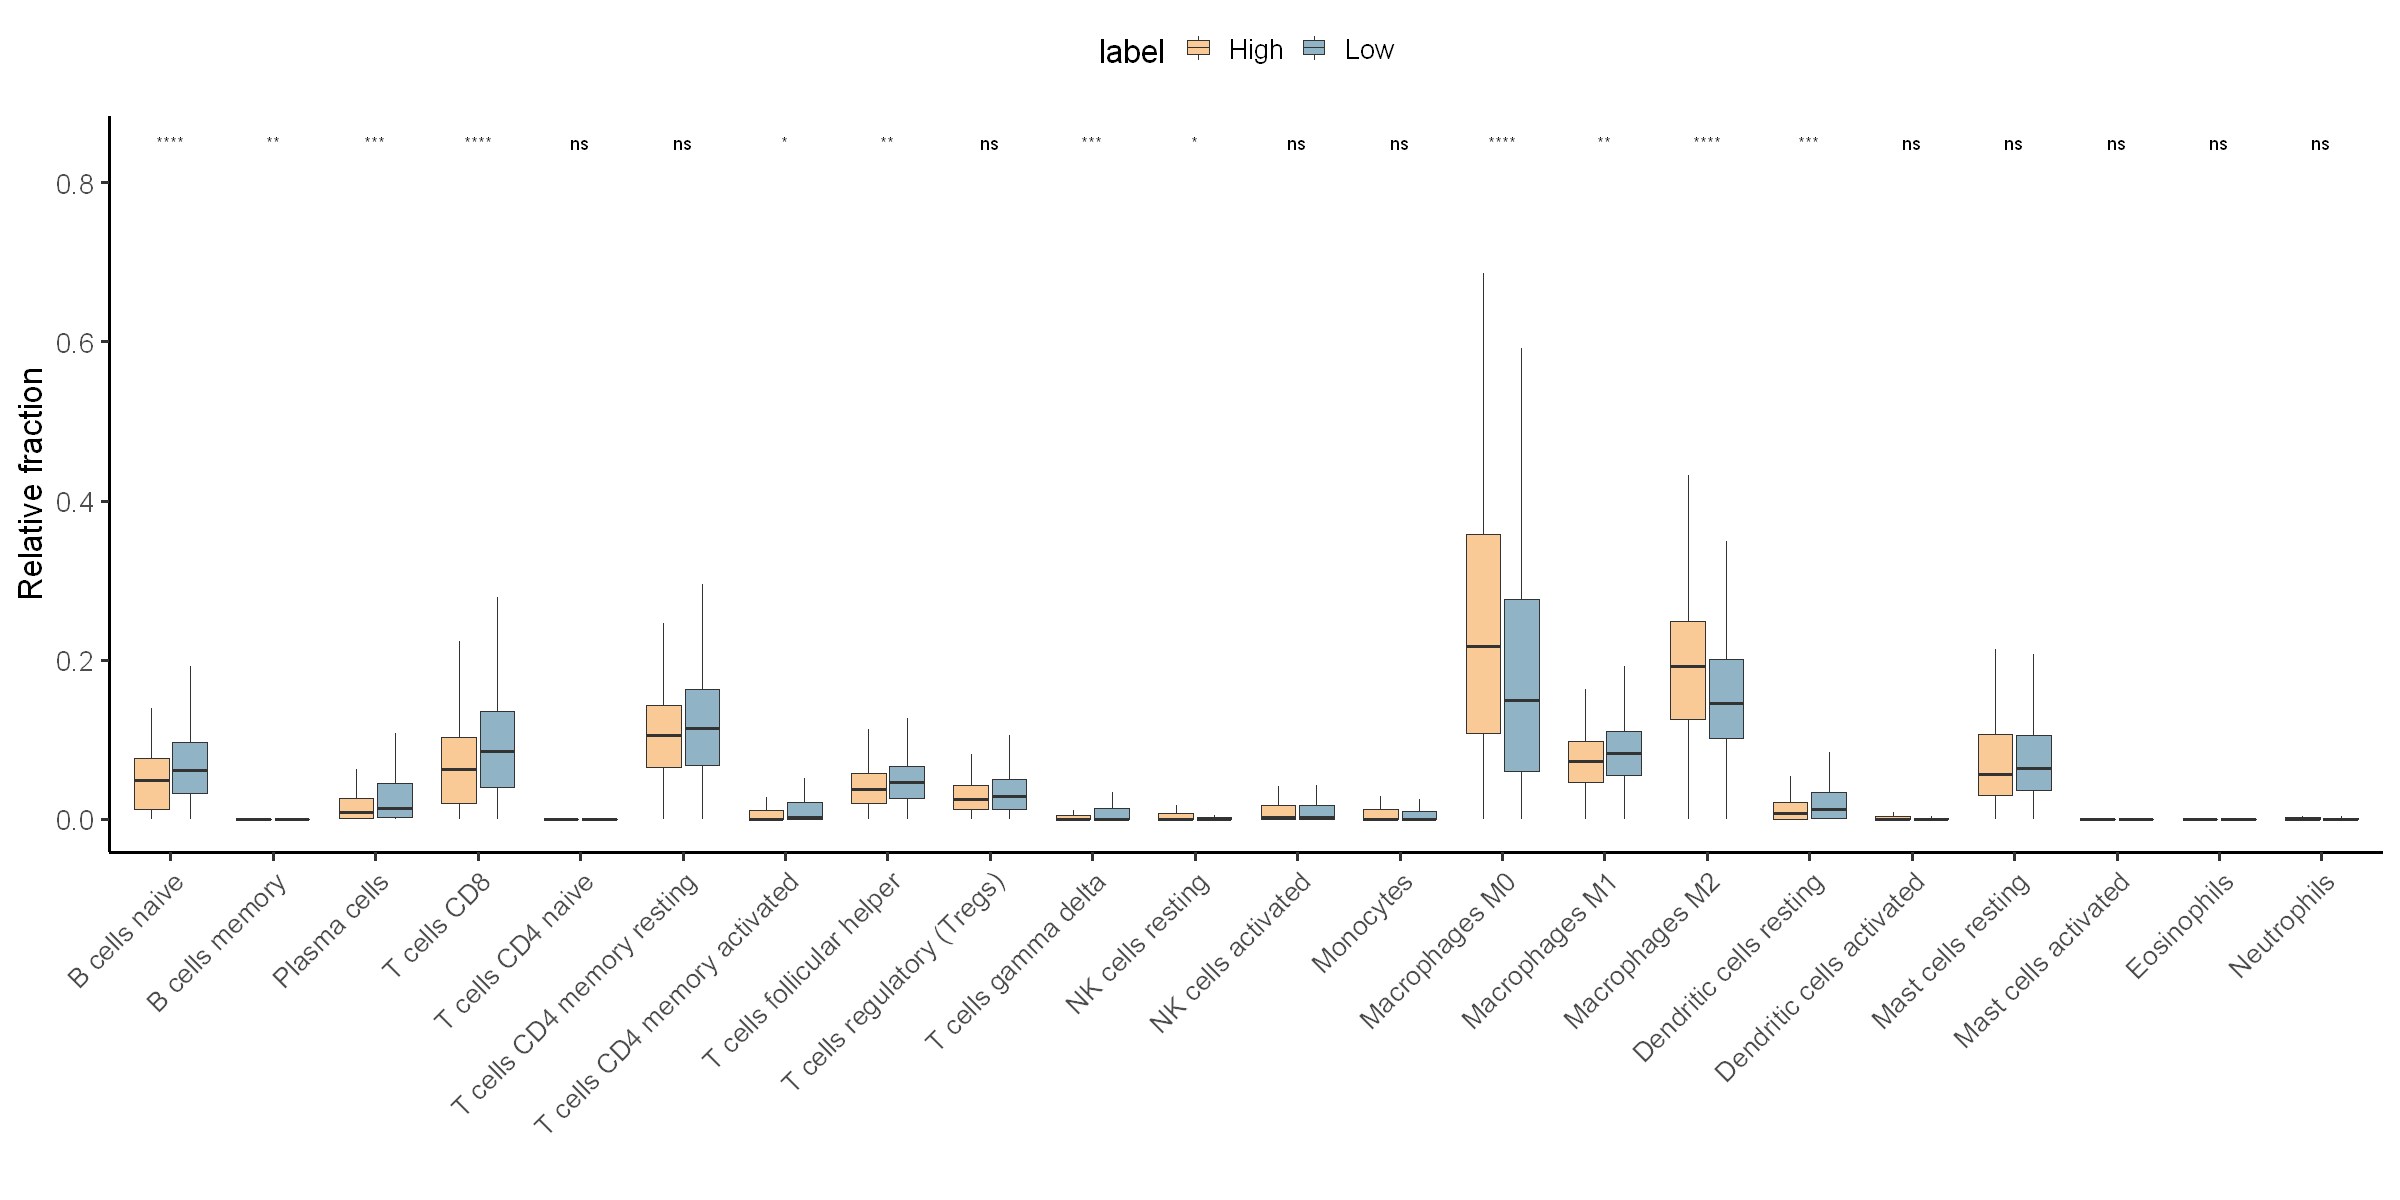

In [874]:
options(repr.plot.width = 20, repr.plot.height = 10)
cols <- unlist(PAIRWISE_COLORS)
names(cols) <- c('High', 'Low')
ggplot(kk, aes(x = Label, y = Frac, fill = label)) + geom_boxplot(outlier.shape = NA) + stat_compare_means(label = "p.signif") + theme_classic(base_size = 20)  + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1), legend.position="top") + xlab('') + ylab('Relative fraction') + scale_fill_manual(values = cols)
ggsave(file.path(out.figs.dir, 'cibersort.frac.pdf'), width = 12, height = 7)

In [374]:
colnames(data)[c(1, 4, 15,16,19)]

[1] "B cells naive"              "T cells CD4 memory resting"
[3] "LINC00987"                  "LINC00398"                 
[5] "ZNF888"

In [495]:
data <- res.cib[, c(1, 3, 4, 6,7,8,9,12,13,15,16,19)] %>% scale %>% as.data.frame

In [510]:
set.seed(1234)   
data <- FetchData(tcga.obj.sub, vars ='LINC00667') %>% {log2(1 + .)} %>% scale %>%  as.data.frame

#data <- cbind.data.frame(data, data.bak)
data$label <- Idents(tcga.obj.sub)
ind <- sample(2, nrow(data), replace = T, prob = c(0.7, 0.3))
ind <- ifelse(ind == 2, 0, 1)
train_data <- data[ind==1, ] #训练数据集
test_data <- data[ind==0, ] #测试数据集

In [512]:
svm_model <- svm(formula=label ~ ., data = train_data, cross = 10, scale = T) #十折交叉验证
svm_pred <- predict(object = svm_model, newdata = test_data, type = "class", kernel="linear")
svm_model$accuracies
cor.rat <- sum(svm_pred == test_data$label)/nrow(test_data)
print(paste0("该SVM模型下测试集预测准确率为",cor.rat,'.'))

[1] 41.02564 48.71795 39.74359 39.74359 41.02564 47.43590 52.56410 42.30769
 [9] 32.05128 40.50633

[1] "该SVM模型下测试集预测准确率为0.445121951219512."


In [509]:
saveRDS(hub.genes.sub, file = 'hub.genes.sub')

### PAN-cancer analysis

In [526]:
model.res <- lapply(list.files('../0.data/Pan.cancer', pattern = 'TCGA-', full.names  = T), function(fil) {
    obj <- readRDS(fil)
    sub.clinical.tmp <- obj@meta.data[, c('patient', 'vital_status', 'days_to_death', 'days_to_last_follow_up')]
    sub.clinical.tmp$Sur <- sub.clinical.tmp$vital_status == "Dead"
    sub.clinical.tmp$Time <- ifelse(sub.clinical.tmp$Sur, sub.clinical.tmp$days_to_death, sub.clinical.tmp$days_to_last_follow_up)

    expr.tmp <- FetchData(obj, vars = gsub('_', '-', hub.genes.sub))  %>% { log2(1 + .)}
    coefs <- mult.var.cox$coefficients[!is.na(mult.var.cox$coefficients)]
    select.sets <- names(coefs)
    risk.ss <- coefs %*% t(as.matrix(expr.tmp[, gsub('_', '-', select.sets)]))
    sub.clinical.tmp$Groups <- as.vector(risk.ss) 

    formula.fmt <- as.formula(paste0('Surv(Time, Sur)~', 'Groups'))

    tmp.cox <- OS.analysis(sub.clinical.tmp, c('#8A0E1A', '#3574CE'), T, cutoff = T)
    sub.clinical.tmp[, 'Groups'] <- sub.clinical.tmp[, 'Groups'] > tmp.cox$cut.off
    uni.cox <- coxph(formula.fmt, data = sub.clinical.tmp)
    return(list(model = uni.cox, score = risk.ss))
})

In [527]:
cancers <- gsub('.*TCGA-|-Obj.rds', '', list.files('../0.data/Pan.cancer', pattern = 'TCGA-', full.names  = T))

In [548]:
model.lst <- lapply(model.res, function(x) x$model)
model.score <- lapply(1 : length(cancers), function(x) { 
    score <- model.res[[x]]$score
    label.cancer <- rep(cancers[x], dim(score)[2])
    return(cbind.data.frame(Score = as.vector(score), Label = label.cancer))
}) %>% do.call(rbind, .)

In [549]:
head(model.score)

Score       Label
1 -1.38027325 ACC  
2 -0.96964600 ACC  
3 -0.08312899 ACC  
4  0.03971200 ACC  
5  1.10204287 ACC  
6  0.96298532 ACC

In [550]:
model.score$Label <- factor(model.score$Label, levels = cancers)

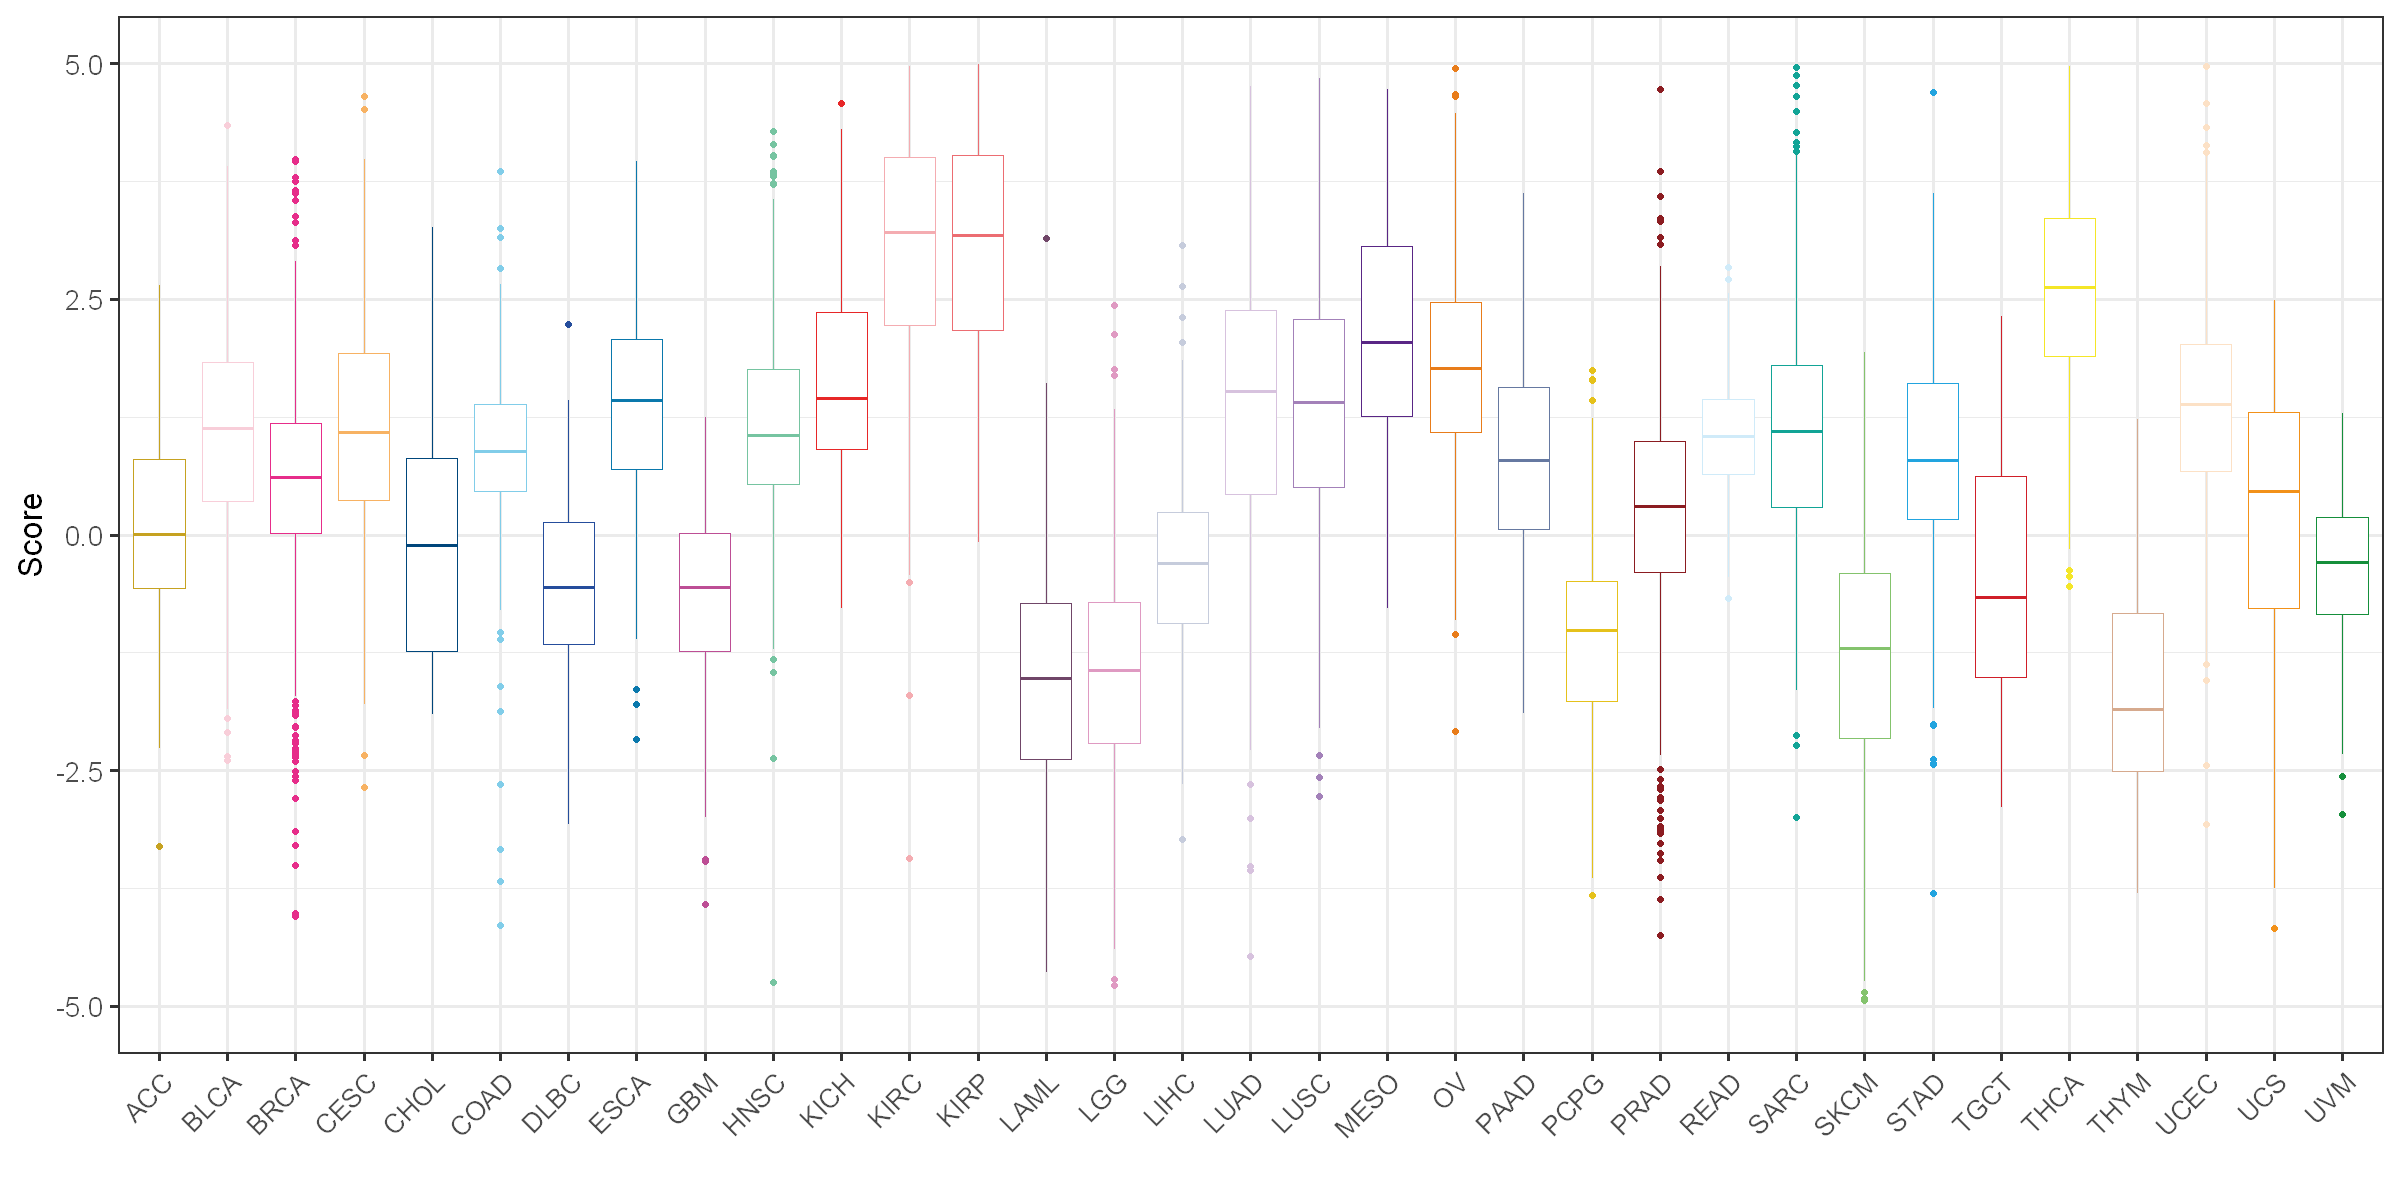

In [557]:
model.score$Label <- factor(model.score$Label, levels = cancers)
ggplot(model.score, aes(x = Label, y = Score, color = Label)) + geom_boxplot() + scale_color_manual(values = unlist(CANCER_COLORS)) + theme_bw(base_size = 20) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1), legend.position="none") + ylim(-5, 5) + xlab('') + ylab('LincSI')

In [558]:
names(model.lst) <- gsub('.*TCGA-|-Obj.rds', '', list.files('../0.data/Pan.cancer', pattern = 'TCGA-', full.names  = T))

In [559]:
model.lst

$ACC
Call:
coxph(formula = formula.fmt, data = sub.clinical.tmp)

             coef exp(coef) se(coef)     z       p
GroupsTRUE 1.4708    4.3528   0.4968 2.961 0.00307

Likelihood ratio test=11.34  on 1 df, p=0.000757
n= 79, number of events= 28 

$BLCA
Call:
coxph(formula = formula.fmt, data = sub.clinical.tmp)

             coef exp(coef) se(coef)     z        p
GroupsTRUE 0.6151    1.8498   0.1454 4.229 2.34e-05

Likelihood ratio test=17.66  on 1 df, p=2.642e-05
n= 431, number of events= 193 
   (因为不存在，2个观察量被删除了)

$BRCA
Call:
coxph(formula = formula.fmt, data = sub.clinical.tmp)

             coef exp(coef) se(coef)     z      p
GroupsTRUE 1.7315    5.6490   0.1516 11.42 <2e-16

Likelihood ratio test=106.3  on 1 df, p=< 2.2e-16
n= 1220, number of events= 200 
   (因为不存在，2个观察量被删除了)

$CESC
Call:
coxph(formula = formula.fmt, data = sub.clinical.tmp)

             coef exp(coef) se(coef)     z      p
GroupsTRUE 0.4492    1.5671   0.2358 1.905 0.0568

Likelihood ratio test=3.69  on 1 df, 

In [561]:
univ.results <- lapply(model.lst, function(x){
    x <- summary(x)
    p.value <- signif(x$wald["pvalue"], digits = 2)
    HR <-signif(x$coef[2], digits = 2)
    lower.95 <- signif(x$conf.int[,"lower .95"], 2)
    upper.95 <- signif(x$conf.int[,"upper .95"], 2)
    conf <- paste0(HR, " (", lower.95, "-", upper.95, ")")
    res <- c(HR, lower.95, upper.95, conf, p.value)
    return(res)
}) %>% as.data.frame %>% t

rownames(univ.results) <- names(model.lst)

colnames(univ.results) <- c('HR', 'lower.95', 'upper.95', 'conf', 'p.value')
plot.res <- cbind.data.frame(charac = rownames(univ.results), univ.results)
plot.res[plot.res == Inf] <- 9999
plot.res[, 2] <- as.numeric(plot.res[, 2]) %>% { log2(1 + .) }
plot.res[, 3] <- as.numeric(plot.res[, 3]) %>% { log2(1 + .) }
plot.res[, 4] <- as.numeric(plot.res[, 4]) %>% { log2(1 + .) }
plot.res[, 6] <- as.numeric(plot.res[, 6])
plot.res <- plot.res[order(plot.res$p.value), ]
plot.res['TGCT', 'upper.95'] <- 1
plot.res[plot.res == Inf] <- 999

pdf(file.path(out.figs.dir, 'pan.cancer.hub.genes.forestplot.pdf'), width = 8, height = 10)
forestplot(
    plot.res[, c(1, 5, 6)],
    mean = plot.res[, 2],
    lower = plot.res[, 3],
    upper = plot.res[, 4],
    zero = 1,
    col=fpColors(box="darkblue", lines="black", zero = "gray50"),
    boxsize = 0.3,
    graph.pos = 2
)
dev.off()

png 
  2

In [761]:
head(univ.results)

HR      lower.95 upper.95 conf            p.value
ACC  4.4     1.6      12       4.4 (1.6-12)    0.0031 
BLCA 1.8     1.4      2.5      1.8 (1.4-2.5)   2.3e-05
BRCA 5.6     4.2      7.6      5.6 (4.2-7.6)   3.4e-30
CESC 1.6     0.99     2.5      1.6 (0.99-2.5)  0.057  
CHOL 8.2e+07 0        Inf      8.2e+07 (0-Inf) 1      
COAD 1.9     1.3      2.9      1.9 (1.3-2.9)   0.0021

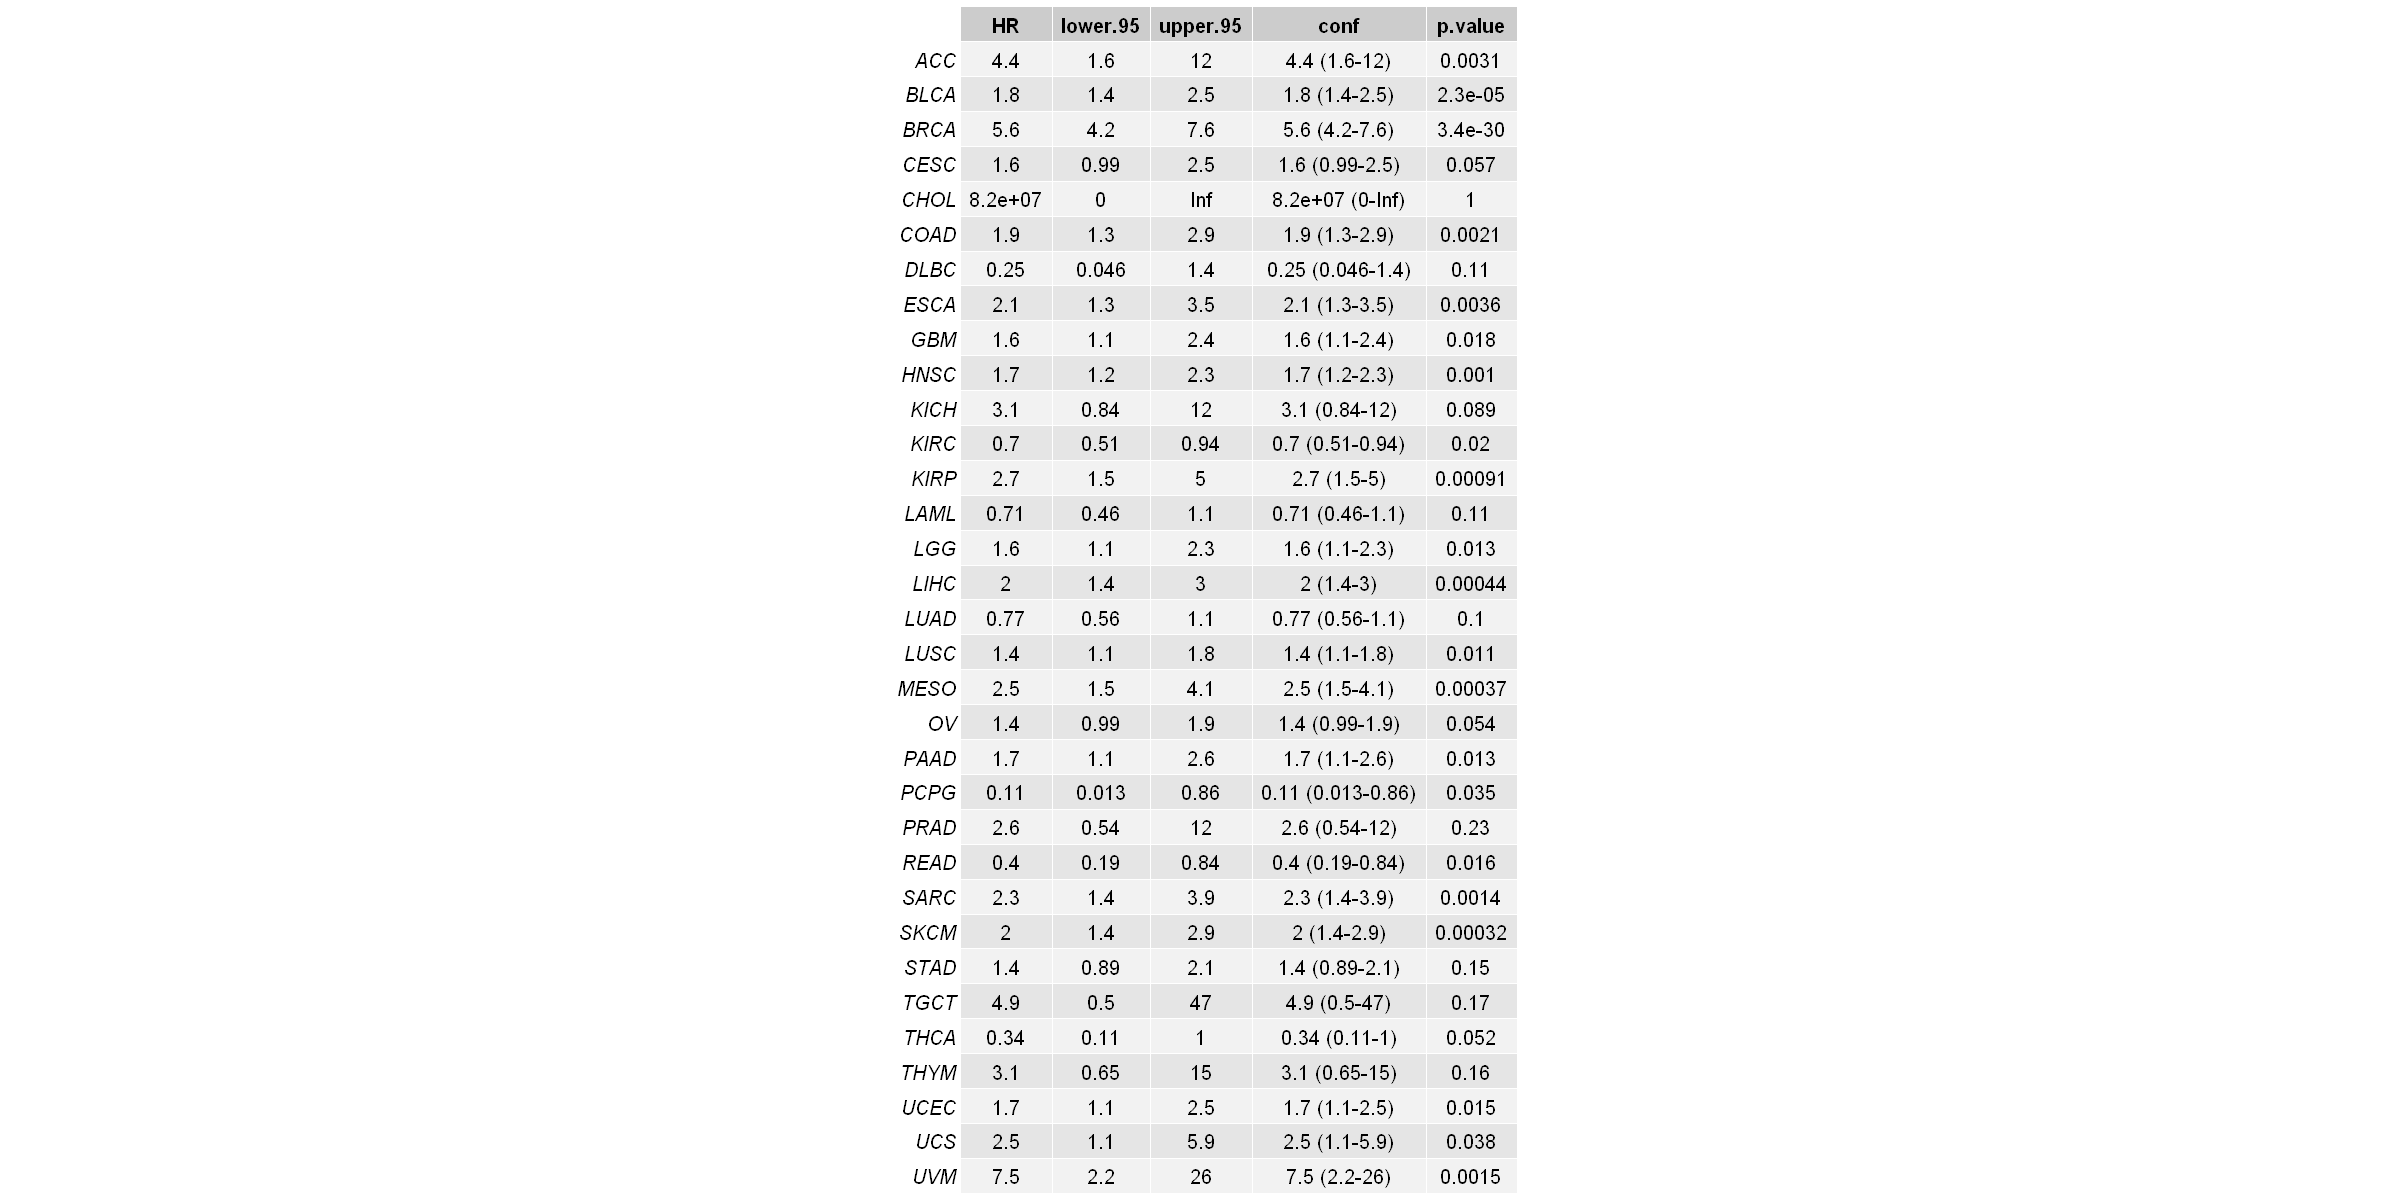

In [564]:
grid.table(univ.results)

In [762]:
univ.results %>% head

HR      lower.95 upper.95 conf            p.value
ACC  4.4     1.6      12       4.4 (1.6-12)    0.0031 
BLCA 1.8     1.4      2.5      1.8 (1.4-2.5)   2.3e-05
BRCA 5.6     4.2      7.6      5.6 (4.2-7.6)   3.4e-30
CESC 1.6     0.99     2.5      1.6 (0.99-2.5)  0.057  
CHOL 8.2e+07 0        Inf      8.2e+07 (0-Inf) 1      
COAD 1.9     1.3      2.9      1.9 (1.3-2.9)   0.0021

In [764]:
subset(as.data.frame(univ.results), p.value <= 0.01)


HR  lower.95 upper.95 conf          p.value
ACC  4.4 1.6      12       4.4 (1.6-12)  0.0031 
COAD 1.9 1.3      2.9      1.9 (1.3-2.9) 0.0021 
ESCA 2.1 1.3      3.5      2.1 (1.3-3.5) 0.0036 
HNSC 1.7 1.2      2.3      1.7 (1.2-2.3) 0.001  
KIRP 2.7 1.5      5        2.7 (1.5-5)   0.00091
LIHC 2   1.4      3        2 (1.4-3)     0.00044
MESO 2.5 1.5      4.1      2.5 (1.5-4.1) 0.00037
SARC 2.3 1.4      3.9      2.3 (1.4-3.9) 0.0014 
SKCM 2   1.4      2.9      2 (1.4-2.9)   0.00032
UVM  7.5 2.2      26       7.5 (2.2-26)  0.0015

In [772]:
univ.results <- as.data.frame(univ.results)
univ.results[, 'p.value'] <- as.numeric(univ.results[, 'p.value'])

In [777]:
sig.cancers <- subset(as.data.frame(univ.results), p.value <= 0.01) %>% rownames
sig.cancers <- setdiff(sig.cancers, 'BRCA')

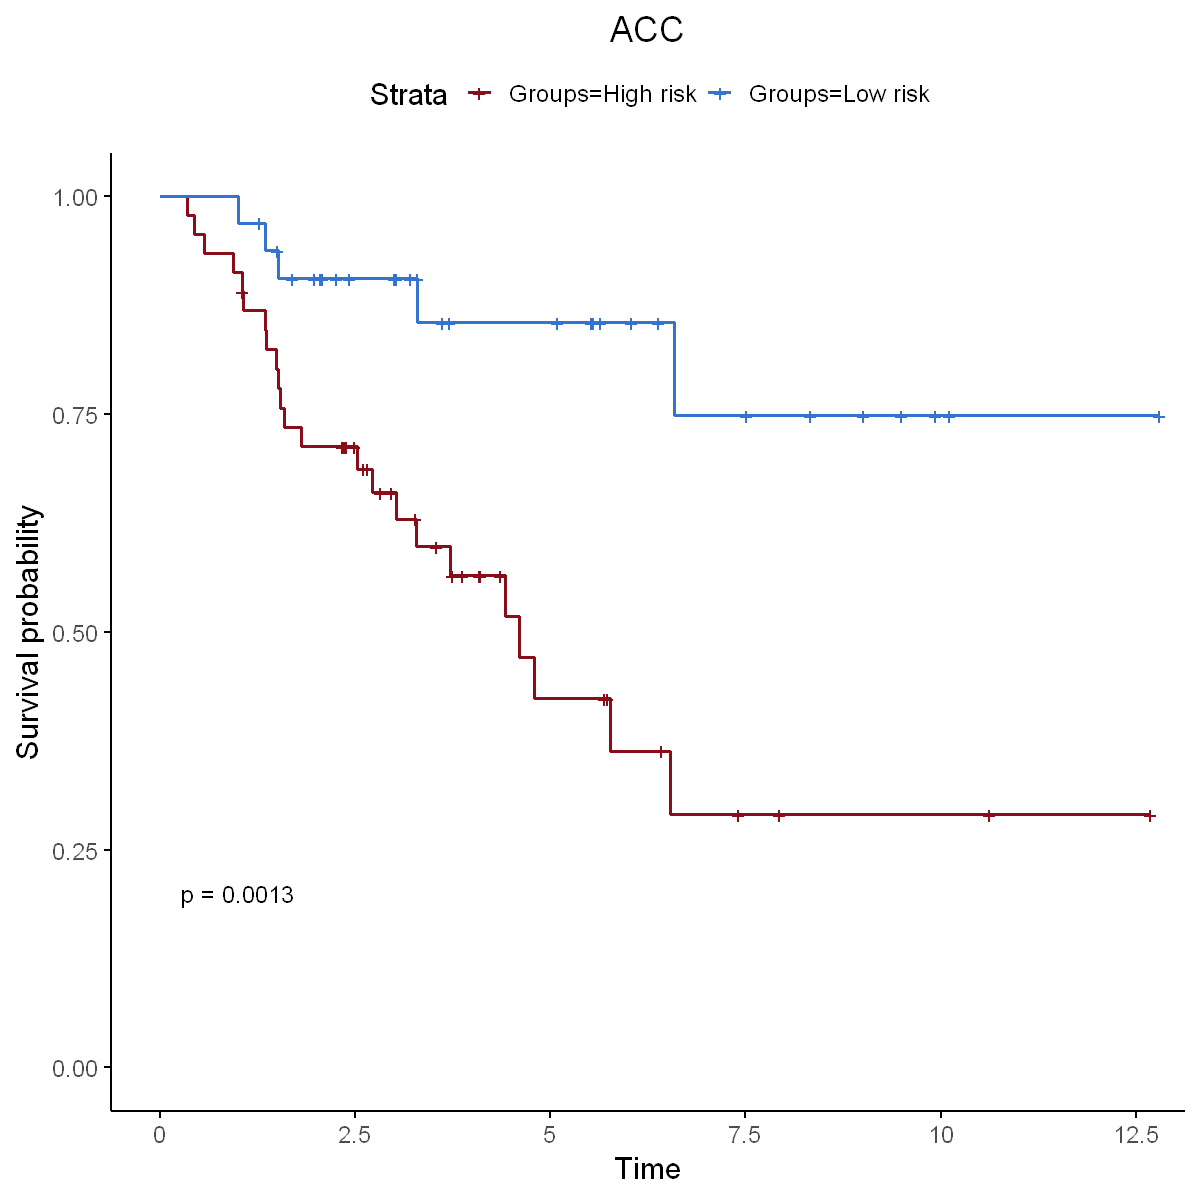

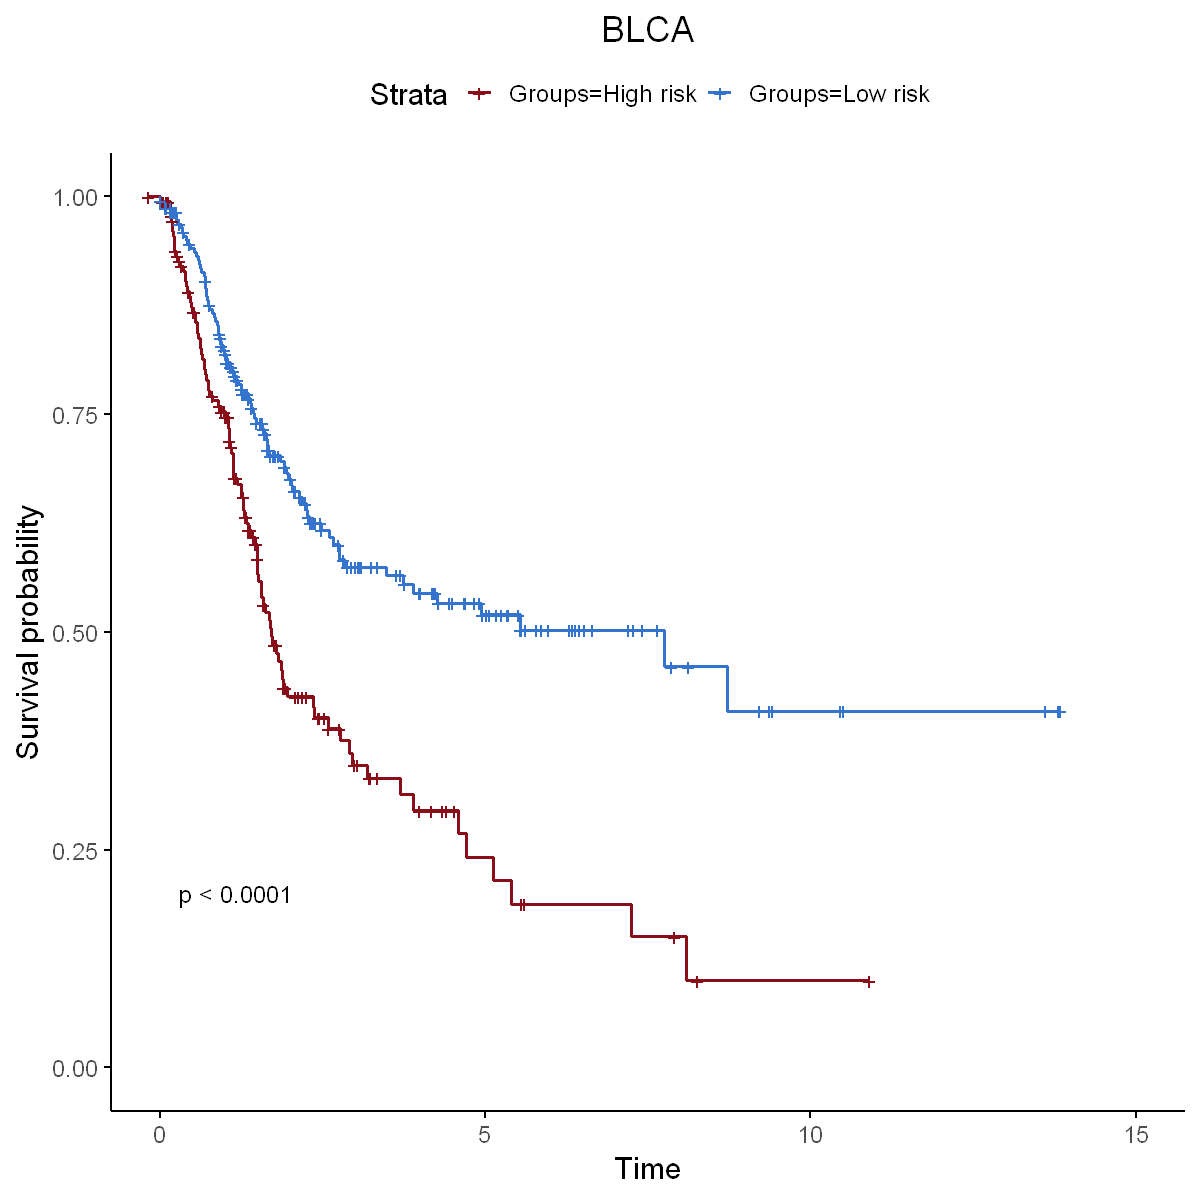

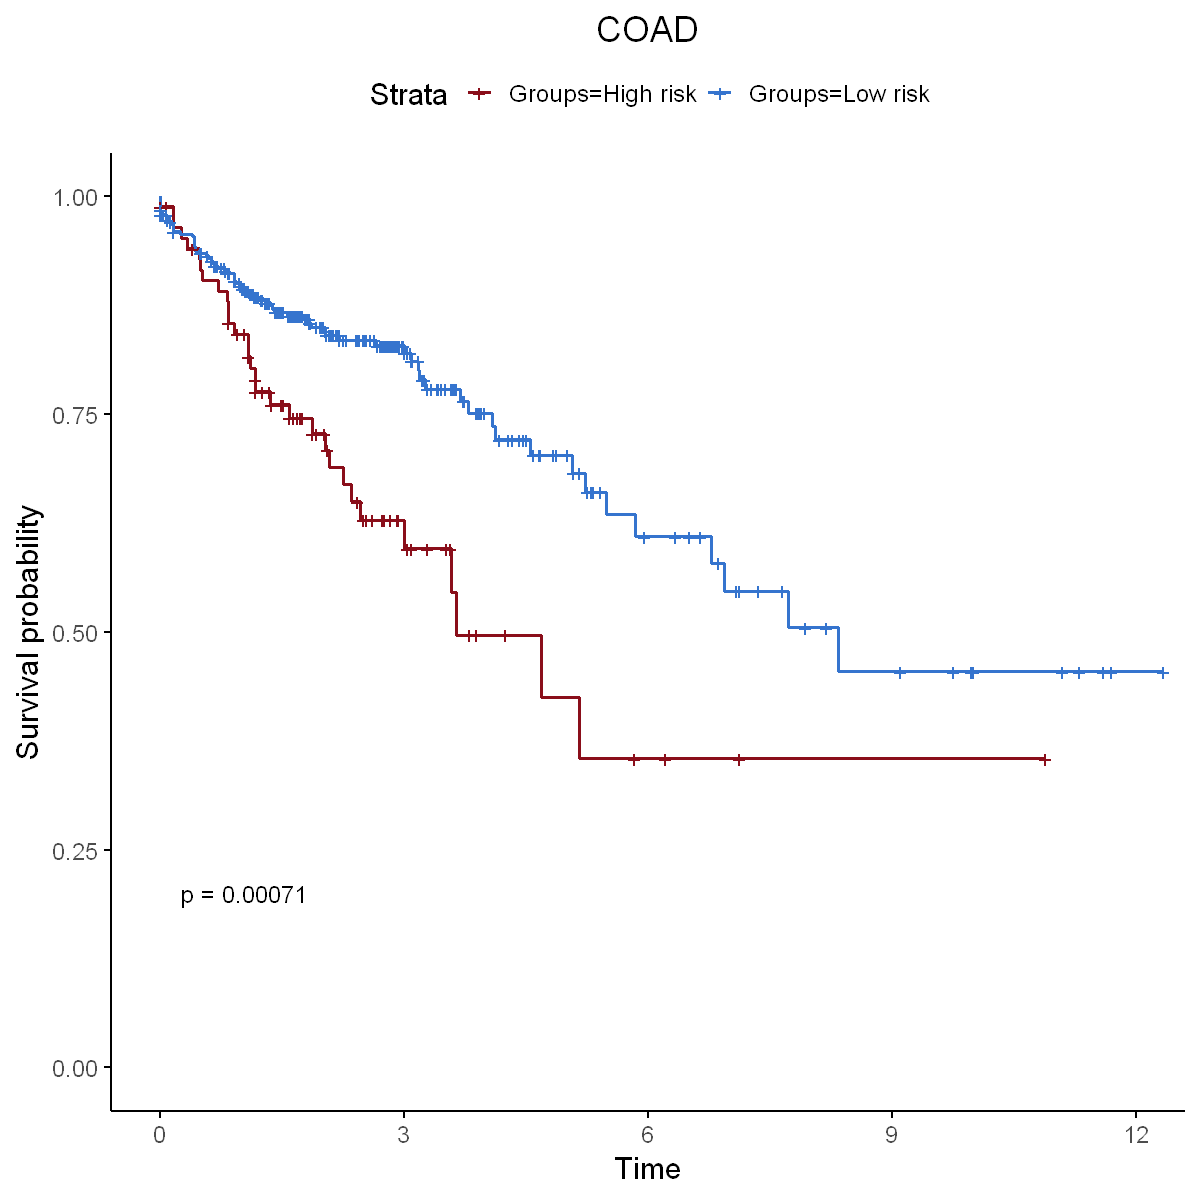

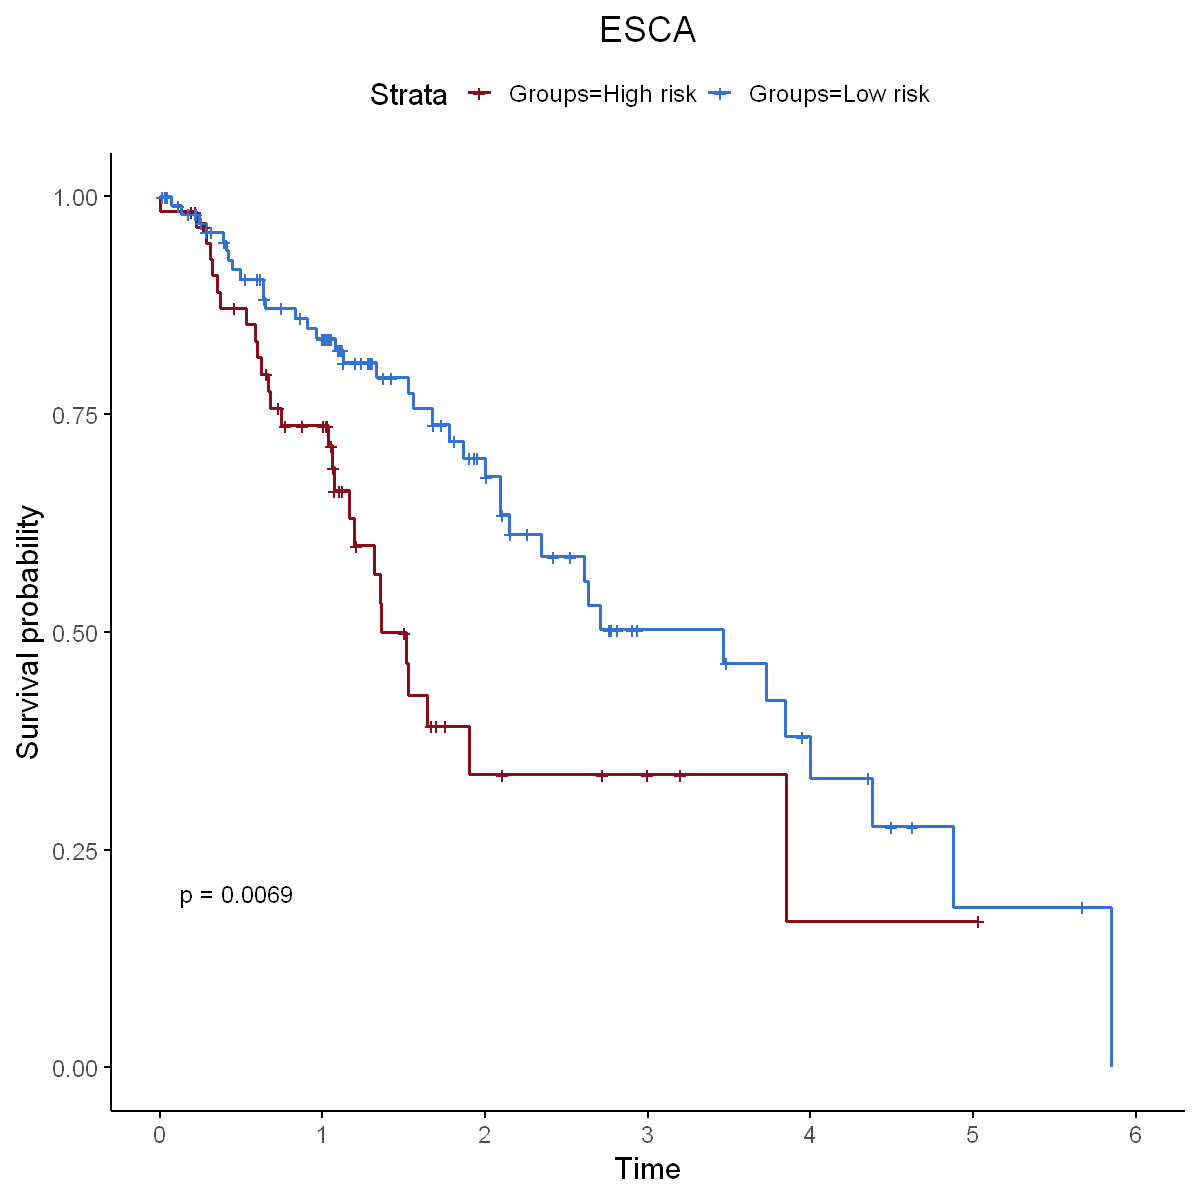

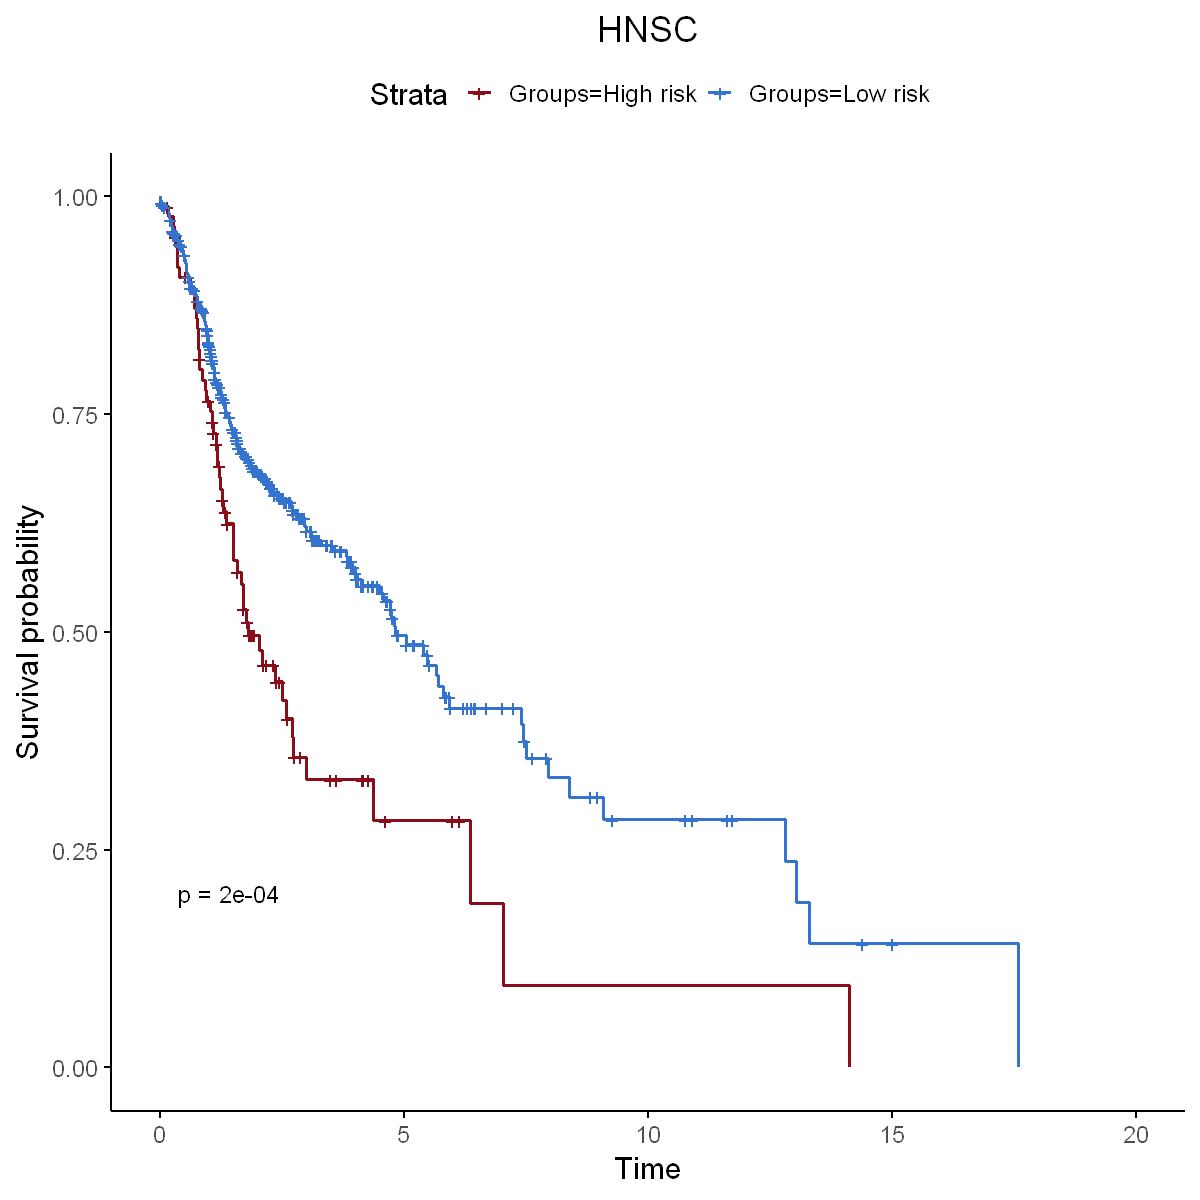

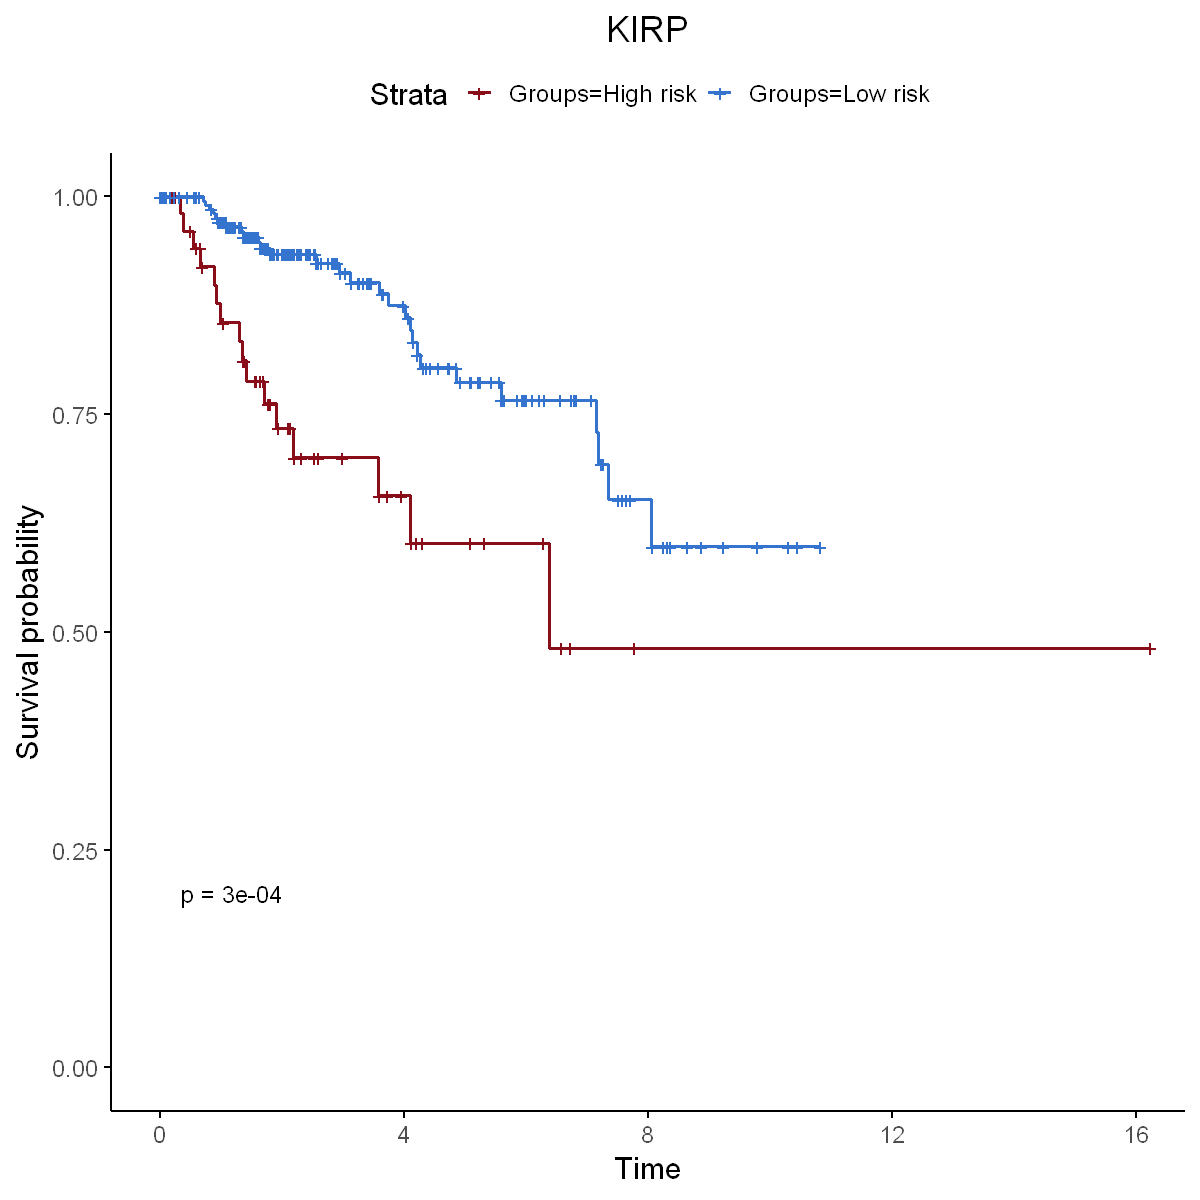

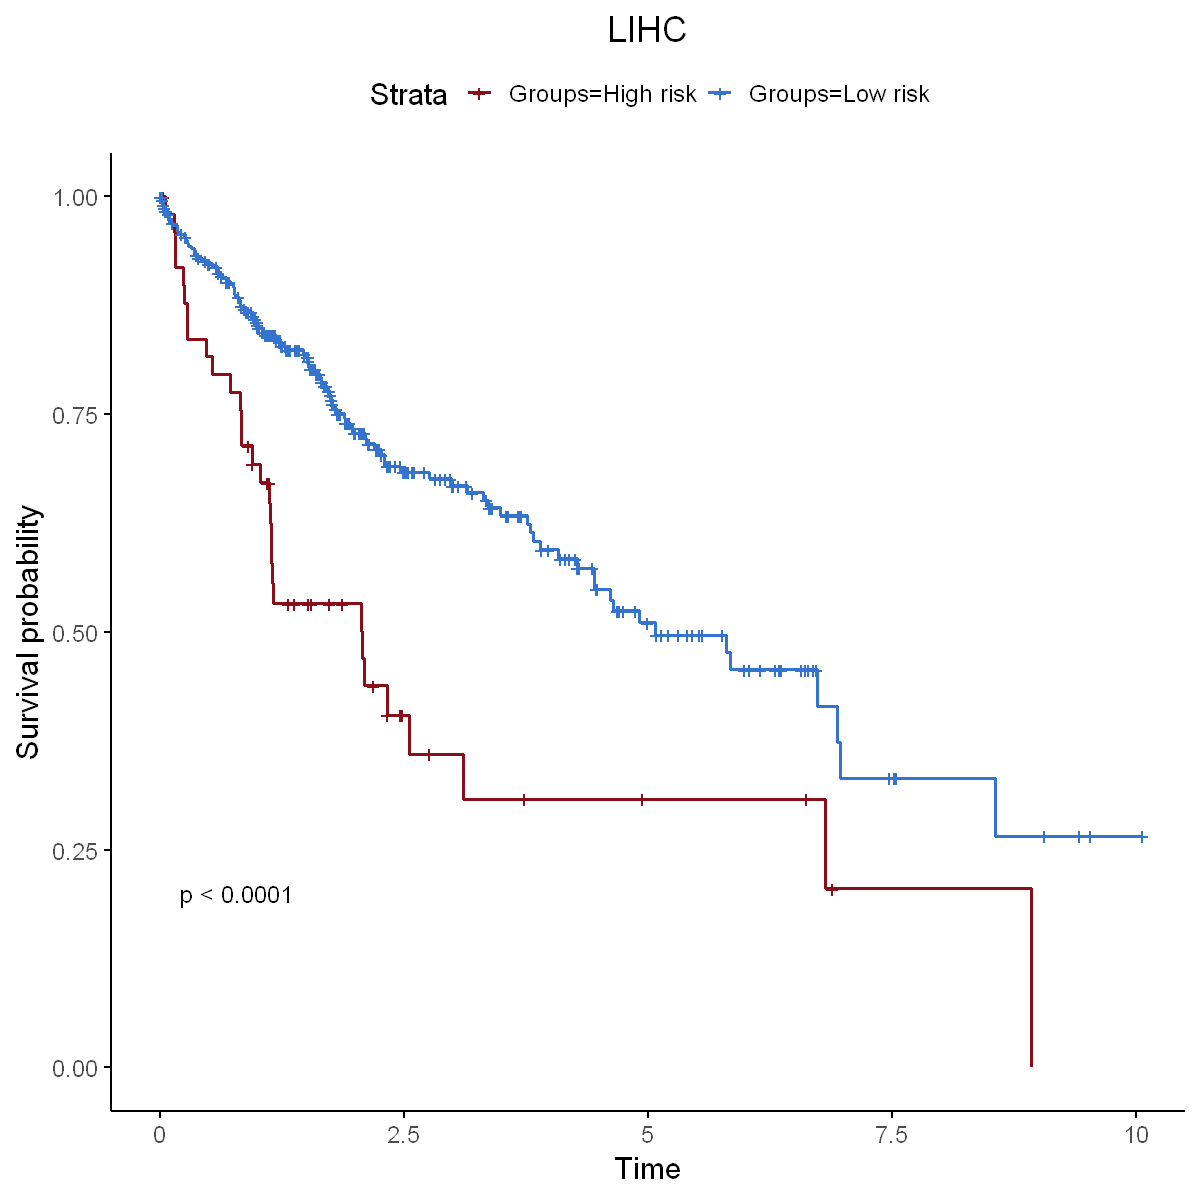

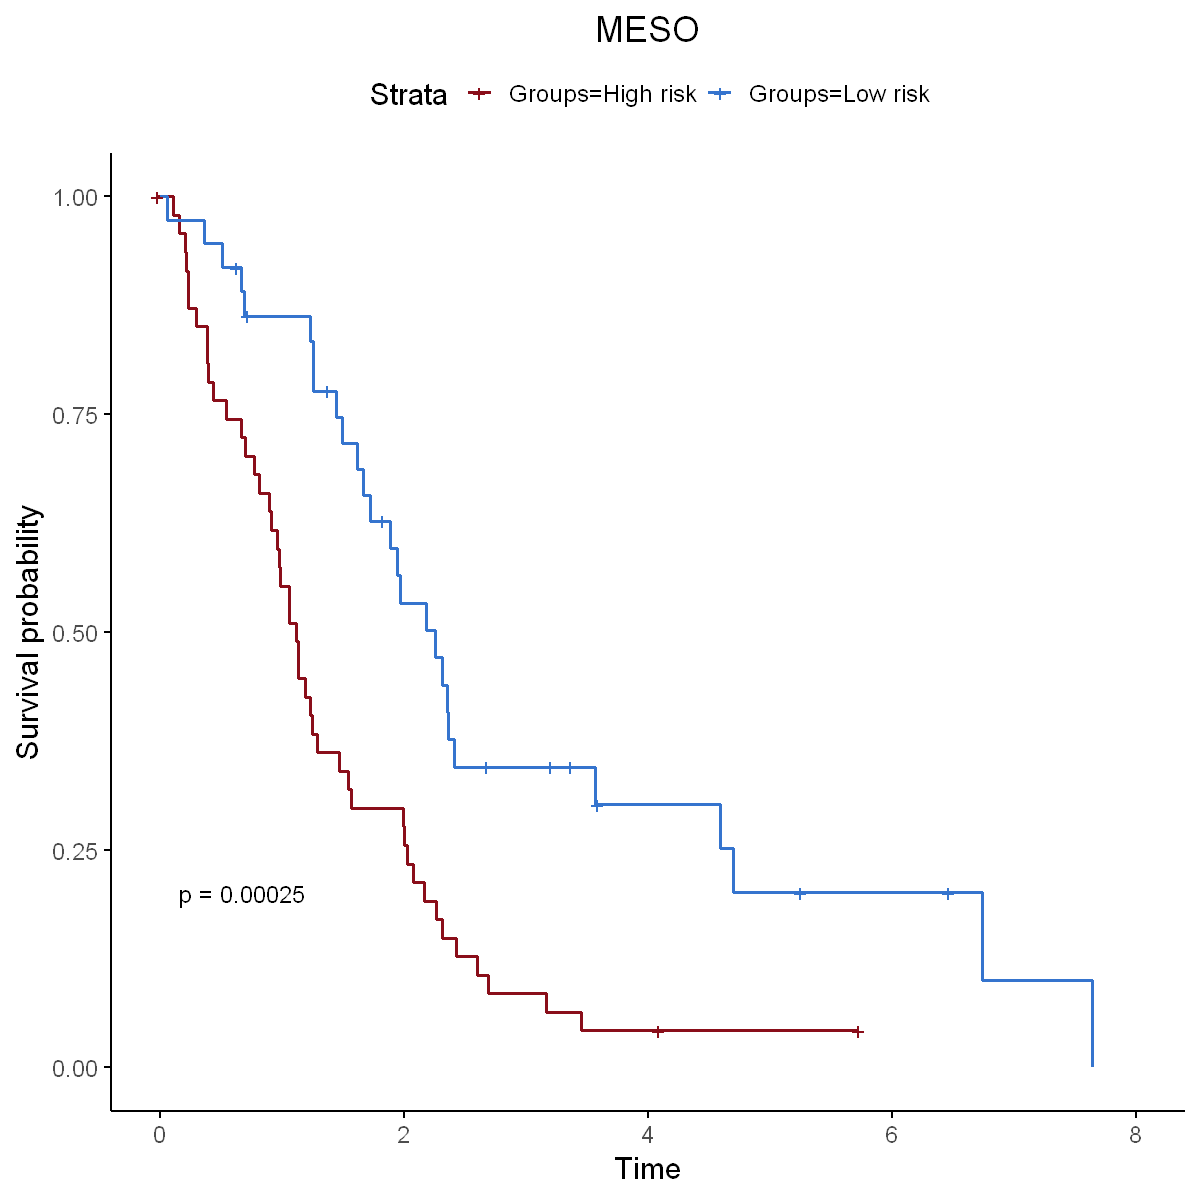

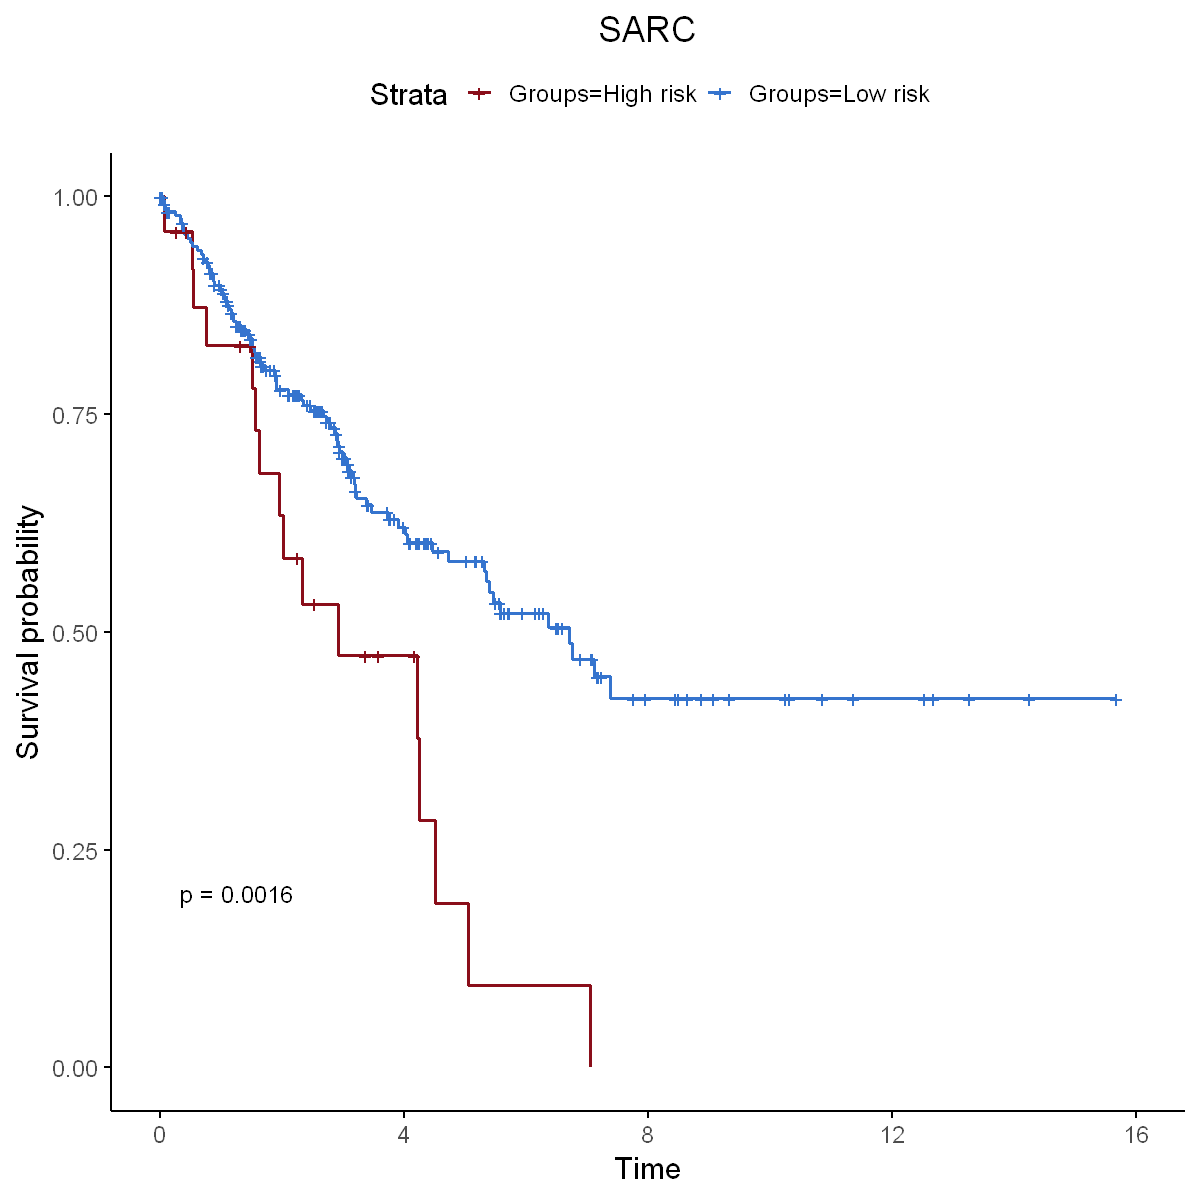

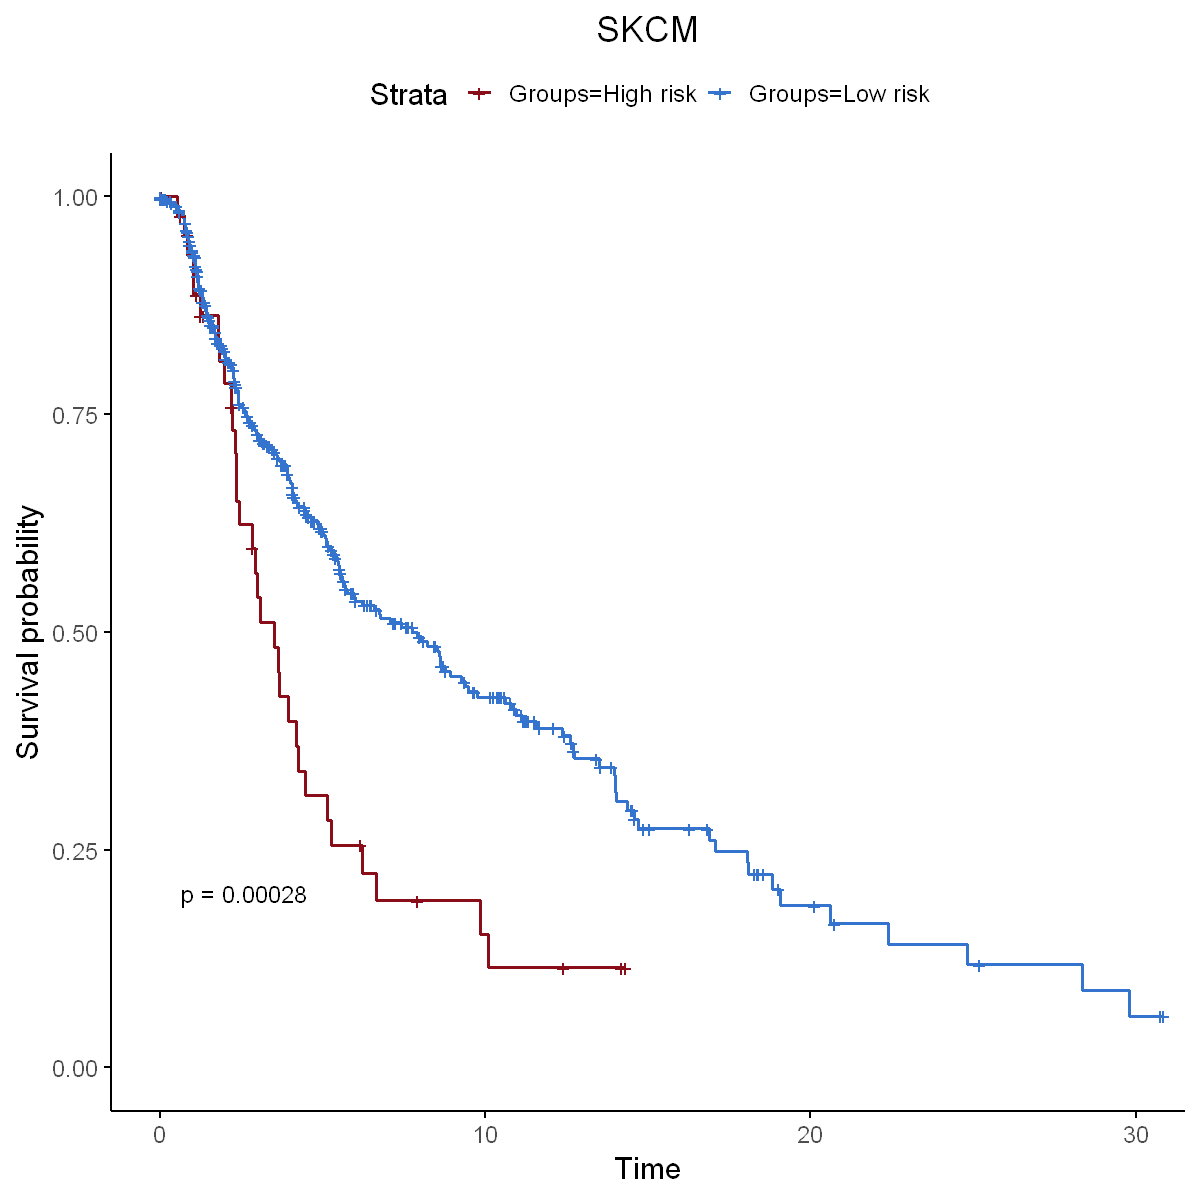

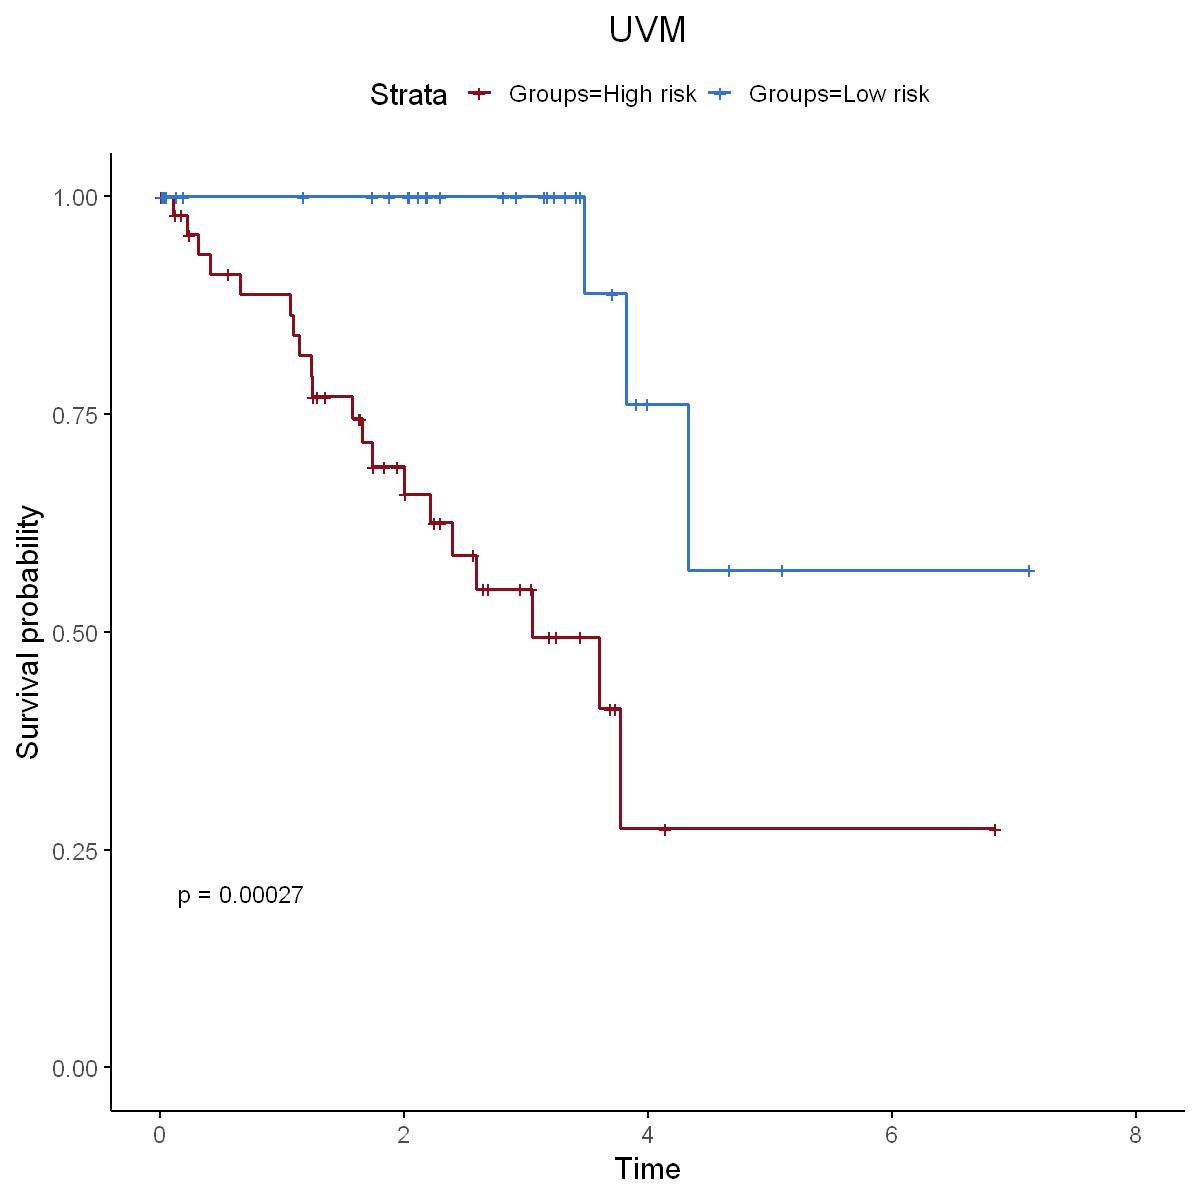

In [803]:
options(repr.plot.width = 10, repr.plot.height = 10)
cox.res <- lapply(sig.cancers, function(cancer) {
    obj <- readRDS(sprintf('../0.data/Pan.cancer/TCGA-%s-Obj.rds', cancer))
    obj.sub <- subset(obj, sample_type == 'Primary Tumor' | sample_type == 'Metastatic' | sample_type == 'Primary Blood Derived Cancer - Peripheral Blood')
    sub.clinical.tmp <- obj.sub@meta.data[, c('patient', 'vital_status', 'days_to_death', 'days_to_last_follow_up')]
    sub.clinical.tmp$Sur <- sub.clinical.tmp$vital_status == "Dead"
    sub.clinical.tmp$Time <- ifelse(sub.clinical.tmp$Sur, sub.clinical.tmp$days_to_death, sub.clinical.tmp$days_to_last_follow_up) / 365

    expr.tmp <- FetchData(obj.sub, vars = gsub('_', '-', hub.genes.sub))  %>% { log2(1 + .)}
    coefs <- mult.var.cox$coefficients[!is.na(mult.var.cox$coefficients)]
    select.sets <- names(coefs)
    risk.ss <- coefs %*% t(as.matrix(expr.tmp[, gsub('_', '-', select.sets)]))
    sub.clinical.tmp$Groups <- as.vector(risk.ss) 
    tmp.cox <- OS.analysis(sub.clinical.tmp, c('#8A0E1A', '#3574CE'), F, cutoff = T, prefix = sprintf('TCGA_%s_OS.pdf', cancer), risk.table = F, title = cancer)
})

In [804]:
sur.plot <- lapply(cox.res, function(x) x$gplot)
length(sur.plot)

[1] 11

[[1]]
NULL


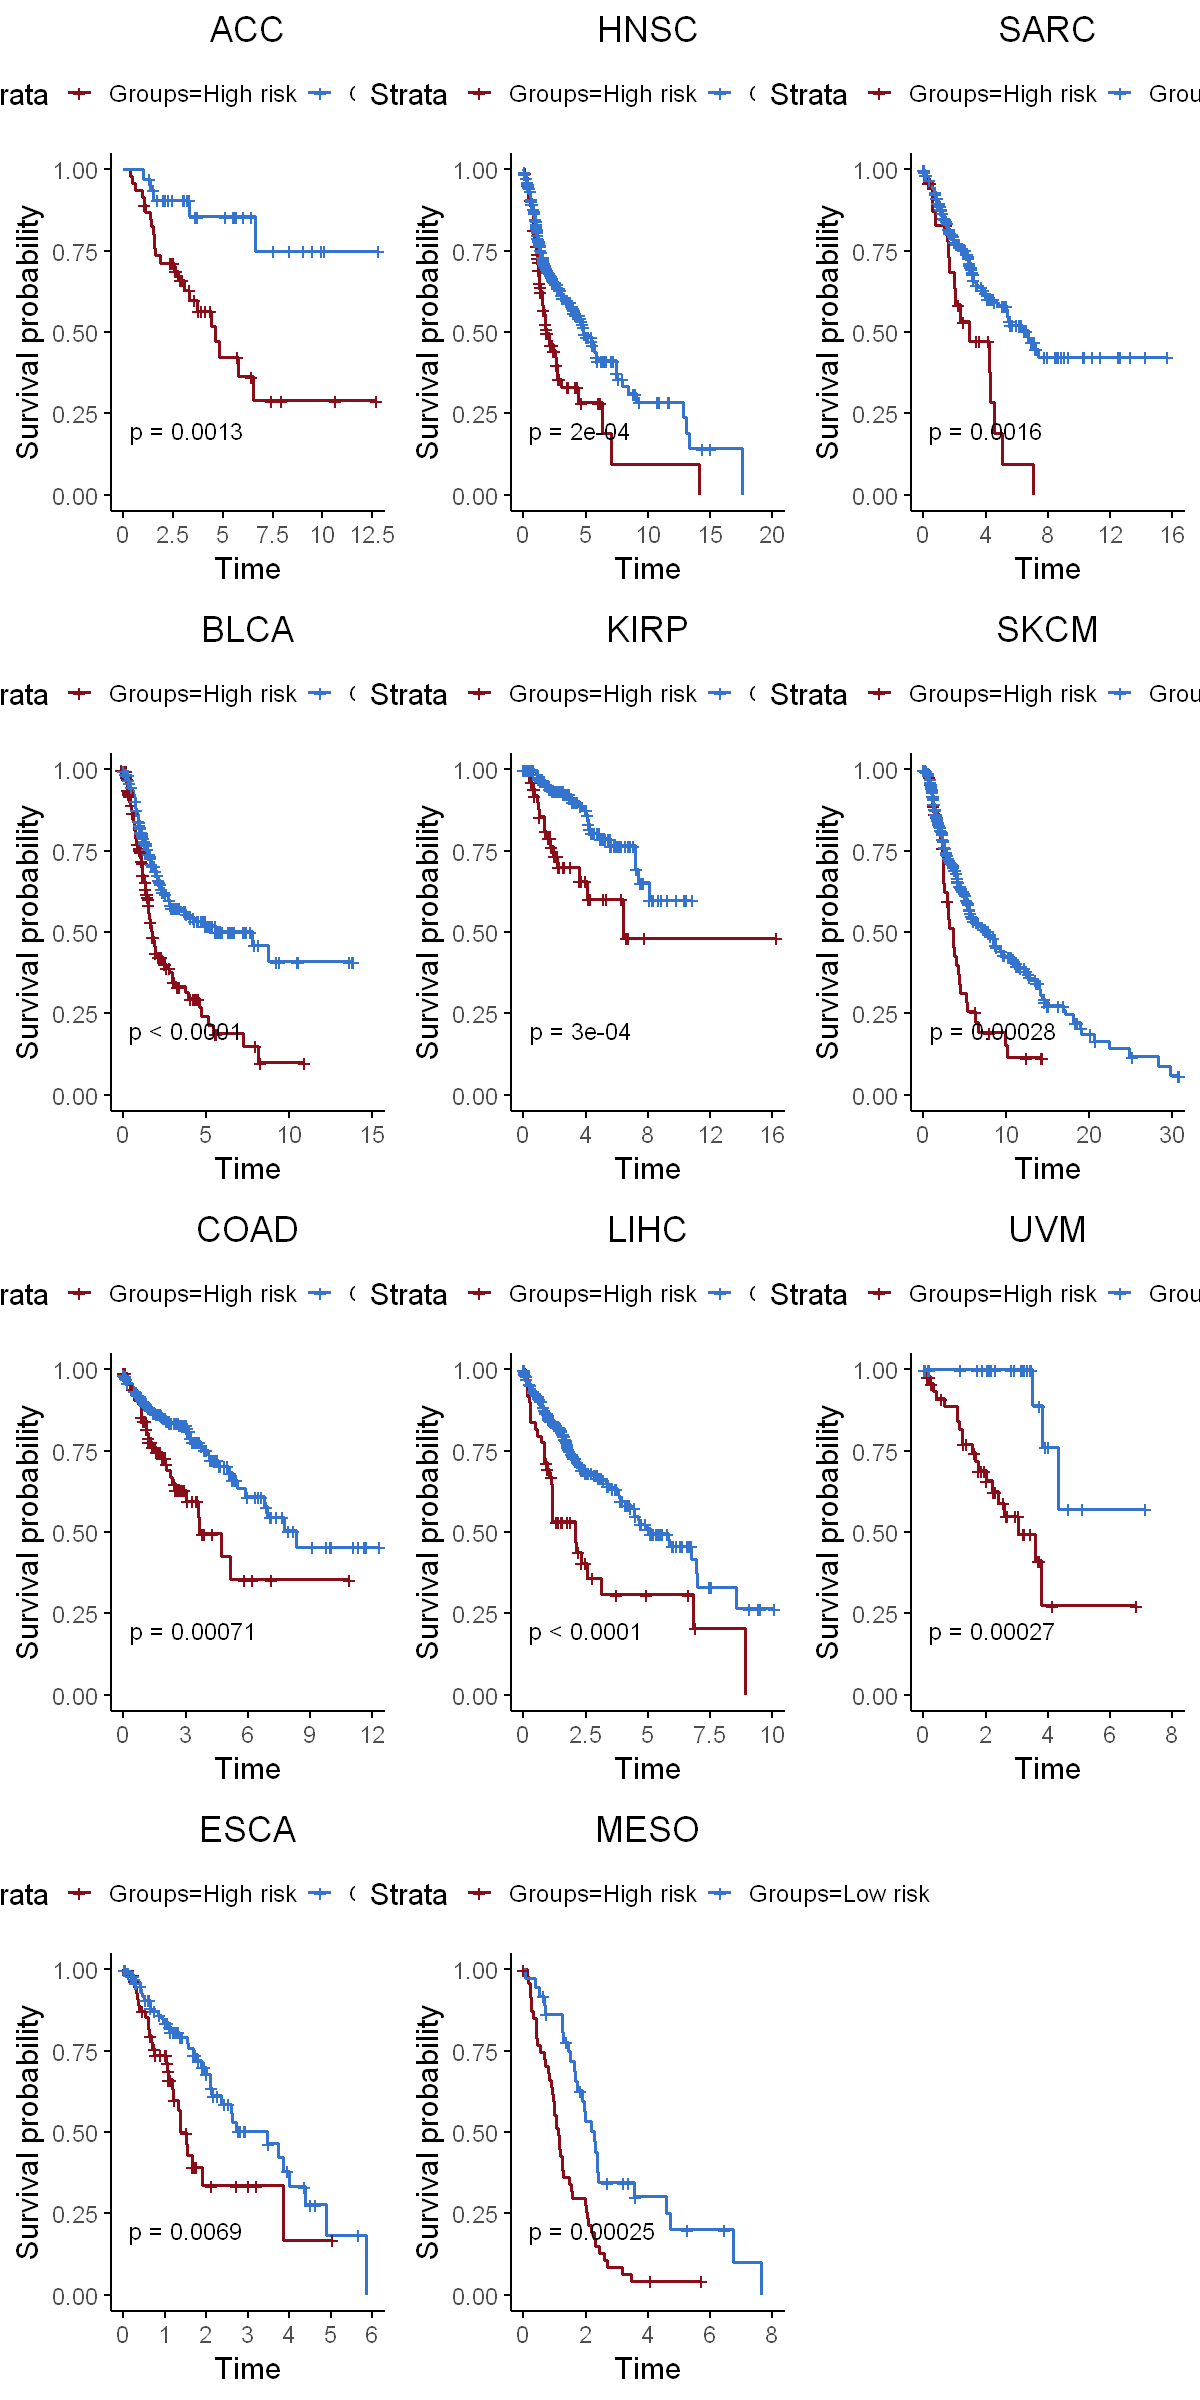

In [806]:
options(repr.plot.width = 10, repr.plot.height = 20)
res.plot <-arrange_ggsurvplots(sur.plot, print = FALSE, ncol = 3, nrow = 4, risk.table.height = 0)
ggsave(file.path(out.figs.dir, 'Pan.cancer.sig.pdf'), plot = res.plot, width = 10, height = 13)
res.plot

In [781]:
library(estimate)
esti.res <- lapply(sig.cancers, function(cancer) {
    obj <- readRDS(sprintf('../0.data/Pan.cancer/TCGA-%s-Obj.rds', cancer))
    obj.sub <- subset(obj, sample_type == 'Primary Tumor' | sample_type == 'Metastatic' | sample_type == 'Primary Blood Derived Cancer - Peripheral Blood')
    tmp.xls <- file.path(out.data.dir, 'tmp_training_data.xls')
    tmp.gct <- file.path(out.data.dir, 'tmp_training_data.gct')
    tmp.score <- file.path(out.data.dir, 'tmp_immune_scores.gct')

    write.table(GetAssayData(obj.sub) %>% as.matrix, tmp.xls, sep = '\t', row.names = TRUE, col.names = NA, quote = FALSE)
    filterCommonGenes(tmp.xls, output.f = tmp.gct, id = "GeneSymbol")
    estimateScore(tmp.gct, tmp.score, platform  = 'affymetrix')
    purity.score <- read.table(tmp.score, sep = '\t', header = TRUE, row.names = 1, skip = 2) %>% .[, -1] 
})

[1] "Merged dataset includes 10214 genes (198 mismatched)."
[1] "1 gene set: StromalSignature  overlap= 139"
[1] "2 gene set: ImmuneSignature  overlap= 141"
[1] "Merged dataset includes 10214 genes (198 mismatched)."
[1] "1 gene set: StromalSignature  overlap= 139"
[1] "2 gene set: ImmuneSignature  overlap= 141"
[1] "Merged dataset includes 10214 genes (198 mismatched)."
[1] "1 gene set: StromalSignature  overlap= 139"
[1] "2 gene set: ImmuneSignature  overlap= 141"
[1] "Merged dataset includes 10214 genes (198 mismatched)."
[1] "1 gene set: StromalSignature  overlap= 139"
[1] "2 gene set: ImmuneSignature  overlap= 141"
[1] "Merged dataset includes 10214 genes (198 mismatched)."
[1] "1 gene set: StromalSignature  overlap= 139"
[1] "2 gene set: ImmuneSignature  overlap= 141"
[1] "Merged dataset includes 10214 genes (198 mismatched)."
[1] "1 gene set: StromalSignature  overlap= 139"
[1] "2 gene set: ImmuneSignature  overlap= 141"
[1] "Merged dataset includes 10214 genes (198 mismatched).

In [782]:
names(esti.res) <- sig.cancers

In [783]:
risk.ss <- lapply(sig.cancers, function(cancer) {
    obj <- readRDS(sprintf('../0.data/Pan.cancer/TCGA-%s-Obj.rds', cancer))
    obj.sub <- subset(obj, sample_type == 'Primary Tumor' | sample_type == 'Metastatic' | sample_type == 'Primary Blood Derived Cancer - Peripheral Blood')
    sub.clinical.tmp <- obj.sub@meta.data[, c('patient', 'vital_status', 'days_to_death', 'days_to_last_follow_up')]
    sub.clinical.tmp$Sur <- sub.clinical.tmp$vital_status == "Dead"
    sub.clinical.tmp$Time <- ifelse(sub.clinical.tmp$Sur, sub.clinical.tmp$days_to_death, sub.clinical.tmp$days_to_last_follow_up)

    expr.tmp <- FetchData(obj.sub, vars = gsub('_', '-', hub.genes.sub))  %>% { log2(1 + .)}
    coefs <- mult.var.cox$coefficients[!is.na(mult.var.cox$coefficients)]
    select.sets <- names(coefs)
    risk.ss <- coefs %*% t(as.matrix(expr.tmp[, gsub('_', '-', select.sets)]))
    return(as.vector(risk.ss))
})

In [784]:
names(risk.ss) <- sig.cancers

In [115]:
sig.cancers <- c('ACC','BLCA','COAD','ESCA','HNSC','KIRP','LIHC','MESO','SARC','SKCM','UVM')

In [792]:
est.plot <- lapply(1 : length(sig.cancers), function(x) {
    group <- cox.res[[x]]$group
    cbind.data.frame(esti.res[[x]][c(1, 2), ] %>% t %>% scale, Group = group, Cancer = sig.cancers[x])    
}) %>% do.call(rbind, .)

In [793]:
sca.df <- cbind.data.frame(Risk = risk.ss$UVM, Immune = esti.res[['UVM']] %>% .[2, ] %>% t %>% scale) %>% as.data.frame

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



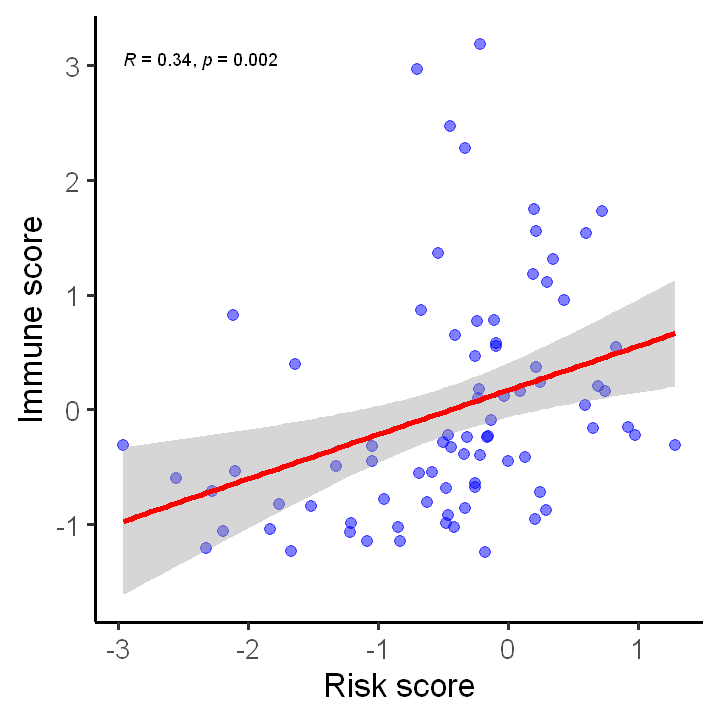

In [794]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(data = sca.df, aes(x = Risk, y = ImmuneScore)) + geom_point(size = 3, color = 'blue', alpha = 0.5) + geom_smooth(method = "lm", se = T, color = 'red', lwd = 1.5) + stat_cor(method="pearson") + theme_classic(base_size = 20) + theme(legend.position = 'none') + xlab('Risk score') + ylab('Immune score')
ggsave(file.path(out.figs.dir, 'UVM.risk.immune.pdf'), width = 6, height = 6)

In [795]:
head(est.plot)

StromalScore ImmuneScore Group     Cancer
TCGA.OR.A5JJ.01A.11R.A29S.07 -0.6676613   -0.7090082  Low risk  ACC   
TCGA.OR.A5LT.01A.11R.A29S.07 -0.7557121   -0.7241064  Low risk  ACC   
TCGA.OR.A5LH.01A.11R.A29S.07 -0.6019411    0.1862074  High risk ACC   
TCGA.OR.A5K0.01A.11R.A29S.07 -1.2030903   -0.6718270  High risk ACC   
TCGA.OR.A5K9.01A.11R.A29S.07 -0.3573127   -0.8941908  High risk ACC   
TCGA.OR.A5LD.01A.11R.A29S.07 -0.7742672   -1.1061682  High risk ACC

In [796]:
est.plot <- tidyr::gather(est.plot, 'Label', 'Score', -Group, -Cancer)
head(est.plot)

Group     Cancer Label        Score     
1 Low risk  ACC    StromalScore -0.6676613
2 Low risk  ACC    StromalScore -0.7557121
3 High risk ACC    StromalScore -0.6019411
4 High risk ACC    StromalScore -1.2030903
5 High risk ACC    StromalScore -0.3573127
6 High risk ACC    StromalScore -0.7742672

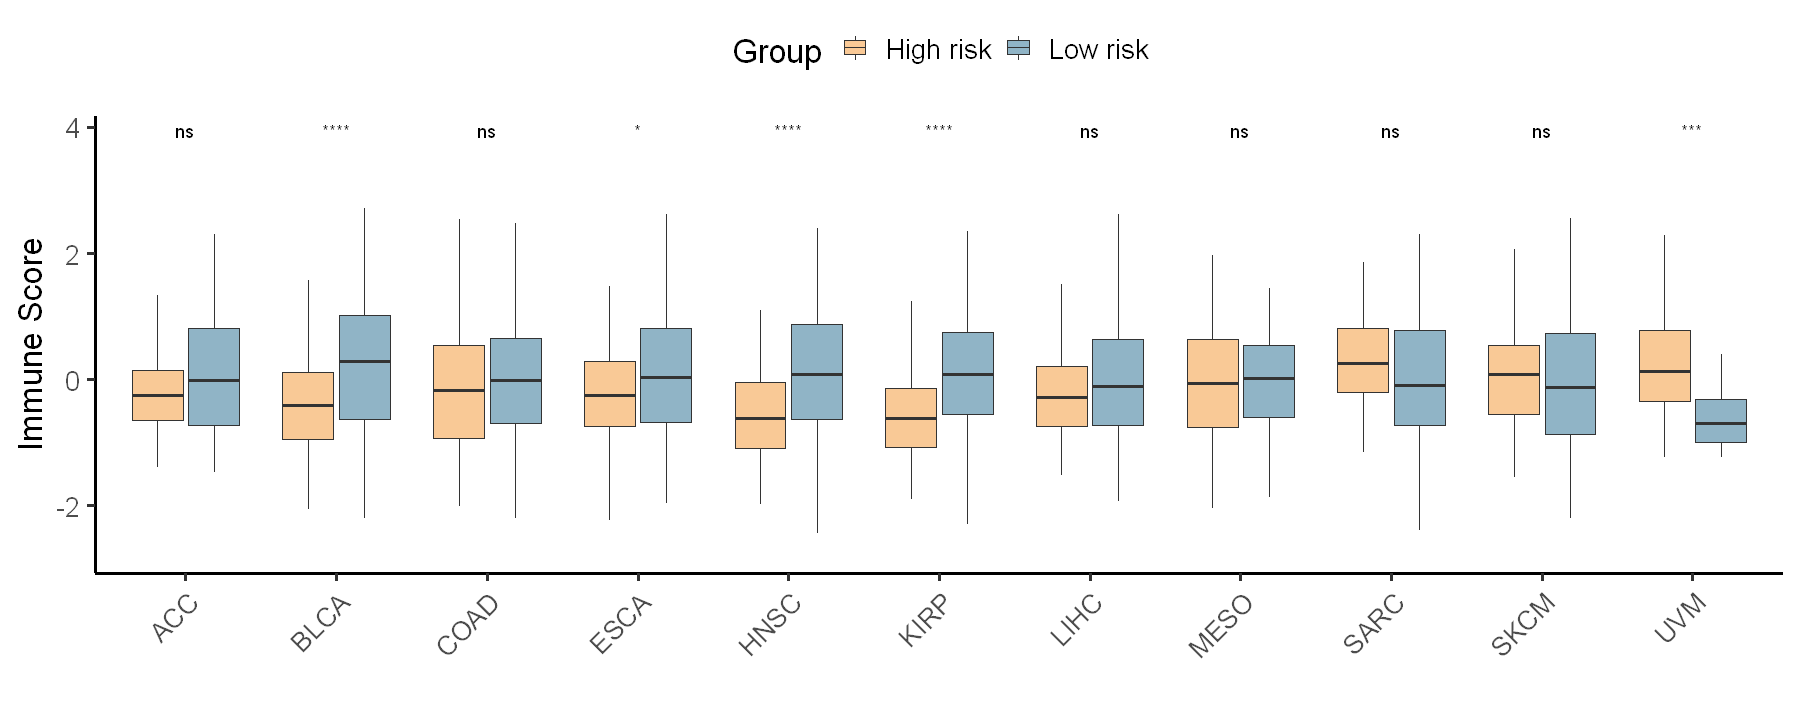

In [797]:
options(repr.plot.width = 15, repr.plot.height = 6)
est.plot.stromal <- subset(est.plot, Label == 'ImmuneScore')
cols <- unlist(PAIRWISE_COLORS)
names(cols) <- c('High risk', 'Low risk')
ggplot(data = est.plot.stromal, aes(x = Cancer, y = Score, fill = Group)) + geom_boxplot(outlier.shape = NA) + theme_bw(base_size = 20) + stat_compare_means(method = 't.test', label = "p.signif") + theme_classic(base_size = 20)  + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1), legend.position="top") + xlab('')  + ylab('Immune Score') + scale_fill_manual(values = cols)
ggsave(file.path(out.figs.dir, 'Immune.score.pan.cancer.pdf'), width = 8, height = 6)

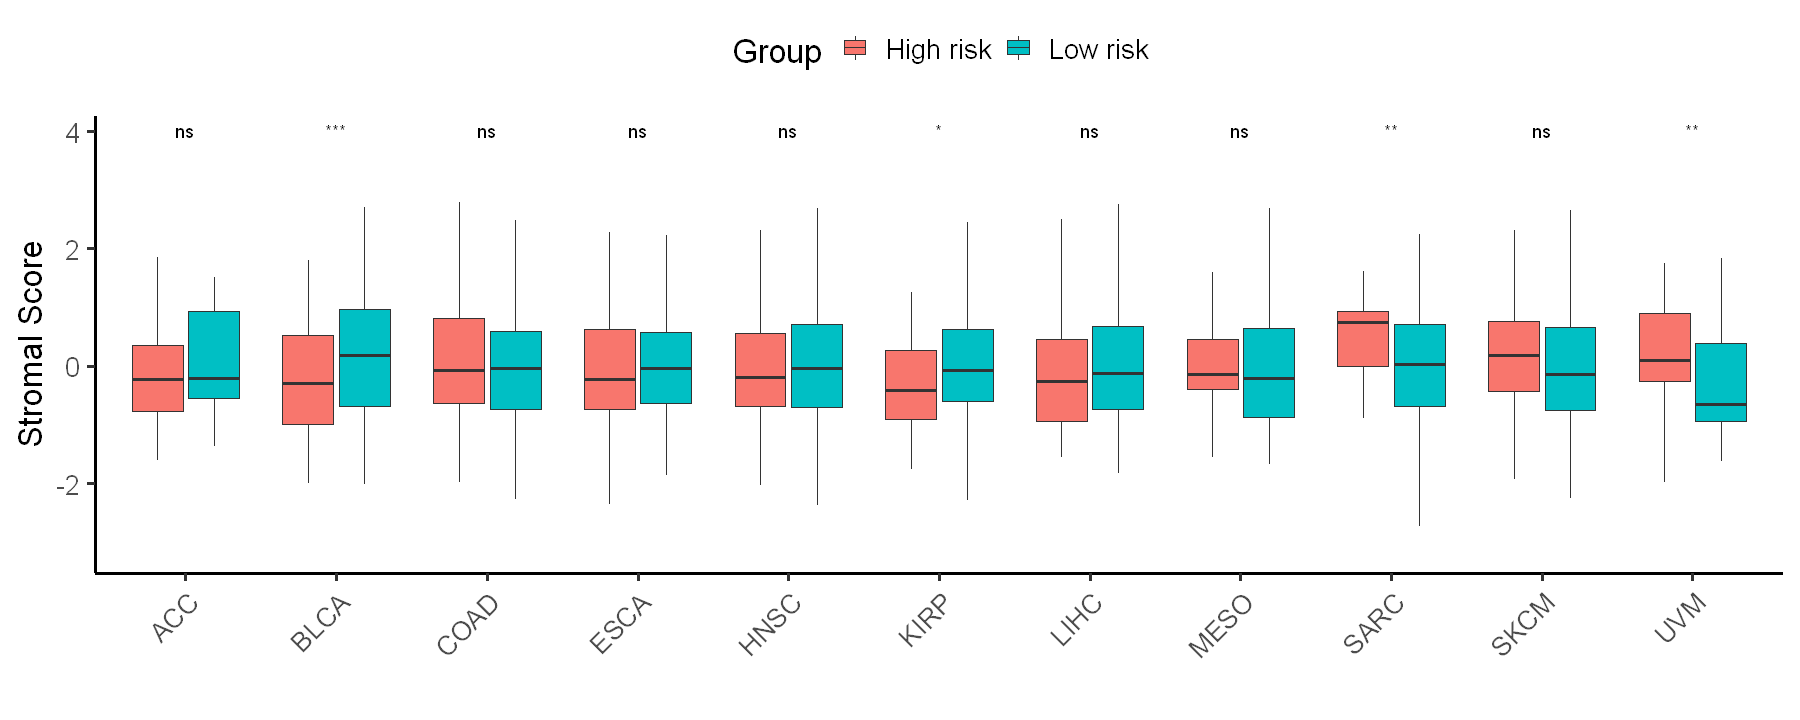

In [798]:
options(repr.plot.width = 15, repr.plot.height = 6)
est.plot.stromal <- subset(est.plot, Label == 'StromalScore')
ggplot(data = est.plot.stromal, aes(x = Cancer, y = Score, fill = Group)) + geom_boxplot(outlier.shape = NA) + theme_bw(base_size = 20) + stat_compare_means(method = 't.test', label = "p.signif") + theme_classic(base_size = 20)  + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1), legend.position="top") + xlab('')  + ylab('Stromal Score')

In [799]:
ips.ss <- lapply(sig.cancers, function(cancer) {
    obj <- readRDS(sprintf('../0.data/Pan.cancer/TCGA-%s-Obj.rds', cancer))
    obj.sub <- subset(obj, sample_type == 'Primary Tumor' | sample_type == 'Metastatic' | sample_type == 'Primary Blood Derived Cancer - Peripheral Blood')
    source('IPS.R')
    ips.score <- IPSCore(GetAssayData(obj.sub) %>% as.data.frame %>% { log2(1 + .) })
})

differently named or missing genes:  CCL3L1 
differently named or missing genes:  CCL3L1 
differently named or missing genes:  CCL3L1 
differently named or missing genes:  CCL3L1 
differently named or missing genes:  CCL3L1 
differently named or missing genes:  CCL3L1 
differently named or missing genes:  CCL3L1 
differently named or missing genes:  CCL3L1 
differently named or missing genes:  CCL3L1 
differently named or missing genes:  CCL3L1 
differently named or missing genes:  CCL3L1 


In [800]:
est.plot <- lapply(1 : length(sig.cancers), function(x) {   
    group <- cox.res[[x]]$group
    dim(group)
    dim(ips.ss[[x]])
    cbind.data.frame(IPS = ips.ss[[x]][, 6], Group = group, Cancer = sig.cancers[x])  
}) %>% do.call(rbind, .)

In [801]:
head(est.plot)

IPS      Group     Cancer
1 3.396132 Low risk  ACC   
2 3.668195 Low risk  ACC   
3 4.451541 High risk ACC   
4 4.348812 High risk ACC   
5 3.005572 High risk ACC   
6 2.390665 High risk ACC

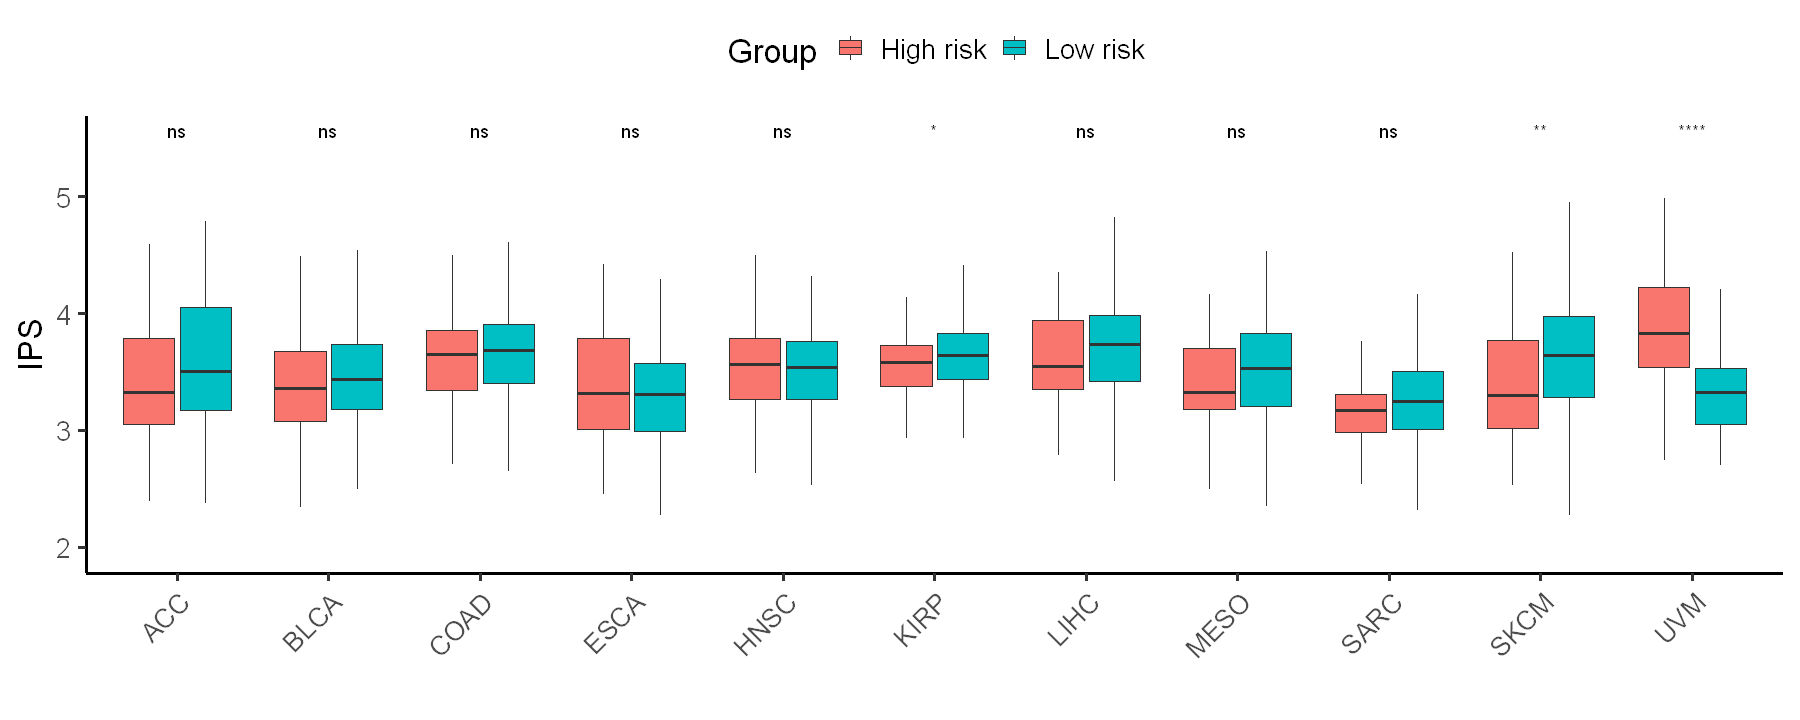

In [802]:
options(repr.plot.width = 15, repr.plot.height = 6)
ggplot(data = est.plot, aes(x = Cancer, y = IPS, fill = Group)) + geom_boxplot(outlier.shape = NA) + theme_bw(base_size = 20) + stat_compare_means(label = "p.signif") + theme_classic(base_size = 20)  + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1), legend.position="top") + xlab('') 

In [116]:
log2FcCalc <- lapply(sig.cancers, function(cancer) {    
    obj <- readRDS(sprintf('../0.data/Pan.cancer/TCGA-%s-Obj.rds', cancer))
    if (!'Solid Tissue Normal' %in% (obj@meta.data$sample_type %>% unique)) return(NA)
    obj.tumor <- subset(obj, sample_type == 'Primary Tumor' | sample_type == 'Metastatic' | sample_type == 'Primary Blood Derived Cancer - Peripheral Blood')
    obj.normal <- subset(obj, sample_type == 'Solid Tissue Normal')
    tumor.exprs <- colMeans(FetchData(obj.tumor, vars = gsub('_', '-', hub.genes.sub)))
    normal.exprs <- colMeans(FetchData(obj.normal, vars = gsub('_', '-', hub.genes.sub)))
    log2(tumor.exprs / (0.01 + normal.exprs))
})

In [117]:
names(log2FcCalc) <- sig.cancers
log2FcCalc <- log2FcCalc[!is.na(log2FcCalc)]
log2FcCalc <- log2FcCalc %>% as.data.frame
log2FcCalc

In [121]:
options(repr.plot.width = 20, repr.plot.height = 4)

pheatmap::pheatmap(t(log2FcCalc), cluster_rows = T, cluster_cols = T, fontsize = 15, file = file.path(out.figs.dir, 'log2fc.heatmap.pdf'), height = 5, width = 12)

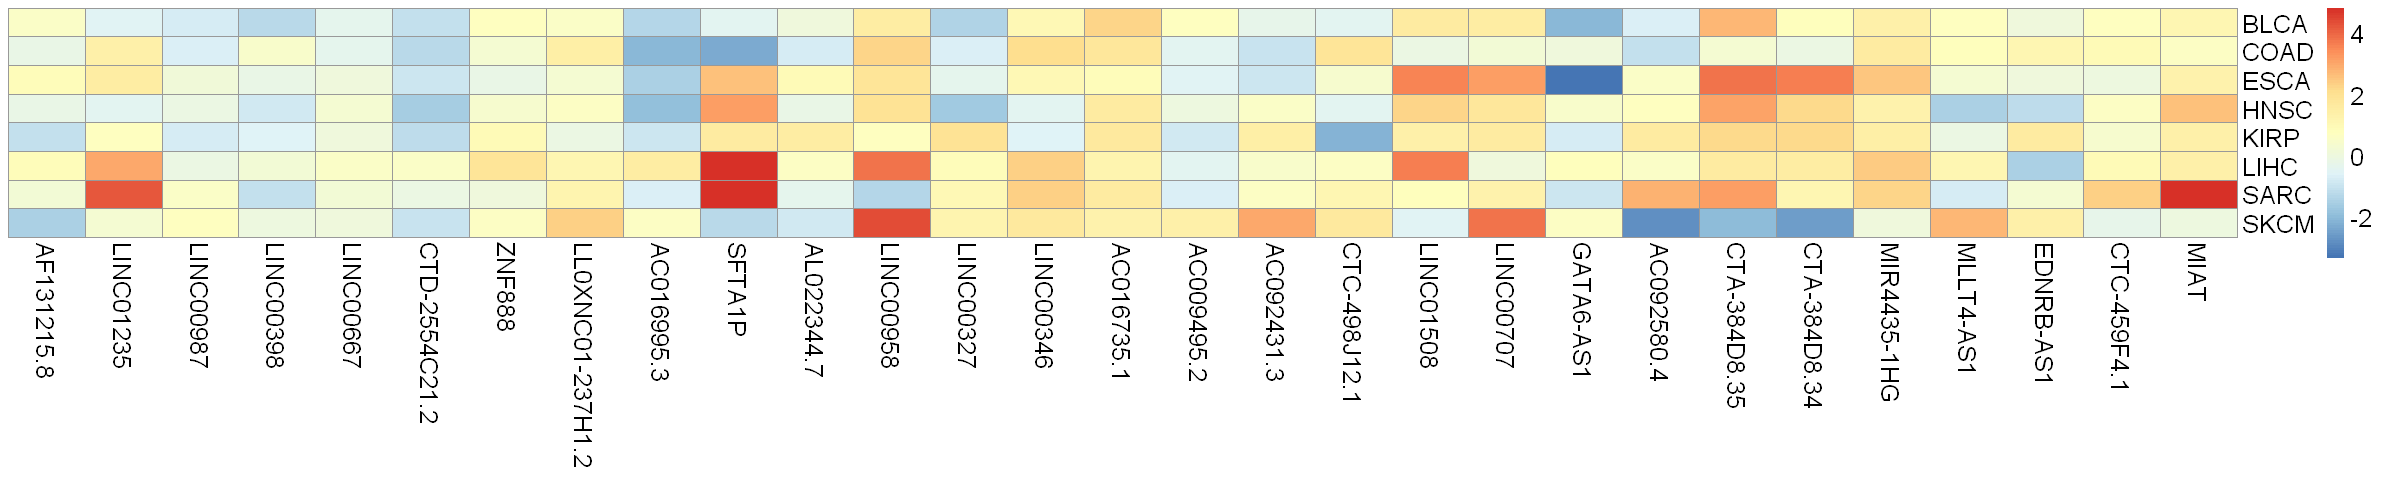

In [122]:
pheatmap::pheatmap(t(log2FcCalc), cluster_rows = F, cluster_cols = F, fontsize = 15)

In [157]:
log2FcCalc <- lapply(sig.cancers, function(cancer) {
    obj <- readRDS(sprintf('../0.data/Pan.cancer/TCGA-%s-Obj.rds', cancer))
    obj.sub <- subset(obj, sample_type == 'Primary Tumor' | sample_type == 'Metastatic' | sample_type == 'Primary Blood Derived Cancer - Peripheral Blood')
    sub.clinical.tmp <- obj.sub@meta.data[, c('patient', 'vital_status', 'days_to_death', 'days_to_last_follow_up')]
    sub.clinical.tmp$Sur <- sub.clinical.tmp$vital_status == "Dead"
    sub.clinical.tmp$Time <- ifelse(sub.clinical.tmp$Sur, sub.clinical.tmp$days_to_death, sub.clinical.tmp$days_to_last_follow_up) / 365

    expr.tmp <- FetchData(obj.sub, vars = gsub('_', '-', hub.genes.sub))  %>% { log2(1 + .)}
    coefs <- mult.var.cox$coefficients[!is.na(mult.var.cox$coefficients)]
    select.sets <- names(coefs)
    risk.ss <- coefs %*% t(as.matrix(expr.tmp[, gsub('_', '-', select.sets)]))
    sub.clinical.tmp$Groups <- as.vector(risk.ss) 
    tmp.cox <- OS.analysis(sub.clinical.tmp, c('#8A0E1A', '#3574CE'), T, cutoff = T, prefix = sprintf('TCGA_%s_OS.pdf', cancer), risk.table = F, title = cancer, out.figs.dir = out.figs.dir)
    obj.sub@meta.data$Group <- tmp.cox$group
    obj.sub.high <- subset(obj.sub, Group == 'High risk')
    obj.sub.low <- subset(obj.sub, Group == 'Low risk')
        
    tumor.exprs <- colMeans(FetchData(obj.sub.high, vars = gsub('_', '-', hub.genes.sub)))
    normal.exprs <- colMeans(FetchData(obj.sub.low, vars = gsub('_', '-', hub.genes.sub)))
    log2(tumor.exprs / (0.01 + normal.exprs))   
})

In [158]:
names(log2FcCalc) <- sig.cancers
log2FcCalc <- log2FcCalc[!is.na(log2FcCalc)]
log2FcCalc <- log2FcCalc %>% as.data.frame
log2FcCalc

ACC         BLCA         COAD        ESCA        HNSC        
AF131215.8        0.81502490  0.985456140  0.49670895  0.74413468  1.060263376
LINC01235         0.79352990 -0.003049091  0.54927866  0.05226120  0.361366930
LINC00987        -0.59828261 -0.356178924 -0.13130242 -0.71026387 -0.440232717
LINC00398         1.39404324 -0.802347687  0.31738435 -0.64746742 -0.224746088
LINC00667        -0.04149651 -0.325220721 -0.36503380 -0.25645480 -0.186927729
CTD-2554C21.2    -1.16212407 -0.132536966  0.24699467 -0.86162162 -1.215301061
ZNF888           -0.46709452  1.050699509  0.55517740  0.52792256  0.402550143
LL0XNC01-237H1.2 -0.67440783  0.293321280  1.31644833  0.30570838  0.054336575
AC016995.3       -0.52141708 -0.827352354 -0.07788888 -0.81841876 -0.601072708
SFTA1P           -0.01026646 -0.113540647  0.90607415  1.61467903  2.202017770
AL022344.7        1.19618036  1.204773330  0.17394336  0.47583836  0.924173999
LINC00958        -0.76944116  0.297475079  0.32210672 -0.05484957  0.449080060
LINC00327        -0.89781931 -0.882311099 -0.53162664 -0.35549254 -0.454252708
LINC00346         0.75562683  0.044639528  0.71059982  0.40194617  0.823715437
AC016735.1       -0.17199013 -0.407697505 -0.23277451 -0.26338300  0.005052688
AC009495.2       -1.22858189 -0.343907344  0.03270092 -0.17427365  0.181089286
AC092431.3       -0.38962562  0.248459553  0.94431091  0.49368153  0.801177825
CTC-498J12.1     -1.32861937 -0.163256781 -0.34351687 -0.18053926 -0.640151247
LINC01508        -1.09494588  1.329534712  0.16672730  1.39623333  1.305084326
LINC00707        -3.69839512 -2.046491446 -0.82168162 -1.44514119 -0.401578019
GATA6-AS1         1.08268031 -0.542210994  0.35044578  1.30479888 -0.470791911
AC092580.4       -0.22939662 -1.556486407 -0.60627454 -0.77295105 -1.162081897
CTA-384D8.35     -0.93425070 -1.639934177 -0.51103593 -1.00215146 -0.791475137
CTA-384D8.34     -1.46507390 -1.359004146 -0.38922048 -0.52099132 -0.824701081
MIR4435-1HG       0.47123279 -0.073396124  0.34362462  0.26027335  0.633124344
MLLT4-AS1         0.74030906  0.213397377  0.32062732  0.37662888  0.165130054
EDNRB-AS1        -1.83053471 -1.664210708 -1.71799941 -1.66650668 -2.263447706
CTC-459F4.1      -0.98923301 -0.217021885  0.59863615 -0.36002568 -0.265334565
MIAT             -0.29164217 -2.185770423 -0.07657509 -0.45376073 -0.894865185
                 KIRP         LIHC        MESO        SARC         SKCM       
AF131215.8        0.296494449  1.44551522  1.55139612  1.610029111 -0.46025186
LINC01235         0.601773773  0.90354849 -0.48324568  1.237643779  0.59361012
LINC00987        -0.054720303 -1.07543795 -0.57135891  0.212514625 -1.94444031
LINC00398        -0.318581194 -0.62504077  0.16803319 -0.927741529 -1.19074168
LINC00667        -0.067364523  0.21649312  0.05173750  0.002696177 -0.25451095
CTD-2554C21.2    -0.064666402  1.15549988 -0.94719916 -2.145402297 -1.20350743
ZNF888            0.756429445  1.70919466 -0.22053915  0.261396645 -0.28004616
LL0XNC01-237H1.2  0.507548258  0.87320843  0.08276762  0.062144602 -0.18056468
AC016995.3       -0.164734264  0.95660135 -0.44811498 -1.280685621 -1.18136932
SFTA1P            0.030230840  0.60409501  2.95277066  3.786315185  0.57110451
AL022344.7        0.882106211  1.24935609  0.09061006  0.840935087 -0.26052672
LINC00958         0.442752872  2.55525531 -0.63679204  0.446375262  1.63975578
LINC00327         0.010934274  0.12912970  0.42089088 -0.731990212 -1.93488488
LINC00346         0.063824790  1.24492206  1.54291241  0.977464567  0.60611057
AC016735.1        0.190627169  0.96565685 -0.02083048  0.172430063 -1.54324128
AC009495.2       -0.003834396  0.31727963 -1.11317440 -0.897121842 -0.97564935
AC092431.3        1.199695779  0.70125537  0.26790788  0.023966442  0.33672297
CTC-498J12.1     -0.720096882 -0.58950698  0.32124617 -0.203616257 -1.59642767
LINC01508         0.993871333  3.07217033  2.24015523  1.212160417 -0.64337658
LINC00707        -0.026025737  0.41676862 -1.02204864 -0.926698272 

In [159]:
options(repr.plot.width = 20, repr.plot.height = 4)

pheatmap::pheatmap(t(log2FcCalc), cluster_rows = T, cluster_cols = T, fontsize = 15, file = file.path(out.figs.dir, 'log2fc.high.vs.low.heatmap.pdf'), height = 5, width = 12)

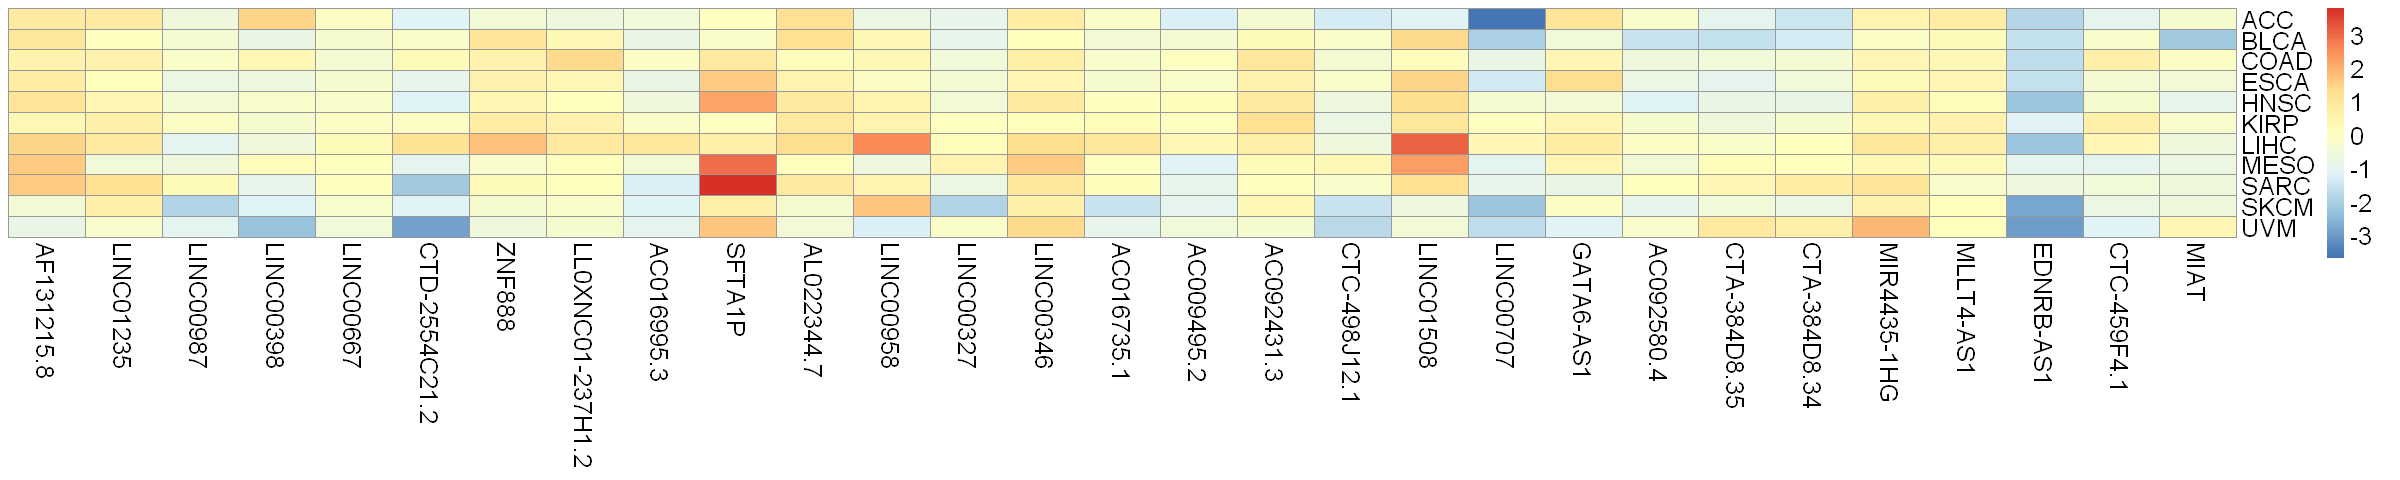

In [160]:
pheatmap::pheatmap(t(log2FcCalc), cluster_rows = F, cluster_cols = F, fontsize = 15)

In [166]:
log2FcCalc <- lapply(sig.cancers, function(cancer) {
    obj <- readRDS(sprintf('../0.data/Pan.cancer/TCGA-%s-Obj.rds', cancer))
    obj.sub <- subset(obj, sample_type == 'Primary Tumor' | sample_type == 'Metastatic' | sample_type == 'Primary Blood Derived Cancer - Peripheral Blood')
    sub.clinical.tmp <- obj.sub@meta.data[, c('patient', 'vital_status', 'days_to_death', 'days_to_last_follow_up')]
    sub.clinical.tmp$Sur <- sub.clinical.tmp$vital_status == "Dead"
    sub.clinical.tmp$Time <- ifelse(sub.clinical.tmp$Sur, sub.clinical.tmp$days_to_death, sub.clinical.tmp$days_to_last_follow_up) / 365

    expr.tmp <- FetchData(obj.sub, vars = gsub('_', '-', hub.genes.sub))  %>% { log2(1 + .)}
    coefs <- mult.var.cox$coefficients[!is.na(mult.var.cox$coefficients)]
    select.sets <- names(coefs)
    risk.ss <- coefs %*% t(as.matrix(expr.tmp[, gsub('_', '-', select.sets)]))
    sub.clinical.tmp$Groups <- as.vector(risk.ss) 
    tmp.cox <- OS.analysis(sub.clinical.tmp, c('#8A0E1A', '#3574CE'), T, cutoff = T, prefix = sprintf('TCGA_%s_OS.pdf', cancer), risk.table = F, title = cancer, out.figs.dir = out.figs.dir)
    obj.sub@meta.data$Group <- tmp.cox$group
    obj.sub.high <- subset(obj.sub, Group == 'High risk')
    obj.sub.low <- subset(obj.sub, Group == 'Low risk')
        
    tumor.exprs <- colMeans(GetAssayData(obj.sub.high) %>% as.matrix %>% t)
    normal.exprs <- colMeans(GetAssayData(obj.sub.low) %>% as.matrix %>% t)
    log2(tumor.exprs / (0.01 + normal.exprs))   
}) %>% as.data.frame

In [170]:
names(log2FcCalc) <- sig.cancers
head(log2FcCalc)

ACC        BLCA       COAD       ESCA        HNSC       
DDX11L1      -2.6708184 -1.9176454 -2.6765139 -1.21112314 -2.39678836
RP11-34P13.7 -1.8228427 -1.7320678 -0.9854273 -1.30039179 -2.21417603
RP5-902P8.10 -0.2332325  0.2379689  0.2842175 -0.10200508 -0.24962361
RP4-591L5.1  -1.2325330 -3.1173976 -2.4348101 -3.32527672 -3.86517966
SUGT1P2      -0.1208721  0.6204161  1.0712642  0.20530858 -0.29790337
AC139452.2    0.4003081  0.1403697 -0.1169840  0.06853676 -0.08240941
             KIRP       LIHC        MESO        SARC       SKCM      
DDX11L1      -3.2088295 -3.91350197 -2.99619023 -0.9412216 -2.7810242
RP11-34P13.7 -1.0598186 -0.22805256 -2.12210401 -3.2813101 -0.3249161
RP5-902P8.10  0.3335991  0.07828077 -0.65806357 -0.1705939 -0.2802490
RP4-591L5.1  -2.4133059        -Inf        -Inf -0.7825438 -3.4835092
SUGT1P2       0.1022152 -0.08222804 -0.38933395  0.1395837 -0.3497752
AC139452.2    0.2578758  0.31908922 -0.05663115  0.2304006 -0.4348239
             UVM       
DDX11L1      -2.5395898
RP11-34P13.7 -2.2781604
RP5-902P8.10 -1.0331416
RP4-591L5.1  -3.7243534
SUGT1P2      -0.6272682
AC139452.2    0.3468955

In [165]:
ctl.score <- list(CTL = c('CD8A', 'CD8B', 'GZMA', 'GZMB', 'PRF1'))

In [171]:
anno <- read.table('../0.data/gencode.gene.info.v22.tsv', sep = '\t', header = T) %>% subset(., gene_type == 'protein_coding')
head(anno)
com.genes <- intersect(rownames(tcga.obj.sub),anno$gene_name)
length(com.genes)

gene_id            gene_name seqname start    end      strand gene_type     
7  ENSG00000206557.5  TRIM71    chr3    32818018 32897826 +      protein_coding
8  ENSG00000183813.6  CCR4      chr3    32951574 32956349 +      protein_coding
9  ENSG00000170266.14 GLB1      chr3    32996608 33097230 -      protein_coding
12 ENSG00000188167.7  TMPPE     chr3    33090421 33096801 -      protein_coding
14 ENSG00000170275.13 CRTAP     chr3    33113979 33147773 +      protein_coding
17 ENSG00000173705.7  SUSD5     chr3    33150042 33219215 -      protein_coding
   gene_status havana_gene          full_length exon_length exon_num
7  KNOWN       OTTHUMG00000155778.3  79809      8685          4     
8  KNOWN       OTTHUMG00000130752.2   4776      3095          2     
9  KNOWN       OTTHUMG00000155781.6 100623      4364        123     
12 KNOWN       OTTHUMG00000155779.1   6381      3966          4     
14 KNOWN       OTTHUMG00000130746.3  33795      6695         18     
17 KNOWN       OTTHUMG00000155829.2  69174      5008          9

[1] 19459

In [172]:
log2FcCalc <- log2FcCalc[com.genes, ]

In [173]:
dim(log2FcCalc)

[1] 19459    11

In [272]:
order.tar <- log2FcCalc[, 'BLCA']
names(order.tar) <- rownames(log2FcCalc)
order.tar <- order.tar[!is.na(order.tar)]
order.tar <- order.tar[order.tar != -Inf]
order.tar <- sort(order.tar, decreasing = T)

In [273]:
markers.sub <- subset(markers, Immunity == 'Adaptive')$Metagene
length(markers.sub)

[1] 431

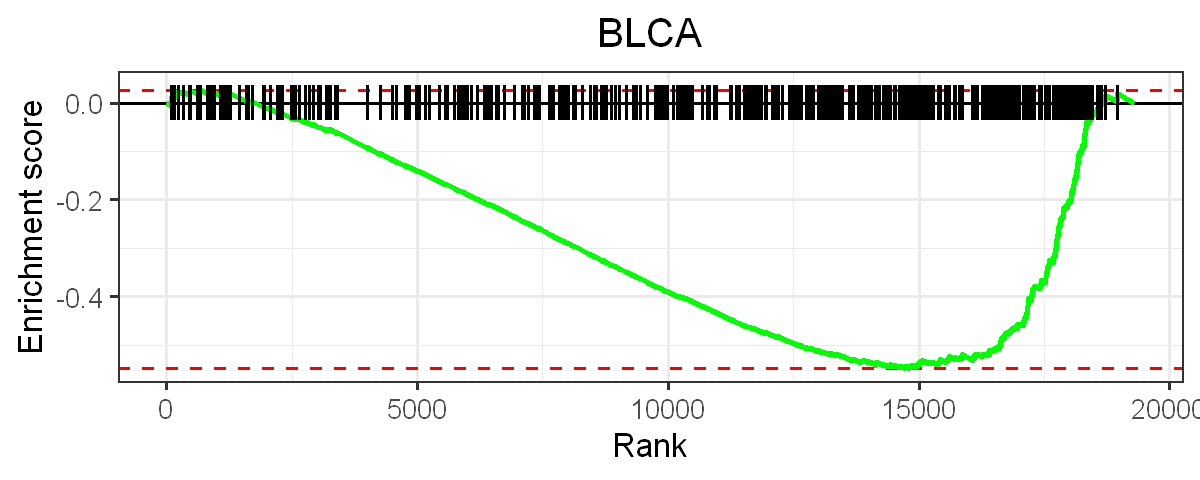

In [274]:
options(repr.plot.width = 10, repr.plot.height = 4)
p1 <- plotEnrichment(markers.sub, order.tar, ticksSize  = 1) + theme_bw(base_size = 20) + ylab('Enrichment score') + xlab('Rank') + ggtitle('BLCA') + theme(plot.title = element_text(hjust = 0.5))
p1

In [275]:
order.tar <- log2FcCalc[, 'UVM']
names(order.tar) <- rownames(log2FcCalc)
order.tar <- order.tar[!is.na(order.tar)]
order.tar <- order.tar[order.tar != -Inf]
order.tar <- sort(order.tar, decreasing = T)

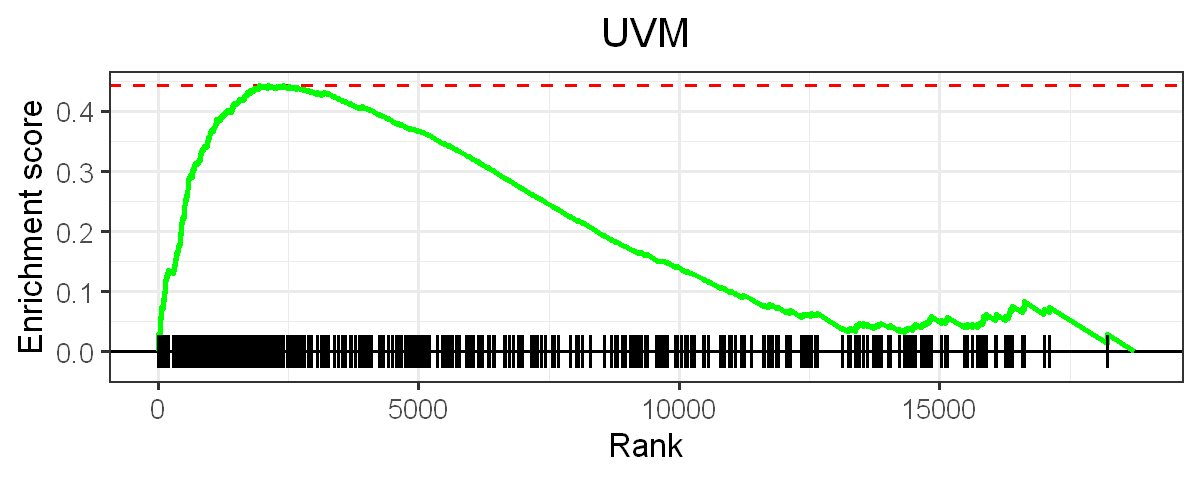

In [276]:
options(repr.plot.width = 10, repr.plot.height = 4)
p2 <- plotEnrichment(markers.sub, order.tar, ticksSize  = 1) + theme_bw(base_size = 20) + ylab('Enrichment score') + xlab('Rank') + ggtitle('UVM') + theme(plot.title = element_text(hjust = 0.5))
p2

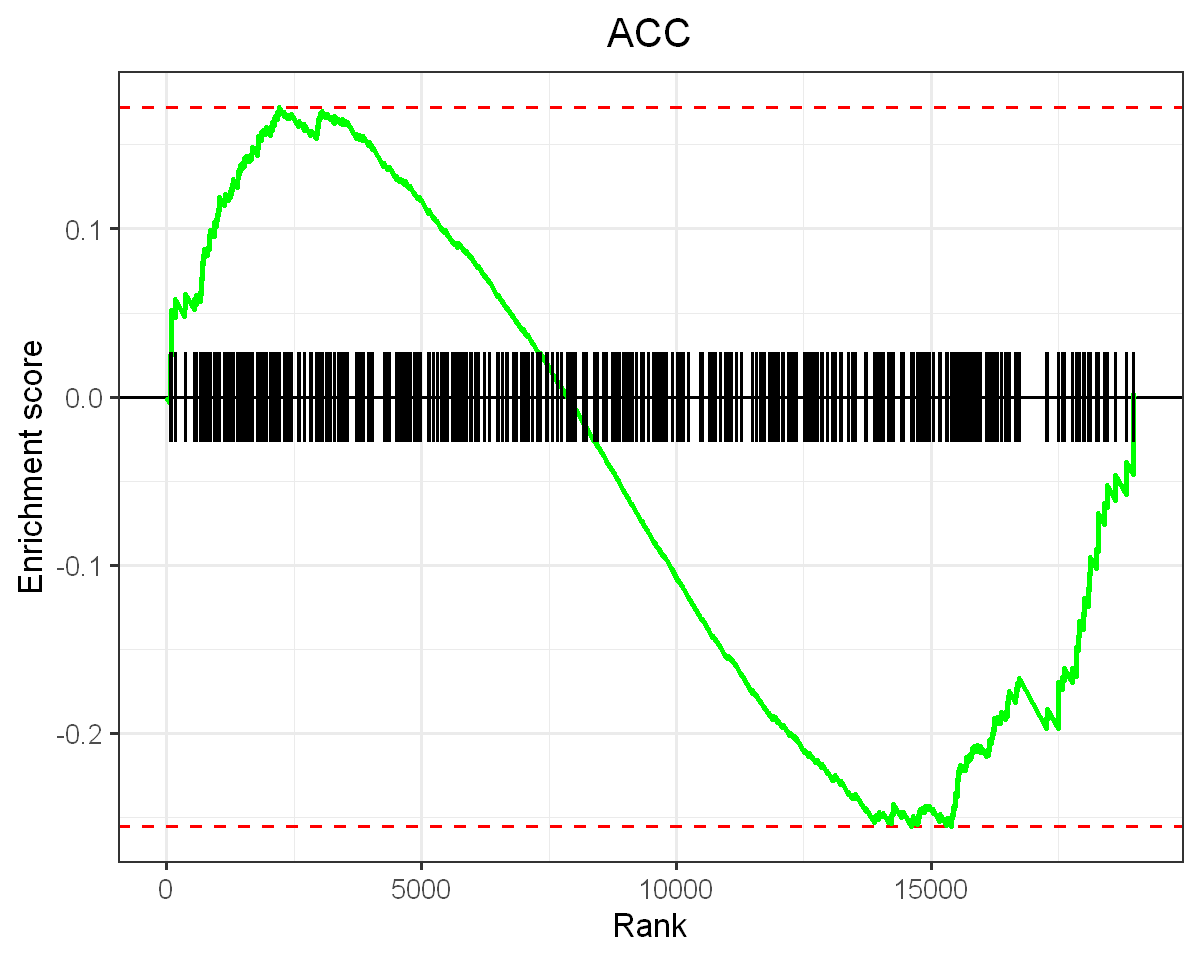

In [279]:
order.tar <- log2FcCalc[, 'ACC']
names(order.tar) <- rownames(log2FcCalc)
order.tar <- order.tar[!is.na(order.tar)]
order.tar <- order.tar[order.tar != -Inf]
order.tar <- sort(order.tar, decreasing = T)
p3 <- plotEnrichment(markers.sub, order.tar, ticksSize  = 1) + theme_bw(base_size = 20) + ylab('Enrichment score') + xlab('Rank') + ggtitle('ACC') + theme(plot.title = element_text(hjust = 0.5))
p3

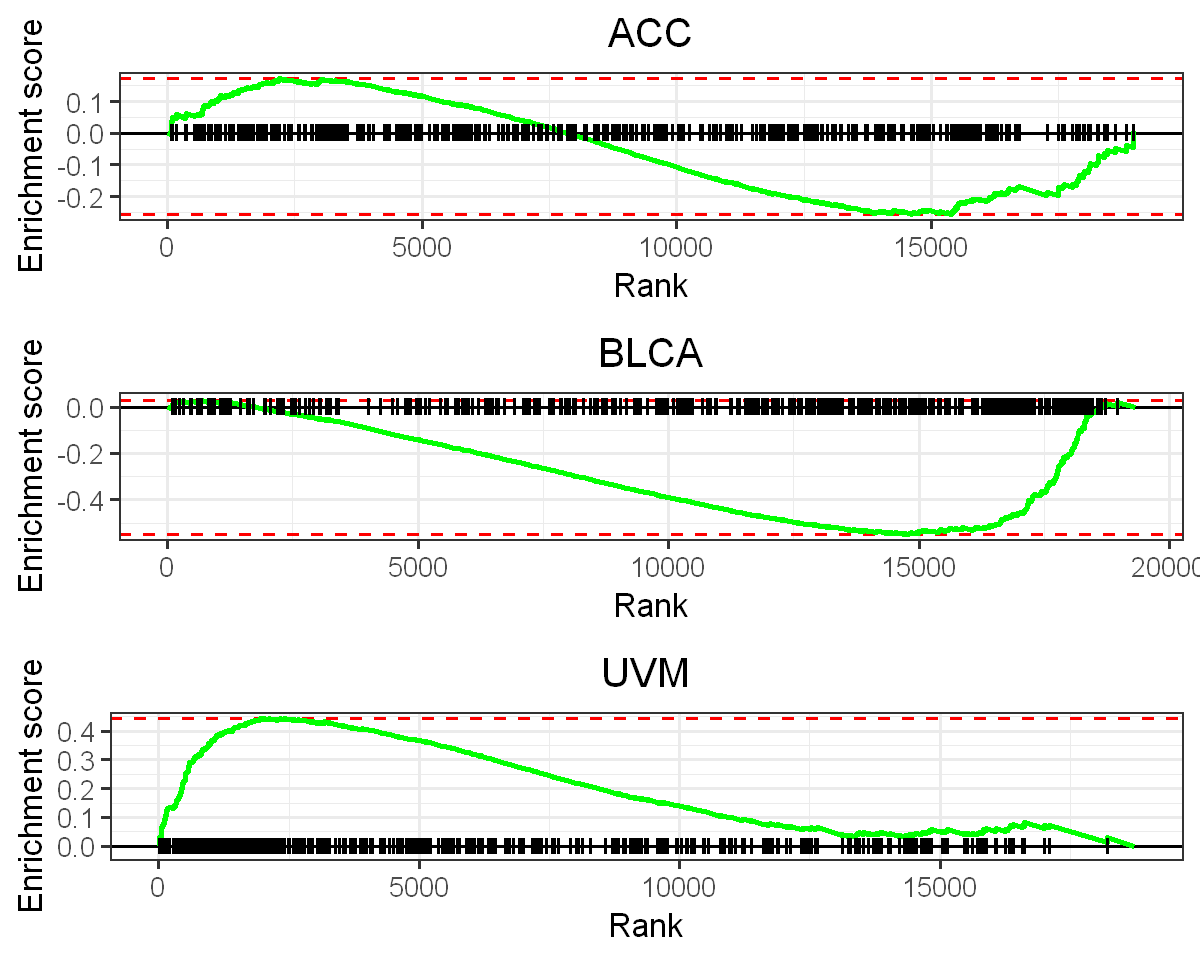

In [282]:
options(repr.plot.width = 10, repr.plot.height = 8)
ggarrange(p3, p1, p2, nrow = 3)
ggsave(file.path(out.figs.dir, 'gsea.immune.pdf'), width = 8, height = 10)

In [257]:
plotEnrichment <- function (pathway, stats, gseaParam = 1, ticksSize = 0.2) 
{
    rnk <- rank(-stats)
    ord <- order(rnk)
    statsAdj <- stats[ord]
    statsAdj <- sign(statsAdj) * (abs(statsAdj)^gseaParam)
    statsAdj <- statsAdj/max(abs(statsAdj))
    pathway <- unname(as.vector(na.omit(match(pathway, names(statsAdj)))))
    pathway <- sort(pathway)
    gseaRes <- calcGseaStat(statsAdj, selectedStats = pathway, 
        returnAllExtremes = TRUE)
    bottoms <- gseaRes$bottoms
    tops <- gseaRes$tops
    n <- length(statsAdj)
    xs <- as.vector(rbind(pathway - 1, pathway))
    ys <- as.vector(rbind(bottoms, tops))
    toPlot <- data.frame(x = c(0, xs, n + 1), y = c(0, ys, 0))
    diff <- (max(tops) - min(bottoms))/8
    x = y = NULL
    g <- ggplot(toPlot, aes(x = x, y = y)) + geom_point(color = "green", 
        size = 0.5) + geom_hline(yintercept = max(tops), colour = "red", 
        linetype = "dashed", size = 1) + geom_hline(yintercept = min(bottoms), 
        colour = "red", linetype = "dashed", size = 1.0) + geom_hline(yintercept = 0, 
        colour = "black", size = 1.0) + geom_line(color = "green", size = 1.5) + theme_bw() + 
        geom_segment(data = data.frame(x = pathway), mapping = aes(x = x, 
            y = -diff/2, xend = x, yend = diff/2), size = ticksSize) + 
        theme(panel.border = element_blank(), panel.grid.minor = element_blank()) + 
        labs(x = "rank", y = "enrichment score")
    g
}

In [1370]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22000)

Matrix products: default

locale:
[1] LC_COLLATE=Chinese (Simplified)_China.936 
[2] LC_CTYPE=Chinese (Simplified)_China.936   
[3] LC_MONETARY=Chinese (Simplified)_China.936
[4] LC_NUMERIC=C                              
[5] LC_TIME=Chinese (Simplified)_China.936    

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] preprocessCore_1.54.0       survival_3.2-11            
 [3] survminer_0.4.9             ggpubr_0.4.0               
 [5] forestplot_1.10.1           checkmate_2.0.0            
 [7] magrittr_2.0.1              survivalROC_1.0.3          
 [9] limma_3.48.1                glmnet_4.1-2               
[11] ConsensusClusterPlus_1.56.0 readxl_1.3.1               
[13] metafor_3.0-2               Matrix_1.3-3               
[15] ggplot2_3.3.5               GSVA_1.40.1     